# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "4"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00377_1_M_120209_6"
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000272317:c.493T>C', 'ENST00000339647:c.2562C>T', 'ENST00000390319:c.118G>A', 'ENST00000479981:c.242C>T', 'ENST00000304984:c.3366G>A', 'ENST00000390634:c.373G>A', 'ENST00000293373:c.2921A>C', 'ENST00000368003:c.410G>A', 'ENST00000390299:c.269G>A', 'ENST00000353801:c.1652G>A', 'ENST00000344063:c.865G>C', 'ENST00000302182:c.575C>T', 'ENST00000483158:c.202A>C', 'ENST00000603210:c.209C>A', 'ENST00000391857:c.211C>G', 'ENST00000453673:c.105G>A', 'ENST00000603619:c.354G>A', 'ENST00000343139:c.351G>A', 'ENST00000604930:c.138A>C', 'ENST00000603600:c.285G>A', 'ENST00000390316:c.255G>A', 'ENST00000603344:c.296T>G', 'ENST00000483158:c.195A>G', 'ENST00000468494:c.262A>G', 'ENST00000603210:c.368C>T', 'ENST00000390243:c.376A>C', 'ENST00000390301:c.299T>C', 'ENST00000579721:c.453C>A', 'ENST00000353801:c.2216G>A', 'ENST00000390237:c.19C>G', 'ENST00000390319:c.204C>T', 'ENST00000343139:c.271C>G', 'ENST00000390316:c.324G>A', 'ENST00000579721:c.414G>C', 'ENST00000390243:c.506G>C', 'ENST0000060571

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,514680.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5685.0,0.0
58590,422549.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,14683.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
175099,896.0,ENST00000390309.2:c.319A>G,ENST00000390309:c.359A>G,ENST00000390309,ENSG00000211663,184.0,8520.0,0.0
128111,12005.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,183.0,NaN,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        disable_summarize=True,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,514680.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5685.0,0.0
58590,422549.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,14683.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
175099,896.0,ENST00000390309.2:c.319A>G,ENST00000390309:c.359A>G,ENST00000390309,ENSG00000211663,184.0,8520.0,0.0
128111,12005.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,183.0,NaN,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

13:59:44: Entering the loop


  0%|                                                                                                                                    | 0/301 [00:00<?, ?it/s]

  0%|▍                                                                                                                           | 1/301 [00:05<28:23,  5.68s/it]

  1%|▊                                                                                                                           | 2/301 [00:07<16:26,  3.30s/it]

  1%|█▏                                                                                                                          | 3/301 [00:08<11:50,  2.38s/it]

  1%|█▋                                                                                                                          | 4/301 [00:09<08:38,  1.75s/it]

  2%|██                                                                                                                          | 5/301 [00:10<07:49,  1.59s/it]

  2%|██▍                                                                                                                         | 6/301 [00:12<07:26,  1.51s/it]

  2%|██▉                                                                                                                         | 7/301 [00:12<06:21,  1.30s/it]

  3%|███▎                                                                                                                        | 8/301 [00:14<06:35,  1.35s/it]

  3%|███▋                                                                                                                        | 9/301 [00:15<06:57,  1.43s/it]

  3%|████                                                                                                                       | 10/301 [00:16<06:15,  1.29s/it]

  4%|████▍                                                                                                                      | 11/301 [00:18<06:15,  1.30s/it]

  4%|████▉                                                                                                                      | 12/301 [00:19<06:25,  1.33s/it]

  4%|█████▎                                                                                                                     | 13/301 [00:20<05:29,  1.14s/it]

  5%|█████▋                                                                                                                     | 14/301 [00:21<05:52,  1.23s/it]

  5%|██████▏                                                                                                                    | 15/301 [00:22<05:02,  1.06s/it]

  5%|██████▌                                                                                                                    | 16/301 [00:23<04:28,  1.06it/s]

  6%|██████▉                                                                                                                    | 17/301 [00:27<09:25,  1.99s/it]

  6%|███████▎                                                                                                                   | 18/301 [00:28<07:35,  1.61s/it]

  6%|███████▊                                                                                                                   | 19/301 [00:28<06:13,  1.33s/it]

  7%|████████▏                                                                                                                  | 20/301 [00:29<05:37,  1.20s/it]

  7%|████████▌                                                                                                                  | 21/301 [00:38<16:09,  3.46s/it]

  7%|████████▉                                                                                                                  | 22/301 [00:39<12:10,  2.62s/it]

  8%|█████████▍                                                                                                                 | 23/301 [00:39<09:21,  2.02s/it]

  8%|█████████▊                                                                                                                 | 24/301 [00:40<07:28,  1.62s/it]

  8%|██████████▏                                                                                                                | 25/301 [00:41<06:26,  1.40s/it]

  9%|██████████▌                                                                                                                | 26/301 [00:42<06:12,  1.35s/it]

  9%|███████████                                                                                                                | 27/301 [00:43<06:02,  1.32s/it]

  9%|███████████▍                                                                                                               | 28/301 [00:45<05:39,  1.24s/it]

 10%|███████████▊                                                                                                               | 29/301 [00:46<05:48,  1.28s/it]

 10%|████████████▎                                                                                                              | 30/301 [00:47<05:41,  1.26s/it]

 10%|████████████▋                                                                                                              | 31/301 [00:49<06:11,  1.38s/it]

 11%|█████████████                                                                                                              | 32/301 [00:54<11:14,  2.51s/it]

 11%|█████████████▍                                                                                                             | 33/301 [00:55<08:41,  1.95s/it]

 11%|█████████████▉                                                                                                             | 34/301 [00:56<08:35,  1.93s/it]

 12%|██████████████▎                                                                                                            | 35/301 [01:02<12:58,  2.93s/it]

 12%|██████████████▋                                                                                                            | 36/301 [01:03<10:42,  2.43s/it]

 12%|███████████████                                                                                                            | 37/301 [01:05<10:31,  2.39s/it]

 13%|███████████████▌                                                                                                           | 38/301 [01:06<08:28,  1.93s/it]

 13%|███████████████▉                                                                                                           | 39/301 [01:11<12:54,  2.96s/it]

 13%|████████████████▎                                                                                                          | 40/301 [01:13<11:01,  2.53s/it]

 14%|████████████████▊                                                                                                          | 41/301 [01:14<08:32,  1.97s/it]

 14%|█████████████████▏                                                                                                         | 42/301 [01:14<06:42,  1.56s/it]

 14%|█████████████████▌                                                                                                         | 43/301 [01:15<05:45,  1.34s/it]

 15%|█████████████████▉                                                                                                         | 44/301 [01:16<04:51,  1.13s/it]

 15%|██████████████████▍                                                                                                        | 45/301 [01:16<04:09,  1.03it/s]

 15%|██████████████████▊                                                                                                        | 46/301 [01:17<03:43,  1.14it/s]

 16%|███████████████████▏                                                                                                       | 47/301 [01:18<03:29,  1.21it/s]

 16%|███████████████████▌                                                                                                       | 48/301 [01:19<04:03,  1.04it/s]

 16%|████████████████████                                                                                                       | 49/301 [01:21<04:47,  1.14s/it]

 17%|████████████████████▍                                                                                                      | 50/301 [01:21<04:11,  1.00s/it]

 17%|████████████████████▊                                                                                                      | 51/301 [01:22<03:47,  1.10it/s]

 17%|█████████████████████▏                                                                                                     | 52/301 [01:23<03:46,  1.10it/s]

 18%|█████████████████████▋                                                                                                     | 53/301 [01:24<03:31,  1.17it/s]

 18%|██████████████████████                                                                                                     | 54/301 [01:24<03:19,  1.24it/s]

 18%|██████████████████████▍                                                                                                    | 55/301 [01:25<03:51,  1.06it/s]

 19%|██████████████████████▉                                                                                                    | 56/301 [01:26<03:48,  1.07it/s]

 19%|███████████████████████▎                                                                                                   | 57/301 [01:27<03:27,  1.17it/s]

 19%|███████████████████████▋                                                                                                   | 58/301 [01:28<04:08,  1.02s/it]

 20%|████████████████████████                                                                                                   | 59/301 [01:29<03:40,  1.10it/s]

 20%|████████████████████████▌                                                                                                  | 60/301 [01:32<05:44,  1.43s/it]

 20%|████████████████████████▉                                                                                                  | 61/301 [01:32<04:46,  1.19s/it]

 21%|█████████████████████████▎                                                                                                 | 62/301 [01:34<04:41,  1.18s/it]

 21%|█████████████████████████▋                                                                                                 | 63/301 [01:35<04:25,  1.11s/it]

 21%|██████████████████████████▏                                                                                                | 64/301 [01:35<03:51,  1.02it/s]

 22%|██████████████████████████▌                                                                                                | 65/301 [01:36<03:33,  1.10it/s]

 22%|██████████████████████████▉                                                                                                | 66/301 [01:37<03:30,  1.12it/s]

 22%|███████████████████████████▍                                                                                               | 67/301 [01:41<07:17,  1.87s/it]

 23%|███████████████████████████▊                                                                                               | 68/301 [01:42<06:18,  1.62s/it]

 23%|████████████████████████████▏                                                                                              | 69/301 [01:43<05:21,  1.38s/it]

 23%|████████████████████████████▌                                                                                              | 70/301 [01:44<04:33,  1.18s/it]

 24%|█████████████████████████████                                                                                              | 71/301 [01:45<05:08,  1.34s/it]

 24%|█████████████████████████████▍                                                                                             | 72/301 [01:46<04:20,  1.14s/it]

 24%|█████████████████████████████▊                                                                                             | 73/301 [01:47<04:08,  1.09s/it]

 25%|██████████████████████████████▏                                                                                            | 74/301 [01:49<05:14,  1.38s/it]

 25%|██████████████████████████████▋                                                                                            | 75/301 [01:50<04:22,  1.16s/it]

 25%|███████████████████████████████                                                                                            | 76/301 [01:51<05:08,  1.37s/it]

 26%|███████████████████████████████▍                                                                                           | 77/301 [01:52<04:19,  1.16s/it]

 26%|███████████████████████████████▊                                                                                           | 78/301 [01:53<04:32,  1.22s/it]

 26%|████████████████████████████████▎                                                                                          | 79/301 [01:55<04:29,  1.21s/it]

 27%|████████████████████████████████▋                                                                                          | 80/301 [01:55<03:54,  1.06s/it]

 27%|█████████████████████████████████                                                                                          | 81/301 [01:57<04:30,  1.23s/it]

 27%|█████████████████████████████████▌                                                                                         | 82/301 [01:58<03:59,  1.09s/it]

 28%|█████████████████████████████████▉                                                                                         | 83/301 [01:59<04:13,  1.16s/it]

 28%|██████████████████████████████████▎                                                                                        | 84/301 [02:00<03:42,  1.03s/it]

 28%|██████████████████████████████████▋                                                                                        | 85/301 [02:01<03:25,  1.05it/s]

 29%|███████████████████████████████████▏                                                                                       | 86/301 [02:01<03:14,  1.10it/s]

 29%|███████████████████████████████████▌                                                                                       | 87/301 [02:02<03:02,  1.17it/s]

 29%|███████████████████████████████████▉                                                                                       | 88/301 [02:03<02:47,  1.27it/s]

 30%|████████████████████████████████████▎                                                                                      | 89/301 [02:04<02:50,  1.25it/s]

 30%|████████████████████████████████████▊                                                                                      | 90/301 [02:05<03:24,  1.03it/s]

 30%|█████████████████████████████████████▏                                                                                     | 91/301 [02:06<03:03,  1.14it/s]

 31%|█████████████████████████████████████▌                                                                                     | 92/301 [02:07<03:29,  1.00s/it]

 31%|██████████████████████████████████████                                                                                     | 93/301 [02:08<03:56,  1.13s/it]

 31%|██████████████████████████████████████▍                                                                                    | 94/301 [02:10<04:35,  1.33s/it]

 32%|██████████████████████████████████████▊                                                                                    | 95/301 [02:11<04:05,  1.19s/it]

 32%|███████████████████████████████████████▏                                                                                   | 96/301 [02:12<04:10,  1.22s/it]

 32%|███████████████████████████████████████▋                                                                                   | 97/301 [02:14<04:12,  1.24s/it]

 33%|████████████████████████████████████████                                                                                   | 98/301 [02:14<03:39,  1.08s/it]

 33%|████████████████████████████████████████▍                                                                                  | 99/301 [02:15<03:14,  1.04it/s]

 33%|████████████████████████████████████████▌                                                                                 | 100/301 [02:16<03:03,  1.09it/s]

 34%|████████████████████████████████████████▉                                                                                 | 101/301 [02:16<02:47,  1.19it/s]

 34%|█████████████████████████████████████████▎                                                                                | 102/301 [02:17<02:49,  1.17it/s]

 34%|█████████████████████████████████████████▋                                                                                | 103/301 [02:22<06:13,  1.89s/it]

 35%|██████████████████████████████████████████▏                                                                               | 104/301 [02:23<05:40,  1.73s/it]

 35%|██████████████████████████████████████████▌                                                                               | 105/301 [02:24<04:44,  1.45s/it]

 35%|██████████████████████████████████████████▉                                                                               | 106/301 [02:25<04:09,  1.28s/it]

 36%|███████████████████████████████████████████▎                                                                              | 107/301 [02:26<03:43,  1.15s/it]

 36%|███████████████████████████████████████████▊                                                                              | 108/301 [02:26<03:16,  1.02s/it]

 36%|████████████████████████████████████████████▏                                                                             | 109/301 [02:28<03:37,  1.13s/it]

 37%|████████████████████████████████████████████▌                                                                             | 110/301 [02:28<03:08,  1.01it/s]

 37%|████████████████████████████████████████████▉                                                                             | 111/301 [02:29<02:48,  1.13it/s]

 37%|█████████████████████████████████████████████▍                                                                            | 112/301 [02:30<02:35,  1.22it/s]

 38%|█████████████████████████████████████████████▊                                                                            | 113/301 [02:31<03:02,  1.03it/s]

 38%|██████████████████████████████████████████████▏                                                                           | 114/301 [02:34<05:07,  1.65s/it]

 38%|██████████████████████████████████████████████▌                                                                           | 115/301 [02:35<04:48,  1.55s/it]

 39%|███████████████████████████████████████████████                                                                           | 116/301 [02:36<04:03,  1.32s/it]

 39%|███████████████████████████████████████████████▍                                                                          | 117/301 [02:37<03:28,  1.13s/it]

 39%|███████████████████████████████████████████████▊                                                                          | 118/301 [02:38<03:02,  1.00it/s]

 40%|████████████████████████████████████████████████▏                                                                         | 119/301 [02:38<02:54,  1.04it/s]

 40%|████████████████████████████████████████████████▋                                                                         | 120/301 [02:39<02:40,  1.13it/s]

 40%|█████████████████████████████████████████████████                                                                         | 121/301 [02:41<03:31,  1.17s/it]

 41%|█████████████████████████████████████████████████▍                                                                        | 122/301 [02:42<03:05,  1.04s/it]

 41%|█████████████████████████████████████████████████▊                                                                        | 123/301 [02:48<07:34,  2.55s/it]

 41%|██████████████████████████████████████████████████▎                                                                       | 124/301 [02:49<06:36,  2.24s/it]

 42%|██████████████████████████████████████████████████▋                                                                       | 125/301 [02:50<05:12,  1.77s/it]

 42%|███████████████████████████████████████████████████                                                                       | 126/301 [02:51<04:13,  1.45s/it]

 42%|███████████████████████████████████████████████████▍                                                                      | 127/301 [02:57<08:24,  2.90s/it]

 43%|███████████████████████████████████████████████████▉                                                                      | 128/301 [02:58<06:27,  2.24s/it]

 43%|████████████████████████████████████████████████████▎                                                                     | 129/301 [02:58<05:07,  1.79s/it]

 43%|████████████████████████████████████████████████████▋                                                                     | 130/301 [02:59<04:10,  1.47s/it]

 44%|█████████████████████████████████████████████████████                                                                     | 131/301 [03:00<03:43,  1.31s/it]

 44%|█████████████████████████████████████████████████████▌                                                                    | 132/301 [03:01<03:08,  1.12s/it]

 44%|█████████████████████████████████████████████████████▉                                                                    | 133/301 [03:02<03:21,  1.20s/it]

 45%|██████████████████████████████████████████████████████▎                                                                   | 134/301 [03:03<02:53,  1.04s/it]

 45%|██████████████████████████████████████████████████████▋                                                                   | 135/301 [03:04<02:34,  1.07it/s]

 45%|███████████████████████████████████████████████████████                                                                   | 136/301 [03:04<02:32,  1.08it/s]

 46%|███████████████████████████████████████████████████████▌                                                                  | 137/301 [03:05<02:17,  1.19it/s]

 46%|███████████████████████████████████████████████████████▉                                                                  | 138/301 [03:06<02:38,  1.03it/s]

 46%|████████████████████████████████████████████████████████▎                                                                 | 139/301 [03:07<02:33,  1.06it/s]

 47%|████████████████████████████████████████████████████████▋                                                                 | 140/301 [03:09<02:48,  1.05s/it]

 47%|█████████████████████████████████████████████████████████▏                                                                | 141/301 [03:09<02:29,  1.07it/s]

 47%|█████████████████████████████████████████████████████████▌                                                                | 142/301 [03:10<02:17,  1.15it/s]

 48%|█████████████████████████████████████████████████████████▉                                                                | 143/301 [03:11<02:08,  1.23it/s]

 48%|██████████████████████████████████████████████████████████▎                                                               | 144/301 [03:12<02:12,  1.18it/s]

 48%|██████████████████████████████████████████████████████████▊                                                               | 145/301 [03:12<02:15,  1.15it/s]

 49%|███████████████████████████████████████████████████████████▏                                                              | 146/301 [03:13<02:11,  1.18it/s]

 49%|███████████████████████████████████████████████████████████▌                                                              | 147/301 [03:14<02:03,  1.25it/s]

 49%|███████████████████████████████████████████████████████████▉                                                              | 148/301 [03:15<01:58,  1.29it/s]

 50%|████████████████████████████████████████████████████████████▍                                                             | 149/301 [03:15<01:54,  1.33it/s]

 50%|████████████████████████████████████████████████████████████▊                                                             | 150/301 [03:16<01:53,  1.33it/s]

 50%|█████████████████████████████████████████████████████████████▏                                                            | 151/301 [03:17<01:51,  1.35it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                            | 152/301 [03:18<01:50,  1.35it/s]

 51%|██████████████████████████████████████████████████████████████                                                            | 153/301 [03:18<01:47,  1.37it/s]

 51%|██████████████████████████████████████████████████████████████▍                                                           | 154/301 [03:19<01:44,  1.41it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                           | 155/301 [03:20<01:42,  1.42it/s]

 52%|███████████████████████████████████████████████████████████████▏                                                          | 156/301 [03:27<06:25,  2.66s/it]

 52%|███████████████████████████████████████████████████████████████▋                                                          | 157/301 [03:28<04:57,  2.07s/it]

 52%|████████████████████████████████████████████████████████████████                                                          | 158/301 [03:33<07:15,  3.04s/it]

 53%|████████████████████████████████████████████████████████████████▍                                                         | 159/301 [03:34<06:12,  2.63s/it]

 53%|████████████████████████████████████████████████████████████████▊                                                         | 160/301 [03:35<04:47,  2.04s/it]

 53%|█████████████████████████████████████████████████████████████████▎                                                        | 161/301 [03:36<03:50,  1.64s/it]

 54%|█████████████████████████████████████████████████████████████████▋                                                        | 162/301 [03:37<03:10,  1.37s/it]

 54%|██████████████████████████████████████████████████████████████████                                                        | 163/301 [03:37<02:41,  1.17s/it]

 54%|██████████████████████████████████████████████████████████████████▍                                                       | 164/301 [03:38<02:19,  1.02s/it]

 55%|██████████████████████████████████████████████████████████████████▉                                                       | 165/301 [03:39<02:06,  1.08it/s]

 55%|███████████████████████████████████████████████████████████████████▎                                                      | 166/301 [03:39<01:55,  1.17it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                      | 167/301 [03:40<01:46,  1.25it/s]

 56%|████████████████████████████████████████████████████████████████████                                                      | 168/301 [03:45<04:31,  2.04s/it]

 56%|████████████████████████████████████████████████████████████████████▍                                                     | 169/301 [03:46<03:41,  1.68s/it]

 56%|████████████████████████████████████████████████████████████████████▉                                                     | 170/301 [03:47<03:01,  1.39s/it]

 57%|█████████████████████████████████████████████████████████████████████▎                                                    | 171/301 [03:48<03:03,  1.41s/it]

 57%|█████████████████████████████████████████████████████████████████████▋                                                    | 172/301 [03:54<05:41,  2.65s/it]

 57%|██████████████████████████████████████████████████████████████████████                                                    | 173/301 [03:55<04:50,  2.27s/it]

 58%|██████████████████████████████████████████████████████████████████████▌                                                   | 174/301 [03:56<04:14,  2.01s/it]

 58%|██████████████████████████████████████████████████████████████████████▉                                                   | 175/301 [03:58<03:49,  1.83s/it]

 58%|███████████████████████████████████████████████████████████████████████▎                                                  | 176/301 [03:59<03:29,  1.67s/it]

 59%|███████████████████████████████████████████████████████████████████████▋                                                  | 177/301 [04:01<03:25,  1.66s/it]

 59%|████████████████████████████████████████████████████████████████████████▏                                                 | 178/301 [04:01<02:46,  1.35s/it]

 59%|████████████████████████████████████████████████████████████████████████▌                                                 | 179/301 [04:02<02:19,  1.14s/it]

 60%|████████████████████████████████████████████████████████████████████████▉                                                 | 180/301 [04:03<02:02,  1.02s/it]

 60%|█████████████████████████████████████████████████████████████████████████▎                                                | 181/301 [04:04<02:14,  1.12s/it]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                | 182/301 [04:05<01:56,  1.02it/s]

 61%|██████████████████████████████████████████████████████████████████████████▏                                               | 183/301 [04:05<01:47,  1.10it/s]

 61%|██████████████████████████████████████████████████████████████████████████▌                                               | 184/301 [04:06<01:41,  1.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████▉                                               | 185/301 [04:08<01:56,  1.01s/it]

 62%|███████████████████████████████████████████████████████████████████████████▍                                              | 186/301 [04:09<02:07,  1.11s/it]

 62%|███████████████████████████████████████████████████████████████████████████▊                                              | 187/301 [04:10<02:18,  1.22s/it]

 62%|████████████████████████████████████████████████████████████████████████████▏                                             | 188/301 [04:11<01:59,  1.06s/it]

 63%|████████████████████████████████████████████████████████████████████████████▌                                             | 189/301 [04:17<04:36,  2.47s/it]

 63%|█████████████████████████████████████████████████████████████████████████████                                             | 190/301 [04:18<03:47,  2.05s/it]

 63%|█████████████████████████████████████████████████████████████████████████████▍                                            | 191/301 [04:19<02:59,  1.63s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▊                                            | 192/301 [04:19<02:26,  1.34s/it]

 64%|██████████████████████████████████████████████████████████████████████████████▏                                           | 193/301 [04:20<02:03,  1.14s/it]

 64%|██████████████████████████████████████████████████████████████████████████████▋                                           | 194/301 [04:21<01:47,  1.01s/it]

 65%|███████████████████████████████████████████████████████████████████████████████                                           | 195/301 [04:21<01:35,  1.11it/s]

 65%|███████████████████████████████████████████████████████████████████████████████▍                                          | 196/301 [04:22<01:27,  1.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████▊                                          | 197/301 [04:23<01:22,  1.27it/s]

 66%|████████████████████████████████████████████████████████████████████████████████▎                                         | 198/301 [04:33<06:10,  3.60s/it]

 66%|████████████████████████████████████████████████████████████████████████████████▋                                         | 199/301 [04:33<04:37,  2.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████                                         | 200/301 [04:34<03:32,  2.11s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████▍                                        | 201/301 [04:35<02:47,  1.68s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████▊                                        | 202/301 [04:35<02:16,  1.38s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████▎                                       | 203/301 [04:36<01:53,  1.16s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████▋                                       | 204/301 [04:37<01:39,  1.02s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████                                       | 205/301 [04:38<01:33,  1.02it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▍                                      | 206/301 [04:38<01:24,  1.13it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 207/301 [04:39<01:17,  1.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▎                                     | 208/301 [04:40<01:13,  1.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▋                                     | 209/301 [04:40<01:09,  1.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████                                     | 210/301 [04:41<01:06,  1.37it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████▌                                    | 211/301 [04:42<01:04,  1.39it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████▉                                    | 212/301 [04:42<01:02,  1.41it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▎                                   | 213/301 [04:43<01:06,  1.32it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▋                                   | 214/301 [04:44<01:04,  1.36it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▏                                  | 215/301 [04:45<01:02,  1.39it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▌                                  | 216/301 [04:45<00:59,  1.43it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▉                                  | 217/301 [04:47<01:14,  1.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▎                                 | 218/301 [04:47<01:08,  1.22it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 219/301 [04:48<01:09,  1.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▏                                | 220/301 [04:49<01:04,  1.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▌                                | 221/301 [04:50<01:00,  1.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                                | 222/301 [04:50<00:58,  1.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████▍                               | 223/301 [04:51<01:00,  1.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                               | 224/301 [04:52<00:58,  1.31it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                              | 225/301 [04:53<00:55,  1.37it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 226/301 [04:53<00:52,  1.42it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████                              | 227/301 [04:56<01:29,  1.20s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▍                             | 228/301 [04:56<01:15,  1.04s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▊                             | 229/301 [04:57<01:08,  1.06it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                            | 230/301 [04:58<01:01,  1.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                            | 231/301 [04:58<00:56,  1.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████                            | 232/301 [04:59<00:52,  1.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▍                           | 233/301 [05:00<00:50,  1.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                           | 234/301 [05:00<00:49,  1.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▏                          | 235/301 [05:04<01:54,  1.74s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                          | 236/301 [05:05<01:32,  1.42s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████                          | 237/301 [05:06<01:21,  1.27s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 238/301 [05:07<01:09,  1.10s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 239/301 [05:07<01:00,  1.03it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 240/301 [05:08<00:54,  1.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 241/301 [05:11<01:20,  1.35s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                        | 242/301 [05:11<01:07,  1.15s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 243/301 [05:14<01:36,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 244/301 [05:15<01:18,  1.37s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 245/301 [05:17<01:30,  1.62s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 246/301 [05:18<01:18,  1.42s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████                      | 247/301 [05:19<01:17,  1.44s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 248/301 [05:20<01:04,  1.22s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 249/301 [05:21<00:55,  1.07s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 250/301 [05:22<00:48,  1.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/301 [05:22<00:44,  1.13it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/301 [05:23<00:39,  1.23it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 253/301 [05:24<00:38,  1.26it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 254/301 [05:24<00:36,  1.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 255/301 [05:25<00:34,  1.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 256/301 [05:26<00:32,  1.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 257/301 [05:27<00:40,  1.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 258/301 [05:28<00:45,  1.05s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 259/301 [05:30<00:47,  1.12s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 260/301 [05:31<00:52,  1.28s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 261/301 [05:33<00:51,  1.30s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 262/301 [05:34<00:55,  1.42s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 263/301 [05:39<01:27,  2.30s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████               | 264/301 [05:40<01:13,  1.99s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 265/301 [05:41<01:04,  1.78s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 266/301 [05:43<00:57,  1.64s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 267/301 [05:43<00:45,  1.35s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 268/301 [05:44<00:38,  1.17s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 269/301 [05:45<00:32,  1.03s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 270/301 [05:45<00:28,  1.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 271/301 [05:46<00:26,  1.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 272/301 [05:47<00:24,  1.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 273/301 [05:48<00:27,  1.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 274/301 [05:49<00:24,  1.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 275/301 [05:50<00:21,  1.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 276/301 [05:51<00:21,  1.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 277/301 [05:51<00:19,  1.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 278/301 [05:52<00:17,  1.30it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 279/301 [05:53<00:17,  1.26it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 280/301 [05:53<00:15,  1.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 281/301 [05:54<00:14,  1.35it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 282/301 [05:56<00:17,  1.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 283/301 [05:56<00:15,  1.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 284/301 [05:57<00:13,  1.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 285/301 [05:58<00:12,  1.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 286/301 [05:58<00:10,  1.38it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 287/301 [05:59<00:10,  1.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 288/301 [06:00<00:09,  1.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 289/301 [06:00<00:08,  1.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 290/301 [06:01<00:07,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 291/301 [06:02<00:08,  1.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 292/301 [06:03<00:07,  1.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 293/301 [06:04<00:06,  1.26it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 294/301 [06:04<00:05,  1.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 295/301 [06:05<00:04,  1.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 296/301 [06:06<00:03,  1.34it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/301 [06:07<00:01,  1.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 299/301 [06:07<00:01,  1.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 300/301 [06:08<00:00,  1.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [06:09<00:00,  1.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [06:09<00:00,  1.23s/it]

In [13]:
!cat {overall_txt_out}

Number of true variants: 211
Number of false variants: 88
Number of undetermined variants: 1
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000579721:c.142G>A', 'ENST00000603423:c.137G>A', 'ENST00000390309:c.359A>G', 'ENST00000603600:c.285G>A', 'ENST00000604412:c.415T>A', 'ENST00000483158:c.199G>C', 'ENST00000453673:c.105G>A', 'ENST00000390634:c.191C>T', 'ENST00000390309:c.195G>A', 'ENST00000603344:c.296T>G', 'ENST00000604930:c.373G>A', 'ENST00000390290:c.183G>A', 'ENST00000390319:c.261G>A', 'ENST00000390290:c.299G>A', 'ENST00000390319:c.197A>G', 'ENST00000390305:c.182C>T', 'ENST00000390299:c.228G>A', 'ENST00000390299:c.269G>A', 'ENST00000390243:c.300A>G', 'ENST00000605716:c.222G>T', 'ENST00000468494:c.262A>G', 'ENST00000483158:c.195A>G', 'ENST00000354689:c.83C>T', 'ENST00000483379:c.462C>T', 'ENST00000603600:c.205C>A', 'ENST00000604045:c.277C>T', 'ENST00000390319:c.99G>C', 'ENST00000390237:c.249G>C', 'ENST00000495489:c.196G>A', 'ENST00000390237:c.132A>G', 'ENST00000390237:c.6

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_modified_bam.txt


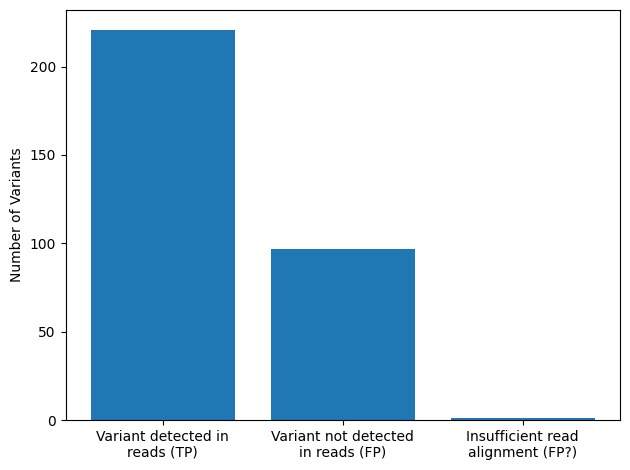

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

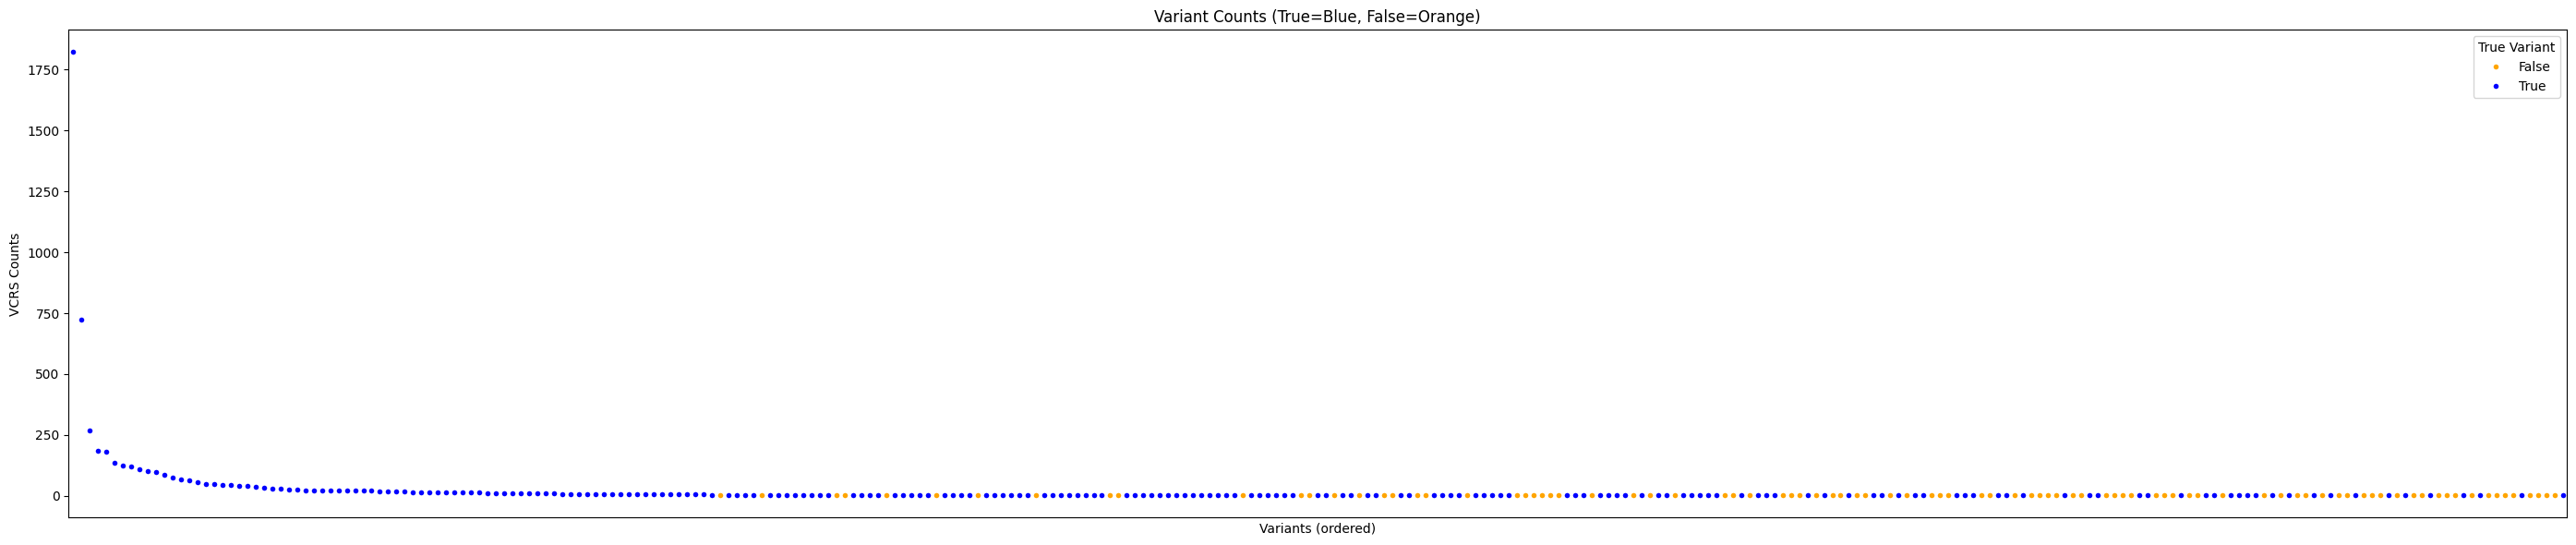

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

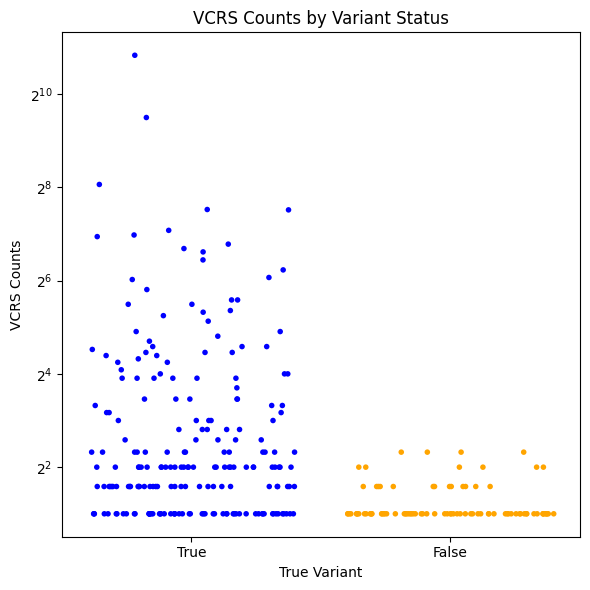

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('True Variant')
plt.ylabel('VCRS Counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('VCRS Counts by Variant Status')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: set()


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs28507236,ENST00000379407,c.528A>C,+,ENST00000379407:c.528A>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs3829739,ENST00000379407,c.1389A>G,+,ENST00000379407:c.1389A>G,True,vcrs_2
3,rs12184,ENST00000378567,c.425T>C,+,ENST00000378567:c.425T>C,True,vcrs_3
4,rs41315312,ENST00000294600,c.211C>T,+,ENST00000294600:c.211C>T,True,vcrs_4


In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

14:06:27: Entering the loop


  0%|                                                                                                                                   | 0/3273 [00:00<?, ?it/s]

  0%|                                                                                                                           | 1/3273 [00:01<59:59,  1.10s/it]

  0%|                                                                                                                           | 2/3273 [00:01<44:57,  1.21it/s]

  0%|                                                                                                                         | 3/3273 [00:12<5:00:48,  5.52s/it]

  0%|▏                                                                                                                        | 4/3273 [00:13<3:16:49,  3.61s/it]

  0%|▏                                                                                                                        | 5/3273 [00:14<2:18:42,  2.55s/it]

  0%|▏                                                                                                                        | 6/3273 [00:14<1:43:36,  1.90s/it]

  0%|▎                                                                                                                        | 7/3273 [00:15<1:21:18,  1.49s/it]

  0%|▎                                                                                                                        | 8/3273 [00:16<1:15:40,  1.39s/it]

  0%|▎                                                                                                                        | 9/3273 [00:17<1:03:10,  1.16s/it]

  0%|▎                                                                                                                         | 10/3273 [00:17<54:37,  1.00s/it]

  0%|▍                                                                                                                         | 11/3273 [00:18<48:40,  1.12it/s]

  0%|▍                                                                                                                         | 12/3273 [00:19<44:43,  1.22it/s]

  0%|▍                                                                                                                         | 13/3273 [00:19<42:13,  1.29it/s]

  0%|▌                                                                                                                         | 14/3273 [00:20<40:51,  1.33it/s]

  0%|▌                                                                                                                         | 15/3273 [00:21<39:19,  1.38it/s]

  0%|▌                                                                                                                         | 16/3273 [00:21<38:18,  1.42it/s]

  1%|▋                                                                                                                         | 17/3273 [00:22<37:33,  1.45it/s]

  1%|▋                                                                                                                         | 18/3273 [00:23<36:56,  1.47it/s]

  1%|▋                                                                                                                         | 19/3273 [00:23<36:26,  1.49it/s]

  1%|▋                                                                                                                         | 20/3273 [00:24<36:27,  1.49it/s]

  1%|▊                                                                                                                         | 21/3273 [00:25<36:14,  1.50it/s]

  1%|▊                                                                                                                         | 22/3273 [00:25<36:00,  1.50it/s]

  1%|▊                                                                                                                         | 23/3273 [00:26<35:49,  1.51it/s]

  1%|▉                                                                                                                         | 24/3273 [00:27<35:47,  1.51it/s]

  1%|▉                                                                                                                         | 25/3273 [00:27<35:41,  1.52it/s]

  1%|▉                                                                                                                         | 26/3273 [00:28<37:15,  1.45it/s]

  1%|█                                                                                                                         | 27/3273 [00:29<36:54,  1.47it/s]

  1%|█                                                                                                                         | 28/3273 [00:30<42:38,  1.27it/s]

  1%|█                                                                                                                         | 29/3273 [00:31<41:43,  1.30it/s]

  1%|█                                                                                                                         | 30/3273 [00:31<40:29,  1.33it/s]

  1%|█▏                                                                                                                        | 31/3273 [00:32<39:12,  1.38it/s]

  1%|█▏                                                                                                                        | 32/3273 [00:33<38:09,  1.42it/s]

  1%|█▏                                                                                                                        | 33/3273 [00:33<37:21,  1.45it/s]

  1%|█▎                                                                                                                        | 34/3273 [00:34<36:43,  1.47it/s]

  1%|█▎                                                                                                                        | 35/3273 [00:35<36:29,  1.48it/s]

  1%|█▎                                                                                                                        | 36/3273 [00:35<36:04,  1.50it/s]

  1%|█▍                                                                                                                        | 37/3273 [00:36<35:59,  1.50it/s]

  1%|█▍                                                                                                                        | 38/3273 [00:37<35:17,  1.53it/s]

  1%|█▍                                                                                                                      | 39/3273 [00:44<2:25:00,  2.69s/it]

  1%|█▍                                                                                                                      | 40/3273 [00:45<1:51:42,  2.07s/it]

  1%|█▌                                                                                                                      | 41/3273 [00:45<1:28:26,  1.64s/it]

  1%|█▌                                                                                                                      | 42/3273 [00:56<4:01:26,  4.48s/it]

  1%|█▌                                                                                                                      | 43/3273 [00:57<2:59:24,  3.33s/it]

  1%|█▌                                                                                                                      | 44/3273 [00:58<2:15:53,  2.53s/it]

  1%|█▋                                                                                                                      | 45/3273 [00:58<1:45:33,  1.96s/it]

  1%|█▋                                                                                                                      | 46/3273 [00:59<1:24:32,  1.57s/it]

  1%|█▋                                                                                                                      | 47/3273 [01:00<1:09:50,  1.30s/it]

  1%|█▊                                                                                                                        | 48/3273 [01:00<59:23,  1.10s/it]

  1%|█▊                                                                                                                        | 49/3273 [01:01<51:55,  1.03it/s]

  2%|█▊                                                                                                                        | 50/3273 [01:02<46:43,  1.15it/s]

  2%|█▉                                                                                                                        | 51/3273 [01:02<43:14,  1.24it/s]

  2%|█▉                                                                                                                        | 52/3273 [01:03<41:12,  1.30it/s]

  2%|█▉                                                                                                                        | 53/3273 [01:04<44:27,  1.21it/s]

  2%|██                                                                                                                        | 54/3273 [01:05<41:29,  1.29it/s]

  2%|██                                                                                                                        | 55/3273 [01:05<39:19,  1.36it/s]

  2%|██                                                                                                                        | 56/3273 [01:06<37:47,  1.42it/s]

  2%|██                                                                                                                        | 57/3273 [01:06<36:43,  1.46it/s]

  2%|██▏                                                                                                                       | 58/3273 [01:07<36:03,  1.49it/s]

  2%|██▏                                                                                                                       | 59/3273 [01:08<35:50,  1.49it/s]

  2%|██▏                                                                                                                       | 60/3273 [01:08<35:36,  1.50it/s]

  2%|██▎                                                                                                                       | 62/3273 [01:09<27:28,  1.95it/s]

  2%|██▎                                                                                                                       | 63/3273 [01:10<29:05,  1.84it/s]

  2%|██▍                                                                                                                       | 64/3273 [01:11<33:19,  1.60it/s]

  2%|██▍                                                                                                                       | 65/3273 [01:11<34:48,  1.54it/s]

  2%|██▍                                                                                                                       | 67/3273 [01:12<27:06,  1.97it/s]

  2%|██▌                                                                                                                       | 68/3273 [01:13<28:51,  1.85it/s]

  2%|██▌                                                                                                                       | 69/3273 [01:13<30:50,  1.73it/s]

  2%|██▌                                                                                                                       | 70/3273 [01:14<32:07,  1.66it/s]

  2%|██▋                                                                                                                       | 71/3273 [01:15<32:53,  1.62it/s]

  2%|██▋                                                                                                                       | 72/3273 [01:15<33:24,  1.60it/s]

  2%|██▋                                                                                                                       | 73/3273 [01:16<33:48,  1.58it/s]

  2%|██▊                                                                                                                       | 74/3273 [01:17<33:58,  1.57it/s]

  2%|██▊                                                                                                                       | 75/3273 [01:18<43:47,  1.22it/s]

  2%|██▊                                                                                                                       | 77/3273 [01:18<31:49,  1.67it/s]

  2%|██▉                                                                                                                       | 78/3273 [01:19<32:27,  1.64it/s]

  2%|██▉                                                                                                                       | 79/3273 [01:21<56:32,  1.06s/it]

  2%|██▉                                                                                                                       | 80/3273 [01:22<50:59,  1.04it/s]

  2%|███                                                                                                                       | 81/3273 [01:23<46:39,  1.14it/s]

  3%|███                                                                                                                       | 82/3273 [01:23<43:31,  1.22it/s]

  3%|███                                                                                                                       | 83/3273 [01:24<40:51,  1.30it/s]

  3%|███▏                                                                                                                      | 84/3273 [01:25<39:06,  1.36it/s]

  3%|███                                                                                                                     | 85/3273 [01:34<2:56:32,  3.32s/it]

  3%|███▏                                                                                                                    | 86/3273 [01:45<4:58:53,  5.63s/it]

  3%|███▏                                                                                                                    | 87/3273 [01:46<3:39:59,  4.14s/it]

  3%|███▏                                                                                                                    | 88/3273 [01:47<2:44:32,  3.10s/it]

  3%|███▎                                                                                                                    | 89/3273 [01:47<2:05:35,  2.37s/it]

  3%|███▎                                                                                                                    | 90/3273 [01:48<1:38:08,  1.85s/it]

  3%|███▎                                                                                                                    | 91/3273 [01:49<1:18:49,  1.49s/it]

  3%|███▎                                                                                                                    | 92/3273 [01:49<1:06:06,  1.25s/it]

  3%|███▍                                                                                                                      | 93/3273 [01:50<56:34,  1.07s/it]

  3%|███▌                                                                                                                      | 94/3273 [01:51<50:54,  1.04it/s]

  3%|███▌                                                                                                                      | 95/3273 [01:51<45:43,  1.16it/s]

  3%|███▌                                                                                                                      | 96/3273 [01:52<42:04,  1.26it/s]

  3%|███▌                                                                                                                      | 97/3273 [01:53<39:45,  1.33it/s]

  3%|███▋                                                                                                                      | 98/3273 [01:53<37:55,  1.40it/s]

  3%|███▋                                                                                                                      | 99/3273 [01:54<36:36,  1.44it/s]

  3%|███▋                                                                                                                     | 100/3273 [01:54<35:43,  1.48it/s]

  3%|███▋                                                                                                                     | 101/3273 [01:55<35:02,  1.51it/s]

  3%|███▊                                                                                                                     | 102/3273 [01:56<35:27,  1.49it/s]

  3%|███▊                                                                                                                     | 103/3273 [01:56<34:33,  1.53it/s]

  3%|███▊                                                                                                                     | 104/3273 [01:57<34:16,  1.54it/s]

  3%|███▉                                                                                                                     | 105/3273 [01:58<34:02,  1.55it/s]

  3%|███▉                                                                                                                     | 106/3273 [01:58<33:55,  1.56it/s]

  3%|███▉                                                                                                                     | 107/3273 [01:59<33:58,  1.55it/s]

  3%|███▉                                                                                                                     | 108/3273 [02:00<36:05,  1.46it/s]

  3%|████                                                                                                                     | 109/3273 [02:00<35:22,  1.49it/s]

  3%|████                                                                                                                     | 110/3273 [02:01<34:54,  1.51it/s]

  3%|████                                                                                                                     | 111/3273 [02:02<34:27,  1.53it/s]

  3%|████▏                                                                                                                    | 112/3273 [02:02<34:18,  1.54it/s]

  3%|████▏                                                                                                                    | 113/3273 [02:03<34:08,  1.54it/s]

  3%|████▏                                                                                                                    | 114/3273 [02:04<33:55,  1.55it/s]

  4%|████▎                                                                                                                    | 115/3273 [02:04<33:53,  1.55it/s]

  4%|████▎                                                                                                                    | 116/3273 [02:05<33:50,  1.56it/s]

  4%|████▎                                                                                                                    | 117/3273 [02:06<34:15,  1.54it/s]

  4%|████▎                                                                                                                    | 118/3273 [02:06<34:05,  1.54it/s]

  4%|████▍                                                                                                                    | 119/3273 [02:07<34:03,  1.54it/s]

  4%|████▍                                                                                                                    | 121/3273 [02:07<26:09,  2.01it/s]

  4%|████▌                                                                                                                    | 122/3273 [02:08<28:14,  1.86it/s]

  4%|████▌                                                                                                                    | 123/3273 [02:09<29:52,  1.76it/s]

  4%|████▌                                                                                                                    | 124/3273 [02:09<31:24,  1.67it/s]

  4%|████▌                                                                                                                    | 125/3273 [02:10<32:04,  1.64it/s]

  4%|████▋                                                                                                                    | 126/3273 [02:11<32:35,  1.61it/s]

  4%|████▋                                                                                                                    | 127/3273 [02:11<32:43,  1.60it/s]

  4%|████▋                                                                                                                    | 128/3273 [02:12<33:10,  1.58it/s]

  4%|████▊                                                                                                                    | 129/3273 [02:13<33:11,  1.58it/s]

  4%|████▊                                                                                                                    | 130/3273 [02:13<33:33,  1.56it/s]

  4%|████▊                                                                                                                  | 131/3273 [02:19<1:59:58,  2.29s/it]

  4%|████▊                                                                                                                  | 132/3273 [02:20<1:34:45,  1.81s/it]

  4%|████▊                                                                                                                  | 133/3273 [02:21<1:16:52,  1.47s/it]

  4%|████▊                                                                                                                  | 134/3273 [02:22<1:04:20,  1.23s/it]

  4%|████▉                                                                                                                    | 135/3273 [02:22<55:50,  1.07s/it]

  4%|█████                                                                                                                    | 136/3273 [02:23<49:26,  1.06it/s]

  4%|█████                                                                                                                    | 137/3273 [02:24<44:53,  1.16it/s]

  4%|█████                                                                                                                    | 138/3273 [02:24<41:37,  1.26it/s]

  4%|█████▏                                                                                                                   | 139/3273 [02:25<38:55,  1.34it/s]

  4%|█████▏                                                                                                                   | 140/3273 [02:25<37:59,  1.37it/s]

  4%|█████▏                                                                                                                   | 141/3273 [02:26<36:42,  1.42it/s]

  4%|█████▏                                                                                                                   | 142/3273 [02:27<36:33,  1.43it/s]

  4%|█████▎                                                                                                                   | 143/3273 [02:27<35:29,  1.47it/s]

  4%|█████▎                                                                                                                   | 144/3273 [02:28<35:18,  1.48it/s]

  4%|█████▎                                                                                                                   | 145/3273 [02:29<35:08,  1.48it/s]

  4%|█████▍                                                                                                                   | 146/3273 [02:29<35:09,  1.48it/s]

  4%|█████▍                                                                                                                   | 147/3273 [02:30<35:24,  1.47it/s]

  5%|█████▍                                                                                                                   | 148/3273 [02:31<34:59,  1.49it/s]

  5%|█████▌                                                                                                                   | 149/3273 [02:32<35:15,  1.48it/s]

  5%|█████▌                                                                                                                   | 150/3273 [02:32<34:48,  1.50it/s]

  5%|█████▌                                                                                                                   | 151/3273 [02:33<34:41,  1.50it/s]

  5%|█████▌                                                                                                                   | 152/3273 [02:33<34:53,  1.49it/s]

  5%|█████▋                                                                                                                   | 153/3273 [02:34<34:30,  1.51it/s]

  5%|█████▋                                                                                                                   | 155/3273 [02:35<26:43,  1.94it/s]

  5%|█████▊                                                                                                                   | 156/3273 [02:35<28:28,  1.82it/s]

  5%|█████▊                                                                                                                   | 157/3273 [02:36<30:03,  1.73it/s]

  5%|█████▊                                                                                                                   | 158/3273 [02:37<31:18,  1.66it/s]

  5%|█████▉                                                                                                                   | 159/3273 [02:37<32:05,  1.62it/s]

  5%|█████▉                                                                                                                   | 160/3273 [02:38<32:35,  1.59it/s]

  5%|█████▉                                                                                                                   | 161/3273 [02:39<33:04,  1.57it/s]

  5%|█████▉                                                                                                                   | 162/3273 [02:39<33:17,  1.56it/s]

  5%|██████                                                                                                                   | 163/3273 [02:40<33:36,  1.54it/s]

  5%|██████                                                                                                                   | 164/3273 [02:41<34:20,  1.51it/s]

  5%|██████                                                                                                                   | 165/3273 [02:41<34:11,  1.52it/s]

  5%|██████▏                                                                                                                  | 166/3273 [02:42<35:20,  1.47it/s]

  5%|██████▏                                                                                                                  | 167/3273 [02:43<44:46,  1.16it/s]

  5%|██████▏                                                                                                                  | 168/3273 [02:45<53:31,  1.03s/it]

  5%|██████▏                                                                                                                  | 169/3273 [02:46<59:04,  1.14s/it]

  5%|██████▏                                                                                                                | 170/3273 [02:48<1:01:18,  1.19s/it]

  5%|██████▏                                                                                                                | 171/3273 [02:49<1:06:18,  1.28s/it]

  5%|██████▎                                                                                                                | 172/3273 [02:55<2:24:37,  2.80s/it]

  5%|██████▎                                                                                                                | 173/3273 [02:57<2:01:02,  2.34s/it]

  5%|██████▎                                                                                                                | 174/3273 [03:00<2:08:02,  2.48s/it]

  5%|██████▎                                                                                                                | 175/3273 [03:01<1:49:25,  2.12s/it]

  5%|██████▍                                                                                                                | 176/3273 [03:09<3:22:33,  3.92s/it]

  5%|██████▍                                                                                                                | 177/3273 [03:16<4:05:55,  4.77s/it]

  5%|██████▍                                                                                                                | 178/3273 [03:16<3:02:08,  3.53s/it]

  5%|██████▌                                                                                                                | 180/3273 [03:17<1:47:50,  2.09s/it]

  6%|██████▌                                                                                                                | 181/3273 [03:24<2:50:10,  3.30s/it]

  6%|██████▌                                                                                                                | 182/3273 [03:32<3:51:37,  4.50s/it]

  6%|██████▋                                                                                                                | 183/3273 [03:33<2:57:29,  3.45s/it]

  6%|██████▋                                                                                                                | 184/3273 [03:33<2:17:05,  2.66s/it]

  6%|██████▋                                                                                                                | 185/3273 [03:34<1:47:30,  2.09s/it]

  6%|██████▊                                                                                                                | 186/3273 [03:35<1:25:52,  1.67s/it]

  6%|██████▊                                                                                                                | 187/3273 [03:35<1:10:56,  1.38s/it]

  6%|██████▊                                                                                                                | 188/3273 [03:36<1:00:08,  1.17s/it]

  6%|██████▉                                                                                                                  | 189/3273 [03:37<51:48,  1.01s/it]

  6%|███████                                                                                                                  | 190/3273 [03:37<46:06,  1.11it/s]

  6%|███████                                                                                                                  | 191/3273 [03:38<42:35,  1.21it/s]

  6%|███████                                                                                                                  | 192/3273 [03:38<40:05,  1.28it/s]

  6%|███████▏                                                                                                                 | 193/3273 [03:39<38:15,  1.34it/s]

  6%|███████▏                                                                                                                 | 194/3273 [03:40<37:12,  1.38it/s]

  6%|███████▏                                                                                                                 | 195/3273 [03:40<36:03,  1.42it/s]

  6%|███████▏                                                                                                                 | 196/3273 [03:41<35:27,  1.45it/s]

  6%|███████▎                                                                                                                 | 197/3273 [03:42<34:25,  1.49it/s]

  6%|███████▎                                                                                                                 | 198/3273 [03:42<34:30,  1.48it/s]

  6%|███████▎                                                                                                                 | 199/3273 [03:43<34:38,  1.48it/s]

  6%|███████▍                                                                                                                 | 200/3273 [03:44<34:22,  1.49it/s]

  6%|███████▍                                                                                                                 | 201/3273 [03:44<34:05,  1.50it/s]

  6%|███████▍                                                                                                                 | 202/3273 [03:45<34:05,  1.50it/s]

  6%|███████▌                                                                                                                 | 203/3273 [03:46<34:19,  1.49it/s]

  6%|███████▌                                                                                                                 | 204/3273 [03:46<34:00,  1.50it/s]

  6%|███████▌                                                                                                                 | 205/3273 [03:47<33:43,  1.52it/s]

  6%|███████▌                                                                                                                 | 206/3273 [03:48<33:42,  1.52it/s]

  6%|███████▋                                                                                                                 | 207/3273 [03:48<33:46,  1.51it/s]

  6%|███████▋                                                                                                                 | 208/3273 [03:50<49:32,  1.03it/s]

  6%|███████▋                                                                                                                 | 209/3273 [03:51<44:37,  1.14it/s]

  6%|███████▊                                                                                                                 | 210/3273 [03:51<41:26,  1.23it/s]

  6%|███████▊                                                                                                                 | 211/3273 [03:52<39:13,  1.30it/s]

  6%|███████▊                                                                                                                 | 212/3273 [03:53<37:35,  1.36it/s]

  7%|███████▊                                                                                                                 | 213/3273 [03:53<36:22,  1.40it/s]

  7%|███████▉                                                                                                                 | 214/3273 [03:54<35:29,  1.44it/s]

  7%|███████▉                                                                                                                 | 215/3273 [03:55<34:45,  1.47it/s]

  7%|███████▉                                                                                                               | 217/3273 [04:02<1:44:12,  2.05s/it]

  7%|███████▉                                                                                                               | 218/3273 [04:03<1:26:26,  1.70s/it]

  7%|███████▉                                                                                                               | 219/3273 [04:03<1:12:44,  1.43s/it]

  7%|███████▉                                                                                                               | 220/3273 [04:04<1:02:03,  1.22s/it]

  7%|████████                                                                                                               | 221/3273 [04:09<2:01:35,  2.39s/it]

  7%|████████                                                                                                               | 222/3273 [04:10<1:36:14,  1.89s/it]

  7%|████████                                                                                                               | 223/3273 [04:11<1:18:00,  1.53s/it]

  7%|████████▏                                                                                                              | 224/3273 [04:11<1:04:56,  1.28s/it]

  7%|████████▎                                                                                                                | 225/3273 [04:12<56:11,  1.11s/it]

  7%|████████▎                                                                                                                | 226/3273 [04:13<49:21,  1.03it/s]

  7%|████████▍                                                                                                                | 227/3273 [04:13<44:53,  1.13it/s]

  7%|████████▍                                                                                                                | 228/3273 [04:14<41:41,  1.22it/s]

  7%|████████▍                                                                                                                | 229/3273 [04:15<39:55,  1.27it/s]

  7%|████████▎                                                                                                              | 230/3273 [04:18<1:16:37,  1.51s/it]

  7%|████████▍                                                                                                              | 231/3273 [04:19<1:03:39,  1.26s/it]

  7%|████████▌                                                                                                                | 232/3273 [04:19<54:25,  1.07s/it]

  7%|████████▌                                                                                                                | 233/3273 [04:20<47:55,  1.06it/s]

  7%|████████▋                                                                                                                | 234/3273 [04:21<43:13,  1.17it/s]

  7%|████████▌                                                                                                              | 235/3273 [04:25<1:32:09,  1.82s/it]

  7%|████████▌                                                                                                              | 236/3273 [04:25<1:15:24,  1.49s/it]

  7%|████████▊                                                                                                                | 238/3273 [04:26<48:11,  1.05it/s]

  7%|████████▊                                                                                                                | 239/3273 [04:27<44:10,  1.14it/s]

  7%|████████▊                                                                                                                | 240/3273 [04:27<41:07,  1.23it/s]

  7%|████████▉                                                                                                                | 241/3273 [04:28<43:57,  1.15it/s]

  7%|████████▉                                                                                                                | 243/3273 [04:29<31:50,  1.59it/s]

  7%|█████████                                                                                                                | 244/3273 [04:30<32:04,  1.57it/s]

  7%|█████████                                                                                                                | 245/3273 [04:30<32:35,  1.55it/s]

  8%|████████▉                                                                                                              | 246/3273 [04:35<1:24:52,  1.68s/it]

  8%|████████▉                                                                                                              | 247/3273 [04:35<1:10:54,  1.41s/it]

  8%|█████████                                                                                                              | 248/3273 [04:46<3:15:14,  3.87s/it]

  8%|█████████                                                                                                              | 249/3273 [04:46<2:28:30,  2.95s/it]

  8%|█████████                                                                                                              | 250/3273 [04:47<1:55:44,  2.30s/it]

  8%|█████████▏                                                                                                             | 251/3273 [04:48<1:30:11,  1.79s/it]

  8%|█████████▏                                                                                                             | 252/3273 [04:48<1:11:58,  1.43s/it]

  8%|█████████▎                                                                                                               | 253/3273 [04:49<59:52,  1.19s/it]

  8%|█████████▍                                                                                                               | 254/3273 [04:49<50:34,  1.01s/it]

  8%|█████████▍                                                                                                               | 255/3273 [04:50<44:02,  1.14it/s]

  8%|█████████▍                                                                                                               | 256/3273 [04:50<39:24,  1.28it/s]

  8%|█████████▌                                                                                                               | 257/3273 [04:51<36:51,  1.36it/s]

  8%|█████████▌                                                                                                               | 258/3273 [04:52<34:25,  1.46it/s]

  8%|█████████▌                                                                                                               | 259/3273 [04:52<32:40,  1.54it/s]

  8%|█████████▌                                                                                                               | 260/3273 [04:53<31:28,  1.60it/s]

  8%|█████████▋                                                                                                               | 261/3273 [04:53<31:10,  1.61it/s]

  8%|█████████▋                                                                                                               | 262/3273 [04:54<30:30,  1.65it/s]

  8%|█████████▋                                                                                                               | 263/3273 [04:55<29:58,  1.67it/s]

  8%|█████████▊                                                                                                               | 264/3273 [04:55<29:54,  1.68it/s]

  8%|█████████▊                                                                                                               | 265/3273 [04:56<29:43,  1.69it/s]

  8%|█████████▊                                                                                                               | 266/3273 [04:56<28:59,  1.73it/s]

  8%|█████████▊                                                                                                               | 267/3273 [04:57<31:37,  1.58it/s]

  8%|█████████▉                                                                                                               | 268/3273 [04:58<30:47,  1.63it/s]

  8%|█████████▉                                                                                                               | 269/3273 [04:58<29:59,  1.67it/s]

  8%|█████████▉                                                                                                               | 270/3273 [04:59<30:41,  1.63it/s]

  8%|██████████                                                                                                               | 271/3273 [04:59<30:31,  1.64it/s]

  8%|██████████                                                                                                               | 272/3273 [05:00<30:13,  1.65it/s]

  8%|██████████                                                                                                               | 273/3273 [05:01<30:17,  1.65it/s]

  8%|██████████▏                                                                                                              | 274/3273 [05:01<29:25,  1.70it/s]

  8%|██████████▏                                                                                                              | 275/3273 [05:02<29:09,  1.71it/s]

  8%|██████████▏                                                                                                              | 276/3273 [05:02<29:01,  1.72it/s]

  8%|██████████▏                                                                                                              | 277/3273 [05:03<29:19,  1.70it/s]

  8%|██████████▎                                                                                                              | 278/3273 [05:04<30:05,  1.66it/s]

  9%|██████████▎                                                                                                              | 279/3273 [05:04<29:35,  1.69it/s]

  9%|██████████▎                                                                                                              | 280/3273 [05:05<29:14,  1.71it/s]

  9%|██████████▍                                                                                                              | 281/3273 [05:05<29:12,  1.71it/s]

  9%|██████████▍                                                                                                              | 282/3273 [05:06<29:09,  1.71it/s]

  9%|██████████▍                                                                                                              | 283/3273 [05:06<29:16,  1.70it/s]

  9%|██████████▍                                                                                                              | 284/3273 [05:08<39:16,  1.27it/s]

  9%|██████████▌                                                                                                              | 285/3273 [05:09<40:18,  1.24it/s]

  9%|██████████▌                                                                                                              | 286/3273 [05:09<36:20,  1.37it/s]

  9%|██████████▌                                                                                                              | 287/3273 [05:11<50:46,  1.02s/it]

  9%|██████████▋                                                                                                              | 288/3273 [05:11<44:07,  1.13it/s]

  9%|██████████▋                                                                                                              | 289/3273 [05:13<49:33,  1.00it/s]

  9%|██████████▋                                                                                                              | 290/3273 [05:13<43:55,  1.13it/s]

  9%|██████████▊                                                                                                              | 291/3273 [05:14<39:37,  1.25it/s]

  9%|██████████▊                                                                                                              | 292/3273 [05:14<36:48,  1.35it/s]

  9%|██████████▊                                                                                                              | 293/3273 [05:15<34:15,  1.45it/s]

  9%|██████████▊                                                                                                              | 294/3273 [05:17<57:00,  1.15s/it]

  9%|██████████▉                                                                                                              | 295/3273 [05:18<53:12,  1.07s/it]

  9%|██████████▉                                                                                                              | 296/3273 [05:19<45:43,  1.08it/s]

  9%|███████████                                                                                                              | 298/3273 [05:19<31:08,  1.59it/s]

  9%|███████████                                                                                                              | 299/3273 [05:20<30:23,  1.63it/s]

  9%|███████████                                                                                                              | 300/3273 [05:20<29:38,  1.67it/s]

  9%|██████████▉                                                                                                            | 301/3273 [05:31<2:41:38,  3.26s/it]

  9%|██████████▉                                                                                                            | 302/3273 [05:35<2:55:59,  3.55s/it]

  9%|███████████                                                                                                            | 303/3273 [05:36<2:14:00,  2.71s/it]

  9%|███████████                                                                                                            | 305/3273 [05:36<1:19:55,  1.62s/it]

  9%|███████████▏                                                                                                           | 306/3273 [05:37<1:07:21,  1.36s/it]

  9%|███████████▎                                                                                                             | 307/3273 [05:37<57:15,  1.16s/it]

  9%|███████████▍                                                                                                             | 308/3273 [05:38<56:26,  1.14s/it]

  9%|███████████▍                                                                                                             | 309/3273 [05:39<48:38,  1.02it/s]

  9%|███████████▍                                                                                                             | 310/3273 [05:40<43:01,  1.15it/s]

 10%|███████████▍                                                                                                             | 311/3273 [05:40<38:42,  1.28it/s]

 10%|███████████▌                                                                                                             | 312/3273 [05:41<35:42,  1.38it/s]

 10%|███████████▌                                                                                                             | 313/3273 [05:41<33:29,  1.47it/s]

 10%|███████████▌                                                                                                             | 314/3273 [05:42<31:55,  1.54it/s]

 10%|███████████▋                                                                                                             | 315/3273 [05:42<30:23,  1.62it/s]

 10%|███████████▋                                                                                                             | 316/3273 [05:43<30:06,  1.64it/s]

 10%|███████████▋                                                                                                             | 317/3273 [05:44<29:56,  1.65it/s]

 10%|███████████▊                                                                                                             | 318/3273 [05:44<29:44,  1.66it/s]

 10%|███████████▊                                                                                                             | 319/3273 [05:45<29:20,  1.68it/s]

 10%|███████████▊                                                                                                             | 320/3273 [05:45<29:17,  1.68it/s]

 10%|███████████▊                                                                                                             | 321/3273 [05:46<29:03,  1.69it/s]

 10%|███████████▉                                                                                                             | 322/3273 [05:47<29:51,  1.65it/s]

 10%|███████████▉                                                                                                             | 323/3273 [05:47<29:20,  1.68it/s]

 10%|████████████                                                                                                             | 325/3273 [05:48<22:29,  2.19it/s]

 10%|████████████                                                                                                             | 326/3273 [05:48<23:50,  2.06it/s]

 10%|████████████                                                                                                             | 327/3273 [05:49<25:17,  1.94it/s]

 10%|████████████▏                                                                                                            | 328/3273 [05:50<25:53,  1.90it/s]

 10%|████████████▏                                                                                                            | 329/3273 [05:50<26:29,  1.85it/s]

 10%|████████████▏                                                                                                            | 331/3273 [05:51<21:01,  2.33it/s]

 10%|████████████▎                                                                                                            | 332/3273 [05:51<23:04,  2.12it/s]

 10%|████████████▎                                                                                                            | 333/3273 [05:52<24:54,  1.97it/s]

 10%|████████████▎                                                                                                            | 334/3273 [05:53<26:38,  1.84it/s]

 10%|████████████▍                                                                                                            | 335/3273 [05:53<27:52,  1.76it/s]

 10%|████████████▍                                                                                                            | 336/3273 [05:54<29:11,  1.68it/s]

 10%|████████████▍                                                                                                            | 337/3273 [05:55<29:56,  1.63it/s]

 10%|████████████▍                                                                                                            | 338/3273 [05:55<30:51,  1.59it/s]

 10%|████████████▌                                                                                                            | 339/3273 [05:56<31:05,  1.57it/s]

 10%|████████████▎                                                                                                          | 340/3273 [05:59<1:09:48,  1.43s/it]

 10%|████████████▌                                                                                                            | 341/3273 [06:00<58:26,  1.20s/it]

 10%|████████████▍                                                                                                          | 342/3273 [06:03<1:26:46,  1.78s/it]

 10%|████████████▍                                                                                                          | 343/3273 [06:04<1:13:40,  1.51s/it]

 11%|████████████▌                                                                                                          | 344/3273 [06:04<1:01:08,  1.25s/it]

 11%|████████████▊                                                                                                            | 345/3273 [06:05<51:56,  1.06s/it]

 11%|████████████▊                                                                                                            | 346/3273 [06:06<45:56,  1.06it/s]

 11%|████████████▊                                                                                                            | 347/3273 [06:06<41:54,  1.16it/s]

 11%|████████████▊                                                                                                            | 348/3273 [06:07<39:01,  1.25it/s]

 11%|████████████▉                                                                                                            | 349/3273 [06:08<36:53,  1.32it/s]

 11%|████████████▉                                                                                                            | 350/3273 [06:08<35:26,  1.37it/s]

 11%|█████████████                                                                                                            | 352/3273 [06:09<26:02,  1.87it/s]

 11%|█████████████                                                                                                            | 354/3273 [06:10<22:10,  2.19it/s]

 11%|█████████████                                                                                                            | 355/3273 [06:10<24:13,  2.01it/s]

 11%|█████████████▏                                                                                                           | 356/3273 [06:11<26:03,  1.87it/s]

 11%|█████████████▏                                                                                                           | 357/3273 [06:12<29:56,  1.62it/s]

 11%|█████████████▏                                                                                                           | 358/3273 [06:12<29:57,  1.62it/s]

 11%|█████████████▎                                                                                                           | 359/3273 [06:13<30:11,  1.61it/s]

 11%|█████████████▎                                                                                                           | 361/3273 [06:14<23:42,  2.05it/s]

 11%|█████████████▍                                                                                                           | 364/3273 [06:15<18:53,  2.57it/s]

 11%|█████████████▍                                                                                                           | 365/3273 [06:15<21:08,  2.29it/s]

 11%|█████████████▌                                                                                                           | 366/3273 [06:16<23:39,  2.05it/s]

 11%|█████████████▌                                                                                                           | 367/3273 [06:17<25:24,  1.91it/s]

 11%|█████████████▌                                                                                                           | 368/3273 [06:17<27:26,  1.76it/s]

 11%|█████████████▋                                                                                                           | 369/3273 [06:18<28:31,  1.70it/s]

 11%|█████████████▋                                                                                                           | 370/3273 [06:19<29:26,  1.64it/s]

 11%|█████████████▋                                                                                                           | 371/3273 [06:19<30:39,  1.58it/s]

 11%|█████████████▊                                                                                                           | 372/3273 [06:20<30:37,  1.58it/s]

 11%|█████████████▊                                                                                                           | 373/3273 [06:21<31:00,  1.56it/s]

 11%|█████████████▊                                                                                                           | 374/3273 [06:21<31:23,  1.54it/s]

 11%|█████████████▉                                                                                                           | 376/3273 [06:22<24:24,  1.98it/s]

 12%|█████████████▉                                                                                                           | 377/3273 [06:23<26:22,  1.83it/s]

 12%|█████████████▉                                                                                                           | 378/3273 [06:23<28:03,  1.72it/s]

 12%|██████████████                                                                                                           | 379/3273 [06:25<42:23,  1.14it/s]

 12%|██████████████                                                                                                           | 380/3273 [06:26<39:25,  1.22it/s]

 12%|██████████████                                                                                                           | 381/3273 [06:26<37:20,  1.29it/s]

 12%|██████████████                                                                                                           | 382/3273 [06:27<35:36,  1.35it/s]

 12%|██████████████▏                                                                                                          | 383/3273 [06:28<34:40,  1.39it/s]

 12%|██████████████▏                                                                                                          | 384/3273 [06:28<33:29,  1.44it/s]

 12%|██████████████▏                                                                                                          | 385/3273 [06:29<32:44,  1.47it/s]

 12%|██████████████▎                                                                                                          | 386/3273 [06:30<32:56,  1.46it/s]

 12%|██████████████▎                                                                                                          | 387/3273 [06:30<32:24,  1.48it/s]

 12%|██████████████▎                                                                                                          | 388/3273 [06:31<32:14,  1.49it/s]

 12%|██████████████▍                                                                                                          | 389/3273 [06:32<31:34,  1.52it/s]

 12%|██████████████▍                                                                                                          | 390/3273 [06:32<32:17,  1.49it/s]

 12%|██████████████▍                                                                                                          | 391/3273 [06:33<32:17,  1.49it/s]

 12%|██████████████▍                                                                                                          | 392/3273 [06:34<32:21,  1.48it/s]

 12%|██████████████▌                                                                                                          | 393/3273 [06:34<32:07,  1.49it/s]

 12%|██████████████▌                                                                                                          | 394/3273 [06:35<36:20,  1.32it/s]

 12%|██████████████▌                                                                                                          | 395/3273 [06:36<38:04,  1.26it/s]

 12%|██████████████▋                                                                                                          | 397/3273 [06:37<27:42,  1.73it/s]

 12%|██████████████▋                                                                                                          | 398/3273 [06:37<28:08,  1.70it/s]

 12%|██████████████▊                                                                                                          | 399/3273 [06:39<37:44,  1.27it/s]

 12%|██████████████▊                                                                                                          | 400/3273 [06:40<43:55,  1.09it/s]

 12%|██████████████▊                                                                                                          | 401/3273 [06:41<48:30,  1.01s/it]

 12%|██████████████▊                                                                                                          | 402/3273 [06:42<51:48,  1.08s/it]

 12%|██████████████▉                                                                                                          | 403/3273 [06:44<54:27,  1.14s/it]

 12%|██████████████▋                                                                                                        | 405/3273 [06:50<1:42:13,  2.14s/it]

 12%|██████████████▊                                                                                                        | 406/3273 [06:51<1:24:45,  1.77s/it]

 12%|███████████████                                                                                                          | 408/3273 [06:52<56:23,  1.18s/it]

 12%|███████████████                                                                                                          | 409/3273 [06:52<50:42,  1.06s/it]

 13%|███████████████▏                                                                                                         | 410/3273 [06:53<45:41,  1.04it/s]

 13%|███████████████▏                                                                                                         | 411/3273 [06:54<41:49,  1.14it/s]

 13%|███████████████▏                                                                                                         | 412/3273 [06:54<38:48,  1.23it/s]

 13%|███████████████▎                                                                                                         | 413/3273 [06:55<36:46,  1.30it/s]

 13%|███████████████▎                                                                                                         | 414/3273 [06:56<35:33,  1.34it/s]

 13%|███████████████▎                                                                                                         | 415/3273 [06:56<35:47,  1.33it/s]

 13%|███████████████▍                                                                                                         | 416/3273 [06:57<34:05,  1.40it/s]

 13%|███████████████▍                                                                                                         | 417/3273 [06:58<33:15,  1.43it/s]

 13%|███████████████▍                                                                                                         | 418/3273 [06:58<32:28,  1.47it/s]

 13%|███████████████▍                                                                                                         | 419/3273 [06:59<32:34,  1.46it/s]

 13%|███████████████▌                                                                                                         | 420/3273 [07:00<31:57,  1.49it/s]

 13%|███████████████▌                                                                                                         | 421/3273 [07:00<32:37,  1.46it/s]

 13%|███████████████▌                                                                                                         | 422/3273 [07:01<32:12,  1.47it/s]

 13%|███████████████▋                                                                                                         | 423/3273 [07:02<31:58,  1.49it/s]

 13%|███████████████▋                                                                                                         | 424/3273 [07:02<31:34,  1.50it/s]

 13%|███████████████▋                                                                                                         | 425/3273 [07:03<31:45,  1.49it/s]

 13%|███████████████▋                                                                                                         | 426/3273 [07:04<31:34,  1.50it/s]

 13%|███████████████▊                                                                                                         | 427/3273 [07:04<31:30,  1.51it/s]

 13%|███████████████▊                                                                                                         | 428/3273 [07:05<31:32,  1.50it/s]

 13%|███████████████▊                                                                                                         | 429/3273 [07:06<31:16,  1.52it/s]

 13%|███████████████▉                                                                                                         | 430/3273 [07:07<39:51,  1.19it/s]

 13%|███████████████▉                                                                                                         | 431/3273 [07:08<40:18,  1.18it/s]

 13%|███████████████▉                                                                                                         | 432/3273 [07:09<38:02,  1.24it/s]

 13%|████████████████                                                                                                         | 433/3273 [07:09<35:44,  1.32it/s]

 13%|████████████████                                                                                                         | 434/3273 [07:10<34:15,  1.38it/s]

 13%|████████████████                                                                                                         | 435/3273 [07:11<33:47,  1.40it/s]

 13%|████████████████                                                                                                         | 436/3273 [07:11<32:58,  1.43it/s]

 13%|████████████████▏                                                                                                        | 437/3273 [07:12<35:36,  1.33it/s]

 13%|████████████████▏                                                                                                        | 438/3273 [07:13<33:43,  1.40it/s]

 13%|████████████████▏                                                                                                        | 439/3273 [07:13<32:43,  1.44it/s]

 13%|████████████████▎                                                                                                        | 440/3273 [07:14<32:09,  1.47it/s]

 13%|████████████████▎                                                                                                        | 441/3273 [07:15<33:11,  1.42it/s]

 14%|████████████████▎                                                                                                        | 442/3273 [07:15<32:26,  1.45it/s]

 14%|████████████████▍                                                                                                        | 443/3273 [07:16<31:56,  1.48it/s]

 14%|████████████████▍                                                                                                        | 444/3273 [07:17<31:43,  1.49it/s]

 14%|████████████████▍                                                                                                        | 445/3273 [07:17<31:49,  1.48it/s]

 14%|████████████████▍                                                                                                        | 446/3273 [07:18<31:19,  1.50it/s]

 14%|████████████████▌                                                                                                        | 447/3273 [07:19<31:31,  1.49it/s]

 14%|████████████████▌                                                                                                        | 449/3273 [07:19<24:30,  1.92it/s]

 14%|████████████████▋                                                                                                        | 450/3273 [07:20<26:23,  1.78it/s]

 14%|████████████████▋                                                                                                        | 451/3273 [07:21<31:28,  1.49it/s]

 14%|████████████████▋                                                                                                        | 452/3273 [07:22<31:48,  1.48it/s]

 14%|████████████████▋                                                                                                        | 453/3273 [07:22<31:28,  1.49it/s]

 14%|████████████████▊                                                                                                        | 454/3273 [07:24<40:42,  1.15it/s]

 14%|████████████████▊                                                                                                        | 455/3273 [07:25<52:14,  1.11s/it]

 14%|████████████████▊                                                                                                        | 456/3273 [07:26<45:54,  1.02it/s]

 14%|████████████████▉                                                                                                        | 457/3273 [07:27<41:43,  1.12it/s]

 14%|████████████████▉                                                                                                        | 458/3273 [07:27<38:41,  1.21it/s]

 14%|████████████████▋                                                                                                      | 459/3273 [07:38<2:54:37,  3.72s/it]

 14%|████████████████▋                                                                                                      | 460/3273 [07:39<2:12:06,  2.82s/it]

 14%|████████████████▊                                                                                                      | 461/3273 [07:39<1:41:58,  2.18s/it]

 14%|████████████████▊                                                                                                      | 462/3273 [07:41<1:33:11,  1.99s/it]

 14%|████████████████▊                                                                                                      | 463/3273 [07:42<1:19:14,  1.69s/it]

 14%|████████████████▊                                                                                                      | 464/3273 [07:43<1:05:04,  1.39s/it]

 14%|█████████████████▏                                                                                                       | 465/3273 [07:43<54:39,  1.17s/it]

 14%|█████████████████▏                                                                                                       | 466/3273 [07:44<47:26,  1.01s/it]

 14%|█████████████████▎                                                                                                       | 467/3273 [07:45<42:37,  1.10it/s]

 14%|█████████████████▎                                                                                                       | 468/3273 [07:45<42:06,  1.11it/s]

 14%|█████████████████▎                                                                                                       | 469/3273 [07:46<38:55,  1.20it/s]

 14%|█████████████████▍                                                                                                       | 470/3273 [07:47<36:34,  1.28it/s]

 14%|█████████████████▍                                                                                                       | 471/3273 [07:47<34:57,  1.34it/s]

 14%|█████████████████▍                                                                                                       | 472/3273 [07:48<33:40,  1.39it/s]

 14%|█████████████████▍                                                                                                       | 473/3273 [07:49<37:05,  1.26it/s]

 14%|█████████████████▌                                                                                                       | 474/3273 [07:50<40:32,  1.15it/s]

 15%|█████████████████▌                                                                                                       | 475/3273 [07:51<41:04,  1.14it/s]

 15%|█████████████████▌                                                                                                       | 476/3273 [07:52<40:10,  1.16it/s]

 15%|█████████████████▋                                                                                                       | 477/3273 [07:53<37:29,  1.24it/s]

 15%|█████████████████▋                                                                                                       | 478/3273 [07:54<40:06,  1.16it/s]

 15%|█████████████████▋                                                                                                       | 479/3273 [07:54<37:33,  1.24it/s]

 15%|█████████████████▋                                                                                                       | 480/3273 [07:55<35:13,  1.32it/s]

 15%|█████████████████▊                                                                                                       | 481/3273 [07:56<34:13,  1.36it/s]

 15%|█████████████████▊                                                                                                       | 482/3273 [07:56<33:02,  1.41it/s]

 15%|█████████████████▊                                                                                                       | 483/3273 [07:57<32:00,  1.45it/s]

 15%|█████████████████▉                                                                                                       | 484/3273 [07:57<31:20,  1.48it/s]

 15%|█████████████████▉                                                                                                       | 485/3273 [07:58<30:46,  1.51it/s]

 15%|█████████████████▉                                                                                                       | 486/3273 [07:59<30:55,  1.50it/s]

 15%|██████████████████                                                                                                       | 487/3273 [08:00<32:06,  1.45it/s]

 15%|██████████████████                                                                                                       | 488/3273 [08:01<42:09,  1.10it/s]

 15%|██████████████████                                                                                                       | 489/3273 [08:02<39:48,  1.17it/s]

 15%|██████████████████                                                                                                       | 490/3273 [08:02<36:50,  1.26it/s]

 15%|██████████████████▏                                                                                                      | 491/3273 [08:03<34:55,  1.33it/s]

 15%|██████████████████▏                                                                                                      | 492/3273 [08:04<38:23,  1.21it/s]

 15%|██████████████████▏                                                                                                      | 493/3273 [08:05<35:53,  1.29it/s]

 15%|██████████████████▎                                                                                                      | 494/3273 [08:05<34:15,  1.35it/s]

 15%|██████████████████▎                                                                                                      | 496/3273 [08:06<25:20,  1.83it/s]

 15%|██████████████████▎                                                                                                      | 497/3273 [08:07<26:25,  1.75it/s]

 15%|██████████████████▍                                                                                                      | 498/3273 [08:07<27:22,  1.69it/s]

 15%|██████████████████▍                                                                                                      | 499/3273 [08:08<28:06,  1.64it/s]

 15%|██████████████████▍                                                                                                      | 500/3273 [08:09<28:33,  1.62it/s]

 15%|██████████████████▌                                                                                                      | 501/3273 [08:09<28:51,  1.60it/s]

 15%|██████████████████▌                                                                                                      | 502/3273 [08:10<29:10,  1.58it/s]

 15%|██████████████████▌                                                                                                      | 503/3273 [08:11<29:49,  1.55it/s]

 15%|██████████████████▋                                                                                                      | 504/3273 [08:11<29:46,  1.55it/s]

 15%|██████████████████▋                                                                                                      | 505/3273 [08:12<33:35,  1.37it/s]

 15%|██████████████████▋                                                                                                      | 506/3273 [08:13<33:19,  1.38it/s]

 15%|██████████████████▋                                                                                                      | 507/3273 [08:13<32:13,  1.43it/s]

 16%|██████████████████▊                                                                                                      | 508/3273 [08:14<31:26,  1.47it/s]

 16%|██████████████████▊                                                                                                      | 509/3273 [08:15<30:39,  1.50it/s]

 16%|██████████████████▊                                                                                                      | 510/3273 [08:15<30:15,  1.52it/s]

 16%|██████████████████▉                                                                                                      | 511/3273 [08:16<30:10,  1.53it/s]

 16%|██████████████████▉                                                                                                      | 512/3273 [08:17<30:03,  1.53it/s]

 16%|██████████████████▉                                                                                                      | 513/3273 [08:17<30:24,  1.51it/s]

 16%|███████████████████                                                                                                      | 514/3273 [08:18<31:05,  1.48it/s]

 16%|███████████████████                                                                                                      | 515/3273 [08:19<31:18,  1.47it/s]

 16%|███████████████████                                                                                                      | 516/3273 [08:19<31:50,  1.44it/s]

 16%|███████████████████                                                                                                      | 517/3273 [08:20<31:18,  1.47it/s]

 16%|███████████████████▏                                                                                                     | 518/3273 [08:21<31:08,  1.47it/s]

 16%|███████████████████▏                                                                                                     | 519/3273 [08:21<31:18,  1.47it/s]

 16%|███████████████████▏                                                                                                     | 520/3273 [08:22<30:56,  1.48it/s]

 16%|███████████████████▎                                                                                                     | 521/3273 [08:23<30:41,  1.49it/s]

 16%|███████████████████▎                                                                                                     | 522/3273 [08:23<30:41,  1.49it/s]

 16%|███████████████████▎                                                                                                     | 523/3273 [08:24<30:56,  1.48it/s]

 16%|███████████████████▎                                                                                                     | 524/3273 [08:25<30:38,  1.49it/s]

 16%|███████████████████▍                                                                                                     | 525/3273 [08:25<30:19,  1.51it/s]

 16%|███████████████████▍                                                                                                     | 526/3273 [08:26<30:19,  1.51it/s]

 16%|███████████████████▍                                                                                                     | 527/3273 [08:27<30:12,  1.52it/s]

 16%|███████████████████▌                                                                                                     | 528/3273 [08:27<30:15,  1.51it/s]

 16%|███████████████████▌                                                                                                     | 529/3273 [08:28<30:12,  1.51it/s]

 16%|███████████████████▌                                                                                                     | 530/3273 [08:29<30:36,  1.49it/s]

 16%|███████████████████▋                                                                                                     | 531/3273 [08:29<30:10,  1.51it/s]

 16%|███████████████████▋                                                                                                     | 532/3273 [08:30<30:14,  1.51it/s]

 16%|███████████████████▋                                                                                                     | 533/3273 [08:31<30:08,  1.51it/s]

 16%|███████████████████▋                                                                                                     | 534/3273 [08:31<30:01,  1.52it/s]

 16%|███████████████████▊                                                                                                     | 535/3273 [08:32<30:19,  1.50it/s]

 16%|███████████████████▊                                                                                                     | 536/3273 [08:33<30:43,  1.49it/s]

 16%|███████████████████▊                                                                                                     | 537/3273 [08:34<32:32,  1.40it/s]

 16%|███████████████████▉                                                                                                     | 538/3273 [08:34<31:45,  1.43it/s]

 16%|███████████████████▉                                                                                                     | 539/3273 [08:35<31:19,  1.45it/s]

 16%|███████████████████▉                                                                                                     | 540/3273 [08:36<31:31,  1.45it/s]

 17%|████████████████████                                                                                                     | 541/3273 [08:36<31:30,  1.45it/s]

 17%|████████████████████                                                                                                     | 542/3273 [08:37<30:46,  1.48it/s]

 17%|████████████████████                                                                                                     | 543/3273 [08:38<30:28,  1.49it/s]

 17%|████████████████████                                                                                                     | 544/3273 [08:38<30:34,  1.49it/s]

 17%|████████████████████▏                                                                                                    | 545/3273 [08:39<31:40,  1.44it/s]

 17%|████████████████████▏                                                                                                    | 546/3273 [08:40<31:24,  1.45it/s]

 17%|████████████████████▏                                                                                                    | 547/3273 [08:40<30:59,  1.47it/s]

 17%|████████████████████▎                                                                                                    | 548/3273 [08:41<30:23,  1.49it/s]

 17%|████████████████████▎                                                                                                    | 549/3273 [08:42<29:59,  1.51it/s]

 17%|████████████████████▎                                                                                                    | 550/3273 [08:42<30:05,  1.51it/s]

 17%|████████████████████▎                                                                                                    | 551/3273 [08:43<30:08,  1.51it/s]

 17%|████████████████████▍                                                                                                    | 552/3273 [08:44<29:48,  1.52it/s]

 17%|████████████████████▍                                                                                                    | 553/3273 [08:44<29:37,  1.53it/s]

 17%|████████████████████▍                                                                                                    | 554/3273 [08:45<30:30,  1.49it/s]

 17%|████████████████████▌                                                                                                    | 555/3273 [08:46<30:33,  1.48it/s]

 17%|████████████████████▌                                                                                                    | 556/3273 [08:46<30:33,  1.48it/s]

 17%|████████████████████▌                                                                                                    | 557/3273 [08:47<30:23,  1.49it/s]

 17%|████████████████████▋                                                                                                    | 558/3273 [08:48<30:01,  1.51it/s]

 17%|████████████████████▋                                                                                                    | 559/3273 [08:48<29:49,  1.52it/s]

 17%|████████████████████▋                                                                                                    | 560/3273 [08:49<30:39,  1.48it/s]

 17%|████████████████████▋                                                                                                    | 561/3273 [08:50<30:19,  1.49it/s]

 17%|████████████████████▊                                                                                                    | 562/3273 [08:50<30:12,  1.50it/s]

 17%|████████████████████▊                                                                                                    | 563/3273 [08:51<30:15,  1.49it/s]

 17%|████████████████████▊                                                                                                    | 564/3273 [08:52<30:26,  1.48it/s]

 17%|████████████████████▉                                                                                                    | 565/3273 [08:52<30:09,  1.50it/s]

 17%|████████████████████▉                                                                                                    | 566/3273 [08:53<29:55,  1.51it/s]

 17%|████████████████████▉                                                                                                    | 567/3273 [08:54<29:41,  1.52it/s]

 17%|████████████████████▉                                                                                                    | 568/3273 [08:54<29:42,  1.52it/s]

 17%|█████████████████████                                                                                                    | 569/3273 [08:55<29:35,  1.52it/s]

 17%|█████████████████████                                                                                                    | 570/3273 [08:56<29:31,  1.53it/s]

 17%|█████████████████████                                                                                                    | 571/3273 [08:57<38:00,  1.18it/s]

 17%|█████████████████████▏                                                                                                   | 572/3273 [08:58<43:55,  1.02it/s]

 18%|█████████████████████▏                                                                                                   | 573/3273 [09:00<49:45,  1.11s/it]

 18%|█████████████████████▏                                                                                                   | 574/3273 [09:01<52:15,  1.16s/it]

 18%|█████████████████████▎                                                                                                   | 575/3273 [09:02<53:45,  1.20s/it]

 18%|█████████████████████▎                                                                                                   | 576/3273 [09:03<54:28,  1.21s/it]

 18%|█████████████████████▎                                                                                                   | 577/3273 [09:05<55:21,  1.23s/it]

 18%|█████████████████████▎                                                                                                   | 578/3273 [09:06<55:58,  1.25s/it]

 18%|█████████████████████▍                                                                                                   | 579/3273 [09:07<56:14,  1.25s/it]

 18%|█████████████████████▍                                                                                                   | 580/3273 [09:09<57:14,  1.28s/it]

 18%|█████████████████████▍                                                                                                   | 581/3273 [09:10<57:04,  1.27s/it]

 18%|█████████████████████▌                                                                                                   | 582/3273 [09:11<57:14,  1.28s/it]

 18%|█████████████████████▌                                                                                                   | 583/3273 [09:12<48:32,  1.08s/it]

 18%|█████████████████████▌                                                                                                   | 584/3273 [09:12<42:18,  1.06it/s]

 18%|█████████████████████▋                                                                                                   | 585/3273 [09:13<38:43,  1.16it/s]

 18%|█████████████████████▋                                                                                                   | 588/3273 [09:14<27:56,  1.60it/s]

 18%|█████████████████████▊                                                                                                   | 589/3273 [09:15<28:01,  1.60it/s]

 18%|█████████████████████▊                                                                                                   | 590/3273 [09:16<28:11,  1.59it/s]

 18%|█████████████████████▉                                                                                                   | 592/3273 [09:16<22:35,  1.98it/s]

 18%|█████████████████████▉                                                                                                   | 593/3273 [09:17<23:52,  1.87it/s]

 18%|█████████████████████▉                                                                                                   | 594/3273 [09:18<25:16,  1.77it/s]

 18%|██████████████████████                                                                                                   | 596/3273 [09:18<20:46,  2.15it/s]

 18%|██████████████████████                                                                                                   | 597/3273 [09:19<22:28,  1.98it/s]

 18%|██████████████████████                                                                                                   | 598/3273 [09:19<23:57,  1.86it/s]

 18%|██████████████████████▏                                                                                                  | 599/3273 [09:20<25:06,  1.77it/s]

 18%|██████████████████████▏                                                                                                  | 600/3273 [09:21<26:00,  1.71it/s]

 18%|██████████████████████▏                                                                                                  | 601/3273 [09:21<26:37,  1.67it/s]

 18%|██████████████████████▎                                                                                                  | 602/3273 [09:22<26:58,  1.65it/s]

 18%|██████████████████████▎                                                                                                  | 603/3273 [09:23<28:04,  1.59it/s]

 19%|██████████████████████▍                                                                                                  | 606/3273 [09:23<18:02,  2.46it/s]

 19%|██████████████████████▍                                                                                                  | 607/3273 [09:24<20:31,  2.17it/s]

 19%|██████████████████████▍                                                                                                  | 608/3273 [09:25<22:30,  1.97it/s]

 19%|██████████████████████▌                                                                                                  | 609/3273 [09:25<24:11,  1.84it/s]

 19%|██████████████████████▌                                                                                                  | 610/3273 [09:26<25:53,  1.71it/s]

 19%|██████████████████████▌                                                                                                  | 611/3273 [09:27<27:05,  1.64it/s]

 19%|██████████████████████▋                                                                                                  | 612/3273 [09:27<27:53,  1.59it/s]

 19%|██████████████████████▋                                                                                                  | 613/3273 [09:28<28:18,  1.57it/s]

 19%|██████████████████████▋                                                                                                  | 614/3273 [09:29<28:34,  1.55it/s]

 19%|██████████████████████▋                                                                                                  | 615/3273 [09:29<28:41,  1.54it/s]

 19%|██████████████████████▊                                                                                                  | 616/3273 [09:30<28:57,  1.53it/s]

 19%|██████████████████████▊                                                                                                  | 617/3273 [09:31<29:50,  1.48it/s]

 19%|██████████████████████▊                                                                                                  | 618/3273 [09:31<29:32,  1.50it/s]

 19%|██████████████████████▉                                                                                                  | 619/3273 [09:32<30:20,  1.46it/s]

 19%|██████████████████████▉                                                                                                  | 620/3273 [09:33<29:47,  1.48it/s]

 19%|██████████████████████▉                                                                                                  | 621/3273 [09:33<29:53,  1.48it/s]

 19%|██████████████████████▉                                                                                                  | 622/3273 [09:34<30:12,  1.46it/s]

 19%|███████████████████████                                                                                                  | 623/3273 [09:35<29:36,  1.49it/s]

 19%|███████████████████████                                                                                                  | 624/3273 [09:36<29:43,  1.49it/s]

 19%|███████████████████████                                                                                                  | 625/3273 [09:36<29:33,  1.49it/s]

 19%|███████████████████████▏                                                                                                 | 626/3273 [09:37<29:30,  1.50it/s]

 19%|███████████████████████▏                                                                                                 | 627/3273 [09:37<29:04,  1.52it/s]

 19%|███████████████████████▏                                                                                                 | 628/3273 [09:38<29:46,  1.48it/s]

 19%|███████████████████████▎                                                                                                 | 629/3273 [09:39<29:15,  1.51it/s]

 19%|███████████████████████▎                                                                                                 | 630/3273 [09:39<28:58,  1.52it/s]

 19%|███████████████████████▎                                                                                                 | 631/3273 [09:40<29:00,  1.52it/s]

 19%|███████████████████████▎                                                                                                 | 632/3273 [09:41<35:33,  1.24it/s]

 19%|███████████████████████▍                                                                                                 | 633/3273 [09:42<33:30,  1.31it/s]

 19%|███████████████████████▍                                                                                                 | 634/3273 [09:43<31:35,  1.39it/s]

 19%|███████████████████████▍                                                                                                 | 635/3273 [09:43<30:55,  1.42it/s]

 19%|███████████████████████▌                                                                                                 | 636/3273 [09:44<30:01,  1.46it/s]

 19%|███████████████████████▌                                                                                                 | 637/3273 [09:45<29:24,  1.49it/s]

 19%|███████████████████████▌                                                                                                 | 638/3273 [09:45<29:10,  1.51it/s]

 20%|███████████████████████▌                                                                                                 | 639/3273 [09:46<28:54,  1.52it/s]

 20%|███████████████████████▋                                                                                                 | 640/3273 [09:46<28:19,  1.55it/s]

 20%|███████████████████████▎                                                                                               | 641/3273 [09:50<1:11:06,  1.62s/it]

 20%|███████████████████████▋                                                                                                 | 642/3273 [09:51<58:18,  1.33s/it]

 20%|███████████████████████▍                                                                                               | 643/3273 [09:53<1:02:48,  1.43s/it]

 20%|███████████████████████▍                                                                                               | 644/3273 [09:54<1:04:09,  1.46s/it]

 20%|███████████████████████▊                                                                                                 | 645/3273 [09:55<55:33,  1.27s/it]

 20%|███████████████████████▉                                                                                                 | 646/3273 [09:56<47:43,  1.09s/it]

 20%|███████████████████████▉                                                                                                 | 647/3273 [09:56<42:10,  1.04it/s]

 20%|███████████████████████▉                                                                                                 | 648/3273 [09:57<38:10,  1.15it/s]

 20%|███████████████████████▉                                                                                                 | 649/3273 [09:58<35:09,  1.24it/s]

 20%|████████████████████████                                                                                                 | 650/3273 [09:58<33:03,  1.32it/s]

 20%|████████████████████████                                                                                                 | 651/3273 [09:59<31:32,  1.39it/s]

 20%|████████████████████████                                                                                                 | 652/3273 [10:00<30:27,  1.43it/s]

 20%|████████████████████████▏                                                                                                | 653/3273 [10:00<31:45,  1.37it/s]

 20%|████████████████████████▏                                                                                                | 654/3273 [10:01<30:36,  1.43it/s]

 20%|████████████████████████▏                                                                                                | 655/3273 [10:02<29:53,  1.46it/s]

 20%|████████████████████████▎                                                                                                | 656/3273 [10:03<33:13,  1.31it/s]

 20%|████████████████████████▎                                                                                                | 657/3273 [10:03<31:39,  1.38it/s]

 20%|████████████████████████▎                                                                                                | 658/3273 [10:04<31:00,  1.41it/s]

 20%|████████████████████████▎                                                                                                | 659/3273 [10:05<30:08,  1.45it/s]

 20%|████████████████████████▍                                                                                                | 660/3273 [10:05<29:38,  1.47it/s]

 20%|████████████████████████▍                                                                                                | 661/3273 [10:06<29:15,  1.49it/s]

 20%|████████████████████████▍                                                                                                | 662/3273 [10:07<29:49,  1.46it/s]

 20%|████████████████████████▌                                                                                                | 663/3273 [10:07<29:12,  1.49it/s]

 20%|████████████████████████▌                                                                                                | 664/3273 [10:08<28:49,  1.51it/s]

 20%|████████████████████████▌                                                                                                | 665/3273 [10:09<28:40,  1.52it/s]

 20%|████████████████████████▌                                                                                                | 666/3273 [10:09<28:16,  1.54it/s]

 20%|████████████████████████▋                                                                                                | 667/3273 [10:11<49:45,  1.15s/it]

 20%|████████████████████████▋                                                                                                | 668/3273 [10:12<43:08,  1.01it/s]

 20%|████████████████████████▋                                                                                                | 669/3273 [10:13<38:28,  1.13it/s]

 20%|████████████████████████▊                                                                                                | 670/3273 [10:13<35:05,  1.24it/s]

 21%|████████████████████████▊                                                                                                | 671/3273 [10:14<32:51,  1.32it/s]

 21%|████████████████████████▊                                                                                                | 672/3273 [10:15<30:54,  1.40it/s]

 21%|████████████████████████▉                                                                                                | 673/3273 [10:15<29:53,  1.45it/s]

 21%|████████████████████████▉                                                                                                | 674/3273 [10:16<29:15,  1.48it/s]

 21%|████████████████████████▉                                                                                                | 675/3273 [10:17<28:53,  1.50it/s]

 21%|████████████████████████▉                                                                                                | 676/3273 [10:17<28:47,  1.50it/s]

 21%|█████████████████████████                                                                                                | 677/3273 [10:18<28:44,  1.51it/s]

 21%|█████████████████████████                                                                                                | 678/3273 [10:19<29:30,  1.47it/s]

 21%|█████████████████████████                                                                                                | 679/3273 [10:19<28:52,  1.50it/s]

 21%|█████████████████████████▏                                                                                               | 680/3273 [10:20<28:27,  1.52it/s]

 21%|█████████████████████████▏                                                                                               | 681/3273 [10:20<28:10,  1.53it/s]

 21%|█████████████████████████▏                                                                                               | 682/3273 [10:21<28:31,  1.51it/s]

 21%|█████████████████████████▏                                                                                               | 683/3273 [10:22<30:45,  1.40it/s]

 21%|█████████████████████████▎                                                                                               | 684/3273 [10:23<29:44,  1.45it/s]

 21%|█████████████████████████▎                                                                                               | 685/3273 [10:23<29:04,  1.48it/s]

 21%|█████████████████████████▎                                                                                               | 686/3273 [10:24<28:39,  1.50it/s]

 21%|█████████████████████████▍                                                                                               | 689/3273 [10:25<23:33,  1.83it/s]

 21%|█████████████████████████▌                                                                                               | 690/3273 [10:27<30:01,  1.43it/s]

 21%|█████████████████████████▌                                                                                               | 691/3273 [10:28<35:39,  1.21it/s]

 21%|█████████████████████████▌                                                                                               | 692/3273 [10:29<43:50,  1.02s/it]

 21%|█████████████████████████▌                                                                                               | 693/3273 [10:31<48:36,  1.13s/it]

 21%|█████████████████████████▋                                                                                               | 694/3273 [10:32<52:55,  1.23s/it]

 21%|█████████████████████████▋                                                                                               | 695/3273 [10:33<47:02,  1.10s/it]

 21%|█████████████████████████▋                                                                                               | 696/3273 [10:34<41:38,  1.03it/s]

 21%|█████████████████████████▊                                                                                               | 697/3273 [10:35<39:56,  1.07it/s]

 21%|█████████████████████████▊                                                                                               | 698/3273 [10:35<39:10,  1.10it/s]

 21%|█████████████████████████▊                                                                                               | 699/3273 [10:36<35:43,  1.20it/s]

 21%|█████████████████████████▉                                                                                               | 700/3273 [10:37<33:14,  1.29it/s]

 21%|█████████████████████████▉                                                                                               | 701/3273 [10:37<31:23,  1.37it/s]

 21%|█████████████████████████▉                                                                                               | 702/3273 [10:38<30:07,  1.42it/s]

 21%|█████████████████████████▉                                                                                               | 703/3273 [10:39<29:41,  1.44it/s]

 22%|██████████████████████████                                                                                               | 704/3273 [10:39<29:36,  1.45it/s]

 22%|██████████████████████████                                                                                               | 705/3273 [10:40<29:29,  1.45it/s]

 22%|██████████████████████████                                                                                               | 706/3273 [10:41<28:55,  1.48it/s]

 22%|██████████████████████████▏                                                                                              | 707/3273 [10:41<30:00,  1.43it/s]

 22%|██████████████████████████▏                                                                                              | 708/3273 [10:43<36:02,  1.19it/s]

 22%|██████████████████████████▏                                                                                              | 709/3273 [10:44<37:01,  1.15it/s]

 22%|██████████████████████████▏                                                                                              | 710/3273 [10:44<34:00,  1.26it/s]

 22%|██████████████████████████▎                                                                                              | 711/3273 [10:45<34:04,  1.25it/s]

 22%|██████████████████████████▎                                                                                              | 712/3273 [10:46<35:16,  1.21it/s]

 22%|██████████████████████████▎                                                                                              | 713/3273 [10:47<43:44,  1.03s/it]

 22%|██████████████████████████▍                                                                                              | 714/3273 [10:48<42:41,  1.00s/it]

 22%|██████████████████████████▍                                                                                              | 715/3273 [10:49<38:10,  1.12it/s]

 22%|██████████████████████████▍                                                                                              | 716/3273 [10:50<35:45,  1.19it/s]

 22%|██████████████████████████▌                                                                                              | 717/3273 [10:50<33:07,  1.29it/s]

 22%|██████████████████████████▌                                                                                              | 718/3273 [10:51<32:57,  1.29it/s]

 22%|██████████████████████████▌                                                                                              | 719/3273 [10:52<31:07,  1.37it/s]

 22%|██████████████████████████▌                                                                                              | 720/3273 [10:52<30:08,  1.41it/s]

 22%|██████████████████████████▋                                                                                              | 721/3273 [10:53<29:11,  1.46it/s]

 22%|██████████████████████████▋                                                                                              | 722/3273 [10:54<28:35,  1.49it/s]

 22%|██████████████████████████▋                                                                                              | 723/3273 [10:54<28:23,  1.50it/s]

 22%|██████████████████████████▊                                                                                              | 724/3273 [10:55<28:18,  1.50it/s]

 22%|██████████████████████████▊                                                                                              | 725/3273 [10:56<28:02,  1.51it/s]

 22%|██████████████████████████▊                                                                                              | 726/3273 [10:56<27:43,  1.53it/s]

 22%|██████████████████████████▉                                                                                              | 727/3273 [10:57<27:40,  1.53it/s]

 22%|██████████████████████████▉                                                                                              | 728/3273 [10:57<27:28,  1.54it/s]

 22%|██████████████████████████▉                                                                                              | 729/3273 [10:58<27:26,  1.54it/s]

 22%|██████████████████████████▉                                                                                              | 730/3273 [10:59<27:19,  1.55it/s]

 22%|███████████████████████████                                                                                              | 731/3273 [10:59<27:27,  1.54it/s]

 22%|███████████████████████████                                                                                              | 732/3273 [11:00<27:33,  1.54it/s]

 22%|███████████████████████████                                                                                              | 733/3273 [11:01<27:28,  1.54it/s]

 22%|███████████████████████████▏                                                                                             | 734/3273 [11:01<27:32,  1.54it/s]

 22%|███████████████████████████▏                                                                                             | 735/3273 [11:02<27:37,  1.53it/s]

 22%|███████████████████████████▏                                                                                             | 736/3273 [11:03<27:47,  1.52it/s]

 23%|███████████████████████████▏                                                                                             | 737/3273 [11:03<27:30,  1.54it/s]

 23%|███████████████████████████▎                                                                                             | 738/3273 [11:04<27:18,  1.55it/s]

 23%|███████████████████████████▎                                                                                             | 739/3273 [11:05<29:40,  1.42it/s]

 23%|███████████████████████████▎                                                                                             | 740/3273 [11:05<28:44,  1.47it/s]

 23%|███████████████████████████▍                                                                                             | 741/3273 [11:06<28:10,  1.50it/s]

 23%|███████████████████████████▍                                                                                             | 742/3273 [11:07<27:51,  1.51it/s]

 23%|███████████████████████████▍                                                                                             | 743/3273 [11:07<27:44,  1.52it/s]

 23%|███████████████████████████▌                                                                                             | 744/3273 [11:08<27:28,  1.53it/s]

 23%|███████████████████████████▌                                                                                             | 745/3273 [11:09<28:38,  1.47it/s]

 23%|███████████████████████████▌                                                                                             | 747/3273 [11:09<21:34,  1.95it/s]

 23%|███████████████████████████▋                                                                                             | 748/3273 [11:10<23:49,  1.77it/s]

 23%|███████████████████████████▋                                                                                             | 749/3273 [11:11<27:06,  1.55it/s]

 23%|███████████████████████████▋                                                                                             | 750/3273 [11:12<27:57,  1.50it/s]

 23%|███████████████████████████▊                                                                                             | 751/3273 [11:12<27:37,  1.52it/s]

 23%|███████████████████████████▊                                                                                             | 752/3273 [11:14<35:21,  1.19it/s]

 23%|███████████████████████████▊                                                                                             | 753/3273 [11:14<33:45,  1.24it/s]

 23%|███████████████████████████▊                                                                                             | 754/3273 [11:15<31:47,  1.32it/s]

 23%|███████████████████████████▉                                                                                             | 755/3273 [11:16<30:16,  1.39it/s]

 23%|███████████████████████████▉                                                                                             | 756/3273 [11:16<29:14,  1.43it/s]

 23%|███████████████████████████▉                                                                                             | 757/3273 [11:18<36:27,  1.15it/s]

 23%|████████████████████████████                                                                                             | 759/3273 [11:18<26:59,  1.55it/s]

 23%|████████████████████████████                                                                                             | 760/3273 [11:19<29:59,  1.40it/s]

 23%|████████████████████████████▏                                                                                            | 761/3273 [11:20<29:04,  1.44it/s]

 23%|████████████████████████████▏                                                                                            | 762/3273 [11:21<28:22,  1.48it/s]

 23%|████████████████████████████▏                                                                                            | 763/3273 [11:21<27:47,  1.51it/s]

 23%|████████████████████████████▎                                                                                            | 765/3273 [11:22<21:28,  1.95it/s]

 23%|████████████████████████████▎                                                                                            | 766/3273 [11:22<22:42,  1.84it/s]

 23%|████████████████████████████▎                                                                                            | 767/3273 [11:23<25:48,  1.62it/s]

 23%|████████████████████████████▍                                                                                            | 769/3273 [11:24<20:33,  2.03it/s]

 24%|████████████████████████████▍                                                                                            | 770/3273 [11:25<22:48,  1.83it/s]

 24%|████████████████████████████▌                                                                                            | 772/3273 [11:25<18:59,  2.19it/s]

 24%|████████████████████████████▌                                                                                            | 773/3273 [11:26<21:17,  1.96it/s]

 24%|████████████████████████████▌                                                                                            | 774/3273 [11:27<22:29,  1.85it/s]

 24%|████████████████████████████▋                                                                                            | 775/3273 [11:27<23:31,  1.77it/s]

 24%|████████████████████████████▋                                                                                            | 776/3273 [11:28<24:13,  1.72it/s]

 24%|████████████████████████████▋                                                                                            | 777/3273 [11:29<24:52,  1.67it/s]

 24%|████████████████████████████▊                                                                                            | 778/3273 [11:29<25:28,  1.63it/s]

 24%|████████████████████████████▊                                                                                            | 779/3273 [11:30<25:56,  1.60it/s]

 24%|████████████████████████████▊                                                                                            | 780/3273 [11:30<26:08,  1.59it/s]

 24%|████████████████████████████▉                                                                                            | 782/3273 [11:31<20:31,  2.02it/s]

 24%|████████████████████████████▉                                                                                            | 783/3273 [11:32<22:11,  1.87it/s]

 24%|████████████████████████████▉                                                                                            | 784/3273 [11:32<23:21,  1.78it/s]

 24%|█████████████████████████████                                                                                            | 785/3273 [11:33<24:09,  1.72it/s]

 24%|█████████████████████████████                                                                                            | 786/3273 [11:34<24:48,  1.67it/s]

 24%|█████████████████████████████                                                                                            | 787/3273 [11:34<25:13,  1.64it/s]

 24%|█████████████████████████████▏                                                                                           | 788/3273 [11:35<25:32,  1.62it/s]

 24%|█████████████████████████████▏                                                                                           | 789/3273 [11:36<28:08,  1.47it/s]

 24%|█████████████████████████████▏                                                                                           | 790/3273 [11:36<27:34,  1.50it/s]

 24%|█████████████████████████████▏                                                                                           | 791/3273 [11:37<27:08,  1.52it/s]

 24%|█████████████████████████████▎                                                                                           | 792/3273 [11:38<27:08,  1.52it/s]

 24%|█████████████████████████████▎                                                                                           | 793/3273 [11:38<26:49,  1.54it/s]

 24%|█████████████████████████████▎                                                                                           | 794/3273 [11:39<26:36,  1.55it/s]

 24%|█████████████████████████████▍                                                                                           | 795/3273 [11:40<26:32,  1.56it/s]

 24%|█████████████████████████████▍                                                                                           | 796/3273 [11:40<26:22,  1.57it/s]

 24%|█████████████████████████████▍                                                                                           | 797/3273 [11:41<28:32,  1.45it/s]

 24%|█████████████████████████████▌                                                                                           | 798/3273 [11:42<33:13,  1.24it/s]

 24%|█████████████████████████████▌                                                                                           | 799/3273 [11:43<31:06,  1.33it/s]

 24%|█████████████████████████████▌                                                                                           | 800/3273 [11:43<29:38,  1.39it/s]

 24%|█████████████████████████████▌                                                                                           | 801/3273 [11:44<28:36,  1.44it/s]

 25%|█████████████████████████████▋                                                                                           | 802/3273 [11:45<27:48,  1.48it/s]

 25%|█████████████████████████████▋                                                                                           | 803/3273 [11:45<28:27,  1.45it/s]

 25%|█████████████████████████████▋                                                                                           | 804/3273 [11:46<27:54,  1.47it/s]

 25%|█████████████████████████████▊                                                                                           | 807/3273 [11:47<17:13,  2.39it/s]

 25%|█████████████████████████████▊                                                                                           | 808/3273 [11:47<19:05,  2.15it/s]

 25%|█████████████████████████████▉                                                                                           | 809/3273 [11:48<20:45,  1.98it/s]

 25%|█████████████████████████████▉                                                                                           | 810/3273 [11:49<22:08,  1.85it/s]

 25%|█████████████████████████████▉                                                                                           | 811/3273 [11:49<23:22,  1.76it/s]

 25%|██████████████████████████████                                                                                           | 812/3273 [11:50<23:59,  1.71it/s]

 25%|██████████████████████████████                                                                                           | 814/3273 [11:51<19:58,  2.05it/s]

 25%|██████████████████████████████▏                                                                                          | 815/3273 [11:51<21:18,  1.92it/s]

 25%|██████████████████████████████▏                                                                                          | 816/3273 [11:52<22:43,  1.80it/s]

 25%|██████████████████████████████▏                                                                                          | 817/3273 [11:53<23:57,  1.71it/s]

 25%|██████████████████████████████▏                                                                                          | 818/3273 [11:53<24:26,  1.67it/s]

 25%|██████████████████████████████▎                                                                                          | 819/3273 [11:54<25:12,  1.62it/s]

 25%|██████████████████████████████▎                                                                                          | 820/3273 [11:55<25:19,  1.61it/s]

 25%|██████████████████████████████▎                                                                                          | 821/3273 [11:55<26:27,  1.54it/s]

 25%|██████████████████████████████▍                                                                                          | 822/3273 [11:56<26:12,  1.56it/s]

 25%|██████████████████████████████▍                                                                                          | 823/3273 [11:56<25:57,  1.57it/s]

 25%|██████████████████████████████▍                                                                                          | 824/3273 [11:57<26:12,  1.56it/s]

 25%|██████████████████████████████▍                                                                                          | 825/3273 [11:58<26:08,  1.56it/s]

 25%|██████████████████████████████▌                                                                                          | 826/3273 [11:58<26:18,  1.55it/s]

 25%|██████████████████████████████▌                                                                                          | 827/3273 [11:59<26:31,  1.54it/s]

 25%|██████████████████████████████▌                                                                                          | 828/3273 [12:00<26:14,  1.55it/s]

 25%|██████████████████████████████▋                                                                                          | 829/3273 [12:00<26:04,  1.56it/s]

 25%|██████████████████████████████▋                                                                                          | 830/3273 [12:01<25:58,  1.57it/s]

 25%|██████████████████████████████▋                                                                                          | 831/3273 [12:02<30:49,  1.32it/s]

 25%|██████████████████████████████▊                                                                                          | 832/3273 [12:03<30:21,  1.34it/s]

 25%|██████████████████████████████▊                                                                                          | 833/3273 [12:03<28:57,  1.40it/s]

 25%|██████████████████████████████▊                                                                                          | 834/3273 [12:04<28:13,  1.44it/s]

 26%|██████████████████████████████▊                                                                                          | 835/3273 [12:05<27:33,  1.47it/s]

 26%|██████████████████████████████▉                                                                                          | 836/3273 [12:05<27:23,  1.48it/s]

 26%|██████████████████████████████▉                                                                                          | 837/3273 [12:06<27:15,  1.49it/s]

 26%|██████████████████████████████▉                                                                                          | 838/3273 [12:07<26:42,  1.52it/s]

 26%|███████████████████████████████                                                                                          | 839/3273 [12:07<28:30,  1.42it/s]

 26%|███████████████████████████████                                                                                          | 840/3273 [12:09<37:23,  1.08it/s]

 26%|███████████████████████████████                                                                                          | 841/3273 [12:10<41:25,  1.02s/it]

 26%|███████████████████████████████▏                                                                                         | 842/3273 [12:11<36:36,  1.11it/s]

 26%|███████████████████████████████▏                                                                                         | 843/3273 [12:11<33:19,  1.22it/s]

 26%|███████████████████████████████▏                                                                                         | 844/3273 [12:12<31:13,  1.30it/s]

 26%|███████████████████████████████▏                                                                                         | 845/3273 [12:13<31:27,  1.29it/s]

 26%|███████████████████████████████▎                                                                                         | 846/3273 [12:13<29:38,  1.36it/s]

 26%|███████████████████████████████▎                                                                                         | 847/3273 [12:14<28:23,  1.42it/s]

 26%|███████████████████████████████▎                                                                                         | 848/3273 [12:15<27:31,  1.47it/s]

 26%|███████████████████████████████▍                                                                                         | 849/3273 [12:15<27:03,  1.49it/s]

 26%|███████████████████████████████▍                                                                                         | 850/3273 [12:16<26:50,  1.50it/s]

 26%|███████████████████████████████▍                                                                                         | 851/3273 [12:17<26:28,  1.53it/s]

 26%|███████████████████████████████▍                                                                                         | 852/3273 [12:17<26:23,  1.53it/s]

 26%|███████████████████████████████▌                                                                                         | 853/3273 [12:18<26:37,  1.51it/s]

 26%|███████████████████████████████▌                                                                                         | 854/3273 [12:19<26:38,  1.51it/s]

 26%|███████████████████████████████▌                                                                                         | 855/3273 [12:19<26:18,  1.53it/s]

 26%|███████████████████████████████▋                                                                                         | 856/3273 [12:20<26:09,  1.54it/s]

 26%|███████████████████████████████▋                                                                                         | 857/3273 [12:21<26:01,  1.55it/s]

 26%|███████████████████████████████▋                                                                                         | 858/3273 [12:21<29:28,  1.37it/s]

 26%|███████████████████████████████▊                                                                                         | 859/3273 [12:22<28:16,  1.42it/s]

 26%|███████████████████████████████▊                                                                                         | 860/3273 [12:23<27:46,  1.45it/s]

 26%|███████████████████████████████▊                                                                                         | 861/3273 [12:23<27:06,  1.48it/s]

 26%|███████████████████████████████▊                                                                                         | 862/3273 [12:24<26:38,  1.51it/s]

 26%|███████████████████████████████▉                                                                                         | 863/3273 [12:25<28:57,  1.39it/s]

 26%|███████████████████████████████▉                                                                                         | 864/3273 [12:26<27:48,  1.44it/s]

 26%|███████████████████████████████▉                                                                                         | 865/3273 [12:26<26:57,  1.49it/s]

 26%|████████████████████████████████                                                                                         | 866/3273 [12:27<30:47,  1.30it/s]

 26%|████████████████████████████████                                                                                         | 867/3273 [12:28<29:08,  1.38it/s]

 27%|████████████████████████████████                                                                                         | 868/3273 [12:28<27:59,  1.43it/s]

 27%|████████████████████████████████▏                                                                                        | 869/3273 [12:30<38:23,  1.04it/s]

 27%|████████████████████████████████▏                                                                                        | 870/3273 [12:31<34:29,  1.16it/s]

 27%|████████████████████████████████▏                                                                                        | 871/3273 [12:31<31:43,  1.26it/s]

 27%|████████████████████████████████▏                                                                                        | 872/3273 [12:32<29:55,  1.34it/s]

 27%|████████████████████████████████▎                                                                                        | 873/3273 [12:33<30:28,  1.31it/s]

 27%|████████████████████████████████▎                                                                                        | 874/3273 [12:33<28:47,  1.39it/s]

 27%|████████████████████████████████▎                                                                                        | 875/3273 [12:34<28:00,  1.43it/s]

 27%|████████████████████████████████▍                                                                                        | 876/3273 [12:35<27:10,  1.47it/s]

 27%|████████████████████████████████▍                                                                                        | 877/3273 [12:35<26:38,  1.50it/s]

 27%|████████████████████████████████▍                                                                                        | 878/3273 [12:36<26:14,  1.52it/s]

 27%|████████████████████████████████▍                                                                                        | 879/3273 [12:37<26:23,  1.51it/s]

 27%|████████████████████████████████▌                                                                                        | 880/3273 [12:37<26:47,  1.49it/s]

 27%|████████████████████████████████▌                                                                                        | 881/3273 [12:38<28:24,  1.40it/s]

 27%|████████████████████████████████▌                                                                                        | 882/3273 [12:39<27:20,  1.46it/s]

 27%|████████████████████████████████▋                                                                                        | 883/3273 [12:39<26:58,  1.48it/s]

 27%|████████████████████████████████▋                                                                                        | 884/3273 [12:40<26:31,  1.50it/s]

 27%|████████████████████████████████▋                                                                                        | 885/3273 [12:41<26:24,  1.51it/s]

 27%|████████████████████████████████▊                                                                                        | 886/3273 [12:41<26:01,  1.53it/s]

 27%|████████████████████████████████▊                                                                                        | 887/3273 [12:42<26:01,  1.53it/s]

 27%|████████████████████████████████▊                                                                                        | 888/3273 [12:43<25:46,  1.54it/s]

 27%|████████████████████████████████▊                                                                                        | 889/3273 [12:43<25:28,  1.56it/s]

 27%|████████████████████████████████▉                                                                                        | 890/3273 [12:44<25:24,  1.56it/s]

 27%|████████████████████████████████▉                                                                                        | 891/3273 [12:45<28:03,  1.41it/s]

 27%|████████████████████████████████▉                                                                                        | 892/3273 [12:46<35:08,  1.13it/s]

 27%|█████████████████████████████████                                                                                        | 893/3273 [12:47<39:34,  1.00it/s]

 27%|█████████████████████████████████                                                                                        | 894/3273 [12:48<42:36,  1.07s/it]

 27%|█████████████████████████████████                                                                                        | 895/3273 [12:50<44:45,  1.13s/it]

 27%|█████████████████████████████████                                                                                        | 896/3273 [12:51<48:59,  1.24s/it]

 27%|████████████████████████████████▌                                                                                      | 897/3273 [12:58<1:50:59,  2.80s/it]

 27%|████████████████████████████████▋                                                                                      | 898/3273 [12:59<1:32:26,  2.34s/it]

 27%|████████████████████████████████▋                                                                                      | 899/3273 [13:00<1:19:25,  2.01s/it]

 27%|████████████████████████████████▋                                                                                      | 900/3273 [13:01<1:11:20,  1.80s/it]

 28%|████████████████████████████████▊                                                                                      | 901/3273 [13:03<1:04:44,  1.64s/it]

 28%|████████████████████████████████▊                                                                                      | 902/3273 [13:04<1:01:38,  1.56s/it]

 28%|█████████████████████████████████▍                                                                                       | 903/3273 [13:05<57:52,  1.47s/it]

 28%|█████████████████████████████████▍                                                                                       | 904/3273 [13:07<55:19,  1.40s/it]

 28%|█████████████████████████████████▍                                                                                       | 905/3273 [13:08<53:46,  1.36s/it]

 28%|█████████████████████████████████▍                                                                                       | 906/3273 [13:09<52:18,  1.33s/it]

 28%|█████████████████████████████████▌                                                                                       | 907/3273 [13:10<52:20,  1.33s/it]

 28%|█████████████████████████████████▌                                                                                       | 908/3273 [13:12<53:09,  1.35s/it]

 28%|█████████████████████████████████▌                                                                                       | 909/3273 [13:14<59:03,  1.50s/it]

 28%|█████████████████████████████████▋                                                                                       | 910/3273 [13:15<56:46,  1.44s/it]

 28%|█████████████████████████████████▋                                                                                       | 911/3273 [13:16<54:02,  1.37s/it]

 28%|█████████████████████████████████▋                                                                                       | 912/3273 [13:17<52:12,  1.33s/it]

 28%|█████████████████████████████████▊                                                                                       | 913/3273 [13:19<54:39,  1.39s/it]

 28%|█████████████████████████████████▊                                                                                       | 914/3273 [13:21<57:23,  1.46s/it]

 28%|█████████████████████████████████▊                                                                                       | 915/3273 [13:22<56:19,  1.43s/it]

 28%|█████████████████████████████████▊                                                                                       | 916/3273 [13:23<53:36,  1.36s/it]

 28%|█████████████████████████████████▉                                                                                       | 917/3273 [13:24<48:52,  1.24s/it]

 28%|█████████████████████████████████▉                                                                                       | 918/3273 [13:25<42:23,  1.08s/it]

 28%|█████████████████████████████████▉                                                                                       | 919/3273 [13:26<47:49,  1.22s/it]

 28%|██████████████████████████████████                                                                                       | 920/3273 [13:28<49:34,  1.26s/it]

 28%|██████████████████████████████████                                                                                       | 921/3273 [13:29<49:26,  1.26s/it]

 28%|██████████████████████████████████                                                                                       | 922/3273 [13:30<49:22,  1.26s/it]

 28%|██████████████████████████████████                                                                                       | 923/3273 [13:32<53:36,  1.37s/it]

 28%|██████████████████████████████████▏                                                                                      | 924/3273 [13:33<52:28,  1.34s/it]

 28%|██████████████████████████████████▏                                                                                      | 925/3273 [13:35<52:30,  1.34s/it]

 28%|██████████████████████████████████▏                                                                                      | 926/3273 [13:36<51:19,  1.31s/it]

 28%|██████████████████████████████████▎                                                                                      | 927/3273 [13:37<50:27,  1.29s/it]

 28%|██████████████████████████████████▎                                                                                      | 928/3273 [13:38<50:21,  1.29s/it]

 28%|██████████████████████████████████▎                                                                                      | 929/3273 [13:40<49:51,  1.28s/it]

 28%|██████████████████████████████████▍                                                                                      | 930/3273 [13:41<49:57,  1.28s/it]

 28%|██████████████████████████████████▍                                                                                      | 931/3273 [13:42<49:43,  1.27s/it]

 28%|██████████████████████████████████▍                                                                                      | 932/3273 [13:43<49:39,  1.27s/it]

 29%|██████████████████████████████████▍                                                                                      | 933/3273 [13:44<42:26,  1.09s/it]

 29%|██████████████████████████████████▌                                                                                      | 934/3273 [13:45<37:10,  1.05it/s]

 29%|██████████████████████████████████▌                                                                                      | 935/3273 [13:45<35:34,  1.10it/s]

 29%|██████████████████████████████████▌                                                                                      | 936/3273 [13:46<32:47,  1.19it/s]

 29%|██████████████████████████████████▋                                                                                      | 937/3273 [13:47<30:17,  1.29it/s]

 29%|██████████████████████████████████▋                                                                                      | 938/3273 [13:47<29:15,  1.33it/s]

 29%|██████████████████████████████████▋                                                                                      | 939/3273 [13:48<27:43,  1.40it/s]

 29%|██████████████████████████████████▊                                                                                      | 940/3273 [13:49<27:06,  1.43it/s]

 29%|██████████████████████████████████▊                                                                                      | 941/3273 [13:49<26:12,  1.48it/s]

 29%|██████████████████████████████████▊                                                                                      | 942/3273 [13:50<25:39,  1.51it/s]

 29%|██████████████████████████████████▊                                                                                      | 943/3273 [13:51<25:14,  1.54it/s]

 29%|██████████████████████████████████▉                                                                                      | 944/3273 [13:51<25:43,  1.51it/s]

 29%|██████████████████████████████████▉                                                                                      | 946/3273 [13:52<20:07,  1.93it/s]

 29%|███████████████████████████████████                                                                                      | 947/3273 [13:53<21:15,  1.82it/s]

 29%|███████████████████████████████████                                                                                      | 948/3273 [13:53<22:06,  1.75it/s]

 29%|███████████████████████████████████                                                                                      | 949/3273 [13:54<23:20,  1.66it/s]

 29%|███████████████████████████████████                                                                                      | 950/3273 [13:55<27:11,  1.42it/s]

 29%|███████████████████████████████████▏                                                                                     | 951/3273 [13:56<26:21,  1.47it/s]

 29%|███████████████████████████████████▏                                                                                     | 952/3273 [13:56<26:03,  1.48it/s]

 29%|███████████████████████████████████▏                                                                                     | 953/3273 [13:57<25:29,  1.52it/s]

 29%|███████████████████████████████████▎                                                                                     | 954/3273 [13:57<25:10,  1.53it/s]

 29%|███████████████████████████████████▎                                                                                     | 955/3273 [13:58<26:31,  1.46it/s]

 29%|███████████████████████████████████▎                                                                                     | 956/3273 [13:59<25:52,  1.49it/s]

 29%|███████████████████████████████████▍                                                                                     | 957/3273 [14:00<25:41,  1.50it/s]

 29%|███████████████████████████████████▍                                                                                     | 958/3273 [14:00<25:16,  1.53it/s]

 29%|███████████████████████████████████▍                                                                                     | 959/3273 [14:01<25:03,  1.54it/s]

 29%|███████████████████████████████████▌                                                                                     | 961/3273 [14:01<19:05,  2.02it/s]

 29%|███████████████████████████████████▌                                                                                     | 962/3273 [14:02<20:24,  1.89it/s]

 29%|███████████████████████████████████▌                                                                                     | 963/3273 [14:03<21:25,  1.80it/s]

 29%|███████████████████████████████████▋                                                                                     | 964/3273 [14:03<22:13,  1.73it/s]

 29%|███████████████████████████████████▋                                                                                     | 965/3273 [14:04<22:44,  1.69it/s]

 30%|███████████████████████████████████▋                                                                                     | 966/3273 [14:05<23:06,  1.66it/s]

 30%|███████████████████████████████████▊                                                                                     | 968/3273 [14:05<18:06,  2.12it/s]

 30%|███████████████████████████████████▊                                                                                     | 970/3273 [14:06<15:48,  2.43it/s]

 30%|███████████████████████████████████▉                                                                                     | 971/3273 [14:06<17:41,  2.17it/s]

 30%|███████████████████████████████████▉                                                                                     | 972/3273 [14:07<19:14,  1.99it/s]

 30%|███████████████████████████████████▉                                                                                     | 973/3273 [14:08<20:33,  1.86it/s]

 30%|████████████████████████████████████                                                                                     | 975/3273 [14:08<17:07,  2.24it/s]

 30%|████████████████████████████████████                                                                                     | 976/3273 [14:09<18:56,  2.02it/s]

 30%|████████████████████████████████████▏                                                                                    | 978/3273 [14:10<16:28,  2.32it/s]

 30%|████████████████████████████████████▏                                                                                    | 979/3273 [14:10<18:15,  2.09it/s]

 30%|████████████████████████████████████▏                                                                                    | 980/3273 [14:11<19:42,  1.94it/s]

 30%|████████████████████████████████████▎                                                                                    | 981/3273 [14:12<20:48,  1.84it/s]

 30%|████████████████████████████████████▎                                                                                    | 982/3273 [14:12<21:53,  1.74it/s]

 30%|████████████████████████████████████▎                                                                                    | 983/3273 [14:13<23:39,  1.61it/s]

 30%|████████████████████████████████████▍                                                                                    | 984/3273 [14:14<24:38,  1.55it/s]

 30%|████████████████████████████████████▍                                                                                    | 985/3273 [14:14<24:33,  1.55it/s]

 30%|████████████████████████████████████▍                                                                                    | 986/3273 [14:15<24:26,  1.56it/s]

 30%|████████████████████████████████████▍                                                                                    | 987/3273 [14:16<24:20,  1.57it/s]

 30%|████████████████████████████████████▌                                                                                    | 988/3273 [14:16<24:11,  1.57it/s]

 30%|████████████████████████████████████▌                                                                                    | 989/3273 [14:18<31:18,  1.22it/s]

 30%|████████████████████████████████████▌                                                                                    | 990/3273 [14:19<33:23,  1.14it/s]

 30%|████████████████████████████████████▋                                                                                    | 991/3273 [14:19<30:42,  1.24it/s]

 30%|████████████████████████████████████▋                                                                                    | 992/3273 [14:20<28:48,  1.32it/s]

 30%|████████████████████████████████████▋                                                                                    | 993/3273 [14:20<27:24,  1.39it/s]

 30%|████████████████████████████████████▋                                                                                    | 994/3273 [14:21<26:32,  1.43it/s]

 30%|████████████████████████████████████▊                                                                                    | 995/3273 [14:22<28:44,  1.32it/s]

 30%|████████████████████████████████████▊                                                                                    | 996/3273 [14:23<27:20,  1.39it/s]

 30%|████████████████████████████████████▊                                                                                    | 997/3273 [14:23<26:19,  1.44it/s]

 31%|████████████████████████████████████▋                                                                                   | 1000/3273 [14:25<20:49,  1.82it/s]

 31%|████████████████████████████████████▋                                                                                   | 1001/3273 [14:26<26:41,  1.42it/s]

 31%|████████████████████████████████████▋                                                                                   | 1002/3273 [14:27<31:39,  1.20it/s]

 31%|████████████████████████████████████▊                                                                                   | 1003/3273 [14:28<35:46,  1.06it/s]

 31%|████████████████████████████████████▊                                                                                   | 1004/3273 [14:30<38:49,  1.03s/it]

 31%|████████████████████████████████████▊                                                                                   | 1005/3273 [14:31<41:53,  1.11s/it]

 31%|████████████████████████████████████▉                                                                                   | 1006/3273 [14:32<43:27,  1.15s/it]

 31%|████████████████████████████████████▉                                                                                   | 1007/3273 [14:33<44:36,  1.18s/it]

 31%|████████████████████████████████████▉                                                                                   | 1008/3273 [14:35<45:31,  1.21s/it]

 31%|████████████████████████████████████▉                                                                                   | 1009/3273 [14:36<45:59,  1.22s/it]

 31%|█████████████████████████████████████                                                                                   | 1010/3273 [14:37<46:20,  1.23s/it]

 31%|█████████████████████████████████████                                                                                   | 1011/3273 [14:39<46:36,  1.24s/it]

 31%|█████████████████████████████████████                                                                                   | 1012/3273 [14:40<51:12,  1.36s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1013/3273 [14:41<50:35,  1.34s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1014/3273 [14:43<50:15,  1.34s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1015/3273 [14:44<49:51,  1.32s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1016/3273 [14:45<49:27,  1.32s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1017/3273 [14:47<48:58,  1.30s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1018/3273 [14:48<50:12,  1.34s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1019/3273 [14:49<49:43,  1.32s/it]

 31%|█████████████████████████████████████▍                                                                                  | 1020/3273 [14:51<52:01,  1.39s/it]

 31%|█████████████████████████████████████▍                                                                                  | 1022/3273 [14:52<39:05,  1.04s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1023/3273 [14:53<41:27,  1.11s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1024/3273 [14:55<47:24,  1.26s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1025/3273 [14:56<47:41,  1.27s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1026/3273 [14:58<55:03,  1.47s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1027/3273 [15:00<53:26,  1.43s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1028/3273 [15:01<52:03,  1.39s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1029/3273 [15:02<51:12,  1.37s/it]

 31%|█████████████████████████████████████▊                                                                                  | 1030/3273 [15:04<51:21,  1.37s/it]

 32%|█████████████████████████████████████▊                                                                                  | 1031/3273 [15:05<50:50,  1.36s/it]

 32%|█████████████████████████████████████▊                                                                                  | 1032/3273 [15:06<50:12,  1.34s/it]

 32%|█████████████████████████████████████▊                                                                                  | 1033/3273 [15:07<42:31,  1.14s/it]

 32%|█████████████████████████████████████▉                                                                                  | 1034/3273 [15:08<38:31,  1.03s/it]

 32%|█████████████████████████████████████▉                                                                                  | 1035/3273 [15:08<33:45,  1.10it/s]

 32%|█████████████████████████████████████▉                                                                                  | 1036/3273 [15:09<30:36,  1.22it/s]

 32%|██████████████████████████████████████                                                                                  | 1037/3273 [15:10<28:16,  1.32it/s]

 32%|██████████████████████████████████████                                                                                  | 1038/3273 [15:10<26:40,  1.40it/s]

 32%|██████████████████████████████████████                                                                                  | 1039/3273 [15:12<38:16,  1.03s/it]

 32%|██████████████████████████████████████▏                                                                                 | 1040/3273 [15:14<42:46,  1.15s/it]

 32%|██████████████████████████████████████▏                                                                                 | 1041/3273 [15:14<38:38,  1.04s/it]

 32%|██████████████████████████████████████▏                                                                                 | 1042/3273 [15:15<35:01,  1.06it/s]

 32%|██████████████████████████████████████▏                                                                                 | 1043/3273 [15:16<39:24,  1.06s/it]

 32%|██████████████████████████████████████▎                                                                                 | 1044/3273 [15:18<41:39,  1.12s/it]

 32%|██████████████████████████████████████▎                                                                                 | 1045/3273 [15:18<36:00,  1.03it/s]

 32%|██████████████████████████████████████▎                                                                                 | 1046/3273 [15:19<32:04,  1.16it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1047/3273 [15:20<34:13,  1.08it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1048/3273 [15:21<30:38,  1.21it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1049/3273 [15:22<32:58,  1.12it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1050/3273 [15:23<37:15,  1.01s/it]

 32%|██████████████████████████████████████▌                                                                                 | 1051/3273 [15:23<32:58,  1.12it/s]

 32%|██████████████████████████████████████▌                                                                                 | 1052/3273 [15:24<29:59,  1.23it/s]

 32%|██████████████████████████████████████▌                                                                                 | 1053/3273 [15:25<34:29,  1.07it/s]

 32%|██████████████████████████████████████▋                                                                                 | 1054/3273 [15:26<30:56,  1.20it/s]

 32%|██████████████████████████████████████▋                                                                                 | 1055/3273 [15:27<35:00,  1.06it/s]

 32%|██████████████████████████████████████▋                                                                                 | 1056/3273 [15:28<38:28,  1.04s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1057/3273 [15:30<45:54,  1.24s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1058/3273 [15:31<45:38,  1.24s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1059/3273 [15:33<48:43,  1.32s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1060/3273 [15:34<51:08,  1.39s/it]

 32%|██████████████████████████████████████▉                                                                                 | 1061/3273 [15:36<55:44,  1.51s/it]

 32%|██████████████████████████████████████▎                                                                               | 1062/3273 [15:40<1:18:02,  2.12s/it]

 32%|██████████████████████████████████████▎                                                                               | 1063/3273 [15:41<1:08:14,  1.85s/it]

 33%|██████████████████████████████████████▎                                                                               | 1064/3273 [15:42<1:01:31,  1.67s/it]

 33%|███████████████████████████████████████                                                                                 | 1065/3273 [15:43<50:30,  1.37s/it]

 33%|██████████████████████████████████████▍                                                                               | 1066/3273 [15:48<1:30:06,  2.45s/it]

 33%|██████████████████████████████████████▍                                                                               | 1067/3273 [15:48<1:09:34,  1.89s/it]

 33%|██████████████████████████████████████▌                                                                               | 1068/3273 [15:51<1:13:19,  2.00s/it]

 33%|██████████████████████████████████████▌                                                                               | 1069/3273 [15:52<1:01:14,  1.67s/it]

 33%|███████████████████████████████████████▏                                                                                | 1070/3273 [15:52<49:22,  1.34s/it]

 33%|███████████████████████████████████████▎                                                                                | 1071/3273 [15:53<41:16,  1.12s/it]

 33%|███████████████████████████████████████▎                                                                                | 1072/3273 [15:53<35:34,  1.03it/s]

 33%|███████████████████████████████████████▎                                                                                | 1073/3273 [15:54<31:25,  1.17it/s]

 33%|███████████████████████████████████████▍                                                                                | 1074/3273 [15:55<28:30,  1.29it/s]

 33%|███████████████████████████████████████▍                                                                                | 1075/3273 [15:55<26:29,  1.38it/s]

 33%|███████████████████████████████████████▍                                                                                | 1076/3273 [15:56<25:11,  1.45it/s]

 33%|███████████████████████████████████████▍                                                                                | 1077/3273 [15:56<24:10,  1.51it/s]

 33%|███████████████████████████████████████▌                                                                                | 1078/3273 [15:57<23:26,  1.56it/s]

 33%|███████████████████████████████████████▌                                                                                | 1079/3273 [15:58<22:54,  1.60it/s]

 33%|███████████████████████████████████████▌                                                                                | 1080/3273 [15:58<22:54,  1.60it/s]

 33%|███████████████████████████████████████▋                                                                                | 1081/3273 [15:59<22:33,  1.62it/s]

 33%|███████████████████████████████████████▋                                                                                | 1082/3273 [15:59<22:19,  1.64it/s]

 33%|███████████████████████████████████████▋                                                                                | 1083/3273 [16:00<22:19,  1.63it/s]

 33%|███████████████████████████████████████▋                                                                                | 1084/3273 [16:01<22:06,  1.65it/s]

 33%|███████████████████████████████████████▊                                                                                | 1085/3273 [16:01<23:41,  1.54it/s]

 33%|███████████████████████████████████████▊                                                                                | 1086/3273 [16:02<23:11,  1.57it/s]

 33%|███████████████████████████████████████▊                                                                                | 1087/3273 [16:02<22:39,  1.61it/s]

 33%|███████████████████████████████████████▉                                                                                | 1088/3273 [16:03<22:22,  1.63it/s]

 33%|███████████████████████████████████████▉                                                                                | 1089/3273 [16:04<22:09,  1.64it/s]

 33%|███████████████████████████████████████▉                                                                                | 1090/3273 [16:04<22:22,  1.63it/s]

 33%|████████████████████████████████████████                                                                                | 1091/3273 [16:05<25:44,  1.41it/s]

 33%|████████████████████████████████████████                                                                                | 1092/3273 [16:06<25:20,  1.43it/s]

 33%|████████████████████████████████████████                                                                                | 1093/3273 [16:07<26:40,  1.36it/s]

 33%|████████████████████████████████████████                                                                                | 1094/3273 [16:08<28:33,  1.27it/s]

 33%|████████████████████████████████████████▏                                                                               | 1095/3273 [16:08<29:02,  1.25it/s]

 33%|████████████████████████████████████████▏                                                                               | 1096/3273 [16:09<27:05,  1.34it/s]

 34%|████████████████████████████████████████▏                                                                               | 1097/3273 [16:10<29:39,  1.22it/s]

 34%|████████████████████████████████████████▎                                                                               | 1098/3273 [16:11<27:21,  1.32it/s]

 34%|████████████████████████████████████████▎                                                                               | 1099/3273 [16:11<25:34,  1.42it/s]

 34%|████████████████████████████████████████▎                                                                               | 1100/3273 [16:12<24:29,  1.48it/s]

 34%|████████████████████████████████████████▍                                                                               | 1102/3273 [16:13<18:25,  1.96it/s]

 34%|████████████████████████████████████████▍                                                                               | 1103/3273 [16:13<19:18,  1.87it/s]

 34%|████████████████████████████████████████▍                                                                               | 1104/3273 [16:14<20:04,  1.80it/s]

 34%|████████████████████████████████████████▌                                                                               | 1105/3273 [16:15<22:54,  1.58it/s]

 34%|████████████████████████████████████████▌                                                                               | 1106/3273 [16:15<22:34,  1.60it/s]

 34%|████████████████████████████████████████▌                                                                               | 1107/3273 [16:16<29:10,  1.24it/s]

 34%|████████████████████████████████████████▌                                                                               | 1108/3273 [16:18<35:14,  1.02it/s]

 34%|████████████████████████████████████████▋                                                                               | 1109/3273 [16:19<38:12,  1.06s/it]

 34%|████████████████████████████████████████▋                                                                               | 1110/3273 [16:21<43:17,  1.20s/it]

 34%|████████████████████████████████████████                                                                              | 1111/3273 [16:25<1:12:43,  2.02s/it]

 34%|████████████████████████████████████████                                                                              | 1112/3273 [16:30<1:44:31,  2.90s/it]

 34%|████████████████████████████████████████▏                                                                             | 1113/3273 [16:31<1:27:20,  2.43s/it]

 34%|████████████████████████████████████████▏                                                                             | 1114/3273 [16:33<1:28:05,  2.45s/it]

 34%|████████████████████████████████████████▏                                                                             | 1115/3273 [16:35<1:16:21,  2.12s/it]

 34%|████████████████████████████████████████▏                                                                             | 1116/3273 [16:36<1:11:13,  1.98s/it]

 34%|████████████████████████████████████████▉                                                                               | 1117/3273 [16:37<56:41,  1.58s/it]

 34%|████████████████████████████████████████▉                                                                               | 1118/3273 [16:38<46:33,  1.30s/it]

 34%|█████████████████████████████████████████                                                                               | 1119/3273 [16:38<39:28,  1.10s/it]

 34%|█████████████████████████████████████████                                                                               | 1120/3273 [16:39<34:28,  1.04it/s]

 34%|█████████████████████████████████████████                                                                               | 1121/3273 [16:40<30:58,  1.16it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1122/3273 [16:40<28:32,  1.26it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1123/3273 [16:41<26:51,  1.33it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1124/3273 [16:42<25:45,  1.39it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1125/3273 [16:42<25:07,  1.43it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1126/3273 [16:43<24:39,  1.45it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1127/3273 [16:43<24:07,  1.48it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1128/3273 [16:44<23:40,  1.51it/s]

 34%|█████████████████████████████████████████▍                                                                              | 1129/3273 [16:45<23:22,  1.53it/s]

 35%|█████████████████████████████████████████▍                                                                              | 1130/3273 [16:45<23:18,  1.53it/s]

 35%|█████████████████████████████████████████▍                                                                              | 1131/3273 [16:46<23:21,  1.53it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1132/3273 [16:47<23:15,  1.53it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1133/3273 [16:47<23:30,  1.52it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1134/3273 [16:48<23:14,  1.53it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1135/3273 [16:49<23:00,  1.55it/s]

 35%|█████████████████████████████████████████▋                                                                              | 1136/3273 [16:52<48:02,  1.35s/it]

 35%|█████████████████████████████████████████▋                                                                              | 1137/3273 [16:52<40:32,  1.14s/it]

 35%|█████████████████████████████████████████▋                                                                              | 1138/3273 [16:53<35:12,  1.01it/s]

 35%|█████████████████████████████████████████▊                                                                              | 1139/3273 [16:54<31:24,  1.13it/s]

 35%|█████████████████████████████████████████▊                                                                              | 1140/3273 [16:55<32:55,  1.08it/s]

 35%|█████████████████████████████████████████▊                                                                              | 1141/3273 [16:55<29:44,  1.19it/s]

 35%|█████████████████████████████████████████▊                                                                              | 1142/3273 [16:56<27:45,  1.28it/s]

 35%|█████████████████████████████████████████▉                                                                              | 1143/3273 [16:57<27:12,  1.30it/s]

 35%|█████████████████████████████████████████▉                                                                              | 1144/3273 [16:57<25:48,  1.37it/s]

 35%|█████████████████████████████████████████▉                                                                              | 1145/3273 [16:58<24:58,  1.42it/s]

 35%|██████████████████████████████████████████                                                                              | 1146/3273 [16:59<26:03,  1.36it/s]

 35%|██████████████████████████████████████████                                                                              | 1147/3273 [16:59<24:54,  1.42it/s]

 35%|██████████████████████████████████████████                                                                              | 1148/3273 [17:00<24:13,  1.46it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1149/3273 [17:01<23:45,  1.49it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1150/3273 [17:01<23:25,  1.51it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1151/3273 [17:02<23:34,  1.50it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1152/3273 [17:03<23:37,  1.50it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1153/3273 [17:03<23:19,  1.51it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1154/3273 [17:04<23:02,  1.53it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1155/3273 [17:05<23:14,  1.52it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1156/3273 [17:05<23:09,  1.52it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1157/3273 [17:06<23:17,  1.51it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1158/3273 [17:06<23:00,  1.53it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1159/3273 [17:07<22:50,  1.54it/s]

 35%|██████████████████████████████████████████▌                                                                             | 1160/3273 [17:08<22:44,  1.55it/s]

 35%|██████████████████████████████████████████▌                                                                             | 1161/3273 [17:08<22:36,  1.56it/s]

 36%|██████████████████████████████████████████▌                                                                             | 1162/3273 [17:09<22:29,  1.56it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1163/3273 [17:10<22:41,  1.55it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1164/3273 [17:10<22:27,  1.57it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1166/3273 [17:11<17:10,  2.04it/s]

 36%|██████████████████████████████████████████▊                                                                             | 1167/3273 [17:12<18:29,  1.90it/s]

 36%|██████████████████████████████████████████▊                                                                             | 1168/3273 [17:14<38:01,  1.08s/it]

 36%|██████████████████████████████████████████▊                                                                             | 1169/3273 [17:15<33:53,  1.03it/s]

 36%|██████████████████████████████████████████▉                                                                             | 1170/3273 [17:16<30:28,  1.15it/s]

 36%|██████████████████████████████████████████▉                                                                             | 1171/3273 [17:16<28:04,  1.25it/s]

 36%|██████████████████████████████████████████▉                                                                             | 1172/3273 [17:17<26:33,  1.32it/s]

 36%|███████████████████████████████████████████                                                                             | 1173/3273 [17:17<25:29,  1.37it/s]

 36%|███████████████████████████████████████████                                                                             | 1174/3273 [17:18<24:24,  1.43it/s]

 36%|███████████████████████████████████████████                                                                             | 1175/3273 [17:19<23:43,  1.47it/s]

 36%|███████████████████████████████████████████                                                                             | 1176/3273 [17:19<23:07,  1.51it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1177/3273 [17:20<23:23,  1.49it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1178/3273 [17:21<25:26,  1.37it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1179/3273 [17:22<29:03,  1.20it/s]

 36%|███████████████████████████████████████████▎                                                                            | 1180/3273 [17:23<29:26,  1.18it/s]

 36%|███████████████████████████████████████████▎                                                                            | 1181/3273 [17:24<27:34,  1.26it/s]

 36%|███████████████████████████████████████████▎                                                                            | 1182/3273 [17:24<26:00,  1.34it/s]

 36%|███████████████████████████████████████████▎                                                                            | 1183/3273 [17:26<37:02,  1.06s/it]

 36%|███████████████████████████████████████████▍                                                                            | 1184/3273 [17:27<32:34,  1.07it/s]

 36%|███████████████████████████████████████████▍                                                                            | 1185/3273 [17:29<45:00,  1.29s/it]

 36%|███████████████████████████████████████████▍                                                                            | 1186/3273 [17:29<38:04,  1.09s/it]

 36%|███████████████████████████████████████████▌                                                                            | 1187/3273 [17:31<38:39,  1.11s/it]

 36%|███████████████████████████████████████████▌                                                                            | 1188/3273 [17:31<33:43,  1.03it/s]

 36%|███████████████████████████████████████████▌                                                                            | 1189/3273 [17:33<39:19,  1.13s/it]

 36%|███████████████████████████████████████████▋                                                                            | 1190/3273 [17:33<33:56,  1.02it/s]

 36%|██████████████████████████████████████████▉                                                                           | 1191/3273 [17:43<2:03:04,  3.55s/it]

 36%|██████████████████████████████████████████▉                                                                           | 1192/3273 [17:43<1:32:56,  2.68s/it]

 36%|███████████████████████████████████████████                                                                           | 1193/3273 [17:44<1:11:36,  2.07s/it]

 36%|███████████████████████████████████████████▊                                                                            | 1194/3273 [17:45<56:45,  1.64s/it]

 37%|███████████████████████████████████████████▊                                                                            | 1195/3273 [17:45<46:16,  1.34s/it]

 37%|███████████████████████████████████████████▊                                                                            | 1196/3273 [17:46<39:08,  1.13s/it]

 37%|███████████████████████████████████████████▉                                                                            | 1197/3273 [17:47<33:53,  1.02it/s]

 37%|███████████████████████████████████████████▉                                                                            | 1198/3273 [17:47<30:13,  1.14it/s]

 37%|███████████████████████████████████████████▉                                                                            | 1199/3273 [17:48<27:43,  1.25it/s]

 37%|███████████████████████████████████████████▉                                                                            | 1200/3273 [17:49<25:56,  1.33it/s]

 37%|████████████████████████████████████████████                                                                            | 1201/3273 [17:49<24:40,  1.40it/s]

 37%|████████████████████████████████████████████                                                                            | 1202/3273 [17:50<23:58,  1.44it/s]

 37%|████████████████████████████████████████████                                                                            | 1203/3273 [17:50<23:19,  1.48it/s]

 37%|████████████████████████████████████████████▏                                                                           | 1204/3273 [17:51<22:56,  1.50it/s]

 37%|████████████████████████████████████████████▏                                                                           | 1205/3273 [17:52<22:37,  1.52it/s]

 37%|████████████████████████████████████████████▏                                                                           | 1206/3273 [17:52<22:33,  1.53it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1207/3273 [17:53<24:30,  1.40it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1208/3273 [17:54<23:39,  1.45it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1209/3273 [17:54<22:45,  1.51it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1210/3273 [17:55<22:26,  1.53it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1211/3273 [17:56<22:14,  1.55it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1212/3273 [17:57<31:10,  1.10it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1213/3273 [17:58<28:20,  1.21it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1214/3273 [17:59<26:25,  1.30it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1215/3273 [17:59<24:56,  1.38it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1216/3273 [18:00<24:11,  1.42it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1217/3273 [18:00<23:31,  1.46it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1218/3273 [18:01<22:57,  1.49it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1219/3273 [18:02<25:26,  1.35it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1220/3273 [18:03<27:38,  1.24it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1221/3273 [18:04<25:50,  1.32it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1222/3273 [18:04<26:49,  1.27it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1223/3273 [18:05<25:19,  1.35it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1224/3273 [18:06<24:16,  1.41it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1225/3273 [18:07<27:25,  1.24it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1226/3273 [18:08<32:27,  1.05it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1227/3273 [18:09<29:10,  1.17it/s]

 38%|█████████████████████████████████████████████                                                                           | 1228/3273 [18:09<26:51,  1.27it/s]

 38%|█████████████████████████████████████████████                                                                           | 1229/3273 [18:11<32:46,  1.04it/s]

 38%|█████████████████████████████████████████████                                                                           | 1230/3273 [18:12<35:22,  1.04s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1231/3273 [18:13<39:34,  1.16s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1232/3273 [18:15<42:02,  1.24s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1233/3273 [18:16<45:36,  1.34s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1234/3273 [18:18<44:44,  1.32s/it]

 38%|█████████████████████████████████████████████▎                                                                          | 1235/3273 [18:19<45:51,  1.35s/it]

 38%|█████████████████████████████████████████████▎                                                                          | 1236/3273 [18:21<51:09,  1.51s/it]

 38%|█████████████████████████████████████████████▎                                                                          | 1237/3273 [18:22<42:37,  1.26s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1238/3273 [18:22<36:16,  1.07s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1239/3273 [18:23<31:57,  1.06it/s]

 38%|█████████████████████████████████████████████▍                                                                          | 1240/3273 [18:24<35:01,  1.03s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1241/3273 [18:25<30:59,  1.09it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1242/3273 [18:25<28:07,  1.20it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1243/3273 [18:26<26:20,  1.28it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1244/3273 [18:27<24:49,  1.36it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1245/3273 [18:27<23:44,  1.42it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1246/3273 [18:28<22:59,  1.47it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1247/3273 [18:31<47:30,  1.41s/it]

 38%|█████████████████████████████████████████████▊                                                                          | 1248/3273 [18:32<39:34,  1.17s/it]

 38%|█████████████████████████████████████████████▊                                                                          | 1249/3273 [18:32<34:09,  1.01s/it]

 38%|█████████████████████████████████████████████▊                                                                          | 1250/3273 [18:33<30:29,  1.11it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 1251/3273 [18:34<27:46,  1.21it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1252/3273 [18:34<25:55,  1.30it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1253/3273 [18:35<24:33,  1.37it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1254/3273 [18:35<23:35,  1.43it/s]

 38%|██████████████████████████████████████████████                                                                          | 1255/3273 [18:36<22:53,  1.47it/s]

 38%|██████████████████████████████████████████████                                                                          | 1256/3273 [18:37<24:02,  1.40it/s]

 38%|██████████████████████████████████████████████                                                                          | 1257/3273 [18:38<23:59,  1.40it/s]

 38%|██████████████████████████████████████████████                                                                          | 1258/3273 [18:38<23:01,  1.46it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 1259/3273 [18:39<22:22,  1.50it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 1260/3273 [18:39<21:56,  1.53it/s]

 39%|██████████████████████████████████████████████▏                                                                         | 1261/3273 [18:40<21:59,  1.52it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1262/3273 [18:41<22:01,  1.52it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1263/3273 [18:41<21:40,  1.55it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1264/3273 [18:42<21:47,  1.54it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1265/3273 [18:43<21:39,  1.55it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1266/3273 [18:43<21:32,  1.55it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1267/3273 [18:44<21:29,  1.56it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1268/3273 [18:45<21:00,  1.59it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1269/3273 [18:45<20:56,  1.59it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1270/3273 [18:46<20:51,  1.60it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1271/3273 [18:46<20:48,  1.60it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1272/3273 [18:47<20:57,  1.59it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1273/3273 [18:48<27:00,  1.23it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1274/3273 [18:50<31:18,  1.06it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1275/3273 [18:51<34:17,  1.03s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1276/3273 [18:52<36:26,  1.09s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1277/3273 [18:53<37:42,  1.13s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1278/3273 [18:55<38:53,  1.17s/it]

 39%|██████████████████████████████████████████████▉                                                                         | 1279/3273 [18:55<33:58,  1.02s/it]

 39%|██████████████████████████████████████████████▉                                                                         | 1280/3273 [18:56<30:17,  1.10it/s]

 39%|██████████████████████████████████████████████▉                                                                         | 1281/3273 [18:56<27:28,  1.21it/s]

 39%|███████████████████████████████████████████████                                                                         | 1282/3273 [18:57<25:31,  1.30it/s]

 39%|███████████████████████████████████████████████                                                                         | 1283/3273 [18:58<24:16,  1.37it/s]

 39%|███████████████████████████████████████████████                                                                         | 1284/3273 [18:58<23:19,  1.42it/s]

 39%|███████████████████████████████████████████████                                                                         | 1285/3273 [19:00<29:22,  1.13it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 1286/3273 [19:01<32:56,  1.01it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 1287/3273 [19:02<35:27,  1.07s/it]

 39%|███████████████████████████████████████████████▏                                                                        | 1288/3273 [19:03<37:24,  1.13s/it]

 39%|███████████████████████████████████████████████▎                                                                        | 1289/3273 [19:05<38:27,  1.16s/it]

 39%|███████████████████████████████████████████████▎                                                                        | 1290/3273 [19:06<39:14,  1.19s/it]

 39%|███████████████████████████████████████████████▎                                                                        | 1291/3273 [19:07<39:44,  1.20s/it]

 39%|███████████████████████████████████████████████▎                                                                        | 1292/3273 [19:09<40:53,  1.24s/it]

 40%|███████████████████████████████████████████████▍                                                                        | 1293/3273 [19:10<41:02,  1.24s/it]

 40%|███████████████████████████████████████████████▍                                                                        | 1294/3273 [19:11<41:08,  1.25s/it]

 40%|██████████████████████████████████████████████▋                                                                       | 1295/3273 [19:14<1:00:28,  1.83s/it]

 40%|███████████████████████████████████████████████▌                                                                        | 1296/3273 [19:15<54:38,  1.66s/it]

 40%|███████████████████████████████████████████████▌                                                                        | 1297/3273 [19:17<50:33,  1.54s/it]

 40%|██████████████████████████████████████████████▊                                                                       | 1298/3273 [19:20<1:08:46,  2.09s/it]

 40%|██████████████████████████████████████████████▊                                                                       | 1299/3273 [19:21<1:00:54,  1.85s/it]

 40%|██████████████████████████████████████████████▊                                                                       | 1300/3273 [19:23<1:01:27,  1.87s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1301/3273 [19:25<59:12,  1.80s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1302/3273 [19:26<54:05,  1.65s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1303/3273 [19:28<50:13,  1.53s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1304/3273 [19:29<48:06,  1.47s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1305/3273 [19:30<46:04,  1.40s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1306/3273 [19:31<45:31,  1.39s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1307/3273 [19:34<52:19,  1.60s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1308/3273 [19:35<49:55,  1.52s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1309/3273 [19:37<52:44,  1.61s/it]

 40%|████████████████████████████████████████████████                                                                        | 1310/3273 [19:39<57:40,  1.76s/it]

 40%|████████████████████████████████████████████████                                                                        | 1311/3273 [19:40<52:40,  1.61s/it]

 40%|████████████████████████████████████████████████                                                                        | 1312/3273 [19:41<43:54,  1.34s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1313/3273 [19:41<36:49,  1.13s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1314/3273 [19:42<31:58,  1.02it/s]

 40%|████████████████████████████████████████████████▏                                                                       | 1315/3273 [19:43<28:29,  1.15it/s]

 40%|████████████████████████████████████████████████▏                                                                       | 1316/3273 [19:43<26:20,  1.24it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 1317/3273 [19:44<24:34,  1.33it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 1318/3273 [19:45<23:24,  1.39it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 1319/3273 [19:47<39:14,  1.20s/it]

 40%|████████████████████████████████████████████████▍                                                                       | 1320/3273 [19:48<33:30,  1.03s/it]

 40%|████████████████████████████████████████████████▍                                                                       | 1321/3273 [19:48<32:31,  1.00it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 1322/3273 [19:49<29:06,  1.12it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1323/3273 [19:50<26:35,  1.22it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1324/3273 [19:50<24:37,  1.32it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1325/3273 [19:52<35:33,  1.10s/it]

 41%|████████████████████████████████████████████████▌                                                                       | 1326/3273 [19:53<31:01,  1.05it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 1327/3273 [19:56<48:32,  1.50s/it]

 41%|████████████████████████████████████████████████▋                                                                       | 1328/3273 [19:57<50:29,  1.56s/it]

 41%|████████████████████████████████████████████████▋                                                                       | 1329/3273 [19:58<41:45,  1.29s/it]

 41%|████████████████████████████████████████████████▊                                                                       | 1331/3273 [20:00<36:29,  1.13s/it]

 41%|████████████████████████████████████████████████▊                                                                       | 1332/3273 [20:01<32:32,  1.01s/it]

 41%|████████████████████████████████████████████████▊                                                                       | 1333/3273 [20:03<41:24,  1.28s/it]

 41%|████████████████████████████████████████████████▉                                                                       | 1334/3273 [20:04<41:07,  1.27s/it]

 41%|████████████████████████████████████████████████▉                                                                       | 1335/3273 [20:06<50:01,  1.55s/it]

 41%|████████████████████████████████████████████████▉                                                                       | 1336/3273 [20:09<58:12,  1.80s/it]

 41%|█████████████████████████████████████████████████                                                                       | 1337/3273 [20:09<47:13,  1.46s/it]

 41%|████████████████████████████████████████████████▏                                                                     | 1338/3273 [20:15<1:26:22,  2.68s/it]

 41%|████████████████████████████████████████████████▎                                                                     | 1339/3273 [20:16<1:07:33,  2.10s/it]

 41%|█████████████████████████████████████████████████▏                                                                      | 1340/3273 [20:17<57:49,  1.79s/it]

 41%|█████████████████████████████████████████████████▏                                                                      | 1341/3273 [20:17<46:40,  1.45s/it]

 41%|█████████████████████████████████████████████████▏                                                                      | 1342/3273 [20:18<38:44,  1.20s/it]

 41%|█████████████████████████████████████████████████▏                                                                      | 1343/3273 [20:18<33:16,  1.03s/it]

 41%|█████████████████████████████████████████████████▎                                                                      | 1344/3273 [20:19<29:26,  1.09it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 1345/3273 [20:20<27:27,  1.17it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 1346/3273 [20:20<25:17,  1.27it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1347/3273 [20:21<23:43,  1.35it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1348/3273 [20:22<25:57,  1.24it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1349/3273 [20:23<24:44,  1.30it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1350/3273 [20:23<23:32,  1.36it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1351/3273 [20:24<22:31,  1.42it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1352/3273 [20:25<21:55,  1.46it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1353/3273 [20:29<59:37,  1.86s/it]

 41%|█████████████████████████████████████████████████▋                                                                      | 1354/3273 [20:30<47:48,  1.49s/it]

 41%|█████████████████████████████████████████████████▋                                                                      | 1355/3273 [20:31<39:28,  1.24s/it]

 41%|████████████████████████████████████████████████▉                                                                     | 1356/3273 [20:34<1:03:43,  1.99s/it]

 41%|█████████████████████████████████████████████████▊                                                                      | 1357/3273 [20:35<50:35,  1.58s/it]

 41%|█████████████████████████████████████████████████▊                                                                      | 1358/3273 [20:36<41:35,  1.30s/it]

 42%|████████████████████████████████████████████████▉                                                                     | 1359/3273 [20:40<1:06:42,  2.09s/it]

 42%|█████████████████████████████████████████████████▊                                                                      | 1360/3273 [20:40<52:55,  1.66s/it]

 42%|█████████████████████████████████████████████████                                                                     | 1361/3273 [20:45<1:20:56,  2.54s/it]

 42%|█████████████████████████████████████████████████                                                                     | 1362/3273 [20:50<1:44:42,  3.29s/it]

 42%|█████████████████████████████████████████████████▏                                                                    | 1363/3273 [20:50<1:19:37,  2.50s/it]

 42%|█████████████████████████████████████████████████▏                                                                    | 1364/3273 [20:51<1:01:41,  1.94s/it]

 42%|██████████████████████████████████████████████████                                                                      | 1365/3273 [20:52<49:15,  1.55s/it]

 42%|██████████████████████████████████████████████████                                                                      | 1366/3273 [20:52<40:28,  1.27s/it]

 42%|██████████████████████████████████████████████████                                                                      | 1367/3273 [20:53<34:23,  1.08s/it]

 42%|██████████████████████████████████████████████████▏                                                                     | 1368/3273 [20:54<30:24,  1.04it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 1369/3273 [20:54<27:22,  1.16it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 1370/3273 [20:55<25:13,  1.26it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1371/3273 [20:56<25:18,  1.25it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1372/3273 [20:56<24:01,  1.32it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1373/3273 [20:57<22:50,  1.39it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1374/3273 [20:58<21:56,  1.44it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1375/3273 [20:58<21:22,  1.48it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1376/3273 [20:59<21:00,  1.50it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1377/3273 [21:00<20:49,  1.52it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1378/3273 [21:00<20:35,  1.53it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1379/3273 [21:01<22:52,  1.38it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1380/3273 [21:02<22:14,  1.42it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1381/3273 [21:02<21:43,  1.45it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1382/3273 [21:03<21:15,  1.48it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1383/3273 [21:04<20:47,  1.52it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1384/3273 [21:04<20:30,  1.54it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1385/3273 [21:05<20:23,  1.54it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1386/3273 [21:06<20:20,  1.55it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1387/3273 [21:06<20:09,  1.56it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1388/3273 [21:07<20:08,  1.56it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1389/3273 [21:08<20:00,  1.57it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1390/3273 [21:08<19:54,  1.58it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1391/3273 [21:09<19:54,  1.58it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1392/3273 [21:09<19:49,  1.58it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1393/3273 [21:10<19:46,  1.59it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1394/3273 [21:11<19:47,  1.58it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1395/3273 [21:11<19:50,  1.58it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1396/3273 [21:12<19:51,  1.57it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1397/3273 [21:13<19:51,  1.57it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1398/3273 [21:13<21:24,  1.46it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1399/3273 [21:14<20:51,  1.50it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1400/3273 [21:15<20:28,  1.52it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1401/3273 [21:15<20:31,  1.52it/s]

 43%|███████████████████████████████████████████████████▍                                                                    | 1402/3273 [21:16<20:23,  1.53it/s]

 43%|███████████████████████████████████████████████████▍                                                                    | 1403/3273 [21:17<20:18,  1.53it/s]

 43%|███████████████████████████████████████████████████▍                                                                    | 1404/3273 [21:17<20:05,  1.55it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1405/3273 [21:18<19:53,  1.56it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1406/3273 [21:19<20:30,  1.52it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1407/3273 [21:19<20:13,  1.54it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1408/3273 [21:20<20:03,  1.55it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1409/3273 [21:20<19:56,  1.56it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1410/3273 [21:21<20:13,  1.53it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1411/3273 [21:22<26:06,  1.19it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1412/3273 [21:23<24:08,  1.29it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1413/3273 [21:24<29:27,  1.05it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1414/3273 [21:26<32:10,  1.04s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1415/3273 [21:27<34:19,  1.11s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1416/3273 [21:28<29:54,  1.03it/s]

 43%|███████████████████████████████████████████████████▉                                                                    | 1417/3273 [21:31<48:44,  1.58s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1418/3273 [21:31<39:55,  1.29s/it]

 43%|███████████████████████████████████████████████████▏                                                                  | 1419/3273 [21:38<1:32:20,  2.99s/it]

 43%|███████████████████████████████████████████████████▏                                                                  | 1420/3273 [21:39<1:10:30,  2.28s/it]

 43%|████████████████████████████████████████████████████                                                                    | 1421/3273 [21:39<55:18,  1.79s/it]

 43%|████████████████████████████████████████████████████▏                                                                   | 1422/3273 [21:40<44:25,  1.44s/it]

 43%|████████████████████████████████████████████████████▏                                                                   | 1423/3273 [21:41<36:49,  1.19s/it]

 44%|████████████████████████████████████████████████████▏                                                                   | 1424/3273 [21:41<31:34,  1.02s/it]

 44%|████████████████████████████████████████████████████▏                                                                   | 1425/3273 [21:42<28:00,  1.10it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1426/3273 [21:43<25:38,  1.20it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1427/3273 [21:43<23:51,  1.29it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1428/3273 [21:44<22:29,  1.37it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1429/3273 [21:44<21:27,  1.43it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1430/3273 [21:45<20:48,  1.48it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1431/3273 [21:46<20:23,  1.51it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1432/3273 [21:46<19:59,  1.53it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1433/3273 [21:47<19:46,  1.55it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1434/3273 [21:48<25:49,  1.19it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1435/3273 [21:49<23:54,  1.28it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1436/3273 [21:50<24:32,  1.25it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1437/3273 [21:50<22:54,  1.34it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1438/3273 [21:51<21:51,  1.40it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1440/3273 [21:52<16:30,  1.85it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1441/3273 [21:52<17:20,  1.76it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1442/3273 [21:53<17:54,  1.70it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 1443/3273 [21:54<18:14,  1.67it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 1444/3273 [21:54<20:10,  1.51it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 1445/3273 [21:55<19:47,  1.54it/s]

 44%|█████████████████████████████████████████████████████                                                                   | 1446/3273 [21:56<19:37,  1.55it/s]

 44%|█████████████████████████████████████████████████████                                                                   | 1448/3273 [21:56<15:08,  2.01it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 1449/3273 [21:57<16:05,  1.89it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 1450/3273 [21:58<16:50,  1.80it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 1451/3273 [21:58<17:20,  1.75it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 1452/3273 [21:59<17:44,  1.71it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1453/3273 [22:00<26:21,  1.15it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1454/3273 [22:01<24:12,  1.25it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1455/3273 [22:02<22:49,  1.33it/s]

 44%|█████████████████████████████████████████████████████▍                                                                  | 1456/3273 [22:02<21:40,  1.40it/s]

 45%|█████████████████████████████████████████████████████▍                                                                  | 1457/3273 [22:03<20:49,  1.45it/s]

 45%|█████████████████████████████████████████████████████▍                                                                  | 1458/3273 [22:04<20:16,  1.49it/s]

 45%|█████████████████████████████████████████████████████▍                                                                  | 1459/3273 [22:04<19:49,  1.53it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 1460/3273 [22:05<19:34,  1.54it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 1461/3273 [22:05<19:21,  1.56it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 1462/3273 [22:06<19:12,  1.57it/s]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1463/3273 [22:07<19:32,  1.54it/s]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1464/3273 [22:09<36:21,  1.21s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1465/3273 [22:10<31:06,  1.03s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1466/3273 [22:10<27:24,  1.10it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1467/3273 [22:11<24:49,  1.21it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1468/3273 [22:12<23:17,  1.29it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1469/3273 [22:12<22:11,  1.36it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1470/3273 [22:13<21:16,  1.41it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1471/3273 [22:14<22:01,  1.36it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1472/3273 [22:15<22:09,  1.36it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1473/3273 [22:15<21:16,  1.41it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1474/3273 [22:16<20:58,  1.43it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1475/3273 [22:17<20:15,  1.48it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1476/3273 [22:17<19:50,  1.51it/s]

 45%|██████████████████████████████████████████████████████▏                                                                 | 1477/3273 [22:18<19:32,  1.53it/s]

 45%|██████████████████████████████████████████████████████▏                                                                 | 1478/3273 [22:18<19:55,  1.50it/s]

 45%|█████████████████████████████████████████████████████▎                                                                | 1479/3273 [22:24<1:06:29,  2.22s/it]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1481/3273 [22:25<39:53,  1.34s/it]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1482/3273 [22:26<34:34,  1.16s/it]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1483/3273 [22:26<30:10,  1.01s/it]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1484/3273 [22:27<26:48,  1.11it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1485/3273 [22:28<25:59,  1.15it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1486/3273 [22:28<23:38,  1.26it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1487/3273 [22:29<21:56,  1.36it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1488/3273 [22:29<20:44,  1.43it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1489/3273 [22:30<19:51,  1.50it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1490/3273 [22:31<19:11,  1.55it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1492/3273 [22:31<14:26,  2.05it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1493/3273 [22:32<15:15,  1.94it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1494/3273 [22:32<15:53,  1.87it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1495/3273 [22:33<16:58,  1.74it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1496/3273 [22:34<18:56,  1.56it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1497/3273 [22:34<18:35,  1.59it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1498/3273 [22:35<18:19,  1.61it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1499/3273 [22:36<18:08,  1.63it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1500/3273 [22:36<18:01,  1.64it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1501/3273 [22:37<17:51,  1.65it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1502/3273 [22:37<17:47,  1.66it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1503/3273 [22:38<18:02,  1.64it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1504/3273 [22:39<18:31,  1.59it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1505/3273 [22:39<18:15,  1.61it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1506/3273 [22:40<18:03,  1.63it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1507/3273 [22:41<20:21,  1.45it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1508/3273 [22:41<19:29,  1.51it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1509/3273 [22:42<18:55,  1.55it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1510/3273 [22:43<18:28,  1.59it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1511/3273 [22:43<18:09,  1.62it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1512/3273 [22:44<18:11,  1.61it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1513/3273 [22:44<17:59,  1.63it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1514/3273 [22:45<17:53,  1.64it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1515/3273 [22:46<17:44,  1.65it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1516/3273 [22:46<17:35,  1.66it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1517/3273 [22:47<17:43,  1.65it/s]

 46%|███████████████████████████████████████████████████████▋                                                                | 1519/3273 [22:48<15:10,  1.93it/s]

 46%|███████████████████████████████████████████████████████▋                                                                | 1520/3273 [22:49<20:12,  1.45it/s]

 46%|███████████████████████████████████████████████████████▊                                                                | 1521/3273 [22:50<24:10,  1.21it/s]

 47%|███████████████████████████████████████████████████████▊                                                                | 1522/3273 [22:51<22:18,  1.31it/s]

 47%|███████████████████████████████████████████████████████▊                                                                | 1523/3273 [22:51<20:55,  1.39it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1524/3273 [22:52<19:53,  1.47it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1525/3273 [22:52<19:08,  1.52it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1526/3273 [22:53<18:35,  1.57it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1527/3273 [22:55<26:56,  1.08it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1528/3273 [22:55<24:05,  1.21it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1529/3273 [22:56<22:18,  1.30it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1530/3273 [22:57<26:37,  1.09it/s]

 47%|███████████████████████████████████████████████████████▏                                                              | 1531/3273 [23:03<1:08:23,  2.36s/it]

 47%|███████████████████████████████████████████████████████▏                                                              | 1532/3273 [23:09<1:45:20,  3.63s/it]

 47%|███████████████████████████████████████████████████████▎                                                              | 1533/3273 [23:16<2:10:59,  4.52s/it]

 47%|███████████████████████████████████████████████████████▎                                                              | 1534/3273 [23:17<1:36:53,  3.34s/it]

 47%|███████████████████████████████████████████████████████▎                                                              | 1535/3273 [23:17<1:13:00,  2.52s/it]

 47%|████████████████████████████████████████████████████████▎                                                               | 1536/3273 [23:18<56:16,  1.94s/it]

 47%|████████████████████████████████████████████████████████▎                                                               | 1537/3273 [23:18<44:33,  1.54s/it]

 47%|███████████████████████████████████████████████████████▍                                                              | 1538/3273 [23:24<1:17:00,  2.66s/it]

 47%|███████████████████████████████████████████████████████▍                                                              | 1539/3273 [23:25<1:00:49,  2.10s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 1540/3273 [23:25<47:46,  1.65s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 1541/3273 [23:26<40:59,  1.42s/it]

 47%|████████████████████████████████████████████████████████▌                                                               | 1542/3273 [23:27<39:19,  1.36s/it]

 47%|████████████████████████████████████████████████████████▌                                                               | 1543/3273 [23:29<38:30,  1.34s/it]

 47%|████████████████████████████████████████████████████████▌                                                               | 1544/3273 [23:31<44:57,  1.56s/it]

 47%|████████████████████████████████████████████████████████▋                                                               | 1545/3273 [23:31<36:53,  1.28s/it]

 47%|████████████████████████████████████████████████████████▋                                                               | 1546/3273 [23:32<30:57,  1.08s/it]

 47%|████████████████████████████████████████████████████████▋                                                               | 1547/3273 [23:32<26:48,  1.07it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 1548/3273 [23:37<56:41,  1.97s/it]

 47%|████████████████████████████████████████████████████████▊                                                               | 1549/3273 [23:37<44:57,  1.56s/it]

 47%|███████████████████████████████████████████████████████▉                                                              | 1550/3273 [23:45<1:38:32,  3.43s/it]

 47%|███████████████████████████████████████████████████████▉                                                              | 1551/3273 [23:46<1:14:19,  2.59s/it]

 47%|████████████████████████████████████████████████████████▉                                                               | 1552/3273 [23:46<57:11,  1.99s/it]

 47%|████████████████████████████████████████████████████████▉                                                               | 1553/3273 [23:47<45:36,  1.59s/it]

 47%|████████████████████████████████████████████████████████▉                                                               | 1554/3273 [23:48<37:03,  1.29s/it]

 48%|█████████████████████████████████████████████████████████                                                               | 1556/3273 [23:48<23:53,  1.20it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 1557/3273 [23:49<22:27,  1.27it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 1558/3273 [23:50<21:04,  1.36it/s]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1559/3273 [23:51<24:48,  1.15it/s]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1560/3273 [23:52<30:18,  1.06s/it]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1561/3273 [23:53<26:40,  1.07it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 1563/3273 [23:54<18:30,  1.54it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 1564/3273 [23:54<18:07,  1.57it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1565/3273 [23:55<17:48,  1.60it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1566/3273 [23:55<17:35,  1.62it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1567/3273 [23:56<17:37,  1.61it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1568/3273 [23:57<17:36,  1.61it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1569/3273 [23:57<17:25,  1.63it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1570/3273 [23:58<17:18,  1.64it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1571/3273 [23:59<18:14,  1.55it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1572/3273 [23:59<17:49,  1.59it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1573/3273 [24:00<17:33,  1.61it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1574/3273 [24:00<17:21,  1.63it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1575/3273 [24:01<17:14,  1.64it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1576/3273 [24:01<17:06,  1.65it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1577/3273 [24:02<17:03,  1.66it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1578/3273 [24:03<17:03,  1.66it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1579/3273 [24:03<17:11,  1.64it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1580/3273 [24:04<17:05,  1.65it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1581/3273 [24:05<17:02,  1.65it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 1583/3273 [24:06<17:14,  1.63it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 1584/3273 [24:09<35:35,  1.26s/it]

 48%|██████████████████████████████████████████████████████████                                                              | 1585/3273 [24:10<35:10,  1.25s/it]

 48%|██████████████████████████████████████████████████████████▏                                                             | 1586/3273 [24:11<34:57,  1.24s/it]

 48%|██████████████████████████████████████████████████████████▏                                                             | 1587/3273 [24:12<29:52,  1.06s/it]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1589/3273 [24:17<47:55,  1.71s/it]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1590/3273 [24:18<40:22,  1.44s/it]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1591/3273 [24:19<36:37,  1.31s/it]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1592/3273 [24:19<31:29,  1.12s/it]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1593/3273 [24:20<27:25,  1.02it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1594/3273 [24:20<24:21,  1.15it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1595/3273 [24:21<24:40,  1.13it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1596/3273 [24:22<22:20,  1.25it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1597/3273 [24:23<20:49,  1.34it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1598/3273 [24:24<24:41,  1.13it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1600/3273 [24:25<21:05,  1.32it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1601/3273 [24:26<24:10,  1.15it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1602/3273 [24:27<26:41,  1.04it/s]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1603/3273 [24:29<29:00,  1.04s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1604/3273 [24:30<31:32,  1.13s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1605/3273 [24:31<32:06,  1.15s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1606/3273 [24:32<32:31,  1.17s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1607/3273 [24:34<33:14,  1.20s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1608/3273 [24:35<33:29,  1.21s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1609/3273 [24:36<33:34,  1.21s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1610/3273 [24:37<33:44,  1.22s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1611/3273 [24:38<28:35,  1.03s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1612/3273 [24:39<25:14,  1.10it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1613/3273 [24:40<27:40,  1.00s/it]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1614/3273 [24:41<25:41,  1.08it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1615/3273 [24:41<23:01,  1.20it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1616/3273 [24:42<21:02,  1.31it/s]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1617/3273 [24:42<19:51,  1.39it/s]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1618/3273 [24:43<18:48,  1.47it/s]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1619/3273 [24:44<18:03,  1.53it/s]

 49%|███████████████████████████████████████████████████████████▍                                                            | 1620/3273 [24:44<17:33,  1.57it/s]

 50%|███████████████████████████████████████████████████████████▍                                                            | 1621/3273 [24:45<17:19,  1.59it/s]

 50%|███████████████████████████████████████████████████████████▍                                                            | 1622/3273 [24:45<17:02,  1.61it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1623/3273 [24:46<16:49,  1.63it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1624/3273 [24:47<16:36,  1.65it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1625/3273 [24:47<19:18,  1.42it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1626/3273 [24:48<18:25,  1.49it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 1627/3273 [24:49<17:44,  1.55it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 1628/3273 [24:49<17:26,  1.57it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 1629/3273 [24:50<17:05,  1.60it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1630/3273 [24:50<16:50,  1.63it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1631/3273 [24:51<16:38,  1.64it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1632/3273 [24:52<16:31,  1.65it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1633/3273 [24:52<16:26,  1.66it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 1634/3273 [24:53<16:23,  1.67it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 1635/3273 [24:57<43:54,  1.61s/it]

 50%|██████████████████████████████████████████████████████████▉                                                           | 1636/3273 [25:01<1:07:13,  2.46s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 1637/3273 [25:02<53:32,  1.96s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 1638/3273 [25:03<47:24,  1.74s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 1639/3273 [25:04<38:03,  1.40s/it]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1640/3273 [25:05<31:45,  1.17s/it]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1641/3273 [25:05<27:07,  1.00it/s]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1642/3273 [25:06<23:55,  1.14it/s]

 50%|███████████████████████████████████████████████████████████▏                                                          | 1643/3273 [25:12<1:06:00,  2.43s/it]

 50%|████████████████████████████████████████████████████████████▎                                                           | 1644/3273 [25:13<52:14,  1.92s/it]

 50%|███████████████████████████████████████████████████████████▎                                                          | 1645/3273 [25:18<1:18:26,  2.89s/it]

 50%|███████████████████████████████████████████████████████████▎                                                          | 1646/3273 [25:24<1:48:49,  4.01s/it]

 50%|███████████████████████████████████████████████████████████▍                                                          | 1647/3273 [25:25<1:20:58,  2.99s/it]

 50%|███████████████████████████████████████████████████████████▍                                                          | 1648/3273 [25:25<1:01:29,  2.27s/it]

 50%|███████████████████████████████████████████████████████████▍                                                          | 1649/3273 [25:35<2:02:19,  4.52s/it]

 50%|███████████████████████████████████████████████████████████▍                                                          | 1650/3273 [25:36<1:30:25,  3.34s/it]

 50%|███████████████████████████████████████████████████████████▌                                                          | 1651/3273 [25:36<1:08:13,  2.52s/it]

 50%|████████████████████████████████████████████████████████████▌                                                           | 1652/3273 [25:37<54:11,  2.01s/it]

 51%|████████████████████████████████████████████████████████████▌                                                           | 1653/3273 [25:38<42:45,  1.58s/it]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1654/3273 [25:38<34:43,  1.29s/it]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1655/3273 [25:39<29:06,  1.08s/it]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1656/3273 [25:40<25:21,  1.06it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1657/3273 [25:40<22:33,  1.19it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1658/3273 [25:41<20:40,  1.30it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1659/3273 [25:41<19:18,  1.39it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1660/3273 [25:42<18:20,  1.47it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1661/3273 [25:43<17:46,  1.51it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1662/3273 [25:43<17:16,  1.56it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1663/3273 [25:44<16:52,  1.59it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1664/3273 [25:44<16:36,  1.61it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1665/3273 [25:45<16:25,  1.63it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1666/3273 [25:46<16:17,  1.64it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1667/3273 [25:46<16:17,  1.64it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 1668/3273 [25:47<16:20,  1.64it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 1669/3273 [25:48<21:19,  1.25it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1671/3273 [25:49<17:48,  1.50it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1672/3273 [25:50<17:17,  1.54it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1673/3273 [25:51<21:17,  1.25it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1674/3273 [25:52<19:53,  1.34it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1675/3273 [25:52<18:44,  1.42it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1676/3273 [25:53<17:56,  1.48it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1677/3273 [25:58<52:54,  1.99s/it]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1678/3273 [25:59<42:19,  1.59s/it]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1679/3273 [25:59<34:34,  1.30s/it]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1680/3273 [26:00<28:59,  1.09s/it]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1681/3273 [26:00<25:04,  1.06it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1682/3273 [26:01<22:17,  1.19it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1683/3273 [26:02<20:21,  1.30it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1684/3273 [26:02<18:57,  1.40it/s]

 51%|█████████████████████████████████████████████████████████████▊                                                          | 1685/3273 [26:03<17:59,  1.47it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                          | 1686/3273 [26:03<17:20,  1.53it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1688/3273 [26:04<13:38,  1.94it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1689/3273 [26:05<14:10,  1.86it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1690/3273 [26:05<14:33,  1.81it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1691/3273 [26:06<14:57,  1.76it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 1692/3273 [26:07<18:52,  1.40it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 1693/3273 [26:08<17:55,  1.47it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 1694/3273 [26:08<17:16,  1.52it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 1696/3273 [26:09<12:59,  2.02it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 1697/3273 [26:10<15:02,  1.75it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1698/3273 [26:10<15:11,  1.73it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1699/3273 [26:11<15:19,  1.71it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1701/3273 [26:11<12:18,  2.13it/s]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1702/3273 [26:12<13:05,  2.00it/s]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1703/3273 [26:13<13:43,  1.91it/s]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1704/3273 [26:13<14:15,  1.83it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1705/3273 [26:14<14:46,  1.77it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1706/3273 [26:14<14:58,  1.74it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1707/3273 [26:16<19:08,  1.36it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1708/3273 [26:16<18:11,  1.43it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1709/3273 [26:19<32:34,  1.25s/it]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1710/3273 [26:19<27:30,  1.06s/it]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1711/3273 [26:20<23:55,  1.09it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1712/3273 [26:21<21:24,  1.21it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1713/3273 [26:21<19:45,  1.32it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1714/3273 [26:23<24:33,  1.06it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1715/3273 [26:24<27:48,  1.07s/it]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1716/3273 [26:25<24:05,  1.08it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1717/3273 [26:26<24:30,  1.06it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1718/3273 [26:27<25:10,  1.03it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 1719/3273 [26:27<22:13,  1.17it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 1720/3273 [26:28<20:11,  1.28it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 1721/3273 [26:28<18:47,  1.38it/s]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1722/3273 [26:29<17:43,  1.46it/s]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1723/3273 [26:30<16:59,  1.52it/s]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1724/3273 [26:30<16:32,  1.56it/s]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1725/3273 [26:31<16:11,  1.59it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1726/3273 [26:31<15:56,  1.62it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1727/3273 [26:32<15:45,  1.64it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1728/3273 [26:32<15:36,  1.65it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 1729/3273 [26:33<15:33,  1.65it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 1730/3273 [26:34<15:28,  1.66it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 1734/3273 [26:34<08:05,  3.17it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 1735/3273 [26:35<09:24,  2.72it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1736/3273 [26:35<10:41,  2.39it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1737/3273 [26:36<11:45,  2.18it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1738/3273 [26:39<26:19,  1.03s/it]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1739/3273 [26:39<23:26,  1.09it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1740/3273 [26:40<21:10,  1.21it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1741/3273 [26:41<22:45,  1.12it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1742/3273 [26:45<47:21,  1.86s/it]

 53%|██████████████████████████████████████████████████████████████▊                                                       | 1743/3273 [26:52<1:21:56,  3.21s/it]

 53%|██████████████████████████████████████████████████████████████▉                                                       | 1744/3273 [26:53<1:02:21,  2.45s/it]

 53%|██████████████████████████████████████████████████████████████▉                                                       | 1745/3273 [27:00<1:43:25,  4.06s/it]

 53%|██████████████████████████████████████████████████████████████▉                                                       | 1746/3273 [27:01<1:17:11,  3.03s/it]

 53%|██████████████████████████████████████████████████████████████▉                                                       | 1747/3273 [27:04<1:13:12,  2.88s/it]

 53%|████████████████████████████████████████████████████████████████                                                        | 1748/3273 [27:04<55:50,  2.20s/it]

 53%|████████████████████████████████████████████████████████████████                                                        | 1749/3273 [27:05<43:38,  1.72s/it]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 1750/3273 [27:05<35:04,  1.38s/it]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 1751/3273 [27:06<30:53,  1.22s/it]

 54%|████████████████████████████████████████████████████████████████▏                                                       | 1752/3273 [27:07<26:07,  1.03s/it]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1753/3273 [27:07<22:41,  1.12it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1754/3273 [27:08<20:23,  1.24it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1755/3273 [27:09<18:57,  1.33it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1756/3273 [27:09<17:50,  1.42it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1757/3273 [27:10<17:00,  1.49it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1758/3273 [27:12<27:08,  1.07s/it]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1759/3273 [27:12<23:27,  1.08it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1760/3273 [27:13<20:52,  1.21it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1761/3273 [27:14<19:03,  1.32it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1762/3273 [27:14<17:55,  1.41it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1763/3273 [27:15<17:00,  1.48it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1764/3273 [27:15<16:23,  1.53it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1765/3273 [27:16<15:56,  1.58it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1766/3273 [27:17<16:21,  1.54it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1767/3273 [27:17<15:54,  1.58it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1768/3273 [27:18<15:33,  1.61it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1769/3273 [27:18<15:18,  1.64it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1770/3273 [27:19<15:11,  1.65it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1771/3273 [27:20<15:10,  1.65it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1772/3273 [27:20<15:09,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1773/3273 [27:21<15:02,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1774/3273 [27:21<14:58,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1775/3273 [27:22<15:03,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1776/3273 [27:23<14:59,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 1777/3273 [27:23<14:56,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 1778/3273 [27:24<15:28,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 1779/3273 [27:24<15:30,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1780/3273 [27:25<15:16,  1.63it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1781/3273 [27:26<15:08,  1.64it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1782/3273 [27:32<59:04,  2.38s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1783/3273 [27:33<45:47,  1.84s/it]

 55%|████████████████████████████████████████████████████████████████▎                                                     | 1784/3273 [27:40<1:28:12,  3.55s/it]

 55%|████████████████████████████████████████████████████████████████▎                                                     | 1785/3273 [27:41<1:06:10,  2.67s/it]

 55%|█████████████████████████████████████████████████████████████████▍                                                      | 1786/3273 [27:42<50:45,  2.05s/it]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1787/3273 [27:42<39:58,  1.61s/it]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1788/3273 [27:43<32:27,  1.31s/it]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1789/3273 [27:43<28:21,  1.15s/it]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1790/3273 [27:44<24:23,  1.01it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1791/3273 [27:45<21:35,  1.14it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1792/3273 [27:45<19:34,  1.26it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1793/3273 [27:47<22:43,  1.09it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1794/3273 [27:48<24:56,  1.01s/it]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1795/3273 [27:49<26:35,  1.08s/it]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1796/3273 [27:50<27:35,  1.12s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1797/3273 [27:51<23:43,  1.04it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1798/3273 [27:51<21:01,  1.17it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1799/3273 [27:52<19:12,  1.28it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1800/3273 [27:53<19:19,  1.27it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1801/3273 [27:53<18:03,  1.36it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1802/3273 [27:54<17:05,  1.43it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1803/3273 [27:55<16:29,  1.49it/s]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1804/3273 [27:55<17:37,  1.39it/s]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1805/3273 [27:56<18:12,  1.34it/s]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1806/3273 [27:57<17:11,  1.42it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1807/3273 [27:57<16:21,  1.49it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1808/3273 [27:58<15:50,  1.54it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1809/3273 [27:59<15:25,  1.58it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1810/3273 [28:00<16:57,  1.44it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1811/3273 [28:00<16:22,  1.49it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1812/3273 [28:01<15:55,  1.53it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1813/3273 [28:03<25:20,  1.04s/it]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1814/3273 [28:03<22:13,  1.09it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1815/3273 [28:04<21:44,  1.12it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1816/3273 [28:05<19:32,  1.24it/s]

 56%|██████████████████████████████████████████████████████████████████▌                                                     | 1817/3273 [28:05<18:01,  1.35it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1818/3273 [28:06<16:57,  1.43it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1819/3273 [28:07<16:18,  1.49it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1820/3273 [28:07<15:46,  1.54it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1821/3273 [28:08<15:21,  1.58it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1822/3273 [28:08<15:03,  1.61it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1823/3273 [28:09<18:28,  1.31it/s]

 56%|█████████████████████████████████████████████████████████████████▊                                                    | 1824/3273 [28:19<1:25:27,  3.54s/it]

 56%|█████████████████████████████████████████████████████████████████▊                                                    | 1825/3273 [28:20<1:04:05,  2.66s/it]

 56%|█████████████████████████████████████████████████████████████████▊                                                    | 1826/3273 [28:25<1:17:28,  3.21s/it]

 56%|██████████████████████████████████████████████████████████████████▉                                                     | 1827/3273 [28:25<58:30,  2.43s/it]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1828/3273 [28:26<45:14,  1.88s/it]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1829/3273 [28:26<36:10,  1.50s/it]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1830/3273 [28:28<40:04,  1.67s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1831/3273 [28:30<39:32,  1.65s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1832/3273 [28:31<36:33,  1.52s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1833/3273 [28:32<29:59,  1.25s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1834/3273 [28:32<25:14,  1.05s/it]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1835/3273 [28:36<44:41,  1.86s/it]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1836/3273 [28:39<52:08,  2.18s/it]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1837/3273 [28:40<40:44,  1.70s/it]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1838/3273 [28:42<42:44,  1.79s/it]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1839/3273 [28:42<34:47,  1.46s/it]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1840/3273 [28:43<28:36,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1841/3273 [28:44<24:16,  1.02s/it]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1842/3273 [28:44<21:13,  1.12it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1843/3273 [28:45<20:24,  1.17it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1844/3273 [28:46<18:31,  1.29it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1845/3273 [28:46<17:13,  1.38it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1846/3273 [28:47<16:18,  1.46it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1847/3273 [28:47<15:39,  1.52it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 1848/3273 [28:48<17:02,  1.39it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 1849/3273 [28:49<16:08,  1.47it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                    | 1850/3273 [28:51<25:08,  1.06s/it]

 57%|███████████████████████████████████████████████████████████████████▊                                                    | 1851/3273 [28:51<21:54,  1.08it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 1852/3273 [28:53<24:15,  1.02s/it]

 57%|██████████████████████████████████████████████████████████████████▊                                                   | 1853/3273 [29:00<1:06:21,  2.80s/it]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 1854/3273 [29:01<55:15,  2.34s/it]

 57%|██████████████████████████████████████████████████████████████████▉                                                   | 1855/3273 [29:07<1:19:51,  3.38s/it]

 57%|██████████████████████████████████████████████████████████████████▉                                                   | 1856/3273 [29:08<1:07:09,  2.84s/it]

 57%|████████████████████████████████████████████████████████████████████                                                    | 1857/3273 [29:10<57:11,  2.42s/it]

 57%|██████████████████████████████████████████████████████████████████▉                                                   | 1858/3273 [29:17<1:28:58,  3.77s/it]

 57%|███████████████████████████████████████████████████████████████████                                                   | 1859/3273 [29:18<1:11:03,  3.02s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 1860/3273 [29:19<58:38,  2.49s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 1861/3273 [29:20<50:03,  2.13s/it]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 1862/3273 [29:29<1:33:39,  3.98s/it]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 1863/3273 [29:30<1:14:22,  3.16s/it]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 1864/3273 [29:31<1:00:45,  2.59s/it]

 57%|████████████████████████████████████████████████████████████████████▍                                                   | 1865/3273 [29:32<51:13,  2.18s/it]

 57%|████████████████████████████████████████████████████████████████████▍                                                   | 1866/3273 [29:34<44:31,  1.90s/it]

 57%|████████████████████████████████████████████████████████████████████▍                                                   | 1867/3273 [29:35<43:42,  1.87s/it]

 57%|████████████████████████████████████████████████████████████████████▍                                                   | 1868/3273 [29:37<39:51,  1.70s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1869/3273 [29:38<36:41,  1.57s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1870/3273 [29:39<34:39,  1.48s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1871/3273 [29:41<32:59,  1.41s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1872/3273 [29:42<31:46,  1.36s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1873/3273 [29:43<30:59,  1.33s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1874/3273 [29:44<26:03,  1.12s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1875/3273 [29:44<22:41,  1.03it/s]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 1876/3273 [29:45<20:13,  1.15it/s]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 1877/3273 [29:46<18:31,  1.26it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1879/3273 [29:46<13:20,  1.74it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1880/3273 [29:47<16:03,  1.45it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1881/3273 [29:48<15:42,  1.48it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1882/3273 [29:49<15:26,  1.50it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1883/3273 [29:49<15:11,  1.52it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1884/3273 [29:50<15:01,  1.54it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1885/3273 [29:51<16:45,  1.38it/s]

 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 1886/3273 [29:51<16:03,  1.44it/s]

 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 1887/3273 [29:52<15:44,  1.47it/s]

 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 1888/3273 [29:53<15:24,  1.50it/s]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1889/3273 [29:55<24:38,  1.07s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1890/3273 [29:56<25:49,  1.12s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1891/3273 [29:57<26:41,  1.16s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1892/3273 [29:58<27:15,  1.18s/it]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1893/3273 [29:59<23:26,  1.02s/it]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1894/3273 [30:00<20:44,  1.11it/s]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1895/3273 [30:01<23:05,  1.01s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1896/3273 [30:02<25:37,  1.12s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1897/3273 [30:03<26:32,  1.16s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1898/3273 [30:05<27:07,  1.18s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1899/3273 [30:06<27:30,  1.20s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1900/3273 [30:07<28:30,  1.25s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1901/3273 [30:09<28:31,  1.25s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1902/3273 [30:10<28:53,  1.26s/it]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 1903/3273 [30:11<28:42,  1.26s/it]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 1905/3273 [30:12<22:00,  1.04it/s]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1906/3273 [30:14<23:39,  1.04s/it]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1907/3273 [30:15<24:56,  1.10s/it]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1908/3273 [30:16<22:00,  1.03it/s]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1909/3273 [30:16<19:47,  1.15it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1910/3273 [30:17<18:13,  1.25it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1911/3273 [30:17<17:14,  1.32it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1912/3273 [30:18<16:34,  1.37it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 1913/3273 [30:19<16:01,  1.41it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 1914/3273 [30:19<15:26,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                                 | 1915/3273 [30:20<15:01,  1.51it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                                 | 1916/3273 [30:21<14:45,  1.53it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1917/3273 [30:21<14:37,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1918/3273 [30:22<14:29,  1.56it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1919/3273 [30:22<14:23,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 1920/3273 [30:23<14:23,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 1921/3273 [30:24<14:17,  1.58it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1923/3273 [30:26<21:33,  1.04it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1924/3273 [30:27<19:47,  1.14it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1925/3273 [30:28<18:20,  1.22it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1926/3273 [30:28<17:14,  1.30it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1927/3273 [30:29<16:21,  1.37it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1928/3273 [30:30<15:41,  1.43it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1929/3273 [30:30<15:12,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1930/3273 [30:31<14:48,  1.51it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1931/3273 [30:31<14:33,  1.54it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1932/3273 [30:32<14:23,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1933/3273 [30:33<14:15,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 1934/3273 [30:33<14:09,  1.58it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 1935/3273 [30:34<14:05,  1.58it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1937/3273 [30:35<10:47,  2.06it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1938/3273 [30:35<11:33,  1.92it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1939/3273 [30:36<12:09,  1.83it/s]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 1940/3273 [30:36<12:36,  1.76it/s]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 1941/3273 [30:37<12:58,  1.71it/s]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 1943/3273 [30:38<10:25,  2.13it/s]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 1944/3273 [30:41<25:48,  1.17s/it]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 1946/3273 [30:42<20:55,  1.06it/s]

 59%|███████████████████████████████████████████████████████████████████████▍                                                | 1947/3273 [30:49<49:18,  2.23s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1948/3273 [30:50<40:24,  1.83s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1949/3273 [30:50<33:25,  1.51s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1950/3273 [30:51<28:38,  1.30s/it]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1951/3273 [30:52<24:21,  1.11s/it]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1952/3273 [30:52<21:11,  1.04it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1953/3273 [30:54<24:05,  1.10s/it]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1954/3273 [30:56<33:42,  1.53s/it]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1955/3273 [30:57<27:36,  1.26s/it]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1956/3273 [31:00<39:15,  1.79s/it]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1957/3273 [31:00<31:26,  1.43s/it]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1958/3273 [31:01<25:56,  1.18s/it]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1959/3273 [31:04<36:45,  1.68s/it]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1960/3273 [31:07<49:28,  2.26s/it]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1961/3273 [31:08<38:35,  1.77s/it]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1962/3273 [31:09<30:54,  1.41s/it]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1963/3273 [31:09<25:32,  1.17s/it]

 60%|████████████████████████████████████████████████████████████████████████                                                | 1964/3273 [31:13<41:23,  1.90s/it]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 1965/3273 [31:19<1:08:15,  3.13s/it]

 60%|████████████████████████████████████████████████████████████████████████                                                | 1967/3273 [31:20<42:51,  1.97s/it]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1968/3273 [31:21<35:41,  1.64s/it]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1969/3273 [31:26<56:00,  2.58s/it]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1970/3273 [31:27<47:59,  2.21s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1971/3273 [31:28<38:08,  1.76s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1972/3273 [31:28<30:51,  1.42s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1973/3273 [31:29<25:43,  1.19s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1974/3273 [31:30<21:57,  1.01s/it]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1975/3273 [31:30<19:15,  1.12it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1976/3273 [31:31<17:20,  1.25it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1977/3273 [31:31<15:59,  1.35it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1978/3273 [31:32<15:03,  1.43it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1979/3273 [31:33<14:23,  1.50it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1980/3273 [31:33<13:54,  1.55it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1981/3273 [31:34<13:34,  1.59it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1982/3273 [31:34<13:17,  1.62it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1983/3273 [31:35<13:08,  1.64it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1984/3273 [31:35<13:01,  1.65it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1985/3273 [31:36<12:55,  1.66it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1986/3273 [31:37<12:51,  1.67it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1987/3273 [31:37<12:48,  1.67it/s]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1988/3273 [31:45<58:37,  2.74s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1989/3273 [31:46<46:47,  2.19s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1990/3273 [31:47<36:40,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1991/3273 [31:47<29:26,  1.38s/it]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1992/3273 [31:48<24:23,  1.14s/it]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1993/3273 [31:48<20:52,  1.02it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1994/3273 [31:49<18:24,  1.16it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 1996/3273 [31:49<12:48,  1.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 1997/3273 [31:50<12:47,  1.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 1998/3273 [31:51<12:45,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 1999/3273 [31:51<12:43,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 2000/3273 [31:52<13:55,  1.52it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 2001/3273 [31:53<14:11,  1.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2002/3273 [31:53<13:49,  1.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2003/3273 [31:54<13:40,  1.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2004/3273 [31:55<13:29,  1.57it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2006/3273 [31:55<10:12,  2.07it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2007/3273 [31:56<10:47,  1.95it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2008/3273 [31:56<11:14,  1.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2009/3273 [31:57<11:34,  1.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2010/3273 [31:58<11:55,  1.77it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2011/3273 [31:58<12:04,  1.74it/s]

 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 2012/3273 [31:59<12:11,  1.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                              | 2013/3273 [31:59<12:27,  1.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                              | 2014/3273 [32:00<12:33,  1.67it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2015/3273 [32:01<12:32,  1.67it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2016/3273 [32:04<31:43,  1.51s/it]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2017/3273 [32:05<25:58,  1.24s/it]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2018/3273 [32:06<25:16,  1.21s/it]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 2019/3273 [32:07<21:34,  1.03s/it]

 62%|████████████████████████████████████████████████████████████████████████▊                                             | 2020/3273 [32:18<1:28:13,  4.22s/it]

 62%|████████████████████████████████████████████████████████████████████████▊                                             | 2021/3273 [32:20<1:09:19,  3.32s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2022/3273 [32:21<56:08,  2.69s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2023/3273 [32:22<47:44,  2.29s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2024/3273 [32:23<37:49,  1.82s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2025/3273 [32:24<30:28,  1.46s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2026/3273 [32:24<25:02,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2027/3273 [32:25<22:39,  1.09s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2028/3273 [32:26<19:34,  1.06it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2029/3273 [32:26<17:22,  1.19it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2030/3273 [32:27<15:59,  1.30it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2031/3273 [32:28<18:42,  1.11it/s]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2032/3273 [32:29<21:10,  1.02s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2033/3273 [32:31<22:32,  1.09s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2034/3273 [32:32<23:14,  1.13s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2035/3273 [32:33<23:45,  1.15s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 2036/3273 [32:37<44:00,  2.13s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 2037/3273 [32:39<38:14,  1.86s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 2038/3273 [32:40<34:14,  1.66s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2039/3273 [32:41<31:39,  1.54s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2040/3273 [32:42<29:40,  1.44s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2041/3273 [32:43<28:14,  1.38s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2042/3273 [32:45<27:17,  1.33s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2043/3273 [32:46<26:44,  1.30s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2044/3273 [32:47<26:07,  1.28s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2045/3273 [32:48<25:43,  1.26s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2046/3273 [32:50<25:56,  1.27s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2047/3273 [32:56<58:11,  2.85s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2048/3273 [32:58<48:55,  2.40s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2049/3273 [33:01<56:49,  2.79s/it]

 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 2050/3273 [33:02<47:10,  2.31s/it]

 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 2051/3273 [33:04<40:30,  1.99s/it]

 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 2052/3273 [33:05<35:44,  1.76s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2053/3273 [33:06<32:33,  1.60s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2054/3273 [33:08<31:11,  1.54s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2055/3273 [33:09<29:15,  1.44s/it]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 2056/3273 [33:10<28:07,  1.39s/it]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 2057/3273 [33:11<27:44,  1.37s/it]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 2058/3273 [33:13<26:46,  1.32s/it]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 2059/3273 [33:14<26:10,  1.29s/it]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 2060/3273 [33:15<25:42,  1.27s/it]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 2061/3273 [33:16<24:19,  1.20s/it]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 2062/3273 [33:17<22:54,  1.13s/it]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2063/3273 [33:18<19:38,  1.03it/s]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2064/3273 [33:18<17:21,  1.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2065/3273 [33:19<17:00,  1.18it/s]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2066/3273 [33:20<15:41,  1.28it/s]

 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 2067/3273 [33:20<15:15,  1.32it/s]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2070/3273 [33:21<08:53,  2.25it/s]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2071/3273 [33:22<09:32,  2.10it/s]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2072/3273 [33:22<10:06,  1.98it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2073/3273 [33:23<10:34,  1.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2074/3273 [33:23<10:55,  1.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2075/3273 [33:24<13:47,  1.45it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2076/3273 [33:25<13:14,  1.51it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 2077/3273 [33:26<12:51,  1.55it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 2078/3273 [33:26<12:37,  1.58it/s]

 64%|████████████████████████████████████████████████████████████████████████████▏                                           | 2079/3273 [33:31<38:41,  1.94s/it]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2080/3273 [33:32<30:46,  1.55s/it]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2081/3273 [33:33<25:10,  1.27s/it]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2082/3273 [33:35<34:13,  1.72s/it]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2083/3273 [33:36<27:38,  1.39s/it]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2084/3273 [33:37<22:54,  1.16s/it]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2085/3273 [33:37<19:40,  1.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2086/3273 [33:38<17:18,  1.14it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2087/3273 [33:38<15:39,  1.26it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2088/3273 [33:39<14:29,  1.36it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2089/3273 [33:42<26:28,  1.34s/it]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2090/3273 [33:42<22:02,  1.12s/it]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2091/3273 [33:43<18:57,  1.04it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2092/3273 [33:44<16:47,  1.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2093/3273 [33:44<16:25,  1.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 2094/3273 [33:45<15:02,  1.31it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 2095/3273 [33:45<14:01,  1.40it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2097/3273 [33:46<10:14,  1.91it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2098/3273 [33:47<10:41,  1.83it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2099/3273 [33:48<13:21,  1.46it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2100/3273 [33:48<12:54,  1.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2101/3273 [33:49<13:33,  1.44it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2102/3273 [33:52<23:52,  1.22s/it]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2103/3273 [33:53<23:32,  1.21s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2104/3273 [33:54<25:35,  1.31s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2105/3273 [33:57<30:05,  1.55s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2106/3273 [33:57<24:36,  1.27s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2107/3273 [33:58<20:44,  1.07s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2108/3273 [33:59<21:43,  1.12s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2109/3273 [34:00<20:08,  1.04s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2110/3273 [34:01<19:05,  1.02it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2111/3273 [34:02<19:01,  1.02it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2112/3273 [34:03<21:29,  1.11s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2113/3273 [34:06<29:04,  1.50s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2114/3273 [34:06<24:39,  1.28s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2115/3273 [34:07<20:47,  1.08s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2116/3273 [34:07<18:00,  1.07it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2117/3273 [34:09<23:28,  1.22s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2118/3273 [34:10<19:49,  1.03s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2119/3273 [34:11<17:22,  1.11it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2120/3273 [34:11<15:33,  1.23it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2121/3273 [34:12<14:17,  1.34it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2122/3273 [34:13<18:06,  1.06it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2123/3273 [34:14<16:21,  1.17it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2124/3273 [34:15<17:42,  1.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 2125/3273 [34:15<15:53,  1.20it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 2126/3273 [34:16<14:34,  1.31it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 2128/3273 [34:17<10:27,  1.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 2130/3273 [34:18<09:28,  2.01it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2131/3273 [34:18<09:57,  1.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2132/3273 [34:19<10:18,  1.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2133/3273 [34:19<10:33,  1.80it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2135/3273 [34:21<11:30,  1.65it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2136/3273 [34:21<11:26,  1.66it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2137/3273 [34:24<19:41,  1.04s/it]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2138/3273 [34:24<17:34,  1.08it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2139/3273 [34:27<29:09,  1.54s/it]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2140/3273 [34:28<24:08,  1.28s/it]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2141/3273 [34:29<21:01,  1.11s/it]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2142/3273 [34:29<18:11,  1.04it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2143/3273 [34:30<16:07,  1.17it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2144/3273 [34:31<16:21,  1.15it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 2146/3273 [34:31<11:29,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 2147/3273 [34:32<11:24,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2148/3273 [34:33<11:44,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2149/3273 [34:33<11:44,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2150/3273 [34:34<11:58,  1.56it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2151/3273 [34:37<22:35,  1.21s/it]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2152/3273 [34:37<19:16,  1.03s/it]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2153/3273 [34:38<16:52,  1.11it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2154/3273 [34:38<15:16,  1.22it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2155/3273 [34:39<14:08,  1.32it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2156/3273 [34:40<13:14,  1.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2157/3273 [34:40<12:41,  1.46it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2159/3273 [34:41<09:25,  1.97it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2160/3273 [34:41<09:48,  1.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2161/3273 [34:42<10:13,  1.81it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2162/3273 [34:43<10:27,  1.77it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2163/3273 [34:44<12:43,  1.45it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2164/3273 [34:44<12:12,  1.51it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2165/3273 [34:45<11:49,  1.56it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2166/3273 [34:45<11:34,  1.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2167/3273 [34:46<11:21,  1.62it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2168/3273 [34:47<11:42,  1.57it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2169/3273 [34:47<11:26,  1.61it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2170/3273 [34:48<11:14,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2171/3273 [34:49<11:13,  1.64it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2172/3273 [34:49<12:52,  1.43it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2173/3273 [34:50<14:01,  1.31it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2174/3273 [34:51<13:08,  1.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2175/3273 [34:52<12:25,  1.47it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2176/3273 [34:53<15:45,  1.16it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2177/3273 [34:54<14:37,  1.25it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2178/3273 [34:54<14:20,  1.27it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2179/3273 [34:55<13:30,  1.35it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2180/3273 [34:56<12:54,  1.41it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2181/3273 [34:56<12:32,  1.45it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2182/3273 [34:57<12:21,  1.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2183/3273 [34:57<12:05,  1.50it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2184/3273 [34:58<11:54,  1.52it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2185/3273 [34:59<12:02,  1.50it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2186/3273 [35:00<12:17,  1.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2187/3273 [35:00<12:00,  1.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2188/3273 [35:01<13:12,  1.37it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2189/3273 [35:02<12:41,  1.42it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2190/3273 [35:02<12:18,  1.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2191/3273 [35:03<12:06,  1.49it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2192/3273 [35:04<11:54,  1.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2193/3273 [35:04<11:49,  1.52it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2194/3273 [35:05<11:41,  1.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2195/3273 [35:06<11:40,  1.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2196/3273 [35:06<11:33,  1.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2197/3273 [35:07<11:30,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2198/3273 [35:07<11:35,  1.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2199/3273 [35:08<11:30,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2200/3273 [35:09<11:25,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2201/3273 [35:09<11:22,  1.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2202/3273 [35:10<11:21,  1.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2203/3273 [35:11<11:28,  1.55it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2204/3273 [35:11<11:26,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2205/3273 [35:12<11:23,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2206/3273 [35:13<11:21,  1.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2207/3273 [35:13<11:17,  1.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2208/3273 [35:14<11:24,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2209/3273 [35:14<11:36,  1.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 2210/3273 [35:15<11:37,  1.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 2211/3273 [35:16<11:31,  1.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 2212/3273 [35:16<11:32,  1.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2213/3273 [35:17<11:25,  1.55it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2214/3273 [35:18<11:20,  1.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2215/3273 [35:18<11:16,  1.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2216/3273 [35:19<11:14,  1.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2217/3273 [35:20<11:11,  1.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2218/3273 [35:21<13:17,  1.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2219/3273 [35:21<12:37,  1.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2220/3273 [35:22<12:11,  1.44it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2221/3273 [35:23<11:51,  1.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2222/3273 [35:24<17:12,  1.02it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2223/3273 [35:25<15:21,  1.14it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2224/3273 [35:26<18:16,  1.05s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2225/3273 [35:27<16:06,  1.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2226/3273 [35:28<14:33,  1.20it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2227/3273 [35:28<13:35,  1.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2228/3273 [35:29<12:48,  1.36it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2229/3273 [35:30<12:20,  1.41it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2230/3273 [35:35<36:06,  2.08s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2231/3273 [35:35<28:40,  1.65s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2232/3273 [35:36<23:21,  1.35s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2233/3273 [35:37<19:37,  1.13s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2234/3273 [35:37<17:08,  1.01it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2235/3273 [35:38<15:17,  1.13it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2236/3273 [35:39<13:57,  1.24it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 2237/3273 [35:39<13:07,  1.32it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 2238/3273 [35:40<12:30,  1.38it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2240/3273 [35:41<09:15,  1.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2241/3273 [35:41<09:37,  1.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2242/3273 [35:42<09:55,  1.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2243/3273 [35:42<10:09,  1.69it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2244/3273 [35:43<11:19,  1.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2245/3273 [35:44<11:09,  1.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2246/3273 [35:47<21:26,  1.25s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2248/3273 [35:47<14:09,  1.21it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2249/3273 [35:48<14:01,  1.22it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2250/3273 [35:49<14:44,  1.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2251/3273 [35:50<13:38,  1.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2252/3273 [35:50<12:48,  1.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2253/3273 [35:51<12:13,  1.39it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2254/3273 [35:55<27:19,  1.61s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2255/3273 [35:55<22:27,  1.32s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2256/3273 [35:56<18:59,  1.12s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2257/3273 [35:57<16:31,  1.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2258/3273 [35:57<14:47,  1.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2259/3273 [35:58<13:34,  1.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2260/3273 [35:59<12:43,  1.33it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2264/3273 [35:59<06:20,  2.65it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2265/3273 [36:01<09:13,  1.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2266/3273 [36:01<09:27,  1.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2267/3273 [36:02<09:42,  1.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2268/3273 [36:02<09:52,  1.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2269/3273 [36:03<10:01,  1.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2270/3273 [36:04<11:07,  1.50it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2271/3273 [36:05<12:11,  1.37it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2272/3273 [36:06<13:09,  1.27it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2273/3273 [36:07<13:51,  1.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2274/3273 [36:08<14:23,  1.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2275/3273 [36:09<15:39,  1.06it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2276/3273 [36:10<16:47,  1.01s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2277/3273 [36:10<14:52,  1.12it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2278/3273 [36:11<13:30,  1.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2279/3273 [36:13<16:30,  1.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2280/3273 [36:13<15:48,  1.05it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2281/3273 [36:14<14:10,  1.17it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2282/3273 [36:15<13:02,  1.27it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2283/3273 [36:16<13:25,  1.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2285/3273 [36:16<09:39,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2286/3273 [36:17<11:19,  1.45it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2287/3273 [36:18<12:04,  1.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2288/3273 [36:19<12:19,  1.33it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2289/3273 [36:20<14:45,  1.11it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2291/3273 [36:21<13:02,  1.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 2293/3273 [36:22<10:22,  1.58it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 2294/3273 [36:23<10:47,  1.51it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2295/3273 [36:25<14:12,  1.15it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2296/3273 [36:25<13:10,  1.24it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2297/3273 [36:26<12:21,  1.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2298/3273 [36:27<12:34,  1.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2299/3273 [36:28<17:46,  1.09s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2300/3273 [36:29<15:46,  1.03it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2301/3273 [36:30<14:17,  1.13it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2302/3273 [36:30<13:02,  1.24it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2303/3273 [36:31<12:09,  1.33it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2304/3273 [36:32<11:46,  1.37it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2305/3273 [36:32<11:15,  1.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2306/3273 [36:33<11:16,  1.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2307/3273 [36:34<11:07,  1.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2308/3273 [36:34<10:49,  1.49it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2309/3273 [36:35<10:35,  1.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2310/3273 [36:36<10:26,  1.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2311/3273 [36:37<11:59,  1.34it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 2313/3273 [36:37<08:44,  1.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 2314/3273 [36:38<09:09,  1.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2315/3273 [36:39<10:26,  1.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2316/3273 [36:39<10:19,  1.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2317/3273 [36:41<16:24,  1.03s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2318/3273 [36:42<14:34,  1.09it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2319/3273 [36:43<13:12,  1.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2320/3273 [36:43<12:20,  1.29it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2321/3273 [36:44<12:02,  1.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2322/3273 [36:45<11:22,  1.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2323/3273 [36:45<10:57,  1.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2324/3273 [36:47<14:14,  1.11it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2325/3273 [36:47<13:00,  1.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2326/3273 [36:48<12:05,  1.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2327/3273 [36:49<11:25,  1.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2328/3273 [36:49<10:56,  1.44it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2329/3273 [36:50<10:39,  1.48it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2330/3273 [36:50<10:32,  1.49it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2331/3273 [36:51<10:21,  1.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2332/3273 [36:52<10:18,  1.52it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2333/3273 [36:52<10:10,  1.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2334/3273 [36:53<10:07,  1.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2335/3273 [36:54<10:16,  1.52it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2336/3273 [36:54<10:15,  1.52it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2338/3273 [36:55<07:47,  2.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2339/3273 [36:56<08:19,  1.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2340/3273 [36:56<08:39,  1.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2341/3273 [36:57<09:03,  1.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2342/3273 [36:58<09:15,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2343/3273 [36:58<09:18,  1.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2344/3273 [36:59<09:22,  1.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2345/3273 [36:59<09:27,  1.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2346/3273 [37:00<09:30,  1.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2347/3273 [37:01<09:41,  1.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2349/3273 [37:01<07:29,  2.05it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2350/3273 [37:02<08:39,  1.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2351/3273 [37:03<08:53,  1.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2352/3273 [37:03<09:04,  1.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2353/3273 [37:04<09:12,  1.66it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2354/3273 [37:05<09:19,  1.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2355/3273 [37:05<09:19,  1.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2356/3273 [37:06<09:19,  1.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2357/3273 [37:06<09:25,  1.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2358/3273 [37:07<09:58,  1.53it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2360/3273 [37:08<07:35,  2.00it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2361/3273 [37:08<08:05,  1.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2362/3273 [37:09<08:30,  1.78it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2363/3273 [37:10<08:41,  1.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2364/3273 [37:10<08:51,  1.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2365/3273 [37:11<09:00,  1.68it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2366/3273 [37:12<09:04,  1.67it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2367/3273 [37:12<09:18,  1.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2368/3273 [37:13<09:15,  1.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2369/3273 [37:14<13:49,  1.09it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 2370/3273 [37:15<13:43,  1.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 2372/3273 [37:17<12:45,  1.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2373/3273 [37:19<17:27,  1.16s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2374/3273 [37:21<19:08,  1.28s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2375/3273 [37:23<21:59,  1.47s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2376/3273 [37:24<21:03,  1.41s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2377/3273 [37:26<22:46,  1.53s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2378/3273 [37:27<21:32,  1.44s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2379/3273 [37:29<22:22,  1.50s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2380/3273 [37:30<22:40,  1.52s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2381/3273 [37:31<21:27,  1.44s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2382/3273 [37:33<22:26,  1.51s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2383/3273 [37:34<21:09,  1.43s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2384/3273 [37:36<20:52,  1.41s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2385/3273 [37:37<20:26,  1.38s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2386/3273 [37:39<20:59,  1.42s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2387/3273 [37:40<20:48,  1.41s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2388/3273 [37:41<20:38,  1.40s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2389/3273 [37:43<19:52,  1.35s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2390/3273 [37:44<20:04,  1.36s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2391/3273 [37:47<25:45,  1.75s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2392/3273 [37:48<26:14,  1.79s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2393/3273 [37:50<23:48,  1.62s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2394/3273 [37:51<22:06,  1.51s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2395/3273 [37:52<21:43,  1.48s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2396/3273 [37:54<20:41,  1.42s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2397/3273 [37:57<28:31,  1.95s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2398/3273 [37:58<25:46,  1.77s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2399/3273 [38:05<48:50,  3.35s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2400/3273 [38:06<39:35,  2.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2401/3273 [38:12<50:18,  3.46s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2402/3273 [38:13<40:45,  2.81s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2403/3273 [38:14<34:30,  2.38s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2404/3273 [38:16<30:04,  2.08s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2405/3273 [38:17<26:45,  1.85s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2406/3273 [38:18<24:58,  1.73s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2407/3273 [38:20<23:00,  1.59s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2408/3273 [38:21<21:33,  1.50s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2409/3273 [38:22<20:30,  1.42s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2410/3273 [38:23<19:47,  1.38s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2411/3273 [38:25<19:14,  1.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2412/3273 [38:26<18:50,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2413/3273 [38:27<19:09,  1.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2414/3273 [38:29<18:46,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2415/3273 [38:31<21:38,  1.51s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2416/3273 [38:32<20:33,  1.44s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2417/3273 [38:33<19:55,  1.40s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2418/3273 [38:34<19:17,  1.35s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2419/3273 [38:36<19:11,  1.35s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2420/3273 [38:37<19:17,  1.36s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2421/3273 [38:39<19:45,  1.39s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2422/3273 [38:40<19:17,  1.36s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2423/3273 [38:41<19:09,  1.35s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2424/3273 [38:43<20:12,  1.43s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 2425/3273 [38:44<19:29,  1.38s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 2426/3273 [38:45<18:55,  1.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 2427/3273 [38:47<19:24,  1.38s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 2428/3273 [38:48<19:22,  1.38s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 2429/3273 [38:49<18:52,  1.34s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 2430/3273 [38:51<18:30,  1.32s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2431/3273 [38:52<18:45,  1.34s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2432/3273 [38:53<18:48,  1.34s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2433/3273 [38:55<18:24,  1.31s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2434/3273 [38:57<21:04,  1.51s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2435/3273 [38:58<20:27,  1.46s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2436/3273 [38:59<19:30,  1.40s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2437/3273 [39:01<19:22,  1.39s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2438/3273 [39:02<18:47,  1.35s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2439/3273 [39:03<18:24,  1.32s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2440/3273 [39:04<18:02,  1.30s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2441/3273 [39:06<17:50,  1.29s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2442/3273 [39:07<15:58,  1.15s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2443/3273 [39:07<14:42,  1.06s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2444/3273 [39:08<13:02,  1.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2445/3273 [39:09<11:44,  1.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2446/3273 [39:09<11:16,  1.22it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2447/3273 [39:10<10:45,  1.28it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2448/3273 [39:11<10:11,  1.35it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2449/3273 [39:11<09:55,  1.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2450/3273 [39:12<09:33,  1.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2451/3273 [39:13<09:15,  1.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2452/3273 [39:13<09:03,  1.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2453/3273 [39:14<08:56,  1.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2454/3273 [39:15<08:50,  1.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2455/3273 [39:15<09:01,  1.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2456/3273 [39:16<09:11,  1.48it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2457/3273 [39:17<09:01,  1.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2458/3273 [39:17<08:52,  1.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2459/3273 [39:18<08:50,  1.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2460/3273 [39:19<09:08,  1.48it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2461/3273 [39:19<08:56,  1.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2462/3273 [39:20<09:07,  1.48it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2463/3273 [39:21<09:00,  1.50it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2464/3273 [39:21<08:47,  1.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2465/3273 [39:22<08:45,  1.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2466/3273 [39:23<08:39,  1.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2467/3273 [39:23<08:32,  1.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2468/3273 [39:24<08:31,  1.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2469/3273 [39:24<08:34,  1.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2470/3273 [39:25<08:29,  1.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2471/3273 [39:26<08:26,  1.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2472/3273 [39:26<08:37,  1.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2473/3273 [39:27<08:32,  1.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2474/3273 [39:28<08:30,  1.57it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2475/3273 [39:28<08:32,  1.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2476/3273 [39:29<09:20,  1.42it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2477/3273 [39:30<09:01,  1.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2478/3273 [39:31<09:37,  1.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2479/3273 [39:31<09:12,  1.44it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2480/3273 [39:32<08:57,  1.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2481/3273 [39:33<09:02,  1.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2482/3273 [39:33<08:47,  1.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2483/3273 [39:34<08:36,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2484/3273 [39:35<09:32,  1.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2485/3273 [39:35<09:13,  1.42it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2486/3273 [39:36<09:07,  1.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2487/3273 [39:37<08:54,  1.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2488/3273 [39:37<08:43,  1.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2489/3273 [39:38<08:34,  1.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2491/3273 [39:39<06:29,  2.01it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2492/3273 [39:39<06:52,  1.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2493/3273 [39:40<07:11,  1.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2494/3273 [39:40<07:25,  1.75it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2495/3273 [39:42<09:46,  1.33it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2496/3273 [39:42<09:13,  1.40it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2497/3273 [39:43<08:51,  1.46it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2498/3273 [39:43<08:39,  1.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2499/3273 [39:44<08:30,  1.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2500/3273 [39:45<08:20,  1.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3273 [39:45<08:11,  1.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2502/3273 [39:46<08:22,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2503/3273 [39:47<08:12,  1.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2504/3273 [39:47<08:05,  1.59it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2505/3273 [39:48<10:19,  1.24it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2506/3273 [39:50<12:22,  1.03it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2507/3273 [39:50<11:01,  1.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2508/3273 [39:51<10:03,  1.27it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2509/3273 [39:52<09:25,  1.35it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2510/3273 [39:52<08:55,  1.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2511/3273 [39:53<08:34,  1.48it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2512/3273 [39:54<08:18,  1.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2513/3273 [39:54<08:06,  1.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2514/3273 [39:55<07:59,  1.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2515/3273 [39:55<07:53,  1.60it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2516/3273 [39:56<07:52,  1.60it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2517/3273 [39:57<10:26,  1.21it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2518/3273 [39:58<11:57,  1.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2519/3273 [40:00<15:43,  1.25s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2520/3273 [40:02<15:28,  1.23s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2522/3273 [40:02<10:05,  1.24it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2523/3273 [40:07<23:35,  1.89s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2524/3273 [40:08<19:29,  1.56s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2525/3273 [40:09<16:18,  1.31s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2527/3273 [40:14<23:06,  1.86s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2528/3273 [40:14<19:22,  1.56s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2529/3273 [40:15<17:46,  1.43s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2530/3273 [40:16<15:41,  1.27s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2531/3273 [40:17<13:27,  1.09s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2532/3273 [40:18<11:49,  1.04it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2535/3273 [40:18<06:42,  1.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2537/3273 [40:19<05:41,  2.15it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2538/3273 [40:19<06:04,  2.02it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2539/3273 [40:21<08:11,  1.49it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2540/3273 [40:21<08:02,  1.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2541/3273 [40:22<08:04,  1.51it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2542/3273 [40:23<07:57,  1.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2543/3273 [40:23<07:53,  1.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2544/3273 [40:24<07:47,  1.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2545/3273 [40:25<07:43,  1.57it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2546/3273 [40:25<07:39,  1.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2547/3273 [40:26<08:46,  1.38it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2548/3273 [40:27<09:15,  1.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2549/3273 [40:28<09:30,  1.27it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2550/3273 [40:28<08:54,  1.35it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2551/3273 [40:29<08:25,  1.43it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2552/3273 [40:31<13:02,  1.09s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2553/3273 [40:32<11:18,  1.06it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2554/3273 [40:32<10:07,  1.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2555/3273 [40:33<09:15,  1.29it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2556/3273 [40:33<08:47,  1.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2557/3273 [40:34<08:22,  1.42it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2558/3273 [40:35<08:02,  1.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2559/3273 [40:35<07:47,  1.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2560/3273 [40:36<07:36,  1.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2561/3273 [40:37<07:29,  1.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2562/3273 [40:37<07:23,  1.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2563/3273 [40:38<07:22,  1.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2564/3273 [40:38<07:19,  1.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2565/3273 [40:39<07:16,  1.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2566/3273 [40:40<07:15,  1.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2568/3273 [40:40<06:18,  1.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2570/3273 [40:41<05:16,  2.22it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2571/3273 [40:42<05:48,  2.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2572/3273 [40:42<06:09,  1.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2573/3273 [40:43<06:41,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2574/3273 [40:44<06:47,  1.71it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2575/3273 [40:44<06:52,  1.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2576/3273 [40:45<06:57,  1.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2577/3273 [40:46<07:01,  1.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2578/3273 [40:46<07:07,  1.63it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2579/3273 [40:47<07:07,  1.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2580/3273 [40:48<07:27,  1.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2581/3273 [40:48<07:32,  1.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2582/3273 [40:49<07:26,  1.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2584/3273 [40:49<05:41,  2.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2585/3273 [40:50<06:01,  1.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2586/3273 [40:51<06:18,  1.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2587/3273 [40:51<06:34,  1.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2588/3273 [40:52<06:43,  1.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2589/3273 [40:53<07:42,  1.48it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2590/3273 [40:54<09:30,  1.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2591/3273 [40:55<09:06,  1.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2592/3273 [40:55<08:16,  1.37it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2593/3273 [40:56<07:57,  1.43it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2594/3273 [40:57<07:40,  1.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2595/3273 [40:57<07:32,  1.50it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2596/3273 [40:58<07:21,  1.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2597/3273 [40:59<07:15,  1.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2598/3273 [40:59<07:09,  1.57it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2599/3273 [41:00<07:13,  1.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2600/3273 [41:00<07:16,  1.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2601/3273 [41:01<07:10,  1.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2602/3273 [41:02<07:07,  1.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2603/3273 [41:02<07:11,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2604/3273 [41:03<07:12,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2605/3273 [41:04<07:11,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2606/3273 [41:04<07:09,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2607/3273 [41:05<07:26,  1.49it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2608/3273 [41:06<07:24,  1.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2609/3273 [41:06<07:20,  1.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2610/3273 [41:09<14:43,  1.33s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2611/3273 [41:10<12:22,  1.12s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2612/3273 [41:11<10:51,  1.01it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2613/3273 [41:12<12:56,  1.18s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2614/3273 [41:13<11:31,  1.05s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2615/3273 [41:14<10:11,  1.08it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2616/3273 [41:15<11:29,  1.05s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2617/3273 [41:16<10:05,  1.08it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2618/3273 [41:23<30:25,  2.79s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2619/3273 [41:23<23:16,  2.14s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2620/3273 [41:32<43:26,  3.99s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2621/3273 [41:35<41:46,  3.84s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2622/3273 [41:36<31:17,  2.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2623/3273 [41:36<24:02,  2.22s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2624/3273 [41:37<18:54,  1.75s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2625/3273 [41:38<15:18,  1.42s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2626/3273 [41:38<12:46,  1.18s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2627/3273 [41:39<10:58,  1.02s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2628/3273 [41:41<14:10,  1.32s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2629/3273 [41:42<11:58,  1.12s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2630/3273 [41:42<10:25,  1.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2631/3273 [41:43<09:26,  1.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2632/3273 [41:44<08:37,  1.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2634/3273 [41:44<06:19,  1.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2635/3273 [41:45<06:25,  1.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2636/3273 [41:46<06:29,  1.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2637/3273 [41:46<06:32,  1.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2639/3273 [41:47<05:40,  1.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2640/3273 [41:48<05:53,  1.79it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2641/3273 [41:48<06:04,  1.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2642/3273 [41:49<06:15,  1.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2643/3273 [41:50<06:19,  1.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2644/3273 [41:50<06:23,  1.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2645/3273 [41:51<06:30,  1.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2646/3273 [41:52<08:41,  1.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2647/3273 [41:53<08:31,  1.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2649/3273 [41:54<06:08,  1.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2650/3273 [41:54<06:14,  1.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2651/3273 [41:55<06:20,  1.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2652/3273 [41:56<06:28,  1.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2653/3273 [41:56<06:38,  1.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2654/3273 [41:57<06:36,  1.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2655/3273 [41:58<06:52,  1.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2657/3273 [41:58<05:14,  1.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2658/3273 [41:59<05:34,  1.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2659/3273 [42:00<05:47,  1.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2660/3273 [42:00<05:57,  1.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2661/3273 [42:01<06:12,  1.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2662/3273 [42:02<06:23,  1.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2663/3273 [42:02<06:47,  1.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2664/3273 [42:03<07:14,  1.40it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2665/3273 [42:04<07:52,  1.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2666/3273 [42:05<07:28,  1.35it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2667/3273 [42:05<07:09,  1.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2668/3273 [42:06<07:00,  1.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2669/3273 [42:07<06:51,  1.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2670/3273 [42:07<06:41,  1.50it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2671/3273 [42:08<06:34,  1.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2672/3273 [42:09<06:30,  1.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2673/3273 [42:09<06:25,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2674/3273 [42:10<06:27,  1.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2675/3273 [42:10<06:23,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2676/3273 [42:11<06:20,  1.57it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2677/3273 [42:12<06:25,  1.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2678/3273 [42:12<06:21,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2679/3273 [42:13<06:18,  1.57it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2680/3273 [42:14<06:21,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2681/3273 [42:14<06:27,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2682/3273 [42:15<06:56,  1.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2683/3273 [42:16<06:41,  1.47it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2684/3273 [42:16<06:31,  1.50it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2685/3273 [42:17<06:24,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2686/3273 [42:18<07:23,  1.32it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2687/3273 [42:19<07:09,  1.36it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2688/3273 [42:20<07:40,  1.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2689/3273 [42:21<09:15,  1.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2690/3273 [42:22<08:46,  1.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2691/3273 [42:23<08:49,  1.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2692/3273 [42:24<10:01,  1.04s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2693/3273 [42:26<11:51,  1.23s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2694/3273 [42:27<12:18,  1.28s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2695/3273 [42:29<12:54,  1.34s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2696/3273 [42:30<13:04,  1.36s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2697/3273 [42:31<10:58,  1.14s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2698/3273 [42:32<11:35,  1.21s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2699/3273 [42:33<12:04,  1.26s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2700/3273 [42:34<10:23,  1.09s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2701/3273 [42:35<09:04,  1.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2702/3273 [42:35<08:10,  1.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2703/3273 [42:36<07:30,  1.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2704/3273 [42:37<07:41,  1.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2705/3273 [42:37<07:08,  1.32it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2706/3273 [42:38<06:49,  1.38it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2707/3273 [42:39<06:32,  1.44it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2708/3273 [42:39<06:35,  1.43it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2709/3273 [42:40<06:21,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2710/3273 [42:41<06:24,  1.46it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2711/3273 [42:41<06:12,  1.51it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2712/3273 [42:43<07:56,  1.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2713/3273 [42:44<09:15,  1.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2714/3273 [42:45<09:56,  1.07s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2716/3273 [42:46<08:00,  1.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2717/3273 [42:48<08:50,  1.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2718/3273 [42:49<09:34,  1.03s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2719/3273 [42:50<10:35,  1.15s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2720/3273 [42:52<10:51,  1.18s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2721/3273 [42:53<11:00,  1.20s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2722/3273 [42:54<11:06,  1.21s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2723/3273 [42:55<11:10,  1.22s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2724/3273 [42:57<11:11,  1.22s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2725/3273 [42:58<12:56,  1.42s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2726/3273 [43:00<12:27,  1.37s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2727/3273 [43:01<12:18,  1.35s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2728/3273 [43:02<11:59,  1.32s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2729/3273 [43:04<11:43,  1.29s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2730/3273 [43:05<12:34,  1.39s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2731/3273 [43:06<12:06,  1.34s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2732/3273 [43:08<12:29,  1.39s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2733/3273 [43:09<12:07,  1.35s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2734/3273 [43:10<11:56,  1.33s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2735/3273 [43:12<11:44,  1.31s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2736/3273 [43:13<11:30,  1.29s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2737/3273 [43:14<11:20,  1.27s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2738/3273 [43:15<11:14,  1.26s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2739/3273 [43:17<11:09,  1.25s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2740/3273 [43:18<11:04,  1.25s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2741/3273 [43:19<11:01,  1.24s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2742/3273 [43:20<11:06,  1.26s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2743/3273 [43:22<11:05,  1.26s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2744/3273 [43:23<11:14,  1.27s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2745/3273 [43:24<09:36,  1.09s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2746/3273 [43:24<08:24,  1.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2747/3273 [43:25<07:29,  1.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2749/3273 [43:25<05:15,  1.66it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2750/3273 [43:26<05:20,  1.63it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2751/3273 [43:27<06:50,  1.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2752/3273 [43:29<07:55,  1.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2753/3273 [43:29<07:18,  1.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2754/3273 [43:30<06:46,  1.28it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2755/3273 [43:33<12:54,  1.50s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2756/3273 [43:38<21:41,  2.52s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2757/3273 [43:39<16:50,  1.96s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2758/3273 [43:39<13:24,  1.56s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2759/3273 [43:40<11:00,  1.28s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2760/3273 [43:41<09:16,  1.09s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2761/3273 [43:41<08:00,  1.06it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2762/3273 [43:42<07:15,  1.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2763/3273 [43:42<06:33,  1.30it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2764/3273 [43:43<06:07,  1.39it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2765/3273 [43:44<07:19,  1.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2766/3273 [43:46<08:11,  1.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2767/3273 [43:47<10:03,  1.19s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2768/3273 [43:48<08:35,  1.02s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2769/3273 [43:51<12:59,  1.55s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2770/3273 [43:51<10:37,  1.27s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2771/3273 [43:52<08:57,  1.07s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2772/3273 [44:00<26:37,  3.19s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2773/3273 [44:01<20:10,  2.42s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2774/3273 [44:01<15:43,  1.89s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2775/3273 [44:02<12:32,  1.51s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2777/3273 [44:03<07:57,  1.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2778/3273 [44:03<07:14,  1.14it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2779/3273 [44:04<06:41,  1.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2780/3273 [44:04<06:17,  1.31it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2781/3273 [44:05<05:57,  1.38it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2782/3273 [44:06<05:42,  1.43it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2783/3273 [44:06<05:34,  1.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2784/3273 [44:07<05:29,  1.48it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2785/3273 [44:08<06:56,  1.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2786/3273 [44:10<08:09,  1.00s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2787/3273 [44:11<08:43,  1.08s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2788/3273 [44:11<07:37,  1.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2790/3273 [44:12<05:18,  1.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2791/3273 [44:13<05:14,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2792/3273 [44:13<05:09,  1.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2793/3273 [44:14<05:05,  1.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2794/3273 [44:15<05:03,  1.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2795/3273 [44:15<05:02,  1.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2796/3273 [44:16<05:03,  1.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2797/3273 [44:17<05:01,  1.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2798/3273 [44:17<05:00,  1.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2799/3273 [44:18<04:59,  1.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2800/3273 [44:18<04:59,  1.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2801/3273 [44:19<04:59,  1.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2802/3273 [44:20<05:03,  1.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2803/3273 [44:20<05:02,  1.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2804/3273 [44:21<05:09,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2805/3273 [44:22<05:58,  1.31it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2806/3273 [44:23<05:39,  1.38it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2807/3273 [44:24<06:26,  1.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2808/3273 [44:24<06:00,  1.29it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2809/3273 [44:25<05:40,  1.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2810/3273 [44:26<05:29,  1.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2811/3273 [44:27<07:45,  1.01s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2812/3273 [44:29<09:42,  1.26s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2813/3273 [44:30<08:17,  1.08s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2814/3273 [44:31<07:48,  1.02s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2815/3273 [44:32<08:13,  1.08s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2816/3273 [44:33<07:11,  1.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2817/3273 [44:34<08:08,  1.07s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2818/3273 [44:35<08:35,  1.13s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2819/3273 [44:37<08:52,  1.17s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2820/3273 [44:37<08:09,  1.08s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2821/3273 [44:39<08:11,  1.09s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2822/3273 [44:40<10:00,  1.33s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2823/3273 [44:41<08:25,  1.12s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2825/3273 [44:42<05:36,  1.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2826/3273 [44:42<05:23,  1.38it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2827/3273 [44:43<05:11,  1.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2828/3273 [44:44<05:06,  1.45it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2829/3273 [44:44<04:58,  1.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2830/3273 [44:45<04:55,  1.50it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2831/3273 [44:49<11:15,  1.53s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2832/3273 [44:49<09:22,  1.28s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2833/3273 [44:50<08:19,  1.14s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2834/3273 [44:51<07:12,  1.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2835/3273 [44:51<06:26,  1.13it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2836/3273 [44:52<05:53,  1.24it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2837/3273 [44:53<05:32,  1.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2838/3273 [44:53<05:16,  1.37it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2839/3273 [44:54<06:05,  1.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2840/3273 [44:55<05:38,  1.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2841/3273 [44:56<05:17,  1.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2842/3273 [44:57<06:17,  1.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2843/3273 [44:57<05:43,  1.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2844/3273 [44:58<05:20,  1.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2845/3273 [45:00<07:37,  1.07s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2846/3273 [45:01<06:46,  1.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2847/3273 [45:01<06:04,  1.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2848/3273 [45:02<05:36,  1.26it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2849/3273 [45:02<05:15,  1.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2850/3273 [45:03<05:00,  1.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2851/3273 [45:04<04:50,  1.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2852/3273 [45:05<05:18,  1.32it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2853/3273 [45:05<05:06,  1.37it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2854/3273 [45:06<04:53,  1.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2855/3273 [45:07<04:44,  1.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2856/3273 [45:07<04:38,  1.50it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2857/3273 [45:08<04:33,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2858/3273 [45:09<04:29,  1.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2859/3273 [45:09<04:34,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2860/3273 [45:10<04:30,  1.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2861/3273 [45:10<04:27,  1.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2862/3273 [45:11<04:26,  1.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2863/3273 [45:12<04:24,  1.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2864/3273 [45:13<04:57,  1.37it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2865/3273 [45:13<04:48,  1.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2866/3273 [45:14<04:45,  1.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2867/3273 [45:15<04:36,  1.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2868/3273 [45:15<04:30,  1.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2869/3273 [45:16<04:28,  1.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2870/3273 [45:17<04:23,  1.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2871/3273 [45:20<09:45,  1.46s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2872/3273 [45:21<08:05,  1.21s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2873/3273 [45:21<06:57,  1.04s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2874/3273 [45:22<06:13,  1.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2876/3273 [45:23<04:20,  1.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2877/3273 [45:23<04:16,  1.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2878/3273 [45:24<05:19,  1.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2879/3273 [45:26<06:07,  1.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2881/3273 [45:26<04:22,  1.49it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2882/3273 [45:27<04:35,  1.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2883/3273 [45:28<04:27,  1.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2884/3273 [45:28<04:25,  1.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2885/3273 [45:29<04:23,  1.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2886/3273 [45:30<04:58,  1.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2887/3273 [45:31<04:58,  1.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2888/3273 [45:32<04:41,  1.37it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2889/3273 [45:32<04:29,  1.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2890/3273 [45:33<04:21,  1.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2891/3273 [45:33<04:15,  1.49it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2892/3273 [45:34<04:13,  1.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2893/3273 [45:35<04:21,  1.46it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2894/3273 [45:36<04:23,  1.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2895/3273 [45:36<04:22,  1.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2896/3273 [45:37<04:16,  1.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2897/3273 [45:38<04:11,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2898/3273 [45:38<04:06,  1.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2899/3273 [45:39<04:03,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2900/3273 [45:39<04:02,  1.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2901/3273 [45:40<04:00,  1.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2902/3273 [45:41<03:59,  1.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2903/3273 [45:41<03:56,  1.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2904/3273 [45:42<03:57,  1.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2905/3273 [45:43<03:57,  1.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2906/3273 [45:43<03:55,  1.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2907/3273 [45:44<03:54,  1.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2908/3273 [45:52<17:44,  2.92s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2909/3273 [45:53<13:32,  2.23s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2910/3273 [46:05<31:26,  5.20s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2911/3273 [46:06<23:14,  3.85s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2912/3273 [46:06<17:22,  2.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2913/3273 [46:07<13:19,  2.22s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2914/3273 [46:08<10:28,  1.75s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2915/3273 [46:08<08:26,  1.42s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2916/3273 [46:09<07:01,  1.18s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2917/3273 [46:10<06:04,  1.02s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2918/3273 [46:10<05:21,  1.10it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2919/3273 [46:11<04:48,  1.23it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2920/3273 [46:11<04:25,  1.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2921/3273 [46:12<04:08,  1.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2922/3273 [46:13<03:57,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2923/3273 [46:13<03:50,  1.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2924/3273 [46:14<04:50,  1.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2925/3273 [46:16<05:33,  1.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2926/3273 [46:17<06:00,  1.04s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2927/3273 [46:19<07:14,  1.26s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2928/3273 [46:20<07:18,  1.27s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2929/3273 [46:21<07:21,  1.28s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2930/3273 [46:22<06:10,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2931/3273 [46:22<05:19,  1.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2932/3273 [46:23<04:43,  1.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2934/3273 [46:24<03:19,  1.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2935/3273 [46:24<03:19,  1.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2936/3273 [46:25<03:19,  1.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2937/3273 [46:25<03:19,  1.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2938/3273 [46:26<03:20,  1.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2939/3273 [46:27<03:19,  1.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2940/3273 [46:27<03:18,  1.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2941/3273 [46:28<03:17,  1.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2942/3273 [46:28<03:16,  1.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2943/3273 [46:29<03:17,  1.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2944/3273 [46:30<03:17,  1.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2945/3273 [46:30<03:16,  1.67it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2946/3273 [46:36<11:08,  2.04s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2947/3273 [46:36<08:51,  1.63s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2948/3273 [46:37<07:22,  1.36s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2949/3273 [46:38<06:06,  1.13s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2950/3273 [46:38<05:12,  1.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2951/3273 [46:39<04:36,  1.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2952/3273 [46:40<04:25,  1.21it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2953/3273 [46:40<04:02,  1.32it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2954/3273 [46:41<03:46,  1.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2955/3273 [46:41<03:34,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2956/3273 [46:42<03:26,  1.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2957/3273 [46:43<03:21,  1.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2958/3273 [46:44<04:07,  1.27it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2959/3273 [46:44<03:48,  1.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2960/3273 [46:45<04:13,  1.24it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2961/3273 [46:46<03:52,  1.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2962/3273 [46:47<03:42,  1.40it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2963/3273 [46:47<03:31,  1.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2964/3273 [46:49<04:47,  1.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2965/3273 [46:49<04:15,  1.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2966/3273 [46:50<03:53,  1.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2967/3273 [46:50<03:37,  1.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2968/3273 [46:51<03:25,  1.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2969/3273 [46:53<04:35,  1.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2970/3273 [46:54<05:22,  1.06s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2971/3273 [46:55<04:38,  1.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2972/3273 [46:55<04:08,  1.21it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2973/3273 [46:59<08:51,  1.77s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2974/3273 [47:00<07:12,  1.45s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2975/3273 [47:01<06:26,  1.30s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2976/3273 [47:01<05:23,  1.09s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2977/3273 [47:02<04:41,  1.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2978/3273 [47:03<05:17,  1.08s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2979/3273 [47:04<04:33,  1.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2980/3273 [47:06<06:47,  1.39s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2981/3273 [47:07<05:37,  1.15s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2982/3273 [47:08<04:55,  1.02s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2983/3273 [47:08<04:21,  1.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2984/3273 [47:09<03:54,  1.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2985/3273 [47:14<10:39,  2.22s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2986/3273 [47:19<14:06,  2.95s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2987/3273 [47:20<11:11,  2.35s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2988/3273 [47:21<08:41,  1.83s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2989/3273 [47:21<06:54,  1.46s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2991/3273 [47:22<04:22,  1.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2992/3273 [47:23<03:59,  1.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2993/3273 [47:23<03:39,  1.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2994/3273 [47:24<03:46,  1.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2995/3273 [47:25<03:29,  1.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2996/3273 [47:25<03:16,  1.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2997/3273 [47:26<03:06,  1.48it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2998/3273 [47:26<03:01,  1.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2999/3273 [47:27<02:55,  1.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3000/3273 [47:28<03:07,  1.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3002/3273 [47:28<02:17,  1.97it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3003/3273 [47:30<03:21,  1.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3005/3273 [47:30<02:30,  1.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3007/3273 [47:32<02:40,  1.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3008/3273 [47:33<03:34,  1.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3009/3273 [47:35<04:30,  1.02s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3010/3273 [47:38<06:33,  1.50s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3011/3273 [47:39<06:12,  1.42s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3012/3273 [47:41<06:00,  1.38s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3013/3273 [47:42<05:47,  1.34s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3014/3273 [47:42<04:51,  1.13s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3015/3273 [47:43<04:10,  1.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3016/3273 [47:44<03:48,  1.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3017/3273 [47:44<03:25,  1.25it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3018/3273 [47:45<03:20,  1.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3019/3273 [47:49<06:46,  1.60s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3020/3273 [47:49<05:36,  1.33s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3021/3273 [47:51<05:46,  1.38s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3022/3273 [47:51<04:46,  1.14s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3023/3273 [47:52<04:05,  1.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3024/3273 [47:53<03:36,  1.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3025/3273 [47:53<03:15,  1.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3026/3273 [47:54<03:00,  1.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3027/3273 [47:55<03:07,  1.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3028/3273 [47:55<02:55,  1.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3029/3273 [47:56<02:47,  1.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3030/3273 [48:00<06:32,  1.62s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3031/3273 [48:00<05:18,  1.32s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3034/3273 [48:02<03:49,  1.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3035/3273 [48:03<03:30,  1.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3036/3273 [48:03<03:13,  1.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3037/3273 [48:07<05:58,  1.52s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3038/3273 [48:08<05:13,  1.34s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3039/3273 [48:11<06:35,  1.69s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3040/3273 [48:11<05:22,  1.39s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3041/3273 [48:12<04:29,  1.16s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3042/3273 [48:12<03:50,  1.00it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3043/3273 [48:13<03:22,  1.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3044/3273 [48:14<03:20,  1.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3045/3273 [48:14<03:00,  1.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3046/3273 [48:15<02:45,  1.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3047/3273 [48:16<02:36,  1.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3048/3273 [48:16<02:29,  1.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3049/3273 [48:17<02:24,  1.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3050/3273 [48:18<02:43,  1.36it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3051/3273 [48:19<03:11,  1.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3052/3273 [48:20<03:11,  1.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3053/3273 [48:20<02:52,  1.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3054/3273 [48:21<02:39,  1.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3055/3273 [48:22<02:51,  1.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3056/3273 [48:23<02:50,  1.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3057/3273 [48:24<03:14,  1.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3058/3273 [48:24<02:53,  1.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3059/3273 [48:25<02:39,  1.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3060/3273 [48:26<02:28,  1.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3061/3273 [48:27<02:55,  1.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3062/3273 [48:27<02:40,  1.32it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3063/3273 [48:29<04:03,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3064/3273 [48:32<05:28,  1.57s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3065/3273 [48:33<04:37,  1.34s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3066/3273 [48:33<03:53,  1.13s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3067/3273 [48:34<03:36,  1.05s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3068/3273 [48:36<03:51,  1.13s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3069/3273 [48:37<03:55,  1.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3070/3273 [48:40<05:39,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3071/3273 [48:41<05:10,  1.54s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3072/3273 [48:42<04:50,  1.45s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3073/3273 [48:47<07:56,  2.38s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3074/3273 [48:48<06:54,  2.08s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3075/3273 [48:49<06:04,  1.84s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3076/3273 [48:51<05:35,  1.70s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3077/3273 [48:52<05:13,  1.60s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3078/3273 [48:53<04:54,  1.51s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3079/3273 [48:55<04:38,  1.43s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3080/3273 [48:56<04:26,  1.38s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3081/3273 [48:57<04:17,  1.34s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3082/3273 [48:58<04:09,  1.31s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3083/3273 [49:00<04:04,  1.29s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3084/3273 [49:01<04:01,  1.28s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3085/3273 [49:01<03:22,  1.08s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3086/3273 [49:02<02:57,  1.06it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3087/3273 [49:03<02:38,  1.17it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3088/3273 [49:03<02:25,  1.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3089/3273 [49:04<02:15,  1.35it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3090/3273 [49:05<02:09,  1.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3091/3273 [49:05<02:04,  1.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3092/3273 [49:06<02:00,  1.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3093/3273 [49:07<01:58,  1.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3094/3273 [49:07<01:56,  1.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3095/3273 [49:08<01:54,  1.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3096/3273 [49:08<01:53,  1.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3097/3273 [49:09<01:52,  1.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3098/3273 [49:10<01:50,  1.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3099/3273 [49:10<01:51,  1.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3100/3273 [49:11<01:50,  1.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3101/3273 [49:12<01:53,  1.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3102/3273 [49:13<02:06,  1.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3103/3273 [49:13<02:00,  1.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3104/3273 [49:14<01:55,  1.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3105/3273 [49:14<01:52,  1.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3107/3273 [49:15<01:24,  1.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3108/3273 [49:16<01:29,  1.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3109/3273 [49:16<01:32,  1.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3111/3273 [49:17<01:19,  2.04it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3112/3273 [49:18<01:28,  1.81it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3113/3273 [49:19<01:31,  1.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3114/3273 [49:19<01:33,  1.70it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3115/3273 [49:20<01:39,  1.60it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3116/3273 [49:21<01:38,  1.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3117/3273 [49:21<01:46,  1.47it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3118/3273 [49:22<01:44,  1.49it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3120/3273 [49:23<01:18,  1.96it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3121/3273 [49:23<01:22,  1.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3122/3273 [49:24<01:25,  1.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3123/3273 [49:25<01:30,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3124/3273 [49:25<01:37,  1.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3125/3273 [49:26<01:44,  1.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3126/3273 [49:27<01:39,  1.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3127/3273 [49:28<01:38,  1.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3128/3273 [49:28<01:36,  1.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3129/3273 [49:29<01:43,  1.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3130/3273 [49:30<01:39,  1.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3131/3273 [49:30<01:35,  1.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3132/3273 [49:31<01:33,  1.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3133/3273 [49:32<01:31,  1.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3134/3273 [49:33<01:49,  1.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3135/3273 [49:33<01:42,  1.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3136/3273 [49:34<01:36,  1.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3137/3273 [49:35<01:33,  1.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3138/3273 [49:35<01:31,  1.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3139/3273 [49:36<01:28,  1.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3140/3273 [49:36<01:28,  1.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3141/3273 [49:37<01:26,  1.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3142/3273 [49:40<02:53,  1.33s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3143/3273 [49:41<02:25,  1.12s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3144/3273 [49:41<02:05,  1.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3145/3273 [49:42<01:52,  1.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3146/3273 [49:43<01:42,  1.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3147/3273 [49:43<01:41,  1.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3148/3273 [49:44<01:39,  1.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3149/3273 [49:45<01:32,  1.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3150/3273 [49:46<01:43,  1.18it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3151/3273 [49:47<01:35,  1.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3153/3273 [49:47<01:08,  1.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3154/3273 [49:48<01:10,  1.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3155/3273 [49:49<01:24,  1.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3156/3273 [49:50<01:21,  1.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3157/3273 [49:50<01:18,  1.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3158/3273 [49:51<01:16,  1.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3159/3273 [49:52<01:17,  1.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3160/3273 [49:52<01:25,  1.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3161/3273 [49:53<01:20,  1.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3162/3273 [49:54<01:18,  1.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3163/3273 [49:54<01:15,  1.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3164/3273 [49:55<01:13,  1.48it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3165/3273 [49:56<01:12,  1.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3166/3273 [49:56<01:10,  1.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3167/3273 [49:57<01:08,  1.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3168/3273 [49:58<01:08,  1.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3169/3273 [49:58<01:06,  1.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3170/3273 [49:59<01:05,  1.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3173/3273 [49:59<00:40,  2.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3174/3273 [50:01<01:04,  1.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3175/3273 [50:02<01:17,  1.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3176/3273 [50:04<01:28,  1.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3177/3273 [50:05<01:40,  1.05s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3178/3273 [50:06<01:29,  1.07it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3179/3273 [50:06<01:20,  1.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3180/3273 [50:07<01:13,  1.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3181/3273 [50:08<01:08,  1.35it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3182/3273 [50:08<01:04,  1.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3183/3273 [50:09<01:08,  1.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3184/3273 [50:10<01:04,  1.38it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3185/3273 [50:10<01:01,  1.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3186/3273 [50:11<00:59,  1.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3187/3273 [50:12<00:59,  1.43it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3188/3273 [50:12<00:58,  1.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3189/3273 [50:13<00:56,  1.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3190/3273 [50:14<00:55,  1.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3192/3273 [50:14<00:41,  1.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3193/3273 [50:15<00:43,  1.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3194/3273 [50:16<00:44,  1.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3195/3273 [50:17<00:58,  1.33it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3196/3273 [50:39<08:39,  6.75s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3197/3273 [50:40<06:33,  5.18s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3198/3273 [50:42<05:03,  4.04s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3199/3273 [50:43<03:58,  3.22s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3200/3273 [50:44<03:12,  2.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3201/3273 [50:45<02:40,  2.23s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3202/3273 [50:47<02:17,  1.94s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3203/3273 [50:48<02:01,  1.73s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3204/3273 [50:49<01:49,  1.59s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3205/3273 [50:50<01:41,  1.49s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3206/3273 [50:51<01:23,  1.24s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3207/3273 [50:52<01:09,  1.06s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3208/3273 [50:52<01:00,  1.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3209/3273 [50:53<00:54,  1.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3210/3273 [50:54<00:49,  1.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3211/3273 [50:54<00:45,  1.36it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3212/3273 [50:55<00:43,  1.40it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3213/3273 [50:55<00:41,  1.45it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3214/3273 [50:56<00:40,  1.47it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3216/3273 [50:57<00:33,  1.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3217/3273 [50:58<00:39,  1.43it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3218/3273 [50:59<00:37,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3219/3273 [50:59<00:36,  1.50it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3220/3273 [51:00<00:35,  1.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3222/3273 [51:01<00:25,  1.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3223/3273 [51:01<00:27,  1.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3224/3273 [51:02<00:33,  1.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3225/3273 [51:03<00:37,  1.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3226/3273 [51:04<00:40,  1.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3227/3273 [51:06<00:41,  1.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3228/3273 [51:06<00:38,  1.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3229/3273 [51:07<00:35,  1.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3230/3273 [51:08<00:32,  1.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3231/3273 [51:08<00:30,  1.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3232/3273 [51:09<00:28,  1.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3233/3273 [51:09<00:27,  1.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3234/3273 [51:10<00:26,  1.50it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3235/3273 [51:11<00:30,  1.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3236/3273 [51:12<00:27,  1.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3237/3273 [51:20<01:41,  2.82s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3238/3273 [51:20<01:15,  2.17s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3239/3273 [51:21<01:00,  1.78s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3240/3273 [51:22<00:54,  1.65s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3241/3273 [51:23<00:43,  1.34s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3242/3273 [51:24<00:35,  1.13s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3244/3273 [51:24<00:21,  1.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3245/3273 [51:25<00:20,  1.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3246/3273 [51:26<00:18,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3247/3273 [51:26<00:17,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3248/3273 [51:27<00:16,  1.50it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3249/3273 [51:28<00:17,  1.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3250/3273 [51:28<00:16,  1.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3251/3273 [51:29<00:16,  1.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3253/3273 [51:30<00:10,  1.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3254/3273 [51:30<00:10,  1.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3255/3273 [51:31<00:10,  1.72it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3256/3273 [51:32<00:10,  1.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3257/3273 [51:32<00:09,  1.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3258/3273 [51:33<00:09,  1.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3259/3273 [51:34<00:09,  1.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3260/3273 [51:34<00:08,  1.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3261/3273 [51:35<00:07,  1.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3262/3273 [51:36<00:07,  1.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3263/3273 [51:36<00:06,  1.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3264/3273 [51:37<00:05,  1.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3265/3273 [51:38<00:06,  1.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3266/3273 [51:39<00:06,  1.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3267/3273 [51:42<00:09,  1.51s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3268/3273 [51:44<00:07,  1.51s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3269/3273 [51:45<00:05,  1.35s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3270/3273 [51:48<00:05,  1.82s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3271/3273 [51:48<00:02,  1.46s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3272/3273 [51:49<00:01,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3273/3273 [51:50<00:00,  1.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3273/3273 [51:50<00:00,  1.05it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 156
Number of false variants: 233
Number of undetermined variants: 2746
True variants list: ['ENST00000361923:c.3205A>G', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000289893:c.6506G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000371088:c.1031T>C', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000256652:c.1822C>A', 'ENST00000581821:c.709G>C', 'ENST00000355199:c.1215G>C', 'ENST00000367079:c.619C>T', 'ENST00000367057:c.2176T>C', 'ENST00000367057:c.2201G>A', 'ENST00000238181:c.457C>T', 'ENST00000486442:c.1197T>C', 'ENST00000425361:c.39G>A', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000342518:c.1024C>T', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000389851:c.639T>C', 'ENST00000261439:c.721T>C', 'ENST00000307808:c.2676C>A', 'ENST00000296564:c.3382A>G', 'ENST00000322602:c.659T>C', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


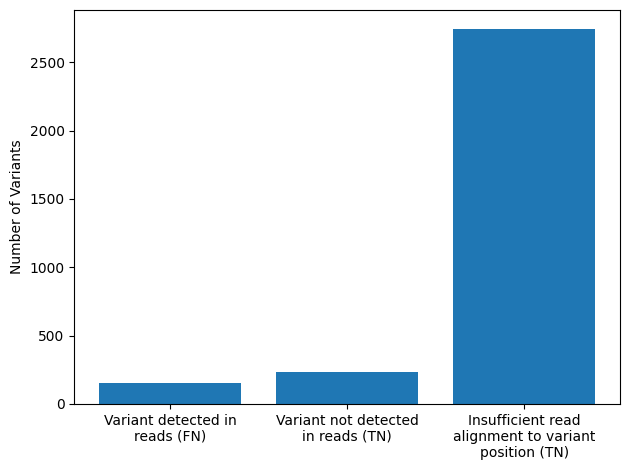

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"))

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                                  | 0/25080 [00:00<?, ?it/s]

 21%|████████████████████████▎                                                                                           | 5257/25080 [00:00<00:00, 50012.83it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 10259/25080 [00:01<00:01, 8283.68it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 12621/25080 [00:01<00:01, 9570.66it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 14801/25080 [00:01<00:00, 10864.16it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 16695/25080 [00:01<00:00, 11211.04it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 18353/25080 [00:02<00:00, 6965.39it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 19555/25080 [00:02<00:01, 3759.35it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 20407/25080 [00:03<00:01, 3613.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21377/25080 [00:03<00:00, 4044.35it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 22068/25080 [00:03<00:00, 4298.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 23081/25080 [00:03<00:00, 5092.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 23850/25080 [00:03<00:00, 3778.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24447/25080 [00:04<00:00, 2625.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24953/25080 [00:04<00:00, 2691.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25080/25080 [00:04<00:00, 5215.85it/s]

Variants in vcrs_reference: 156
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000361923:c.3205A>G',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000289893:c.6506G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000371088:c.1031T>C',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000256652:c.1822C>A',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000367079:c.619C>T',
 'ENST00000367057:c.2176T>C',
 'ENST00000367057:c.2201G>A',
 'ENST00000238181:c.457C>T',
 'ENST00000486442:c.1197T>C',
 'ENST00000425361:c.39G>A',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000361923:c.3205A>G


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAATCCATCCCATCCTACTGCCAGCGCTCTGTCCACGGGATCGCCTCCCATGAAGAATCCATCCCATCCTACTG
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCCGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCC
CGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000390319:c.385C>T


TGGATGAGGCTGACTATTACTGTCAGGCGTGGGACAGTAGCACTGCACACA
TGTGTGCAGTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                               | 0/30247010 [00:00<?, ?it/s]

  0%|                                                                                                                 | 2865/30247010 [00:00<17:37, 28589.36it/s]

  0%|                                                                                                                 | 6422/30247010 [00:00<15:25, 32666.97it/s]

  0%|                                                                                                                | 10118/30247010 [00:00<14:33, 34608.81it/s]

  0%|                                                                                                                | 14363/30247010 [00:00<13:59, 36032.08it/s]

  0%|                                                                                                                | 18793/30247010 [00:00<12:56, 38920.26it/s]

  0%|                                                                                                                | 22688/30247010 [00:00<13:03, 38581.48it/s]

  0%|                                                                                                                | 26549/30247010 [00:00<13:05, 38487.22it/s]

  0%|                                                                                                                | 31671/30247010 [00:00<11:51, 42473.11it/s]

  0%|▏                                                                                                               | 37738/30247010 [00:00<10:28, 48094.23it/s]

  0%|▏                                                                                                               | 42886/30247010 [00:01<10:14, 49117.63it/s]

  0%|▏                                                                                                               | 49139/30247010 [00:01<09:27, 53190.94it/s]

  0%|▏                                                                                                               | 55233/30247010 [00:01<09:03, 55532.33it/s]

  0%|▏                                                                                                               | 61615/30247010 [00:01<08:40, 58024.94it/s]

  0%|▎                                                                                                               | 67670/30247010 [00:01<08:33, 58771.83it/s]

  0%|▎                                                                                                               | 74568/30247010 [00:01<08:07, 61832.05it/s]

  0%|▎                                                                                                               | 80916/30247010 [00:01<08:04, 62285.47it/s]

  0%|▎                                                                                                               | 87984/30247010 [00:01<07:45, 64794.74it/s]

  0%|▎                                                                                                               | 95178/30247010 [00:01<07:45, 64827.81it/s]

  0%|▍                                                                                                              | 102310/30247010 [00:01<07:31, 66707.47it/s]

  0%|▍                                                                                                              | 109397/30247010 [00:02<07:38, 65712.09it/s]

  0%|▍                                                                                                              | 116662/30247010 [00:02<07:24, 67716.40it/s]

  0%|▍                                                                                                              | 123594/30247010 [00:02<07:32, 66563.62it/s]

  0%|▍                                                                                                              | 130689/30247010 [00:02<07:24, 67828.36it/s]

  0%|▌                                                                                                              | 137561/30247010 [00:02<07:22, 68078.47it/s]

  0%|▌                                                                                                              | 144379/30247010 [00:02<07:34, 66210.13it/s]

  1%|▌                                                                                                              | 151484/30247010 [00:02<07:25, 67607.78it/s]

  1%|▌                                                                                                              | 158261/30247010 [00:02<07:32, 66517.75it/s]

  1%|▌                                                                                                              | 165689/30247010 [00:02<07:17, 68770.29it/s]

  1%|▋                                                                                                              | 172582/30247010 [00:02<07:27, 67209.47it/s]

  1%|▋                                                                                                              | 180046/30247010 [00:03<07:13, 69363.64it/s]

  1%|▋                                                                                                              | 187001/30247010 [00:03<07:24, 67644.62it/s]

  1%|▋                                                                                                              | 194345/30247010 [00:03<07:29, 66909.56it/s]

  1%|▋                                                                                                              | 201508/30247010 [00:03<07:20, 68249.43it/s]

  1%|▊                                                                                                              | 208478/30247010 [00:03<07:31, 66462.23it/s]

  1%|▊                                                                                                              | 215893/30247010 [00:03<07:17, 68654.33it/s]

  1%|▊                                                                                                              | 222784/30247010 [00:03<07:27, 67123.98it/s]

  1%|▊                                                                                                              | 229942/30247010 [00:03<07:18, 68392.77it/s]

  1%|▊                                                                                                              | 236801/30247010 [00:03<07:25, 67382.56it/s]

  1%|▉                                                                                                              | 243836/30247010 [00:04<07:19, 68237.27it/s]

  1%|▉                                                                                                              | 250878/30247010 [00:04<07:25, 67317.15it/s]

  1%|▉                                                                                                              | 258344/30247010 [00:04<07:11, 69445.17it/s]

  1%|▉                                                                                                              | 265304/30247010 [00:04<07:17, 68561.05it/s]

  1%|█                                                                                                              | 272724/30247010 [00:04<07:06, 70200.82it/s]

  1%|█                                                                                                              | 279757/30247010 [00:04<07:18, 68318.55it/s]

  1%|█                                                                                                              | 287232/30247010 [00:04<07:07, 70149.47it/s]

  1%|█                                                                                                              | 294265/30247010 [00:04<07:17, 68423.06it/s]

  1%|█                                                                                                              | 301565/30247010 [00:04<07:09, 69740.68it/s]

  1%|█▏                                                                                                             | 308557/30247010 [00:04<07:25, 67271.36it/s]

  1%|█▏                                                                                                             | 315611/30247010 [00:05<07:18, 68191.32it/s]

  1%|█▏                                                                                                             | 322453/30247010 [00:05<07:23, 67413.78it/s]

  1%|█▏                                                                                                             | 329831/30247010 [00:05<07:12, 69246.15it/s]

  1%|█▏                                                                                                             | 336773/30247010 [00:05<07:17, 68335.97it/s]

  1%|█▎                                                                                                             | 343800/30247010 [00:05<07:14, 68871.62it/s]

  1%|█▎                                                                                                             | 350698/30247010 [00:05<07:19, 68071.49it/s]

  1%|█▎                                                                                                             | 357944/30247010 [00:05<07:10, 69354.46it/s]

  1%|█▎                                                                                                             | 364888/30247010 [00:05<07:22, 67509.22it/s]

  1%|█▎                                                                                                             | 372101/30247010 [00:05<07:13, 68843.73it/s]

  1%|█▍                                                                                                             | 379000/30247010 [00:05<07:23, 67288.30it/s]

  1%|█▍                                                                                                             | 386269/30247010 [00:06<07:13, 68850.55it/s]

  1%|█▍                                                                                                             | 393170/30247010 [00:06<07:23, 67389.18it/s]

  1%|█▍                                                                                                             | 400258/30247010 [00:06<07:16, 68392.62it/s]

  1%|█▍                                                                                                             | 407111/30247010 [00:06<07:25, 67036.30it/s]

  1%|█▌                                                                                                             | 414276/30247010 [00:06<07:16, 68373.60it/s]

  1%|█▌                                                                                                             | 421127/30247010 [00:06<07:27, 66713.22it/s]

  1%|█▌                                                                                                             | 428598/30247010 [00:06<07:12, 69020.27it/s]

  1%|█▌                                                                                                             | 435519/30247010 [00:06<07:23, 67268.38it/s]

  1%|█▌                                                                                                             | 442487/30247010 [00:06<07:18, 67954.69it/s]

  1%|█▋                                                                                                             | 449415/30247010 [00:07<07:26, 66807.76it/s]

  2%|█▋                                                                                                             | 456315/30247010 [00:07<07:21, 67435.22it/s]

  2%|█▋                                                                                                             | 463549/30247010 [00:07<07:25, 66805.61it/s]

  2%|█▋                                                                                                             | 470459/30247010 [00:07<07:21, 67454.37it/s]

  2%|█▊                                                                                                             | 477500/30247010 [00:07<07:15, 68307.59it/s]

  2%|█▊                                                                                                             | 484341/30247010 [00:07<07:29, 66255.05it/s]

  2%|█▊                                                                                                             | 491309/30247010 [00:07<07:22, 67171.93it/s]

  2%|█▊                                                                                                             | 498042/30247010 [00:07<07:32, 65780.61it/s]

  2%|█▊                                                                                                             | 504759/30247010 [00:07<07:29, 66172.71it/s]

  2%|█▉                                                                                                             | 511388/30247010 [00:07<07:40, 64581.56it/s]

  2%|█▉                                                                                                             | 518569/30247010 [00:08<07:25, 66667.68it/s]

  2%|█▉                                                                                                             | 525253/30247010 [00:08<07:33, 65554.52it/s]

  2%|█▉                                                                                                             | 532586/30247010 [00:08<07:18, 67789.52it/s]

  2%|█▉                                                                                                             | 539381/30247010 [00:08<07:27, 66356.39it/s]

  2%|██                                                                                                             | 546758/30247010 [00:08<07:13, 68506.95it/s]

  2%|██                                                                                                             | 553626/30247010 [00:08<08:53, 55697.25it/s]

  2%|██                                                                                                             | 559587/30247010 [00:08<09:46, 50613.93it/s]

  2%|██                                                                                                             | 564975/30247010 [00:08<10:25, 47430.19it/s]

  2%|██                                                                                                             | 569950/30247010 [00:09<11:01, 44835.77it/s]

  2%|██                                                                                                             | 574591/30247010 [00:09<11:28, 43125.91it/s]

  2%|██▏                                                                                                            | 579080/30247010 [00:09<11:21, 43560.36it/s]

  2%|██▏                                                                                                            | 585046/30247010 [00:09<10:20, 47779.16it/s]

  2%|██▏                                                                                                            | 590894/30247010 [00:09<10:02, 49219.28it/s]

  2%|██▏                                                                                                            | 596938/30247010 [00:09<09:26, 52302.18it/s]

  2%|██▏                                                                                                            | 603166/30247010 [00:09<08:57, 55106.11it/s]

  2%|██▏                                                                                                            | 609574/30247010 [00:09<08:33, 57671.02it/s]

  2%|██▎                                                                                                            | 615750/30247010 [00:09<08:23, 58829.17it/s]

  2%|██▎                                                                                                            | 622671/30247010 [00:10<07:58, 61866.27it/s]

  2%|██▎                                                                                                            | 628899/30247010 [00:10<08:02, 61418.83it/s]

  2%|██▎                                                                                                            | 636411/30247010 [00:10<07:32, 65447.50it/s]

  2%|██▎                                                                                                            | 642984/30247010 [00:10<07:34, 65117.16it/s]

  2%|██▍                                                                                                            | 650285/30247010 [00:10<07:18, 67440.49it/s]

  2%|██▍                                                                                                            | 657145/30247010 [00:10<07:27, 66061.65it/s]

  2%|██▍                                                                                                            | 664191/30247010 [00:10<07:19, 67328.10it/s]

  2%|██▍                                                                                                            | 671263/30247010 [00:10<07:12, 68320.04it/s]

  2%|██▍                                                                                                            | 678108/30247010 [00:10<07:22, 66803.31it/s]

  2%|██▌                                                                                                            | 685365/30247010 [00:10<07:11, 68477.74it/s]

  2%|██▌                                                                                                            | 692228/30247010 [00:11<07:18, 67445.08it/s]

  2%|██▌                                                                                                            | 699719/30247010 [00:11<07:04, 69615.15it/s]

  2%|██▌                                                                                                            | 706695/30247010 [00:11<07:12, 68358.14it/s]

  2%|██▌                                                                                                            | 713933/30247010 [00:11<07:14, 67981.44it/s]

  2%|██▋                                                                                                            | 721222/30247010 [00:11<07:05, 69396.48it/s]

  2%|██▋                                                                                                            | 728174/30247010 [00:11<07:09, 68694.47it/s]

  2%|██▋                                                                                                            | 735868/30247010 [00:11<06:55, 71098.82it/s]

  2%|██▋                                                                                                            | 742990/30247010 [00:11<07:07, 69049.34it/s]

  2%|██▊                                                                                                            | 750431/30247010 [00:11<06:58, 70472.71it/s]

  3%|██▊                                                                                                            | 757496/30247010 [00:11<07:08, 68742.81it/s]

  3%|██▊                                                                                                            | 764673/30247010 [00:12<07:03, 69594.92it/s]

  3%|██▊                                                                                                            | 771648/30247010 [00:12<07:13, 67961.25it/s]

  3%|██▊                                                                                                            | 778460/30247010 [00:12<07:53, 62236.08it/s]

  3%|██▉                                                                                                            | 784964/30247010 [00:12<07:47, 62970.57it/s]

  3%|██▉                                                                                                            | 792219/30247010 [00:12<07:28, 65660.52it/s]

  3%|██▉                                                                                                            | 798853/30247010 [00:12<07:31, 65236.37it/s]

  3%|██▉                                                                                                            | 806150/30247010 [00:12<07:16, 67453.34it/s]

  3%|██▉                                                                                                            | 812937/30247010 [00:12<07:17, 67306.43it/s]

  3%|███                                                                                                            | 820040/30247010 [00:12<07:10, 68387.54it/s]

  3%|███                                                                                                            | 827028/30247010 [00:13<07:20, 66820.66it/s]

  3%|███                                                                                                            | 834532/30247010 [00:13<07:05, 69200.89it/s]

  3%|███                                                                                                            | 841477/30247010 [00:13<07:12, 67958.43it/s]

  3%|███                                                                                                            | 848990/30247010 [00:13<06:59, 70016.95it/s]

  3%|███▏                                                                                                           | 856012/30247010 [00:13<07:05, 69106.65it/s]

  3%|███▏                                                                                                           | 863390/30247010 [00:13<06:57, 70461.74it/s]

  3%|███▏                                                                                                           | 870450/30247010 [00:13<07:00, 69801.07it/s]

  3%|███▏                                                                                                           | 877849/30247010 [00:13<06:53, 71024.12it/s]

  3%|███▏                                                                                                           | 884961/30247010 [00:13<07:06, 68903.35it/s]

  3%|███▎                                                                                                           | 891870/30247010 [00:13<07:40, 63802.73it/s]

  3%|███▎                                                                                                           | 898328/30247010 [00:14<08:06, 60343.98it/s]

  3%|███▎                                                                                                           | 905777/30247010 [00:14<07:37, 64184.79it/s]

  3%|███▎                                                                                                           | 912407/30247010 [00:14<07:32, 64769.42it/s]

  3%|███▎                                                                                                           | 919532/30247010 [00:14<07:20, 66602.72it/s]

  3%|███▍                                                                                                           | 926250/30247010 [00:14<07:26, 65717.13it/s]

  3%|███▍                                                                                                           | 933389/30247010 [00:14<07:15, 67352.70it/s]

  3%|███▍                                                                                                           | 940408/30247010 [00:14<07:16, 67176.62it/s]

  3%|███▍                                                                                                           | 947611/30247010 [00:14<07:07, 68575.60it/s]

  3%|███▌                                                                                                           | 954490/30247010 [00:14<07:10, 68022.19it/s]

  3%|███▌                                                                                                           | 961307/30247010 [00:15<07:21, 66367.61it/s]

  3%|███▌                                                                                                           | 968474/30247010 [00:15<07:11, 67895.11it/s]

  3%|███▌                                                                                                           | 975280/30247010 [00:15<07:18, 66732.90it/s]

  3%|███▌                                                                                                           | 982797/30247010 [00:15<07:03, 69177.52it/s]

  3%|███▋                                                                                                           | 989732/30247010 [00:15<07:07, 68490.50it/s]

  3%|███▋                                                                                                           | 996988/30247010 [00:15<06:59, 69675.59it/s]

  3%|███▋                                                                                                          | 1003967/30247010 [00:15<07:07, 68409.24it/s]

  3%|███▋                                                                                                          | 1011205/30247010 [00:15<07:00, 69533.28it/s]

  3%|███▋                                                                                                          | 1018169/30247010 [00:15<07:03, 68950.07it/s]

  3%|███▋                                                                                                          | 1025257/30247010 [00:15<07:00, 69482.89it/s]

  3%|███▊                                                                                                          | 1032212/30247010 [00:16<07:06, 68529.30it/s]

  3%|███▊                                                                                                          | 1039607/30247010 [00:16<07:11, 67736.07it/s]

  3%|███▊                                                                                                          | 1046770/30247010 [00:16<07:06, 68433.33it/s]

  3%|███▊                                                                                                          | 1053694/30247010 [00:16<07:16, 66940.92it/s]

  4%|███▊                                                                                                          | 1060833/30247010 [00:16<07:07, 68214.10it/s]

  4%|███▉                                                                                                          | 1067764/30247010 [00:16<07:21, 66129.62it/s]

  4%|███▉                                                                                                          | 1074925/30247010 [00:16<07:10, 67695.81it/s]

  4%|███▉                                                                                                          | 1081716/30247010 [00:16<07:16, 66787.29it/s]

  4%|███▉                                                                                                          | 1088410/30247010 [00:16<07:18, 66482.88it/s]

  4%|███▉                                                                                                          | 1095451/30247010 [00:16<07:11, 67619.23it/s]

  4%|████                                                                                                          | 1102223/30247010 [00:17<07:19, 66347.51it/s]

  4%|████                                                                                                          | 1109714/30247010 [00:17<07:03, 68839.29it/s]

  4%|████                                                                                                          | 1116612/30247010 [00:17<07:08, 68044.40it/s]

  4%|████                                                                                                          | 1124038/30247010 [00:17<06:56, 69846.19it/s]

  4%|████                                                                                                          | 1131034/30247010 [00:17<07:06, 68249.76it/s]

  4%|████▏                                                                                                         | 1138114/30247010 [00:17<07:06, 68196.58it/s]

  4%|████▏                                                                                                         | 1145281/30247010 [00:17<07:00, 69194.51it/s]

  4%|████▏                                                                                                         | 1152210/30247010 [00:17<07:04, 68516.49it/s]

  4%|████▏                                                                                                         | 1159678/30247010 [00:17<06:53, 70320.22it/s]

  4%|████▏                                                                                                         | 1166719/30247010 [00:18<07:04, 68556.57it/s]

  4%|████▎                                                                                                         | 1173589/30247010 [00:18<08:20, 58094.11it/s]

  4%|████▎                                                                                                         | 1179670/30247010 [00:18<09:17, 52135.04it/s]

  4%|████▎                                                                                                         | 1185151/30247010 [00:18<10:20, 46806.49it/s]

  4%|████▎                                                                                                         | 1190073/30247010 [00:18<10:54, 44380.06it/s]

  4%|████▎                                                                                                         | 1194669/30247010 [00:18<11:16, 42972.80it/s]

  4%|████▎                                                                                                         | 1200131/30247010 [00:18<10:33, 45874.44it/s]

  4%|████▍                                                                                                         | 1206200/30247010 [00:18<09:43, 49762.08it/s]

  4%|████▍                                                                                                         | 1212071/30247010 [00:19<09:16, 52171.71it/s]

  4%|████▍                                                                                                         | 1217897/30247010 [00:19<09:12, 52562.03it/s]

  4%|████▍                                                                                                         | 1223899/30247010 [00:19<08:51, 54635.67it/s]

  4%|████▍                                                                                                         | 1231138/30247010 [00:19<08:05, 59714.74it/s]

  4%|████▍                                                                                                         | 1237337/30247010 [00:19<08:00, 60367.34it/s]

  4%|████▌                                                                                                         | 1244463/30247010 [00:19<07:36, 63522.23it/s]

  4%|████▌                                                                                                         | 1250907/30247010 [00:19<07:42, 62695.87it/s]

  4%|████▌                                                                                                         | 1258188/30247010 [00:19<07:21, 65643.50it/s]

  4%|████▌                                                                                                         | 1265040/30247010 [00:19<07:20, 65741.57it/s]

  4%|████▋                                                                                                         | 1272227/30247010 [00:19<07:09, 67530.67it/s]

  4%|████▋                                                                                                         | 1279173/30247010 [00:20<07:15, 66543.64it/s]

  4%|████▋                                                                                                         | 1286308/30247010 [00:20<07:06, 67937.87it/s]

  4%|████▋                                                                                                         | 1293277/30247010 [00:20<07:03, 68438.92it/s]

  4%|████▋                                                                                                         | 1300133/30247010 [00:20<07:10, 67245.64it/s]

  4%|████▊                                                                                                         | 1307440/30247010 [00:20<07:13, 66764.41it/s]

  4%|████▊                                                                                                         | 1314582/30247010 [00:20<07:04, 68096.29it/s]

  4%|████▊                                                                                                         | 1321573/30247010 [00:20<07:14, 66531.33it/s]

  4%|████▊                                                                                                         | 1328685/30247010 [00:20<07:06, 67795.57it/s]

  4%|████▊                                                                                                         | 1335706/30247010 [00:20<07:10, 67090.01it/s]

  4%|████▉                                                                                                         | 1342767/30247010 [00:21<07:04, 68100.69it/s]

  4%|████▉                                                                                                         | 1349839/30247010 [00:21<07:11, 66941.23it/s]

  4%|████▉                                                                                                         | 1356962/30247010 [00:21<07:04, 68068.76it/s]

  5%|████▉                                                                                                         | 1363972/30247010 [00:21<07:11, 66946.84it/s]

  5%|████▉                                                                                                         | 1371064/30247010 [00:21<07:04, 68062.25it/s]

  5%|█████                                                                                                         | 1377891/30247010 [00:21<07:03, 68117.27it/s]

  5%|█████                                                                                                         | 1384712/30247010 [00:21<07:07, 67582.62it/s]

  5%|█████                                                                                                         | 1391915/30247010 [00:21<06:58, 68879.87it/s]

  5%|█████                                                                                                         | 1398810/30247010 [00:21<07:06, 67681.67it/s]

  5%|█████                                                                                                         | 1406249/30247010 [00:21<07:04, 68019.76it/s]

  5%|█████▏                                                                                                        | 1413639/30247010 [00:22<06:53, 69717.49it/s]

  5%|█████▏                                                                                                        | 1420620/30247010 [00:22<06:56, 69147.82it/s]

  5%|█████▏                                                                                                        | 1428213/30247010 [00:22<06:45, 71113.03it/s]

  5%|█████▏                                                                                                        | 1435333/30247010 [00:22<06:55, 69342.62it/s]

  5%|█████▏                                                                                                        | 1442750/30247010 [00:22<06:47, 70736.25it/s]

  5%|█████▎                                                                                                        | 1449837/30247010 [00:22<08:26, 56833.24it/s]

  5%|█████▎                                                                                                        | 1455957/30247010 [00:22<09:20, 51384.52it/s]

  5%|█████▎                                                                                                        | 1461461/30247010 [00:22<09:59, 48051.99it/s]

  5%|█████▎                                                                                                        | 1466526/30247010 [00:23<10:32, 45493.05it/s]

  5%|█████▎                                                                                                        | 1471249/30247010 [00:23<10:58, 43707.79it/s]

  5%|█████▎                                                                                                        | 1475729/30247010 [00:23<11:08, 43047.69it/s]

  5%|█████▍                                                                                                        | 1481288/30247010 [00:23<10:30, 45589.86it/s]

  5%|█████▍                                                                                                        | 1487565/30247010 [00:23<09:33, 50157.94it/s]

  5%|█████▍                                                                                                        | 1493965/30247010 [00:23<08:52, 53966.43it/s]

  5%|█████▍                                                                                                        | 1499924/30247010 [00:23<08:37, 55546.60it/s]

  5%|█████▍                                                                                                        | 1505566/30247010 [00:23<08:41, 55074.84it/s]

  5%|█████▌                                                                                                        | 1512695/30247010 [00:23<08:00, 59739.41it/s]

  5%|█████▌                                                                                                        | 1518864/30247010 [00:23<07:56, 60298.56it/s]

  5%|█████▌                                                                                                        | 1526069/30247010 [00:24<07:30, 63743.21it/s]

  5%|█████▌                                                                                                        | 1532879/30247010 [00:24<07:32, 63467.47it/s]

  5%|█████▌                                                                                                        | 1540069/30247010 [00:24<07:15, 65900.21it/s]

  5%|█████▋                                                                                                        | 1546948/30247010 [00:24<07:18, 65478.67it/s]

  5%|█████▋                                                                                                        | 1554417/30247010 [00:24<07:00, 68162.41it/s]

  5%|█████▋                                                                                                        | 1561254/30247010 [00:24<07:07, 67108.41it/s]

  5%|█████▋                                                                                                        | 1568726/30247010 [00:24<06:53, 69324.31it/s]

  5%|█████▋                                                                                                        | 1575676/30247010 [00:24<06:59, 68380.16it/s]

  5%|█████▊                                                                                                        | 1582961/30247010 [00:24<06:51, 69659.67it/s]

  5%|█████▊                                                                                                        | 1589940/30247010 [00:25<06:58, 68500.96it/s]

  5%|█████▊                                                                                                        | 1597240/30247010 [00:25<06:50, 69811.27it/s]

  5%|█████▊                                                                                                        | 1604233/30247010 [00:25<06:56, 68767.72it/s]

  5%|█████▊                                                                                                        | 1611347/30247010 [00:25<06:52, 69456.97it/s]

  5%|█████▉                                                                                                        | 1618302/30247010 [00:25<06:58, 68338.98it/s]

  5%|█████▉                                                                                                        | 1625900/30247010 [00:25<06:45, 70559.16it/s]

  5%|█████▉                                                                                                        | 1632967/30247010 [00:25<06:52, 69303.26it/s]

  5%|█████▉                                                                                                        | 1640427/30247010 [00:25<06:43, 70834.95it/s]

  5%|█████▉                                                                                                        | 1647522/30247010 [00:25<06:47, 70163.94it/s]

  5%|██████                                                                                                        | 1654790/30247010 [00:25<06:43, 70884.16it/s]

  5%|██████                                                                                                        | 1661886/30247010 [00:26<06:53, 69199.99it/s]

  6%|██████                                                                                                        | 1669085/30247010 [00:26<06:48, 70002.50it/s]

  6%|██████                                                                                                        | 1676096/30247010 [00:26<06:59, 68092.78it/s]

  6%|██████                                                                                                        | 1683096/30247010 [00:26<06:56, 68608.03it/s]

  6%|██████▏                                                                                                       | 1689970/30247010 [00:26<07:02, 67612.09it/s]

  6%|██████▏                                                                                                       | 1697626/30247010 [00:26<06:46, 70214.69it/s]

  6%|██████▏                                                                                                       | 1704662/30247010 [00:26<06:51, 69296.74it/s]

  6%|██████▏                                                                                                       | 1711863/30247010 [00:26<06:58, 68234.38it/s]

  6%|██████▎                                                                                                       | 1719374/30247010 [00:26<06:46, 70217.16it/s]

  6%|██████▎                                                                                                       | 1726412/30247010 [00:26<07:03, 67368.75it/s]

  6%|██████▎                                                                                                       | 1733179/30247010 [00:27<07:03, 67406.18it/s]

  6%|██████▎                                                                                                       | 1740080/30247010 [00:27<07:11, 66019.33it/s]

  6%|██████▎                                                                                                       | 1747396/30247010 [00:27<06:58, 68056.81it/s]

  6%|██████▍                                                                                                       | 1754224/30247010 [00:27<07:06, 66767.00it/s]

  6%|██████▍                                                                                                       | 1761467/30247010 [00:27<06:56, 68395.07it/s]

  6%|██████▍                                                                                                       | 1768325/30247010 [00:27<06:59, 67944.49it/s]

  6%|██████▍                                                                                                       | 1775645/30247010 [00:27<06:49, 69475.86it/s]

  6%|██████▍                                                                                                       | 1782605/30247010 [00:27<07:00, 67617.50it/s]

  6%|██████▌                                                                                                       | 1790140/30247010 [00:27<06:47, 69860.42it/s]

  6%|██████▌                                                                                                       | 1797145/30247010 [00:28<06:56, 68313.74it/s]

  6%|██████▌                                                                                                       | 1804595/30247010 [00:28<06:45, 70101.49it/s]

  6%|██████▌                                                                                                       | 1811624/30247010 [00:28<06:48, 69536.15it/s]

  6%|██████▌                                                                                                       | 1818727/30247010 [00:28<06:46, 69964.82it/s]

  6%|██████▋                                                                                                       | 1825734/30247010 [00:28<06:54, 68646.87it/s]

  6%|██████▋                                                                                                       | 1833042/30247010 [00:28<06:46, 69931.48it/s]

  6%|██████▋                                                                                                       | 1840046/30247010 [00:28<06:53, 68620.74it/s]

  6%|██████▋                                                                                                       | 1847537/30247010 [00:28<06:43, 70450.28it/s]

  6%|██████▋                                                                                                       | 1854595/30247010 [00:28<06:48, 69585.80it/s]

  6%|██████▊                                                                                                       | 1862021/30247010 [00:28<06:52, 68767.70it/s]

  6%|██████▊                                                                                                       | 1869121/30247010 [00:29<06:48, 69401.08it/s]

  6%|██████▊                                                                                                       | 1876092/30247010 [00:29<06:58, 67847.66it/s]

  6%|██████▊                                                                                                       | 1883264/30247010 [00:29<06:51, 68931.23it/s]

  6%|██████▊                                                                                                       | 1890169/30247010 [00:29<06:54, 68492.60it/s]

  6%|██████▉                                                                                                       | 1897470/30247010 [00:29<06:46, 69803.69it/s]

  6%|██████▉                                                                                                       | 1904459/30247010 [00:29<06:55, 68282.10it/s]

  6%|██████▉                                                                                                       | 1911896/30247010 [00:29<06:44, 70050.06it/s]

  6%|██████▉                                                                                                       | 1918914/30247010 [00:29<06:51, 68782.13it/s]

  6%|███████                                                                                                       | 1926313/30247010 [00:29<06:42, 70296.99it/s]

  6%|███████                                                                                                       | 1933356/30247010 [00:29<06:50, 68956.55it/s]

  6%|███████                                                                                                       | 1940748/30247010 [00:30<06:42, 70399.26it/s]

  6%|███████                                                                                                       | 1947801/30247010 [00:30<06:49, 69099.01it/s]

  6%|███████                                                                                                       | 1955328/30247010 [00:30<06:39, 70893.03it/s]

  6%|███████▏                                                                                                      | 1962431/30247010 [00:30<06:48, 69170.06it/s]

  7%|███████▏                                                                                                      | 1969580/30247010 [00:30<06:45, 69793.55it/s]

  7%|███████▏                                                                                                      | 1976573/30247010 [00:30<06:52, 68592.69it/s]

  7%|███████▏                                                                                                      | 1983657/30247010 [00:30<06:48, 69230.97it/s]

  7%|███████▏                                                                                                      | 1990590/30247010 [00:30<06:54, 68094.93it/s]

  7%|███████▎                                                                                                      | 1997880/30247010 [00:30<06:46, 69470.35it/s]

  7%|███████▎                                                                                                      | 2004837/30247010 [00:31<06:55, 68028.56it/s]

  7%|███████▎                                                                                                      | 2012174/30247010 [00:31<06:45, 69572.71it/s]

  7%|███████▎                                                                                                      | 2019144/30247010 [00:31<06:51, 68544.91it/s]

  7%|███████▎                                                                                                      | 2026485/30247010 [00:31<06:43, 69959.33it/s]

  7%|███████▍                                                                                                      | 2033492/30247010 [00:31<06:49, 68905.02it/s]

  7%|███████▍                                                                                                      | 2040634/30247010 [00:31<06:45, 69627.94it/s]

  7%|███████▍                                                                                                      | 2047606/30247010 [00:31<06:50, 68684.38it/s]

  7%|███████▍                                                                                                      | 2054950/30247010 [00:31<06:42, 70070.70it/s]

  7%|███████▍                                                                                                      | 2061966/30247010 [00:31<06:49, 68841.31it/s]

  7%|███████▌                                                                                                      | 2069143/30247010 [00:31<06:57, 67486.16it/s]

  7%|███████▌                                                                                                      | 2076195/30247010 [00:32<06:52, 68353.64it/s]

  7%|███████▌                                                                                                      | 2083277/30247010 [00:32<07:00, 66913.93it/s]

  7%|███████▌                                                                                                      | 2089984/30247010 [00:32<08:06, 57899.21it/s]

  7%|███████▋                                                                                                      | 2096973/30247010 [00:32<07:41, 61010.67it/s]

  7%|███████▋                                                                                                      | 2103264/30247010 [00:32<07:40, 61053.19it/s]

  7%|███████▋                                                                                                      | 2110658/30247010 [00:32<07:15, 64620.48it/s]

  7%|███████▋                                                                                                      | 2117241/30247010 [00:32<07:14, 64697.81it/s]

  7%|███████▋                                                                                                      | 2124229/30247010 [00:32<07:04, 66183.28it/s]

  7%|███████▋                                                                                                      | 2130913/30247010 [00:32<07:08, 65580.89it/s]

  7%|███████▊                                                                                                      | 2138123/30247010 [00:33<06:56, 67445.61it/s]

  7%|███████▊                                                                                                      | 2144905/30247010 [00:33<07:01, 66598.85it/s]

  7%|███████▊                                                                                                      | 2152114/30247010 [00:33<06:52, 68181.71it/s]

  7%|███████▊                                                                                                      | 2158955/30247010 [00:33<06:59, 66957.80it/s]

  7%|███████▉                                                                                                      | 2166357/30247010 [00:33<06:46, 69015.61it/s]

  7%|███████▉                                                                                                      | 2173278/30247010 [00:33<06:53, 67833.87it/s]

  7%|███████▉                                                                                                      | 2180505/30247010 [00:33<06:46, 69103.39it/s]

  7%|███████▉                                                                                                      | 2187430/30247010 [00:33<06:53, 67919.32it/s]

  7%|███████▉                                                                                                      | 2194622/30247010 [00:33<06:46, 69080.76it/s]

  7%|████████                                                                                                      | 2201542/30247010 [00:33<06:52, 67908.14it/s]

  7%|████████                                                                                                      | 2208867/30247010 [00:34<06:43, 69457.25it/s]

  7%|████████                                                                                                      | 2215825/30247010 [00:34<06:53, 67820.83it/s]

  7%|████████                                                                                                      | 2222622/30247010 [00:34<07:06, 65758.67it/s]

  7%|████████                                                                                                      | 2229217/30247010 [00:34<07:14, 64539.30it/s]

  7%|████████▏                                                                                                     | 2236244/30247010 [00:34<07:03, 66173.10it/s]

  7%|████████▏                                                                                                     | 2242879/30247010 [00:34<07:05, 65792.89it/s]

  7%|████████▏                                                                                                     | 2250042/30247010 [00:34<06:54, 67482.05it/s]

  7%|████████▏                                                                                                     | 2256811/30247010 [00:34<07:05, 65776.04it/s]

  7%|████████▏                                                                                                     | 2263781/30247010 [00:34<06:58, 66905.91it/s]

  8%|████████▎                                                                                                     | 2270990/30247010 [00:35<07:00, 66573.96it/s]

  8%|████████▎                                                                                                     | 2277992/30247010 [00:35<06:53, 67565.35it/s]

  8%|████████▎                                                                                                     | 2285134/30247010 [00:35<06:58, 66771.91it/s]

  8%|████████▎                                                                                                     | 2291981/30247010 [00:35<06:55, 67235.56it/s]

  8%|████████▎                                                                                                     | 2299205/30247010 [00:35<06:46, 68691.16it/s]

  8%|████████▍                                                                                                     | 2306085/30247010 [00:35<06:58, 66742.94it/s]

  8%|████████▍                                                                                                     | 2313212/30247010 [00:35<06:51, 67892.57it/s]

  8%|████████▍                                                                                                     | 2320017/30247010 [00:35<06:57, 66907.05it/s]

  8%|████████▍                                                                                                     | 2327448/30247010 [00:35<06:44, 69056.04it/s]

  8%|████████▍                                                                                                     | 2334368/30247010 [00:35<06:53, 67475.89it/s]

  8%|████████▌                                                                                                     | 2341131/30247010 [00:36<07:00, 66370.09it/s]

  8%|████████▌                                                                                                     | 2347780/30247010 [00:36<07:06, 65429.37it/s]

  8%|████████▌                                                                                                     | 2355033/30247010 [00:36<06:53, 67478.88it/s]

  8%|████████▌                                                                                                     | 2361794/30247010 [00:36<07:43, 60105.65it/s]

  8%|████████▌                                                                                                     | 2367954/30247010 [00:36<07:56, 58477.62it/s]

  8%|████████▋                                                                                                     | 2373986/30247010 [00:36<07:52, 58962.77it/s]

  8%|████████▋                                                                                                     | 2379959/30247010 [00:36<07:53, 58830.24it/s]

  8%|████████▋                                                                                                     | 2387047/30247010 [00:36<07:27, 62251.24it/s]

  8%|████████▋                                                                                                     | 2394320/30247010 [00:36<07:06, 65269.85it/s]

  8%|████████▋                                                                                                     | 2402375/30247010 [00:37<06:39, 69726.80it/s]

  8%|████████▊                                                                                                     | 2409672/30247010 [00:37<06:33, 70660.10it/s]

  8%|████████▊                                                                                                     | 2417046/30247010 [00:37<06:31, 71125.22it/s]

  8%|████████▊                                                                                                     | 2424784/30247010 [00:37<06:24, 72306.39it/s]

  8%|████████▊                                                                                                     | 2432300/30247010 [00:37<06:20, 73119.85it/s]

  8%|████████▊                                                                                                     | 2440337/30247010 [00:37<06:09, 75254.56it/s]

  8%|████████▉                                                                                                     | 2447874/30247010 [00:37<06:11, 74777.15it/s]

  8%|████████▉                                                                                                     | 2455360/30247010 [00:37<06:13, 74392.00it/s]

  8%|████████▉                                                                                                     | 2463465/30247010 [00:37<06:03, 76360.43it/s]

  8%|████████▉                                                                                                     | 2471108/30247010 [00:37<06:07, 75668.12it/s]

  8%|█████████                                                                                                     | 2478681/30247010 [00:38<06:12, 74636.62it/s]

  8%|█████████                                                                                                     | 2486679/30247010 [00:38<06:04, 76198.65it/s]

  8%|█████████                                                                                                     | 2494306/30247010 [00:38<06:04, 76112.81it/s]

  8%|█████████                                                                                                     | 2501923/30247010 [00:38<06:09, 75017.75it/s]

  8%|█████████▏                                                                                                    | 2509965/30247010 [00:38<06:02, 76590.40it/s]

  8%|█████████▏                                                                                                    | 2517631/30247010 [00:38<06:03, 76183.52it/s]

  8%|█████████▏                                                                                                    | 2525255/30247010 [00:38<06:08, 75184.93it/s]

  8%|█████████▏                                                                                                    | 2533272/30247010 [00:38<06:01, 76641.28it/s]

  8%|█████████▏                                                                                                    | 2540943/30247010 [00:38<06:04, 75956.70it/s]

  8%|█████████▎                                                                                                    | 2548544/30247010 [00:38<06:10, 74754.61it/s]

  8%|█████████▎                                                                                                    | 2556690/30247010 [00:39<06:00, 76715.97it/s]

  8%|█████████▎                                                                                                    | 2564371/30247010 [00:39<06:05, 75703.63it/s]

  9%|█████████▎                                                                                                    | 2571950/30247010 [00:39<06:07, 75223.39it/s]

  9%|█████████▍                                                                                                    | 2580019/30247010 [00:39<06:00, 76803.65it/s]

  9%|█████████▍                                                                                                    | 2587706/30247010 [00:39<06:05, 75643.83it/s]

  9%|█████████▍                                                                                                    | 2595375/30247010 [00:39<06:08, 75138.45it/s]

  9%|█████████▍                                                                                                    | 2603320/30247010 [00:39<06:01, 76379.66it/s]

  9%|█████████▍                                                                                                    | 2610965/30247010 [00:39<06:08, 75013.18it/s]

  9%|█████████▌                                                                                                    | 2618863/30247010 [00:39<06:05, 75498.45it/s]

  9%|█████████▌                                                                                                    | 2626758/30247010 [00:39<06:01, 76467.79it/s]

  9%|█████████▌                                                                                                    | 2634411/30247010 [00:40<06:04, 75744.99it/s]

  9%|█████████▌                                                                                                    | 2642449/30247010 [00:40<06:02, 76083.05it/s]

  9%|█████████▋                                                                                                    | 2650281/30247010 [00:40<05:59, 76724.55it/s]

  9%|█████████▋                                                                                                    | 2657957/30247010 [00:40<06:01, 76407.14it/s]

  9%|█████████▋                                                                                                    | 2665886/30247010 [00:40<05:57, 77240.73it/s]

  9%|█████████▋                                                                                                    | 2673613/30247010 [00:40<06:01, 76202.86it/s]

  9%|█████████▊                                                                                                    | 2681238/30247010 [00:40<06:01, 76170.98it/s]

  9%|█████████▊                                                                                                    | 2689309/30247010 [00:40<05:55, 77466.63it/s]

  9%|█████████▊                                                                                                    | 2697060/30247010 [00:40<06:00, 76397.13it/s]

  9%|█████████▊                                                                                                    | 2704705/30247010 [00:41<06:04, 75616.52it/s]

  9%|█████████▊                                                                                                    | 2712271/30247010 [00:41<06:04, 75509.13it/s]

  9%|█████████▉                                                                                                    | 2719825/30247010 [00:41<06:06, 75041.69it/s]

  9%|█████████▉                                                                                                    | 2727332/30247010 [00:41<06:10, 74287.13it/s]

  9%|█████████▉                                                                                                    | 2735478/30247010 [00:41<06:00, 76372.07it/s]

  9%|█████████▉                                                                                                    | 2743121/30247010 [00:41<06:00, 76218.41it/s]

  9%|██████████                                                                                                    | 2750803/30247010 [00:41<06:03, 75738.00it/s]

  9%|██████████                                                                                                    | 2758719/30247010 [00:41<05:58, 76731.88it/s]

  9%|██████████                                                                                                    | 2766396/30247010 [00:41<06:01, 75967.49it/s]

  9%|██████████                                                                                                    | 2774279/30247010 [00:41<06:01, 76066.83it/s]

  9%|██████████                                                                                                    | 2782500/30247010 [00:42<05:52, 77851.52it/s]

  9%|██████████▏                                                                                                   | 2790290/30247010 [00:42<05:55, 77318.98it/s]

  9%|██████████▏                                                                                                   | 2798026/30247010 [00:42<05:58, 76600.13it/s]

  9%|██████████▏                                                                                                   | 2805890/30247010 [00:42<05:55, 77173.50it/s]

  9%|██████████▏                                                                                                   | 2813611/30247010 [00:42<05:57, 76794.09it/s]

  9%|██████████▎                                                                                                   | 2821293/30247010 [00:42<05:59, 76388.92it/s]

  9%|██████████▎                                                                                                   | 2829246/30247010 [00:42<05:54, 77300.58it/s]

  9%|██████████▎                                                                                                   | 2836979/30247010 [00:42<05:57, 76740.37it/s]

  9%|██████████▎                                                                                                   | 2844655/30247010 [00:42<06:02, 75661.77it/s]

  9%|██████████▎                                                                                                   | 2852841/30247010 [00:42<05:53, 77475.73it/s]

  9%|██████████▍                                                                                                   | 2860595/30247010 [00:43<05:54, 77279.09it/s]

  9%|██████████▍                                                                                                   | 2868327/30247010 [00:43<05:58, 76384.63it/s]

 10%|██████████▍                                                                                                   | 2876524/30247010 [00:43<05:50, 78024.34it/s]

 10%|██████████▍                                                                                                   | 2884332/30247010 [00:43<05:52, 77623.19it/s]

 10%|██████████▌                                                                                                   | 2892099/30247010 [00:43<05:55, 76848.71it/s]

 10%|██████████▌                                                                                                   | 2900130/30247010 [00:43<05:51, 77858.69it/s]

 10%|██████████▌                                                                                                   | 2907920/30247010 [00:43<05:52, 77512.26it/s]

 10%|██████████▌                                                                                                   | 2915675/30247010 [00:43<05:57, 76512.36it/s]

 10%|██████████▋                                                                                                   | 2923670/30247010 [00:43<05:52, 77506.54it/s]

 10%|██████████▋                                                                                                   | 2931426/30247010 [00:43<05:54, 77058.04it/s]

 10%|██████████▋                                                                                                   | 2939135/30247010 [00:44<05:58, 76260.65it/s]

 10%|██████████▋                                                                                                   | 2947273/30247010 [00:44<05:51, 77762.71it/s]

 10%|██████████▋                                                                                                   | 2955054/30247010 [00:44<05:54, 76907.50it/s]

 10%|██████████▊                                                                                                   | 2962750/30247010 [00:44<05:59, 75942.61it/s]

 10%|██████████▊                                                                                                   | 2970766/30247010 [00:44<05:53, 77171.89it/s]

 10%|██████████▊                                                                                                   | 2978489/30247010 [00:44<05:57, 76376.46it/s]

 10%|██████████▊                                                                                                   | 2986132/30247010 [00:44<06:00, 75704.01it/s]

 10%|██████████▉                                                                                                   | 2994066/30247010 [00:44<05:55, 76758.29it/s]

 10%|██████████▉                                                                                                   | 3001747/30247010 [00:44<05:56, 76499.37it/s]

 10%|██████████▉                                                                                                   | 3009400/30247010 [00:44<05:59, 75744.87it/s]

 10%|██████████▉                                                                                                   | 3017370/30247010 [00:45<05:54, 76902.81it/s]

 10%|███████████                                                                                                   | 3025065/30247010 [00:45<05:57, 76212.60it/s]

 10%|███████████                                                                                                   | 3032849/30247010 [00:45<06:00, 75574.25it/s]

 10%|███████████                                                                                                   | 3040997/30247010 [00:45<05:51, 77300.97it/s]

 10%|███████████                                                                                                   | 3048734/30247010 [00:45<05:55, 76500.64it/s]

 10%|███████████                                                                                                   | 3056390/30247010 [00:45<05:58, 75803.89it/s]

 10%|███████████▏                                                                                                  | 3064602/30247010 [00:45<05:50, 77626.83it/s]

 10%|███████████▏                                                                                                  | 3072371/30247010 [00:45<05:52, 77045.18it/s]

 10%|███████████▏                                                                                                  | 3080080/30247010 [00:45<05:56, 76299.77it/s]

 10%|███████████▏                                                                                                  | 3088259/30247010 [00:46<05:48, 77904.49it/s]

 10%|███████████▎                                                                                                  | 3096055/30247010 [00:46<05:53, 76746.95it/s]

 10%|███████████▎                                                                                                  | 3103737/30247010 [00:46<05:56, 76215.78it/s]

 10%|███████████▎                                                                                                  | 3111673/30247010 [00:46<05:51, 77130.97it/s]

 10%|███████████▎                                                                                                  | 3119391/30247010 [00:46<05:55, 76265.19it/s]

 10%|███████████▎                                                                                                  | 3127022/30247010 [00:46<06:00, 75141.15it/s]

 10%|███████████▍                                                                                                  | 3134951/30247010 [00:46<05:55, 76334.16it/s]

 10%|███████████▍                                                                                                  | 3142591/30247010 [00:46<05:56, 76131.80it/s]

 10%|███████████▍                                                                                                  | 3150209/30247010 [00:46<05:59, 75312.55it/s]

 10%|███████████▍                                                                                                  | 3158099/30247010 [00:46<05:54, 76340.11it/s]

 10%|███████████▌                                                                                                  | 3165738/30247010 [00:47<05:55, 76161.58it/s]

 10%|███████████▌                                                                                                  | 3173566/30247010 [00:47<05:58, 75602.52it/s]

 11%|███████████▌                                                                                                  | 3181681/30247010 [00:47<05:50, 77211.53it/s]

 11%|███████████▌                                                                                                  | 3189408/30247010 [00:47<05:53, 76587.98it/s]

 11%|███████████▋                                                                                                  | 3197158/30247010 [00:47<05:57, 75606.87it/s]

 11%|███████████▋                                                                                                  | 3205133/30247010 [00:47<05:52, 76806.64it/s]

 11%|███████████▋                                                                                                  | 3212820/30247010 [00:47<06:02, 74480.89it/s]

 11%|███████████▋                                                                                                  | 3220285/30247010 [00:47<06:04, 74213.70it/s]

 11%|███████████▋                                                                                                  | 3227718/30247010 [00:47<06:07, 73477.12it/s]

 11%|███████████▊                                                                                                  | 3235271/30247010 [00:47<06:04, 74050.82it/s]

 11%|███████████▊                                                                                                  | 3243300/30247010 [00:48<05:55, 75860.82it/s]

 11%|███████████▊                                                                                                  | 3250895/30247010 [00:48<05:59, 75087.28it/s]

 11%|███████████▊                                                                                                  | 3258411/30247010 [00:48<06:01, 74711.55it/s]

 11%|███████████▉                                                                                                  | 3266413/30247010 [00:48<05:53, 76272.25it/s]

 11%|███████████▉                                                                                                  | 3274046/30247010 [00:48<05:57, 75549.06it/s]

 11%|███████████▉                                                                                                  | 3281957/30247010 [00:48<05:59, 75038.76it/s]

 11%|███████████▉                                                                                                  | 3290038/30247010 [00:48<05:51, 76710.23it/s]

 11%|███████████▉                                                                                                  | 3297717/30247010 [00:48<05:53, 76153.31it/s]

 11%|████████████                                                                                                  | 3305512/30247010 [00:48<05:53, 76238.92it/s]

 11%|████████████                                                                                                  | 3313354/30247010 [00:48<05:50, 76847.54it/s]

 11%|████████████                                                                                                  | 3321043/30247010 [00:49<05:54, 75950.55it/s]

 11%|████████████                                                                                                  | 3328953/30247010 [00:49<05:50, 76869.21it/s]

 11%|████████████▏                                                                                                 | 3336645/30247010 [00:49<05:52, 76448.80it/s]

 11%|████████████▏                                                                                                 | 3344293/30247010 [00:49<05:57, 75177.89it/s]

 11%|████████████▏                                                                                                 | 3352288/30247010 [00:49<05:51, 76563.26it/s]

 11%|████████████▏                                                                                                 | 3359951/30247010 [00:49<05:53, 76041.30it/s]

 11%|████████████▏                                                                                                 | 3367560/30247010 [00:49<05:56, 75480.54it/s]

 11%|████████████▎                                                                                                 | 3375478/30247010 [00:49<05:50, 76562.69it/s]

 11%|████████████▎                                                                                                 | 3383185/30247010 [00:49<05:50, 76703.48it/s]

 11%|████████████▎                                                                                                 | 3390859/30247010 [00:50<05:54, 75859.47it/s]

 11%|████████████▎                                                                                                 | 3398793/30247010 [00:50<05:49, 76875.16it/s]

 11%|████████████▍                                                                                                 | 3406485/30247010 [00:50<05:50, 76572.69it/s]

 11%|████████████▍                                                                                                 | 3414145/30247010 [00:50<05:54, 75779.50it/s]

 11%|████████████▍                                                                                                 | 3422252/30247010 [00:50<05:46, 77335.93it/s]

 11%|████████████▍                                                                                                 | 3429990/30247010 [00:50<05:48, 76920.20it/s]

 11%|████████████▌                                                                                                 | 3437686/30247010 [00:50<05:52, 76142.88it/s]

 11%|████████████▌                                                                                                 | 3445789/30247010 [00:50<05:45, 77568.49it/s]

 11%|████████████▌                                                                                                 | 3453551/30247010 [00:50<05:49, 76733.30it/s]

 11%|████████████▌                                                                                                 | 3461229/30247010 [00:50<05:49, 76625.66it/s]

 11%|████████████▌                                                                                                 | 3468895/30247010 [00:51<05:49, 76597.96it/s]

 11%|████████████▋                                                                                                 | 3476557/30247010 [00:51<05:50, 76312.80it/s]

 12%|████████████▋                                                                                                 | 3484190/30247010 [00:51<05:52, 75878.01it/s]

 12%|████████████▋                                                                                                 | 3492354/30247010 [00:51<05:44, 77551.86it/s]

 12%|████████████▋                                                                                                 | 3500112/30247010 [00:51<05:47, 76885.76it/s]

 12%|████████████▊                                                                                                 | 3507804/30247010 [00:51<05:48, 76693.21it/s]

 12%|████████████▊                                                                                                 | 3515920/30247010 [00:51<05:42, 77998.73it/s]

 12%|████████████▊                                                                                                 | 3523723/30247010 [00:51<05:48, 76612.70it/s]

 12%|████████████▊                                                                                                 | 3531391/30247010 [00:51<05:55, 75101.30it/s]

 12%|████████████▊                                                                                                 | 3539501/30247010 [00:51<05:47, 76841.90it/s]

 12%|████████████▉                                                                                                 | 3547196/30247010 [00:52<05:51, 75878.53it/s]

 12%|████████████▉                                                                                                 | 3554793/30247010 [00:52<05:51, 75854.03it/s]

 12%|████████████▉                                                                                                 | 3562971/30247010 [00:52<05:43, 77591.67it/s]

 12%|████████████▉                                                                                                 | 3570738/30247010 [00:52<05:49, 76302.68it/s]

 12%|█████████████                                                                                                 | 3578377/30247010 [00:52<05:50, 76189.88it/s]

 12%|█████████████                                                                                                 | 3586542/30247010 [00:52<05:42, 77788.72it/s]

 12%|█████████████                                                                                                 | 3594328/30247010 [00:52<05:47, 76589.07it/s]

 12%|█████████████                                                                                                 | 3601995/30247010 [00:52<05:50, 76117.99it/s]

 12%|█████████████▏                                                                                                | 3609936/30247010 [00:52<05:45, 77074.81it/s]

 12%|█████████████▏                                                                                                | 3617649/30247010 [00:52<05:53, 75387.74it/s]

 12%|█████████████▏                                                                                                | 3625198/30247010 [00:53<05:56, 74736.56it/s]

 12%|█████████████▏                                                                                                | 3633311/30247010 [00:53<05:47, 76583.59it/s]

 12%|█████████████▏                                                                                                | 3640979/30247010 [00:53<05:51, 75653.17it/s]

 12%|█████████████▎                                                                                                | 3648746/30247010 [00:53<05:50, 75883.00it/s]

 12%|█████████████▎                                                                                                | 3656839/30247010 [00:53<05:43, 77358.34it/s]

 12%|█████████████▎                                                                                                | 3664582/30247010 [00:53<05:51, 75698.33it/s]

 12%|█████████████▎                                                                                                | 3672219/30247010 [00:53<05:53, 75123.73it/s]

 12%|█████████████▍                                                                                                | 3680037/30247010 [00:53<05:49, 76002.99it/s]

 12%|█████████████▍                                                                                                | 3687645/30247010 [00:53<05:52, 75439.98it/s]

 12%|█████████████▍                                                                                                | 3695636/30247010 [00:53<05:45, 76741.50it/s]

 12%|█████████████▍                                                                                                | 3703317/30247010 [00:54<05:50, 75751.75it/s]

 12%|█████████████▍                                                                                                | 3710942/30247010 [00:54<05:49, 75872.88it/s]

 12%|█████████████▌                                                                                                | 3718926/30247010 [00:54<05:44, 77027.37it/s]

 12%|█████████████▌                                                                                                | 3726634/30247010 [00:54<05:44, 76892.04it/s]

 12%|█████████████▌                                                                                                | 3734327/30247010 [00:54<05:50, 75674.00it/s]

 12%|█████████████▌                                                                                                | 3742314/30247010 [00:54<05:44, 76886.65it/s]

 12%|█████████████▋                                                                                                | 3750009/30247010 [00:54<05:47, 76278.27it/s]

 12%|█████████████▋                                                                                                | 3757642/30247010 [00:54<05:53, 75005.01it/s]

 12%|█████████████▋                                                                                                | 3765815/30247010 [00:54<05:44, 76949.72it/s]

 12%|█████████████▋                                                                                                | 3773519/30247010 [00:55<05:46, 76339.65it/s]

 13%|█████████████▊                                                                                                | 3781160/30247010 [00:55<05:53, 74865.67it/s]

 13%|█████████████▊                                                                                                | 3789190/30247010 [00:55<05:46, 76446.87it/s]

 13%|█████████████▊                                                                                                | 3796845/30247010 [00:55<05:49, 75756.19it/s]

 13%|█████████████▊                                                                                                | 3804428/30247010 [00:55<05:51, 75316.38it/s]

 13%|█████████████▊                                                                                                | 3812619/30247010 [00:55<05:42, 77246.21it/s]

 13%|█████████████▉                                                                                                | 3820351/30247010 [00:55<05:45, 76401.93it/s]

 13%|█████████████▉                                                                                                | 3827998/30247010 [00:55<05:51, 75156.41it/s]

 13%|█████████████▉                                                                                                | 3835884/30247010 [00:55<05:46, 76187.09it/s]

 13%|█████████████▉                                                                                                | 3843510/30247010 [00:55<05:47, 75894.78it/s]

 13%|██████████████                                                                                                | 3851105/30247010 [00:56<05:49, 75497.11it/s]

 13%|██████████████                                                                                                | 3859020/30247010 [00:56<05:44, 76567.94it/s]

 13%|██████████████                                                                                                | 3866681/30247010 [00:56<05:48, 75635.91it/s]

 13%|██████████████                                                                                                | 3874249/30247010 [00:56<05:49, 75362.60it/s]

 13%|██████████████                                                                                                | 3881991/30247010 [00:56<05:47, 75946.22it/s]

 13%|██████████████▏                                                                                               | 3889589/30247010 [00:56<05:49, 75374.05it/s]

 13%|██████████████▏                                                                                               | 3897397/30247010 [00:56<05:46, 76149.43it/s]

 13%|██████████████▏                                                                                               | 3905015/30247010 [00:56<05:51, 74975.18it/s]

 13%|██████████████▏                                                                                               | 3912518/30247010 [00:56<05:55, 74014.28it/s]

 13%|██████████████▎                                                                                               | 3920276/30247010 [00:56<05:50, 75040.35it/s]

 13%|██████████████▎                                                                                               | 3927786/30247010 [00:57<05:51, 74811.08it/s]

 13%|██████████████▎                                                                                               | 3935421/30247010 [00:57<05:54, 74313.33it/s]

 13%|██████████████▎                                                                                               | 3943349/30247010 [00:57<05:47, 75712.31it/s]

 13%|██████████████▎                                                                                               | 3950925/30247010 [00:57<05:49, 75230.98it/s]

 13%|██████████████▍                                                                                               | 3958591/30247010 [00:57<05:47, 75642.09it/s]

 13%|██████████████▍                                                                                               | 3966159/30247010 [00:57<05:53, 74317.28it/s]

 13%|██████████████▍                                                                                               | 3973597/30247010 [00:57<05:56, 73741.57it/s]

 13%|██████████████▍                                                                                               | 3981183/30247010 [00:57<05:53, 74336.01it/s]

 13%|██████████████▌                                                                                               | 3988621/30247010 [00:57<06:23, 68396.88it/s]

 13%|██████████████▌                                                                                               | 3996271/30247010 [00:57<06:11, 70656.33it/s]

 13%|██████████████▌                                                                                               | 4003417/30247010 [00:58<06:10, 70838.60it/s]

 13%|██████████████▌                                                                                               | 4010707/30247010 [00:58<06:10, 70863.93it/s]

 13%|██████████████▌                                                                                               | 4018490/30247010 [00:58<05:59, 72879.09it/s]

 13%|██████████████▋                                                                                               | 4025813/30247010 [00:58<05:59, 72972.14it/s]

 13%|██████████████▋                                                                                               | 4033624/30247010 [00:58<05:52, 74446.19it/s]

 13%|██████████████▋                                                                                               | 4041088/30247010 [00:58<05:55, 73724.71it/s]

 13%|██████████████▋                                                                                               | 4048475/30247010 [00:58<05:57, 73331.32it/s]

 13%|██████████████▊                                                                                               | 4056340/30247010 [00:58<05:49, 74895.75it/s]

 13%|██████████████▊                                                                                               | 4063839/30247010 [00:58<05:52, 74236.45it/s]

 13%|██████████████▊                                                                                               | 4071669/30247010 [00:59<05:47, 75426.74it/s]

 13%|██████████████▊                                                                                               | 4079219/30247010 [00:59<05:48, 75166.41it/s]

 14%|██████████████▊                                                                                               | 4086741/30247010 [00:59<05:50, 74725.31it/s]

 14%|██████████████▉                                                                                               | 4094649/30247010 [00:59<05:44, 76011.82it/s]

 14%|██████████████▉                                                                                               | 4102254/30247010 [00:59<05:50, 74512.38it/s]

 14%|██████████████▉                                                                                               | 4109748/30247010 [00:59<05:50, 74622.14it/s]

 14%|██████████████▉                                                                                               | 4117715/30247010 [00:59<05:43, 76099.88it/s]

 14%|███████████████                                                                                               | 4125332/30247010 [00:59<05:48, 75050.49it/s]

 14%|███████████████                                                                                               | 4132844/30247010 [00:59<05:50, 74510.84it/s]

 14%|███████████████                                                                                               | 4140973/30247010 [00:59<05:41, 76476.31it/s]

 14%|███████████████                                                                                               | 4148628/30247010 [01:00<05:44, 75857.42it/s]

 14%|███████████████                                                                                               | 4156219/30247010 [01:00<05:46, 75254.23it/s]

 14%|███████████████▏                                                                                              | 4164235/30247010 [01:00<05:40, 76689.97it/s]

 14%|███████████████▏                                                                                              | 4171909/30247010 [01:00<05:42, 76147.15it/s]

 14%|███████████████▏                                                                                              | 4179673/30247010 [01:00<05:47, 75039.37it/s]

 14%|███████████████▏                                                                                              | 4187515/30247010 [01:00<05:42, 76023.04it/s]

 14%|███████████████▎                                                                                              | 4195125/30247010 [01:00<05:57, 72878.23it/s]

 14%|███████████████▎                                                                                              | 4202658/30247010 [01:00<05:53, 73572.88it/s]

 14%|███████████████▎                                                                                              | 4210039/30247010 [01:00<05:56, 73059.12it/s]

 14%|███████████████▎                                                                                              | 4217361/30247010 [01:00<05:56, 72940.86it/s]

 14%|███████████████▎                                                                                              | 4225387/30247010 [01:01<05:46, 75081.32it/s]

 14%|███████████████▍                                                                                              | 4232907/30247010 [01:01<05:48, 74722.32it/s]

 14%|███████████████▍                                                                                              | 4240785/30247010 [01:01<05:42, 75908.20it/s]

 14%|███████████████▍                                                                                              | 4248384/30247010 [01:01<05:49, 74379.49it/s]

 14%|███████████████▍                                                                                              | 4255833/30247010 [01:01<05:52, 73824.70it/s]

 14%|███████████████▌                                                                                              | 4263534/30247010 [01:01<05:47, 74738.46it/s]

 14%|███████████████▌                                                                                              | 4271015/30247010 [01:01<05:51, 73934.60it/s]

 14%|███████████████▌                                                                                              | 4278604/30247010 [01:01<05:56, 72818.70it/s]

 14%|███████████████▌                                                                                              | 4286495/30247010 [01:01<05:48, 74579.90it/s]

 14%|███████████████▌                                                                                              | 4293964/30247010 [01:01<05:49, 74153.29it/s]

 14%|███████████████▋                                                                                              | 4301873/30247010 [01:02<05:43, 75558.10it/s]

 14%|███████████████▋                                                                                              | 4309437/30247010 [01:02<05:47, 74706.18it/s]

 14%|███████████████▋                                                                                              | 4316914/30247010 [01:02<05:50, 73925.46it/s]

 14%|███████████████▋                                                                                              | 4324753/30247010 [01:02<05:44, 75224.14it/s]

 14%|███████████████▊                                                                                              | 4332282/30247010 [01:02<05:47, 74604.55it/s]

 14%|███████████████▊                                                                                              | 4339838/30247010 [01:02<05:50, 73986.85it/s]

 14%|███████████████▊                                                                                              | 4348016/30247010 [01:02<05:39, 76253.12it/s]

 14%|███████████████▊                                                                                              | 4355649/30247010 [01:02<05:40, 76076.46it/s]

 14%|███████████████▊                                                                                              | 4363288/30247010 [01:02<05:44, 75041.53it/s]

 14%|███████████████▉                                                                                              | 4371327/30247010 [01:03<05:37, 76585.31it/s]

 14%|███████████████▉                                                                                              | 4378993/30247010 [01:03<05:37, 76553.74it/s]

 15%|███████████████▉                                                                                              | 4386738/30247010 [01:03<05:41, 75753.61it/s]

 15%|███████████████▉                                                                                              | 4394807/30247010 [01:03<05:34, 77191.71it/s]

 15%|████████████████                                                                                              | 4402533/30247010 [01:03<05:36, 76719.74it/s]

 15%|████████████████                                                                                              | 4410210/30247010 [01:03<05:40, 75885.88it/s]

 15%|████████████████                                                                                              | 4418233/30247010 [01:03<05:34, 77155.04it/s]

 15%|████████████████                                                                                              | 4425954/30247010 [01:03<05:35, 76939.86it/s]

 15%|████████████████                                                                                              | 4433652/30247010 [01:03<05:39, 75989.90it/s]

 15%|████████████████▏                                                                                             | 4441724/30247010 [01:03<05:33, 77370.91it/s]

 15%|████████████████▏                                                                                             | 4449467/30247010 [01:04<05:35, 76949.81it/s]

 15%|████████████████▏                                                                                             | 4457166/30247010 [01:04<05:39, 75896.88it/s]

 15%|████████████████▏                                                                                             | 4465308/30247010 [01:04<05:32, 77513.72it/s]

 15%|████████████████▎                                                                                             | 4473066/30247010 [01:04<05:33, 77211.12it/s]

 15%|████████████████▎                                                                                             | 4480792/30247010 [01:04<05:37, 76395.35it/s]

 15%|████████████████▎                                                                                             | 4488871/30247010 [01:04<05:31, 77659.21it/s]

 15%|████████████████▎                                                                                             | 4496642/30247010 [01:04<05:33, 77300.83it/s]

 15%|████████████████▍                                                                                             | 4504376/30247010 [01:04<05:37, 76191.93it/s]

 15%|████████████████▍                                                                                             | 4512418/30247010 [01:04<05:32, 77418.58it/s]

 15%|████████████████▍                                                                                             | 4520166/30247010 [01:04<05:36, 76426.83it/s]

 15%|████████████████▍                                                                                             | 4527815/30247010 [01:05<05:38, 75985.13it/s]

 15%|████████████████▍                                                                                             | 4535906/30247010 [01:05<05:32, 77429.58it/s]

 15%|████████████████▌                                                                                             | 4543655/30247010 [01:05<05:36, 76386.09it/s]

 15%|████████████████▌                                                                                             | 4551300/30247010 [01:05<05:38, 75932.27it/s]

 15%|████████████████▌                                                                                             | 4559377/30247010 [01:05<05:32, 77330.82it/s]

 15%|████████████████▌                                                                                             | 4567116/30247010 [01:05<05:34, 76697.36it/s]

 15%|████████████████▋                                                                                             | 4574790/30247010 [01:05<05:39, 75671.43it/s]

 15%|████████████████▋                                                                                             | 4582807/30247010 [01:05<05:34, 76764.85it/s]

 15%|████████████████▋                                                                                             | 4590489/30247010 [01:05<05:35, 76466.01it/s]

 15%|████████████████▋                                                                                             | 4598218/30247010 [01:05<05:39, 75498.91it/s]

 15%|████████████████▊                                                                                             | 4606424/30247010 [01:06<05:31, 77392.89it/s]

 15%|████████████████▊                                                                                             | 4614171/30247010 [01:06<05:33, 76890.78it/s]

 15%|████████████████▊                                                                                             | 4621865/30247010 [01:06<05:37, 75913.42it/s]

 15%|████████████████▊                                                                                             | 4630055/30247010 [01:06<05:29, 77651.82it/s]

 15%|████████████████▊                                                                                             | 4637827/30247010 [01:06<05:34, 76612.81it/s]

 15%|████████████████▉                                                                                             | 4645495/30247010 [01:06<05:35, 76382.58it/s]

 15%|████████████████▉                                                                                             | 4653698/30247010 [01:06<05:27, 78035.67it/s]

 15%|████████████████▉                                                                                             | 4661508/30247010 [01:06<05:34, 76402.52it/s]

 15%|████████████████▉                                                                                             | 4669159/30247010 [01:06<05:36, 76115.28it/s]

 15%|█████████████████                                                                                             | 4677336/30247010 [01:06<05:28, 77760.91it/s]

 15%|█████████████████                                                                                             | 4685120/30247010 [01:07<05:32, 76771.77it/s]

 16%|█████████████████                                                                                             | 4692805/30247010 [01:07<05:38, 75443.56it/s]

 16%|█████████████████                                                                                             | 4700358/30247010 [01:07<05:40, 75044.64it/s]

 16%|█████████████████                                                                                             | 4707911/30247010 [01:07<05:39, 75173.32it/s]

 16%|█████████████████▏                                                                                            | 4715876/30247010 [01:07<05:37, 75563.35it/s]

 16%|█████████████████▏                                                                                            | 4723996/30247010 [01:07<05:30, 77214.74it/s]

 16%|█████████████████▏                                                                                            | 4731723/30247010 [01:07<05:31, 76865.05it/s]

 16%|█████████████████▏                                                                                            | 4739413/30247010 [01:07<05:34, 76358.33it/s]

 16%|█████████████████▎                                                                                            | 4747641/30247010 [01:07<05:26, 78101.64it/s]

 16%|█████████████████▎                                                                                            | 4755456/30247010 [01:08<05:32, 76562.65it/s]

 16%|█████████████████▎                                                                                            | 4763121/30247010 [01:08<05:43, 74114.81it/s]

 16%|█████████████████▎                                                                                            | 4771036/30247010 [01:08<05:37, 75562.77it/s]

 16%|█████████████████▍                                                                                            | 4778611/30247010 [01:08<05:39, 75039.40it/s]

 16%|█████████████████▍                                                                                            | 4786225/30247010 [01:08<05:38, 75197.85it/s]

 16%|█████████████████▍                                                                                            | 4794376/30247010 [01:08<05:30, 77046.70it/s]

 16%|█████████████████▍                                                                                            | 4802091/30247010 [01:08<05:33, 76340.36it/s]

 16%|█████████████████▍                                                                                            | 4809733/30247010 [01:08<05:39, 74932.97it/s]

 16%|█████████████████▌                                                                                            | 4817454/30247010 [01:08<05:36, 75588.35it/s]

 16%|█████████████████▌                                                                                            | 4825021/30247010 [01:08<05:37, 75398.16it/s]

 16%|█████████████████▌                                                                                            | 4832915/30247010 [01:09<05:32, 76437.96it/s]

 16%|█████████████████▌                                                                                            | 4840565/30247010 [01:09<05:36, 75514.31it/s]

 16%|█████████████████▋                                                                                            | 4848122/30247010 [01:09<05:36, 75426.79it/s]

 16%|█████████████████▋                                                                                            | 4856169/30247010 [01:09<05:30, 76911.76it/s]

 16%|█████████████████▋                                                                                            | 4863865/30247010 [01:09<05:34, 75987.70it/s]

 16%|█████████████████▋                                                                                            | 4871469/30247010 [01:09<05:37, 75206.83it/s]

 16%|█████████████████▋                                                                                            | 4879361/30247010 [01:09<05:32, 76290.47it/s]

 16%|█████████████████▊                                                                                            | 4886995/30247010 [01:09<05:32, 76159.70it/s]

 16%|█████████████████▊                                                                                            | 4894615/30247010 [01:09<05:36, 75258.97it/s]

 16%|█████████████████▊                                                                                            | 4902718/30247010 [01:09<05:29, 76955.38it/s]

 16%|█████████████████▊                                                                                            | 4910419/30247010 [01:10<05:31, 76383.80it/s]

 16%|█████████████████▉                                                                                            | 4918062/30247010 [01:10<05:35, 75477.20it/s]

 16%|█████████████████▉                                                                                            | 4926107/30247010 [01:10<05:29, 76909.89it/s]

 16%|█████████████████▉                                                                                            | 4933804/30247010 [01:10<05:32, 76071.66it/s]

 16%|█████████████████▉                                                                                            | 4941417/30247010 [01:10<05:35, 75370.65it/s]

 16%|█████████████████▉                                                                                            | 4949432/30247010 [01:10<05:29, 76766.26it/s]

 16%|██████████████████                                                                                            | 4957114/30247010 [01:10<05:33, 75793.75it/s]

 16%|██████████████████                                                                                            | 4964966/30247010 [01:10<05:36, 75199.21it/s]

 16%|██████████████████                                                                                            | 4972853/30247010 [01:10<05:31, 76240.87it/s]

 16%|██████████████████                                                                                            | 4980484/30247010 [01:10<05:33, 75765.31it/s]

 16%|██████████████████▏                                                                                           | 4988453/30247010 [01:11<05:28, 76908.32it/s]

 17%|██████████████████▏                                                                                           | 4996149/30247010 [01:11<05:35, 75186.08it/s]

 17%|██████████████████▏                                                                                           | 5003678/30247010 [01:11<05:39, 74348.86it/s]

 17%|██████████████████▏                                                                                           | 5011629/30247010 [01:11<05:32, 75843.43it/s]

 17%|██████████████████▎                                                                                           | 5019223/30247010 [01:11<05:36, 75071.21it/s]

 17%|██████████████████▎                                                                                           | 5026737/30247010 [01:11<05:36, 74885.43it/s]

 17%|██████████████████▎                                                                                           | 5034752/30247010 [01:11<05:29, 76417.34it/s]

 17%|██████████████████▎                                                                                           | 5042400/30247010 [01:11<05:35, 75062.45it/s]

 17%|██████████████████▎                                                                                           | 5049915/30247010 [01:11<05:36, 74915.07it/s]

 17%|██████████████████▍                                                                                           | 5058111/30247010 [01:12<05:27, 76979.57it/s]

 17%|██████████████████▍                                                                                           | 5065816/30247010 [01:12<05:30, 76104.66it/s]

 17%|██████████████████▍                                                                                           | 5073433/30247010 [01:12<05:33, 75370.49it/s]

 17%|██████████████████▍                                                                                           | 5081202/30247010 [01:12<05:31, 76015.63it/s]

 17%|██████████████████▌                                                                                           | 5088809/30247010 [01:12<05:31, 75965.85it/s]

 17%|██████████████████▌                                                                                           | 5096533/30247010 [01:12<05:33, 75423.02it/s]

 17%|██████████████████▌                                                                                           | 5104606/30247010 [01:12<05:26, 76981.79it/s]

 17%|██████████████████▌                                                                                           | 5112309/30247010 [01:12<05:28, 76530.17it/s]

 17%|██████████████████▌                                                                                           | 5119989/30247010 [01:12<05:32, 75476.10it/s]

 17%|██████████████████▋                                                                                           | 5127869/30247010 [01:12<05:28, 76424.39it/s]

 17%|██████████████████▋                                                                                           | 5135517/30247010 [01:13<05:29, 76108.06it/s]

 17%|██████████████████▋                                                                                           | 5143442/30247010 [01:13<05:31, 75821.38it/s]

 17%|██████████████████▋                                                                                           | 5151473/30247010 [01:13<05:25, 77128.42it/s]

 17%|██████████████████▊                                                                                           | 5159191/30247010 [01:13<05:27, 76505.94it/s]

 17%|██████████████████▊                                                                                           | 5167021/30247010 [01:13<05:30, 75950.88it/s]

 17%|██████████████████▊                                                                                           | 5175232/30247010 [01:13<05:22, 77728.81it/s]

 17%|██████████████████▊                                                                                           | 5183011/30247010 [01:13<05:23, 77519.44it/s]

 17%|██████████████████▉                                                                                           | 5190768/30247010 [01:13<05:27, 76411.17it/s]

 17%|██████████████████▉                                                                                           | 5198807/30247010 [01:13<05:22, 77567.02it/s]

 17%|██████████████████▉                                                                                           | 5206570/30247010 [01:13<05:24, 77136.05it/s]

 17%|██████████████████▉                                                                                           | 5214288/30247010 [01:14<05:29, 76039.02it/s]

 17%|██████████████████▉                                                                                           | 5222585/30247010 [01:14<05:20, 78067.59it/s]

 17%|███████████████████                                                                                           | 5230400/30247010 [01:14<05:21, 77758.31it/s]

 17%|███████████████████                                                                                           | 5238181/30247010 [01:14<05:26, 76602.57it/s]

 17%|███████████████████                                                                                           | 5246443/30247010 [01:14<05:19, 78360.52it/s]

 17%|███████████████████                                                                                           | 5254287/30247010 [01:14<05:21, 77816.88it/s]

 17%|███████████████████▏                                                                                          | 5262075/30247010 [01:14<05:23, 77124.88it/s]

 17%|███████████████████▏                                                                                          | 5270223/30247010 [01:14<05:18, 78403.77it/s]

 17%|███████████████████▏                                                                                          | 5278069/30247010 [01:14<05:21, 77621.88it/s]

 17%|███████████████████▏                                                                                          | 5285836/30247010 [01:14<05:24, 76881.12it/s]

 18%|███████████████████▎                                                                                          | 5293991/30247010 [01:15<05:18, 78246.33it/s]

 18%|███████████████████▎                                                                                          | 5301821/30247010 [01:15<05:21, 77489.01it/s]

 18%|███████████████████▎                                                                                          | 5309575/30247010 [01:15<05:26, 76437.74it/s]

 18%|███████████████████▎                                                                                          | 5317650/30247010 [01:15<05:25, 76610.77it/s]

 18%|███████████████████▎                                                                                          | 5325667/30247010 [01:15<05:21, 77631.87it/s]

 18%|███████████████████▍                                                                                          | 5333435/30247010 [01:15<05:21, 77472.22it/s]

 18%|███████████████████▍                                                                                          | 5341186/30247010 [01:15<05:26, 76262.09it/s]

 18%|███████████████████▍                                                                                          | 5349346/30247010 [01:15<05:19, 77806.19it/s]

 18%|███████████████████▍                                                                                          | 5357134/30247010 [01:15<05:21, 77408.39it/s]

 18%|███████████████████▌                                                                                          | 5364880/30247010 [01:16<05:25, 76367.86it/s]

 18%|███████████████████▌                                                                                          | 5373048/30247010 [01:16<05:19, 77916.97it/s]

 18%|███████████████████▌                                                                                          | 5380847/30247010 [01:16<05:19, 77801.02it/s]

 18%|███████████████████▌                                                                                          | 5388632/30247010 [01:16<05:26, 76187.05it/s]

 18%|███████████████████▋                                                                                          | 5396802/30247010 [01:16<05:19, 77793.51it/s]

 18%|███████████████████▋                                                                                          | 5404592/30247010 [01:16<05:23, 76873.84it/s]

 18%|███████████████████▋                                                                                          | 5412288/30247010 [01:16<05:24, 76464.76it/s]

 18%|███████████████████▋                                                                                          | 5420358/30247010 [01:16<05:19, 77701.61it/s]

 18%|███████████████████▋                                                                                          | 5428135/30247010 [01:16<05:24, 76485.83it/s]

 18%|███████████████████▊                                                                                          | 5435791/30247010 [01:16<05:25, 76168.73it/s]

 18%|███████████████████▊                                                                                          | 5443788/30247010 [01:17<05:20, 77281.58it/s]

 18%|███████████████████▊                                                                                          | 5451522/30247010 [01:17<05:24, 76452.65it/s]

 18%|███████████████████▊                                                                                          | 5459173/30247010 [01:17<05:28, 75557.13it/s]

 18%|███████████████████▉                                                                                          | 5466822/30247010 [01:17<05:26, 75815.76it/s]

 18%|███████████████████▉                                                                                          | 5474408/30247010 [01:17<05:27, 75720.31it/s]

 18%|███████████████████▉                                                                                          | 5482080/30247010 [01:17<05:31, 74691.87it/s]

 18%|███████████████████▉                                                                                          | 5490098/30247010 [01:17<05:24, 76285.29it/s]

 18%|███████████████████▉                                                                                          | 5497733/30247010 [01:17<05:26, 75877.33it/s]

 18%|████████████████████                                                                                          | 5505613/30247010 [01:17<05:22, 76729.78it/s]

 18%|████████████████████                                                                                          | 5513291/30247010 [01:17<05:25, 75926.95it/s]

 18%|████████████████████                                                                                          | 5520888/30247010 [01:18<05:26, 75754.28it/s]

 18%|████████████████████                                                                                          | 5528773/30247010 [01:18<05:22, 76655.53it/s]

 18%|████████████████████▏                                                                                         | 5536442/30247010 [01:18<05:28, 75334.94it/s]

 18%|████████████████████▏                                                                                         | 5543982/30247010 [01:18<05:28, 75178.94it/s]

 18%|████████████████████▏                                                                                         | 5552075/30247010 [01:18<05:21, 76850.04it/s]

 18%|████████████████████▏                                                                                         | 5559766/30247010 [01:18<05:23, 76232.21it/s]

 18%|████████████████████▏                                                                                         | 5567394/30247010 [01:18<05:28, 75228.40it/s]

 18%|████████████████████▎                                                                                         | 5575409/30247010 [01:18<05:22, 76421.41it/s]

 18%|████████████████████▎                                                                                         | 5583056/30247010 [01:18<05:24, 76007.96it/s]

 18%|████████████████████▎                                                                                         | 5590660/30247010 [01:18<05:25, 75706.35it/s]

 19%|████████████████████▎                                                                                         | 5598594/30247010 [01:19<05:21, 76773.64it/s]

 19%|████████████████████▍                                                                                         | 5606275/30247010 [01:19<05:22, 76476.94it/s]

 19%|████████████████████▍                                                                                         | 5613925/30247010 [01:19<05:26, 75430.32it/s]

 19%|████████████████████▍                                                                                         | 5621472/30247010 [01:19<05:38, 72726.56it/s]

 19%|████████████████████▍                                                                                         | 5628765/30247010 [01:19<05:56, 69142.98it/s]

 19%|████████████████████▍                                                                                         | 5635721/30247010 [01:19<06:02, 67945.34it/s]

 19%|████████████████████▌                                                                                         | 5642543/30247010 [01:19<06:13, 65939.94it/s]

 19%|████████████████████▌                                                                                         | 5649838/30247010 [01:19<06:02, 67907.01it/s]

 19%|████████████████████▌                                                                                         | 5657396/30247010 [01:19<05:50, 70093.96it/s]

 19%|████████████████████▌                                                                                         | 5665295/30247010 [01:20<05:38, 72672.62it/s]

 19%|████████████████████▋                                                                                         | 5672813/30247010 [01:20<05:34, 73398.20it/s]

 19%|████████████████████▋                                                                                         | 5680175/30247010 [01:20<05:34, 73421.64it/s]

 19%|████████████████████▋                                                                                         | 5688107/30247010 [01:20<05:26, 75159.04it/s]

 19%|████████████████████▋                                                                                         | 5695636/30247010 [01:20<05:27, 75045.92it/s]

 19%|████████████████████▋                                                                                         | 5703150/30247010 [01:20<05:27, 74918.82it/s]

 19%|████████████████████▊                                                                                         | 5711241/30247010 [01:20<05:19, 76697.15it/s]

 19%|████████████████████▊                                                                                         | 5718917/30247010 [01:20<05:22, 76072.07it/s]

 19%|████████████████████▊                                                                                         | 5726529/30247010 [01:20<05:24, 75656.77it/s]

 19%|████████████████████▊                                                                                         | 5734619/30247010 [01:20<05:17, 77208.77it/s]

 19%|████████████████████▉                                                                                         | 5742344/30247010 [01:21<05:20, 76559.61it/s]

 19%|████████████████████▉                                                                                         | 5750044/30247010 [01:21<05:21, 76180.17it/s]

 19%|████████████████████▉                                                                                         | 5758199/30247010 [01:21<05:14, 77764.17it/s]

 19%|████████████████████▉                                                                                         | 5765980/30247010 [01:21<05:19, 76709.94it/s]

 19%|████████████████████▉                                                                                         | 5773657/30247010 [01:21<05:20, 76477.78it/s]

 19%|█████████████████████                                                                                         | 5781864/30247010 [01:21<05:13, 78119.90it/s]

 19%|█████████████████████                                                                                         | 5789681/30247010 [01:21<05:19, 76654.87it/s]

 19%|█████████████████████                                                                                         | 5797355/30247010 [01:21<05:19, 76616.28it/s]

 19%|█████████████████████                                                                                         | 5805491/30247010 [01:21<05:13, 78004.13it/s]

 19%|█████████████████████▏                                                                                        | 5813298/30247010 [01:21<05:16, 77091.13it/s]

 19%|█████████████████████▏                                                                                        | 5821013/30247010 [01:22<05:18, 76790.85it/s]

 19%|█████████████████████▏                                                                                        | 5829230/30247010 [01:22<05:11, 78370.37it/s]

 19%|█████████████████████▏                                                                                        | 5837072/30247010 [01:22<06:32, 62129.99it/s]

 19%|█████████████████████▎                                                                                        | 5843813/30247010 [01:22<07:14, 56114.06it/s]

 19%|█████████████████████▎                                                                                        | 5849862/30247010 [01:22<08:00, 50773.85it/s]

 19%|█████████████████████▎                                                                                        | 5855289/30247010 [01:22<08:18, 48954.80it/s]

 19%|█████████████████████▎                                                                                        | 5862027/30247010 [01:22<07:36, 53386.03it/s]

 19%|█████████████████████▎                                                                                        | 5868062/30247010 [01:22<07:21, 55165.18it/s]

 19%|█████████████████████▎                                                                                        | 5874873/30247010 [01:23<06:55, 58621.71it/s]

 19%|█████████████████████▍                                                                                        | 5881680/30247010 [01:23<06:38, 61210.25it/s]

 19%|█████████████████████▍                                                                                        | 5887958/30247010 [01:23<06:37, 61323.14it/s]

 19%|█████████████████████▍                                                                                        | 5895910/30247010 [01:23<06:11, 65547.84it/s]

 20%|█████████████████████▍                                                                                        | 5904017/30247010 [01:23<05:47, 70000.75it/s]

 20%|█████████████████████▍                                                                                        | 5911570/30247010 [01:23<05:39, 71600.15it/s]

 20%|█████████████████████▌                                                                                        | 5919362/30247010 [01:23<05:36, 72294.30it/s]

 20%|█████████████████████▌                                                                                        | 5927413/30247010 [01:23<05:25, 74641.94it/s]

 20%|█████████████████████▌                                                                                        | 5935112/30247010 [01:23<05:22, 75320.10it/s]

 20%|█████████████████████▌                                                                                        | 5942813/30247010 [01:23<05:22, 75437.09it/s]

 20%|█████████████████████▋                                                                                        | 5950881/30247010 [01:24<05:15, 76978.73it/s]

 20%|█████████████████████▋                                                                                        | 5958635/30247010 [01:24<05:15, 77095.06it/s]

 20%|█████████████████████▋                                                                                        | 5966355/30247010 [01:24<05:18, 76338.21it/s]

 20%|█████████████████████▋                                                                                        | 5974492/30247010 [01:24<05:11, 77823.66it/s]

 20%|█████████████████████▊                                                                                        | 5982282/30247010 [01:24<05:13, 77342.03it/s]

 20%|█████████████████████▊                                                                                        | 5990022/30247010 [01:24<05:15, 76977.56it/s]

 20%|█████████████████████▊                                                                                        | 5998261/30247010 [01:24<05:08, 78570.45it/s]

 20%|█████████████████████▊                                                                                        | 6006123/30247010 [01:24<05:10, 77971.44it/s]

 20%|█████████████████████▊                                                                                        | 6013924/30247010 [01:24<05:14, 77028.94it/s]

 20%|█████████████████████▉                                                                                        | 6022165/30247010 [01:25<05:08, 78595.36it/s]

 20%|█████████████████████▉                                                                                        | 6030030/30247010 [01:25<05:09, 78165.19it/s]

 20%|█████████████████████▉                                                                                        | 6037851/30247010 [01:25<05:14, 76945.38it/s]

 20%|█████████████████████▉                                                                                        | 6046011/30247010 [01:25<05:09, 78303.91it/s]

 20%|██████████████████████                                                                                        | 6053849/30247010 [01:25<05:12, 77486.50it/s]

 20%|██████████████████████                                                                                        | 6061604/30247010 [01:25<05:12, 77469.79it/s]

 20%|██████████████████████                                                                                        | 6069691/30247010 [01:25<05:08, 78465.22it/s]

 20%|██████████████████████                                                                                        | 6077542/30247010 [01:25<05:13, 77187.64it/s]

 20%|██████████████████████▏                                                                                       | 6085268/30247010 [01:25<05:14, 76845.75it/s]

 20%|██████████████████████▏                                                                                       | 6093140/30247010 [01:25<05:12, 77388.02it/s]

 20%|██████████████████████▏                                                                                       | 6100883/30247010 [01:26<05:16, 76386.18it/s]

 20%|██████████████████████▏                                                                                       | 6108527/30247010 [01:26<05:17, 76053.97it/s]

 20%|██████████████████████▏                                                                                       | 6116684/30247010 [01:26<05:10, 77668.74it/s]

 20%|██████████████████████▎                                                                                       | 6124456/30247010 [01:26<05:15, 76489.77it/s]

 20%|██████████████████████▎                                                                                       | 6132181/30247010 [01:26<05:14, 76706.14it/s]

 20%|██████████████████████▎                                                                                       | 6140365/30247010 [01:26<05:08, 78217.22it/s]

 20%|██████████████████████▎                                                                                       | 6148192/30247010 [01:26<05:38, 71134.33it/s]

 20%|██████████████████████▍                                                                                       | 6155429/30247010 [01:26<06:48, 59014.29it/s]

 20%|██████████████████████▍                                                                                       | 6161730/30247010 [01:26<07:24, 54168.58it/s]

 20%|██████████████████████▍                                                                                       | 6167458/30247010 [01:27<07:57, 50406.05it/s]

 20%|██████████████████████▍                                                                                       | 6172721/30247010 [01:27<08:19, 48198.93it/s]

 20%|██████████████████████▍                                                                                       | 6177683/30247010 [01:27<08:41, 46167.87it/s]

 20%|██████████████████████▍                                                                                       | 6182387/30247010 [01:27<08:57, 44755.61it/s]

 20%|██████████████████████▌                                                                                       | 6186911/30247010 [01:27<09:09, 43800.23it/s]

 20%|██████████████████████▌                                                                                       | 6191316/30247010 [01:27<09:15, 43323.72it/s]

 20%|██████████████████████▌                                                                                       | 6196198/30247010 [01:27<08:56, 44809.48it/s]

 21%|██████████████████████▌                                                                                       | 6202747/30247010 [01:27<07:55, 50566.82it/s]

 21%|██████████████████████▌                                                                                       | 6209600/30247010 [01:27<07:11, 55680.11it/s]

 21%|██████████████████████▌                                                                                       | 6215846/30247010 [01:28<06:56, 57630.68it/s]

 21%|██████████████████████▋                                                                                       | 6222876/30247010 [01:28<06:31, 61302.45it/s]

 21%|██████████████████████▋                                                                                       | 6229679/30247010 [01:28<06:24, 62489.37it/s]

 21%|██████████████████████▋                                                                                       | 6237924/30247010 [01:28<05:51, 68334.21it/s]

 21%|██████████████████████▋                                                                                       | 6245477/30247010 [01:28<05:40, 70445.91it/s]

 21%|██████████████████████▋                                                                                       | 6253130/30247010 [01:28<05:34, 71760.36it/s]

 21%|██████████████████████▊                                                                                       | 6261222/30247010 [01:28<05:22, 74435.08it/s]

 21%|██████████████████████▊                                                                                       | 6268758/30247010 [01:28<05:21, 74696.55it/s]

 21%|██████████████████████▊                                                                                       | 6276581/30247010 [01:28<05:19, 74948.96it/s]

 21%|██████████████████████▊                                                                                       | 6284734/30247010 [01:29<05:11, 76884.39it/s]

 21%|██████████████████████▉                                                                                       | 6292431/30247010 [01:29<05:13, 76471.54it/s]

 21%|██████████████████████▉                                                                                       | 6300084/30247010 [01:29<05:13, 76316.10it/s]

 21%|██████████████████████▉                                                                                       | 6308116/30247010 [01:29<05:08, 77494.29it/s]

 21%|██████████████████████▉                                                                                       | 6315870/30247010 [01:29<05:10, 77149.05it/s]

 21%|██████████████████████▉                                                                                       | 6323588/30247010 [01:29<05:11, 76780.52it/s]

 21%|███████████████████████                                                                                       | 6331355/30247010 [01:29<05:10, 77033.92it/s]

 21%|███████████████████████                                                                                       | 6339061/30247010 [01:29<06:24, 62137.79it/s]

 21%|███████████████████████                                                                                       | 6345736/30247010 [01:29<07:05, 56203.62it/s]

 21%|███████████████████████                                                                                       | 6351748/30247010 [01:30<07:35, 52464.23it/s]

 21%|███████████████████████                                                                                       | 6357277/30247010 [01:30<08:15, 48262.05it/s]

 21%|███████████████████████▏                                                                                      | 6363003/30247010 [01:30<07:53, 50411.33it/s]

 21%|███████████████████████▏                                                                                      | 6369928/30247010 [01:30<07:12, 55207.57it/s]

 21%|███████████████████████▏                                                                                      | 6376239/30247010 [01:30<06:56, 57311.98it/s]

 21%|███████████████████████▏                                                                                      | 6383043/30247010 [01:30<06:35, 60265.57it/s]

 21%|███████████████████████▏                                                                                      | 6389454/30247010 [01:30<06:28, 61336.79it/s]

 21%|███████████████████████▎                                                                                      | 6396886/30247010 [01:30<06:06, 65049.13it/s]

 21%|███████████████████████▎                                                                                      | 6404523/30247010 [01:30<05:48, 68323.94it/s]

 21%|███████████████████████▎                                                                                      | 6412536/30247010 [01:31<05:32, 71772.86it/s]

 21%|███████████████████████▎                                                                                      | 6419775/30247010 [01:31<05:31, 71801.97it/s]

 21%|███████████████████████▎                                                                                      | 6427306/30247010 [01:31<05:27, 72831.89it/s]

 21%|███████████████████████▍                                                                                      | 6435180/30247010 [01:31<05:19, 74572.68it/s]

 21%|███████████████████████▍                                                                                      | 6442675/30247010 [01:31<05:18, 74675.76it/s]

 21%|███████████████████████▍                                                                                      | 6450647/30247010 [01:31<05:12, 76172.28it/s]

 21%|███████████████████████▍                                                                                      | 6458277/30247010 [01:31<05:12, 76025.93it/s]

 21%|███████████████████████▌                                                                                      | 6465889/30247010 [01:31<05:15, 75454.17it/s]

 21%|███████████████████████▌                                                                                      | 6474088/30247010 [01:31<05:07, 77392.53it/s]

 21%|███████████████████████▌                                                                                      | 6481834/30247010 [01:31<05:11, 76320.35it/s]

 21%|███████████████████████▌                                                                                      | 6489483/30247010 [01:32<05:11, 76351.01it/s]

 21%|███████████████████████▋                                                                                      | 6497699/30247010 [01:32<05:04, 78055.93it/s]

 22%|███████████████████████▋                                                                                      | 6505510/30247010 [01:32<05:07, 77097.78it/s]

 22%|███████████████████████▋                                                                                      | 6513226/30247010 [01:32<05:09, 76753.52it/s]

 22%|███████████████████████▋                                                                                      | 6521265/30247010 [01:32<05:09, 76765.41it/s]

 22%|███████████████████████▋                                                                                      | 6529416/30247010 [01:32<05:03, 78146.91it/s]

 22%|███████████████████████▊                                                                                      | 6537236/30247010 [01:32<05:08, 76823.78it/s]

 22%|███████████████████████▊                                                                                      | 6544925/30247010 [01:32<05:09, 76547.46it/s]

 22%|███████████████████████▊                                                                                      | 6553035/30247010 [01:32<05:04, 77879.72it/s]

 22%|███████████████████████▊                                                                                      | 6560829/30247010 [01:32<05:08, 76799.78it/s]

 22%|███████████████████████▉                                                                                      | 6568515/30247010 [01:33<05:08, 76719.84it/s]

 22%|███████████████████████▉                                                                                      | 6576803/30247010 [01:33<05:01, 78534.08it/s]

 22%|███████████████████████▉                                                                                      | 6584662/30247010 [01:33<05:04, 77801.52it/s]

 22%|███████████████████████▉                                                                                      | 6592447/30247010 [01:33<05:08, 76781.31it/s]

 22%|████████████████████████                                                                                      | 6600247/30247010 [01:33<05:06, 77120.55it/s]

 22%|████████████████████████                                                                                      | 6607964/30247010 [01:33<05:07, 76942.15it/s]

 22%|████████████████████████                                                                                      | 6615661/30247010 [01:33<05:10, 76074.47it/s]

 22%|████████████████████████                                                                                      | 6623792/30247010 [01:33<05:05, 77447.30it/s]

 22%|████████████████████████                                                                                      | 6631541/30247010 [01:33<05:09, 76273.85it/s]

 22%|████████████████████████▏                                                                                     | 6639174/30247010 [01:33<05:12, 75592.65it/s]

 22%|████████████████████████▏                                                                                     | 6647397/30247010 [01:34<05:04, 77534.77it/s]

 22%|████████████████████████▏                                                                                     | 6655158/30247010 [01:34<05:05, 77158.40it/s]

 22%|████████████████████████▏                                                                                     | 6662879/30247010 [01:34<05:10, 75947.59it/s]

 22%|████████████████████████▎                                                                                     | 6671023/30247010 [01:34<05:04, 77546.35it/s]

 22%|████████████████████████▎                                                                                     | 6678807/30247010 [01:34<05:03, 77621.96it/s]

 22%|████████████████████████▎                                                                                     | 6686575/30247010 [01:34<05:04, 77291.55it/s]

 22%|████████████████████████▎                                                                                     | 6694724/30247010 [01:34<04:59, 78528.49it/s]

 22%|████████████████████████▍                                                                                     | 6702581/30247010 [01:34<05:04, 77361.20it/s]

 22%|████████████████████████▍                                                                                     | 6710323/30247010 [01:34<05:06, 76867.74it/s]

 22%|████████████████████████▍                                                                                     | 6718301/30247010 [01:34<05:02, 77715.93it/s]

 22%|████████████████████████▍                                                                                     | 6726077/30247010 [01:35<05:06, 76812.38it/s]

 22%|████████████████████████▍                                                                                     | 6733967/30247010 [01:35<05:03, 77416.16it/s]

 22%|████████████████████████▌                                                                                     | 6742086/30247010 [01:35<05:04, 77139.02it/s]

 22%|████████████████████████▌                                                                                     | 6750493/30247010 [01:35<04:56, 79166.79it/s]

 22%|████████████████████████▌                                                                                     | 6758417/30247010 [01:35<04:57, 78866.80it/s]

 22%|████████████████████████▌                                                                                     | 6766309/30247010 [01:35<05:00, 78185.80it/s]

 22%|████████████████████████▋                                                                                     | 6774673/30247010 [01:35<04:54, 79778.31it/s]

 22%|████████████████████████▋                                                                                     | 6782656/30247010 [01:35<04:58, 78704.87it/s]

 22%|████████████████████████▋                                                                                     | 6790533/30247010 [01:35<04:59, 78384.36it/s]

 22%|████████████████████████▋                                                                                     | 6798621/30247010 [01:36<04:59, 78247.43it/s]

 23%|████████████████████████▊                                                                                     | 6807033/30247010 [01:36<04:53, 79958.87it/s]

 23%|████████████████████████▊                                                                                     | 6815034/30247010 [01:36<04:57, 78704.20it/s]

 23%|████████████████████████▊                                                                                     | 6822911/30247010 [01:36<04:58, 78348.42it/s]

 23%|████████████████████████▊                                                                                     | 6831305/30247010 [01:36<04:52, 79980.37it/s]

 23%|████████████████████████▊                                                                                     | 6839309/30247010 [01:36<04:57, 78804.66it/s]

 23%|████████████████████████▉                                                                                     | 6847197/30247010 [01:36<04:59, 78107.98it/s]

 23%|████████████████████████▉                                                                                     | 6855089/30247010 [01:36<05:00, 77881.21it/s]

 23%|████████████████████████▉                                                                                     | 6863324/30247010 [01:36<04:55, 79177.03it/s]

 23%|████████████████████████▉                                                                                     | 6871247/30247010 [01:36<04:57, 78678.38it/s]

 23%|█████████████████████████                                                                                     | 6879119/30247010 [01:37<04:58, 78270.54it/s]

 23%|█████████████████████████                                                                                     | 6887411/30247010 [01:37<04:53, 79638.25it/s]

 23%|█████████████████████████                                                                                     | 6895379/30247010 [01:37<04:55, 78981.57it/s]

 23%|█████████████████████████                                                                                     | 6903281/30247010 [01:37<05:01, 77375.33it/s]

 23%|█████████████████████████▏                                                                                    | 6911371/30247010 [01:37<05:03, 76990.92it/s]

 23%|█████████████████████████▏                                                                                    | 6919328/30247010 [01:37<05:00, 77736.25it/s]

 23%|█████████████████████████▏                                                                                    | 6927109/30247010 [01:37<05:00, 77537.99it/s]

 23%|█████████████████████████▏                                                                                    | 6934868/30247010 [01:37<05:03, 76732.41it/s]

 23%|█████████████████████████▏                                                                                    | 6942814/30247010 [01:37<05:00, 77518.33it/s]

 23%|█████████████████████████▎                                                                                    | 6950570/30247010 [01:37<05:00, 77451.11it/s]

 23%|█████████████████████████▎                                                                                    | 6958329/30247010 [01:38<05:00, 77457.39it/s]

 23%|█████████████████████████▎                                                                                    | 6966108/30247010 [01:38<05:00, 77546.81it/s]

 23%|█████████████████████████▎                                                                                    | 6973865/30247010 [01:38<05:01, 77159.93it/s]

 23%|█████████████████████████▍                                                                                    | 6981725/30247010 [01:38<05:03, 76589.72it/s]

 23%|█████████████████████████▍                                                                                    | 6990063/30247010 [01:38<04:55, 78582.80it/s]

 23%|█████████████████████████▍                                                                                    | 6997926/30247010 [01:38<04:58, 77900.15it/s]

 23%|█████████████████████████▍                                                                                    | 7005720/30247010 [01:38<05:00, 77386.60it/s]

 23%|█████████████████████████▌                                                                                    | 7013833/30247010 [01:38<04:56, 78481.55it/s]

 23%|█████████████████████████▌                                                                                    | 7021685/30247010 [01:38<05:00, 77402.48it/s]

 23%|█████████████████████████▌                                                                                    | 7029431/30247010 [01:38<05:02, 76845.03it/s]

 23%|█████████████████████████▌                                                                                    | 7037493/30247010 [01:39<04:57, 77944.93it/s]

 23%|█████████████████████████▌                                                                                    | 7045292/30247010 [01:39<05:01, 77025.33it/s]

 23%|█████████████████████████▋                                                                                    | 7052999/30247010 [01:39<05:02, 76767.04it/s]

 23%|█████████████████████████▋                                                                                    | 7061171/30247010 [01:39<04:56, 78210.88it/s]

 23%|█████████████████████████▋                                                                                    | 7068997/30247010 [01:39<04:57, 77900.22it/s]

 23%|█████████████████████████▋                                                                                    | 7076790/30247010 [01:39<04:59, 77354.16it/s]

 23%|█████████████████████████▊                                                                                    | 7084777/30247010 [01:39<04:56, 78090.84it/s]

 23%|█████████████████████████▊                                                                                    | 7092589/30247010 [01:39<04:58, 77457.86it/s]

 23%|█████████████████████████▊                                                                                    | 7100338/30247010 [01:39<04:59, 77409.90it/s]

 24%|█████████████████████████▊                                                                                    | 7108629/30247010 [01:39<04:52, 79039.43it/s]

 24%|█████████████████████████▉                                                                                    | 7116536/30247010 [01:40<04:53, 78888.98it/s]

 24%|█████████████████████████▉                                                                                    | 7124490/30247010 [01:40<04:52, 79075.87it/s]

 24%|█████████████████████████▉                                                                                    | 7132399/30247010 [01:40<04:56, 77968.18it/s]

 24%|█████████████████████████▉                                                                                    | 7140859/30247010 [01:40<04:49, 79920.20it/s]

 24%|█████████████████████████▉                                                                                    | 7148857/30247010 [01:40<04:52, 78871.67it/s]

 24%|██████████████████████████                                                                                    | 7156751/30247010 [01:40<04:55, 78018.58it/s]

 24%|██████████████████████████                                                                                    | 7165169/30247010 [01:40<04:49, 79825.34it/s]

 24%|██████████████████████████                                                                                    | 7173159/30247010 [01:40<04:52, 79018.52it/s]

 24%|██████████████████████████                                                                                    | 7181067/30247010 [01:40<04:52, 78781.88it/s]

 24%|██████████████████████████▏                                                                                   | 7188949/30247010 [01:41<04:54, 78415.82it/s]

 24%|██████████████████████████▏                                                                                   | 7197101/30247010 [01:41<04:50, 79326.04it/s]

 24%|██████████████████████████▏                                                                                   | 7205037/30247010 [01:41<04:53, 78490.14it/s]

 24%|██████████████████████████▏                                                                                   | 7212890/30247010 [01:41<04:55, 77964.86it/s]

 24%|██████████████████████████▎                                                                                   | 7221254/30247010 [01:41<04:49, 79633.86it/s]

 24%|██████████████████████████▎                                                                                   | 7229222/30247010 [01:41<04:53, 78500.01it/s]

 24%|██████████████████████████▎                                                                                   | 7237079/30247010 [01:41<04:53, 78508.20it/s]

 24%|██████████████████████████▎                                                                                   | 7245197/30247010 [01:41<04:55, 77885.06it/s]

 24%|██████████████████████████▍                                                                                   | 7253473/30247010 [01:41<04:49, 79306.09it/s]

 24%|██████████████████████████▍                                                                                   | 7261410/30247010 [01:41<04:51, 78858.53it/s]

 24%|██████████████████████████▍                                                                                   | 7269301/30247010 [01:42<04:56, 77429.27it/s]

 24%|██████████████████████████▍                                                                                   | 7277698/30247010 [01:42<04:49, 79327.05it/s]

 24%|██████████████████████████▍                                                                                   | 7285640/30247010 [01:42<04:50, 78985.32it/s]

 24%|██████████████████████████▌                                                                                   | 7293545/30247010 [01:42<04:55, 77792.07it/s]

 24%|██████████████████████████▌                                                                                   | 7301477/30247010 [01:42<04:55, 77732.80it/s]

 24%|██████████████████████████▌                                                                                   | 7309803/30247010 [01:42<04:49, 79349.00it/s]

 24%|██████████████████████████▌                                                                                   | 7317745/30247010 [01:42<04:52, 78395.34it/s]

 24%|██████████████████████████▋                                                                                   | 7325591/30247010 [01:42<04:55, 77688.46it/s]

 24%|██████████████████████████▋                                                                                   | 7333981/30247010 [01:42<04:48, 79508.69it/s]

 24%|██████████████████████████▋                                                                                   | 7341939/30247010 [01:42<04:51, 78529.09it/s]

 24%|██████████████████████████▋                                                                                   | 7349799/30247010 [01:43<04:53, 77929.04it/s]

 24%|██████████████████████████▊                                                                                   | 7357755/30247010 [01:43<04:55, 77459.77it/s]

 24%|██████████████████████████▊                                                                                   | 7366103/30247010 [01:43<04:48, 79219.79it/s]

 24%|██████████████████████████▊                                                                                   | 7374032/30247010 [01:43<04:51, 78481.18it/s]

 24%|██████████████████████████▊                                                                                   | 7381886/30247010 [01:43<04:54, 77685.97it/s]

 24%|██████████████████████████▉                                                                                   | 7390248/30247010 [01:43<04:47, 79408.34it/s]

 24%|██████████████████████████▉                                                                                   | 7398195/30247010 [01:43<04:49, 78885.17it/s]

 24%|██████████████████████████▉                                                                                   | 7406088/30247010 [01:43<04:53, 77867.12it/s]

 25%|██████████████████████████▉                                                                                   | 7414338/30247010 [01:43<04:53, 77765.55it/s]

 25%|██████████████████████████▉                                                                                   | 7422484/30247010 [01:43<04:49, 78832.00it/s]

 25%|███████████████████████████                                                                                   | 7430373/30247010 [01:44<04:51, 78382.02it/s]

 25%|███████████████████████████                                                                                   | 7438215/30247010 [01:44<04:53, 77702.40it/s]

 25%|███████████████████████████                                                                                   | 7446380/30247010 [01:44<04:49, 78850.84it/s]

 25%|███████████████████████████                                                                                   | 7454270/30247010 [01:44<04:52, 77973.93it/s]

 25%|███████████████████████████▏                                                                                  | 7462072/30247010 [01:44<04:52, 77778.93it/s]

 25%|███████████████████████████▏                                                                                  | 7470396/30247010 [01:44<04:46, 79380.04it/s]

 25%|███████████████████████████▏                                                                                  | 7478338/30247010 [01:44<04:50, 78271.07it/s]

 25%|███████████████████████████▏                                                                                  | 7486171/30247010 [01:44<04:52, 77918.61it/s]

 25%|███████████████████████████▎                                                                                  | 7494430/30247010 [01:44<04:51, 77998.31it/s]

 25%|███████████████████████████▎                                                                                  | 7502453/30247010 [01:45<04:49, 78643.58it/s]

 25%|███████████████████████████▎                                                                                  | 7510321/30247010 [01:45<04:50, 78381.96it/s]

 25%|███████████████████████████▎                                                                                  | 7518162/30247010 [01:45<04:52, 77577.24it/s]

 25%|███████████████████████████▎                                                                                  | 7526475/30247010 [01:45<04:46, 79192.31it/s]

 25%|███████████████████████████▍                                                                                  | 7534399/30247010 [01:45<04:49, 78537.09it/s]

 25%|███████████████████████████▍                                                                                  | 7542257/30247010 [01:45<04:49, 78292.96it/s]

 25%|███████████████████████████▍                                                                                  | 7550539/30247010 [01:45<04:45, 79623.56it/s]

 25%|███████████████████████████▍                                                                                  | 7558505/30247010 [01:45<04:48, 78612.33it/s]

 25%|███████████████████████████▌                                                                                  | 7566371/30247010 [01:45<04:50, 78072.02it/s]

 25%|███████████████████████████▌                                                                                  | 7574339/30247010 [01:45<04:51, 77826.91it/s]

 25%|███████████████████████████▌                                                                                  | 7582697/30247010 [01:46<04:45, 79511.38it/s]

 25%|███████████████████████████▌                                                                                  | 7590653/30247010 [01:46<04:48, 78564.99it/s]

 25%|███████████████████████████▋                                                                                  | 7598515/30247010 [01:46<04:49, 78286.34it/s]

 25%|███████████████████████████▋                                                                                  | 7606859/30247010 [01:46<04:43, 79797.02it/s]

 25%|███████████████████████████▋                                                                                  | 7614844/30247010 [01:46<04:49, 78271.05it/s]

 25%|███████████████████████████▋                                                                                  | 7622680/30247010 [01:46<04:49, 78026.05it/s]

 25%|███████████████████████████▊                                                                                  | 7630619/30247010 [01:46<04:52, 77311.75it/s]

 25%|███████████████████████████▊                                                                                  | 7638902/30247010 [01:46<04:46, 78915.21it/s]

 25%|███████████████████████████▊                                                                                  | 7646801/30247010 [01:46<04:48, 78347.13it/s]

 25%|███████████████████████████▊                                                                                  | 7654641/30247010 [01:46<04:50, 77687.62it/s]

 25%|███████████████████████████▊                                                                                  | 7663045/30247010 [01:47<04:43, 79542.48it/s]

 25%|███████████████████████████▉                                                                                  | 7671006/30247010 [01:47<04:46, 78762.45it/s]

 25%|███████████████████████████▉                                                                                  | 7678888/30247010 [01:47<04:48, 78258.11it/s]

 25%|███████████████████████████▉                                                                                  | 7686898/30247010 [01:47<04:50, 77654.42it/s]

 25%|███████████████████████████▉                                                                                  | 7695052/30247010 [01:47<04:46, 78787.40it/s]

 25%|████████████████████████████                                                                                  | 7702936/30247010 [01:47<04:48, 78232.68it/s]

 25%|████████████████████████████                                                                                  | 7710763/30247010 [01:47<04:51, 77212.30it/s]

 26%|████████████████████████████                                                                                  | 7718961/30247010 [01:47<04:46, 78607.66it/s]

 26%|████████████████████████████                                                                                  | 7726828/30247010 [01:47<04:46, 78473.64it/s]

 26%|████████████████████████████▏                                                                                 | 7734680/30247010 [01:47<04:49, 77795.49it/s]

 26%|████████████████████████████▏                                                                                 | 7742784/30247010 [01:48<04:45, 78744.76it/s]

 26%|████████████████████████████▏                                                                                 | 7750663/30247010 [01:48<04:49, 77835.45it/s]

 26%|████████████████████████████▏                                                                                 | 7758451/30247010 [01:48<04:50, 77303.33it/s]

 26%|████████████████████████████▏                                                                                 | 7766745/30247010 [01:48<04:44, 78954.85it/s]

 26%|████████████████████████████▎                                                                                 | 7774646/30247010 [01:48<04:47, 78079.80it/s]

 26%|████████████████████████████▎                                                                                 | 7782459/30247010 [01:48<04:47, 78053.76it/s]

 26%|████████████████████████████▎                                                                                 | 7790502/30247010 [01:48<04:49, 77604.30it/s]

 26%|████████████████████████████▎                                                                                 | 7798266/30247010 [01:48<05:06, 73136.19it/s]

 26%|████████████████████████████▍                                                                                 | 7805629/30247010 [01:48<05:06, 73155.58it/s]

 26%|████████████████████████████▍                                                                                 | 7813789/30247010 [01:49<04:56, 75579.83it/s]

 26%|████████████████████████████▍                                                                                 | 7821584/30247010 [01:49<04:54, 76261.93it/s]

 26%|████████████████████████████▍                                                                                 | 7829236/30247010 [01:49<04:55, 75773.76it/s]

 26%|████████████████████████████▌                                                                                 | 7837347/30247010 [01:49<04:49, 77335.00it/s]

 26%|████████████████████████████▌                                                                                 | 7845097/30247010 [01:49<04:51, 76891.23it/s]

 26%|████████████████████████████▌                                                                                 | 7852843/30247010 [01:49<04:50, 77045.81it/s]

 26%|████████████████████████████▌                                                                                 | 7860802/30247010 [01:49<04:47, 77792.54it/s]

 26%|████████████████████████████▌                                                                                 | 7868588/30247010 [01:49<04:49, 77239.95it/s]

 26%|████████████████████████████▋                                                                                 | 7876317/30247010 [01:49<04:51, 76790.78it/s]

 26%|████████████████████████████▋                                                                                 | 7884517/30247010 [01:49<04:45, 78327.24it/s]

 26%|████████████████████████████▋                                                                                 | 7892354/30247010 [01:50<04:47, 77726.72it/s]

 26%|████████████████████████████▋                                                                                 | 7900131/30247010 [01:50<04:55, 75562.26it/s]

 26%|████████████████████████████▊                                                                                 | 7907701/30247010 [01:50<05:52, 63463.23it/s]

 26%|████████████████████████████▊                                                                                 | 7914372/30247010 [01:50<06:39, 55918.15it/s]

 26%|████████████████████████████▊                                                                                 | 7920310/30247010 [01:50<07:07, 52269.25it/s]

 26%|████████████████████████████▊                                                                                 | 7925783/30247010 [01:50<07:27, 49848.92it/s]

 26%|████████████████████████████▊                                                                                 | 7931329/30247010 [01:50<07:15, 51227.79it/s]

 26%|████████████████████████████▊                                                                                 | 7937879/30247010 [01:50<06:46, 54926.90it/s]

 26%|████████████████████████████▉                                                                                 | 7944811/30247010 [01:51<06:19, 58796.88it/s]

 26%|████████████████████████████▉                                                                                 | 7951189/30247010 [01:51<06:10, 60172.21it/s]

 26%|████████████████████████████▉                                                                                 | 7958160/30247010 [01:51<05:54, 62883.49it/s]

 26%|████████████████████████████▉                                                                                 | 7965070/30247010 [01:51<05:44, 64675.81it/s]

 26%|████████████████████████████▉                                                                                 | 7973263/30247010 [01:51<05:19, 69712.27it/s]

 26%|█████████████████████████████                                                                                 | 7980932/30247010 [01:51<05:10, 71748.97it/s]

 26%|█████████████████████████████                                                                                 | 7988430/30247010 [01:51<05:06, 72693.12it/s]

 26%|█████████████████████████████                                                                                 | 7996712/30247010 [01:51<04:54, 75676.77it/s]

 26%|█████████████████████████████                                                                                 | 8004307/30247010 [01:51<04:54, 75434.34it/s]

 26%|█████████████████████████████▏                                                                                | 8011965/30247010 [01:51<04:53, 75767.30it/s]

 27%|█████████████████████████████▏                                                                                | 8020375/30247010 [01:52<04:44, 78222.24it/s]

 27%|█████████████████████████████▏                                                                                | 8028208/30247010 [01:52<04:47, 77255.97it/s]

 27%|█████████████████████████████▏                                                                                | 8035965/30247010 [01:52<04:47, 77338.48it/s]

 27%|█████████████████████████████▎                                                                                | 8044259/30247010 [01:52<04:41, 78990.44it/s]

 27%|█████████████████████████████▎                                                                                | 8052165/30247010 [01:52<04:46, 77361.54it/s]

 27%|█████████████████████████████▎                                                                                | 8059913/30247010 [01:52<04:47, 77134.71it/s]

 27%|█████████████████████████████▎                                                                                | 8067843/30247010 [01:52<04:49, 76675.68it/s]

 27%|█████████████████████████████▎                                                                                | 8076157/30247010 [01:52<04:42, 78564.61it/s]

 27%|█████████████████████████████▍                                                                                | 8084022/30247010 [01:52<04:43, 78245.04it/s]

 27%|█████████████████████████████▍                                                                                | 8091853/30247010 [01:52<04:45, 77733.28it/s]

 27%|█████████████████████████████▍                                                                                | 8100140/30247010 [01:53<04:39, 79238.65it/s]

 27%|█████████████████████████████▍                                                                                | 8108069/30247010 [01:53<04:40, 78906.64it/s]

 27%|█████████████████████████████▌                                                                                | 8115964/30247010 [01:53<04:42, 78226.63it/s]

 27%|█████████████████████████████▌                                                                                | 8124010/30247010 [01:53<04:40, 78872.19it/s]

 27%|█████████████████████████████▌                                                                                | 8131920/30247010 [01:53<04:40, 78927.33it/s]

 27%|█████████████████████████████▌                                                                                | 8139815/30247010 [01:53<04:41, 78521.08it/s]

 27%|█████████████████████████████▋                                                                                | 8147851/30247010 [01:53<04:43, 77881.04it/s]

 27%|█████████████████████████████▋                                                                                | 8156267/30247010 [01:53<04:37, 79713.15it/s]

 27%|█████████████████████████████▋                                                                                | 8164244/30247010 [01:53<04:37, 79459.13it/s]

 27%|█████████████████████████████▋                                                                                | 8172194/30247010 [01:53<04:40, 78777.33it/s]

 27%|█████████████████████████████▊                                                                                | 8180629/30247010 [01:54<04:34, 80420.88it/s]

 27%|█████████████████████████████▊                                                                                | 8188676/30247010 [01:54<04:36, 79720.47it/s]

 27%|█████████████████████████████▊                                                                                | 8196652/30247010 [01:54<04:40, 78578.56it/s]

 27%|█████████████████████████████▊                                                                                | 8204515/30247010 [01:54<04:41, 78216.70it/s]

 27%|█████████████████████████████▊                                                                                | 8212946/30247010 [01:54<04:35, 79996.01it/s]

 27%|█████████████████████████████▉                                                                                | 8220951/30247010 [01:54<04:39, 78787.77it/s]

 27%|█████████████████████████████▉                                                                                | 8228837/30247010 [01:54<04:41, 78179.45it/s]

 27%|█████████████████████████████▉                                                                                | 8236759/30247010 [01:54<04:40, 78475.07it/s]

 27%|█████████████████████████████▉                                                                                | 8244611/30247010 [01:54<04:44, 77408.99it/s]

 27%|██████████████████████████████                                                                                | 8252357/30247010 [01:54<04:51, 75421.45it/s]

 27%|██████████████████████████████                                                                                | 8260270/30247010 [01:55<04:47, 76491.20it/s]

 27%|██████████████████████████████                                                                                | 8267931/30247010 [01:55<04:49, 76047.10it/s]

 27%|██████████████████████████████                                                                                | 8275544/30247010 [01:55<04:51, 75355.96it/s]

 27%|██████████████████████████████▏                                                                               | 8283897/30247010 [01:55<04:42, 77749.12it/s]

 27%|██████████████████████████████▏                                                                               | 8291681/30247010 [01:55<04:43, 77519.12it/s]

 27%|██████████████████████████████▏                                                                               | 8299439/30247010 [01:55<04:46, 76639.93it/s]

 27%|██████████████████████████████▏                                                                               | 8307534/30247010 [01:55<04:47, 76402.78it/s]

 27%|██████████████████████████████▏                                                                               | 8315326/30247010 [01:55<04:45, 76823.25it/s]

 28%|██████████████████████████████▎                                                                               | 8323013/30247010 [01:55<04:47, 76244.95it/s]

 28%|██████████████████████████████▎                                                                               | 8331090/30247010 [01:56<04:46, 76527.70it/s]

 28%|██████████████████████████████▎                                                                               | 8339291/30247010 [01:56<04:40, 78112.05it/s]

 28%|██████████████████████████████▎                                                                               | 8347107/30247010 [01:56<04:41, 77851.95it/s]

 28%|██████████████████████████████▍                                                                               | 8354896/30247010 [01:56<04:46, 76513.46it/s]

 28%|██████████████████████████████▍                                                                               | 8363157/30247010 [01:56<04:39, 78297.46it/s]

 28%|██████████████████████████████▍                                                                               | 8370995/30247010 [01:56<05:14, 69535.28it/s]

 28%|██████████████████████████████▍                                                                               | 8378200/30247010 [01:56<05:14, 69515.86it/s]

 28%|██████████████████████████████▍                                                                               | 8386277/30247010 [01:56<05:00, 72638.90it/s]

 28%|██████████████████████████████▌                                                                               | 8394105/30247010 [01:56<04:54, 74236.06it/s]

 28%|██████████████████████████████▌                                                                               | 8401789/30247010 [01:56<04:51, 74979.31it/s]

 28%|██████████████████████████████▌                                                                               | 8410022/30247010 [01:57<04:43, 77103.01it/s]

 28%|██████████████████████████████▌                                                                               | 8417789/30247010 [01:57<04:42, 77263.10it/s]

 28%|██████████████████████████████▋                                                                               | 8425551/30247010 [01:57<04:45, 76460.80it/s]

 28%|██████████████████████████████▋                                                                               | 8434070/30247010 [01:57<04:36, 79021.94it/s]

 28%|██████████████████████████████▋                                                                               | 8441995/30247010 [01:57<04:36, 78862.53it/s]

 28%|██████████████████████████████▋                                                                               | 8449898/30247010 [01:57<04:38, 78195.91it/s]

 28%|██████████████████████████████▊                                                                               | 8458116/30247010 [01:57<04:39, 77861.15it/s]

 28%|██████████████████████████████▊                                                                               | 8466236/30247010 [01:57<04:36, 78802.73it/s]

 28%|██████████████████████████████▊                                                                               | 8474125/30247010 [01:57<04:38, 78146.59it/s]

 28%|██████████████████████████████▊                                                                               | 8481946/30247010 [01:57<04:39, 77850.30it/s]

 28%|██████████████████████████████▉                                                                               | 8490270/30247010 [01:58<04:33, 79430.40it/s]

 28%|██████████████████████████████▉                                                                               | 8498219/30247010 [01:58<04:39, 77725.85it/s]

 28%|██████████████████████████████▉                                                                               | 8506002/30247010 [01:58<04:42, 77061.87it/s]

 28%|██████████████████████████████▉                                                                               | 8514301/30247010 [01:58<04:35, 78795.00it/s]

 28%|██████████████████████████████▉                                                                               | 8522190/30247010 [01:58<04:37, 78405.57it/s]

 28%|███████████████████████████████                                                                               | 8530038/30247010 [01:58<04:37, 78398.14it/s]

 28%|███████████████████████████████                                                                               | 8537883/30247010 [01:58<04:37, 78363.87it/s]

 28%|███████████████████████████████                                                                               | 8546032/30247010 [01:58<04:33, 79284.46it/s]

 28%|███████████████████████████████                                                                               | 8553964/30247010 [01:58<04:36, 78573.80it/s]

 28%|███████████████████████████████▏                                                                              | 8561833/30247010 [01:59<04:35, 78599.64it/s]

 28%|███████████████████████████████▏                                                                              | 8570035/30247010 [01:59<04:32, 79607.06it/s]

 28%|███████████████████████████████▏                                                                              | 8577998/30247010 [01:59<04:35, 78680.21it/s]

 28%|███████████████████████████████▏                                                                              | 8585870/30247010 [01:59<04:38, 77722.67it/s]

 28%|███████████████████████████████▎                                                                              | 8594187/30247010 [01:59<04:33, 79308.81it/s]

 28%|███████████████████████████████▎                                                                              | 8602124/30247010 [01:59<04:33, 79054.88it/s]

 28%|███████████████████████████████▎                                                                              | 8610034/30247010 [01:59<04:35, 78631.44it/s]

 28%|███████████████████████████████▎                                                                              | 8617900/30247010 [01:59<04:36, 78194.28it/s]

 29%|███████████████████████████████▎                                                                              | 8626244/30247010 [01:59<04:31, 79734.92it/s]

 29%|███████████████████████████████▍                                                                              | 8634221/30247010 [01:59<04:32, 79393.28it/s]

 29%|███████████████████████████████▍                                                                              | 8642163/30247010 [02:00<04:33, 78883.98it/s]

 29%|███████████████████████████████▍                                                                              | 8650503/30247010 [02:00<04:29, 80191.70it/s]

 29%|███████████████████████████████▍                                                                              | 8658525/30247010 [02:00<04:31, 79565.52it/s]

 29%|███████████████████████████████▌                                                                              | 8666485/30247010 [02:00<04:33, 78777.70it/s]

 29%|███████████████████████████████▌                                                                              | 8674436/30247010 [02:00<04:33, 78982.19it/s]

 29%|███████████████████████████████▌                                                                              | 8682730/30247010 [02:00<04:29, 80128.25it/s]

 29%|███████████████████████████████▌                                                                              | 8690746/30247010 [02:00<04:30, 79616.19it/s]

 29%|███████████████████████████████▋                                                                              | 8698710/30247010 [02:00<04:31, 79331.88it/s]

 29%|███████████████████████████████▋                                                                              | 8707094/30247010 [02:00<04:27, 80641.82it/s]

 29%|███████████████████████████████▋                                                                              | 8715161/30247010 [02:00<04:29, 79777.53it/s]

 29%|███████████████████████████████▋                                                                              | 8723142/30247010 [02:01<04:30, 79527.64it/s]

 29%|███████████████████████████████▊                                                                              | 8731097/30247010 [02:01<04:31, 79328.86it/s]

 29%|███████████████████████████████▊                                                                              | 8739494/30247010 [02:01<04:26, 80700.52it/s]

 29%|███████████████████████████████▊                                                                              | 8747567/30247010 [02:01<04:31, 79279.04it/s]

 29%|███████████████████████████████▊                                                                              | 8755515/30247010 [02:01<04:30, 79330.12it/s]

 29%|███████████████████████████████▊                                                                              | 8763737/30247010 [02:01<04:30, 79400.75it/s]

 29%|███████████████████████████████▉                                                                              | 8772176/30247010 [02:01<04:25, 80860.74it/s]

 29%|███████████████████████████████▉                                                                              | 8780267/30247010 [02:01<04:28, 79995.89it/s]

 29%|███████████████████████████████▉                                                                              | 8788271/30247010 [02:01<04:30, 79239.60it/s]

 29%|███████████████████████████████▉                                                                              | 8796567/30247010 [02:01<04:30, 79245.49it/s]

 29%|████████████████████████████████                                                                              | 8804646/30247010 [02:02<04:29, 79689.58it/s]

 29%|████████████████████████████████                                                                              | 8812618/30247010 [02:02<04:29, 79520.67it/s]

 29%|████████████████████████████████                                                                              | 8820572/30247010 [02:02<04:29, 79467.98it/s]

 29%|████████████████████████████████                                                                              | 8828798/30247010 [02:02<04:26, 80271.61it/s]

 29%|████████████████████████████████▏                                                                             | 8836827/30247010 [02:02<04:28, 79657.86it/s]

 29%|████████████████████████████████▏                                                                             | 8844795/30247010 [02:02<04:29, 79464.66it/s]

 29%|████████████████████████████████▏                                                                             | 8852846/30247010 [02:02<04:29, 79254.72it/s]

 29%|████████████████████████████████▏                                                                             | 8861136/30247010 [02:02<04:26, 80299.97it/s]

 29%|████████████████████████████████▎                                                                             | 8869168/30247010 [02:02<04:32, 78446.77it/s]

 29%|████████████████████████████████▎                                                                             | 8877023/30247010 [02:02<04:34, 77715.56it/s]

 29%|████████████████████████████████▎                                                                             | 8885307/30247010 [02:03<04:29, 79209.90it/s]

 29%|████████████████████████████████▎                                                                             | 8893236/30247010 [02:03<04:31, 78583.53it/s]

 29%|████████████████████████████████▎                                                                             | 8901101/30247010 [02:03<04:33, 78101.72it/s]

 29%|████████████████████████████████▍                                                                             | 8909141/30247010 [02:03<04:33, 78097.85it/s]

 29%|████████████████████████████████▍                                                                             | 8917370/30247010 [02:03<04:28, 79317.25it/s]

 30%|████████████████████████████████▍                                                                             | 8925306/30247010 [02:03<04:31, 78629.33it/s]

 30%|████████████████████████████████▍                                                                             | 8933173/30247010 [02:03<04:32, 78258.86it/s]

 30%|████████████████████████████████▌                                                                             | 8941556/30247010 [02:03<04:26, 79890.88it/s]

 30%|████████████████████████████████▌                                                                             | 8949549/30247010 [02:03<04:28, 79424.20it/s]

 30%|████████████████████████████████▌                                                                             | 8957495/30247010 [02:03<04:31, 78289.64it/s]

 30%|████████████████████████████████▌                                                                             | 8965663/30247010 [02:04<04:28, 79265.40it/s]

 30%|████████████████████████████████▋                                                                             | 8973595/30247010 [02:04<04:31, 78250.58it/s]

 30%|████████████████████████████████▋                                                                             | 8981426/30247010 [02:04<04:35, 77159.37it/s]

 30%|████████████████████████████████▋                                                                             | 8989282/30247010 [02:04<04:37, 76636.37it/s]

 30%|████████████████████████████████▋                                                                             | 8997336/30247010 [02:04<04:33, 77770.05it/s]

 30%|████████████████████████████████▋                                                                             | 9005119/30247010 [02:04<04:35, 76984.89it/s]

 30%|████████████████████████████████▊                                                                             | 9012837/30247010 [02:04<04:36, 76717.82it/s]

 30%|████████████████████████████████▊                                                                             | 9021022/30247010 [02:04<04:31, 78197.67it/s]

 30%|████████████████████████████████▊                                                                             | 9028847/30247010 [02:04<04:33, 77598.99it/s]

 30%|████████████████████████████████▊                                                                             | 9036611/30247010 [02:05<04:35, 77107.74it/s]

 30%|████████████████████████████████▉                                                                             | 9044830/30247010 [02:05<04:29, 78598.49it/s]

 30%|████████████████████████████████▉                                                                             | 9052694/30247010 [02:05<04:33, 77464.14it/s]

 30%|████████████████████████████████▉                                                                             | 9060446/30247010 [02:05<04:36, 76632.10it/s]

 30%|████████████████████████████████▉                                                                             | 9068458/30247010 [02:05<04:32, 77642.11it/s]

 30%|█████████████████████████████████                                                                             | 9076228/30247010 [02:05<04:35, 76798.02it/s]

 30%|█████████████████████████████████                                                                             | 9083913/30247010 [02:05<04:36, 76588.75it/s]

 30%|█████████████████████████████████                                                                             | 9092217/30247010 [02:05<04:29, 78467.56it/s]

 30%|█████████████████████████████████                                                                             | 9100069/30247010 [02:05<04:31, 77753.56it/s]

 30%|█████████████████████████████████                                                                             | 9107849/30247010 [02:05<04:33, 77368.23it/s]

 30%|█████████████████████████████████▏                                                                            | 9116130/30247010 [02:06<04:27, 78969.00it/s]

 30%|█████████████████████████████████▏                                                                            | 9124031/30247010 [02:06<04:30, 78211.56it/s]

 30%|█████████████████████████████████▏                                                                            | 9131856/30247010 [02:06<04:31, 77914.58it/s]

 30%|█████████████████████████████████▏                                                                            | 9139736/30247010 [02:06<04:31, 77693.05it/s]

 30%|█████████████████████████████████▎                                                                            | 9148090/30247010 [02:06<04:25, 79405.67it/s]

 30%|█████████████████████████████████▎                                                                            | 9156034/30247010 [02:06<04:28, 78688.02it/s]

 30%|█████████████████████████████████▎                                                                            | 9163907/30247010 [02:06<04:30, 77875.06it/s]

 30%|█████████████████████████████████▎                                                                            | 9172207/30247010 [02:06<04:25, 79377.50it/s]

 30%|█████████████████████████████████▍                                                                            | 9180150/30247010 [02:06<04:29, 78158.00it/s]

 30%|█████████████████████████████████▍                                                                            | 9187973/30247010 [02:06<04:30, 77864.52it/s]

 30%|█████████████████████████████████▍                                                                            | 9196015/30247010 [02:07<04:31, 77438.55it/s]

 30%|█████████████████████████████████▍                                                                            | 9204303/30247010 [02:07<04:26, 79014.61it/s]

 30%|█████████████████████████████████▌                                                                            | 9212211/30247010 [02:07<04:27, 78565.68it/s]

 30%|█████████████████████████████████▌                                                                            | 9220072/30247010 [02:07<04:30, 77866.52it/s]

 31%|█████████████████████████████████▌                                                                            | 9228381/30247010 [02:07<04:24, 79393.03it/s]

 31%|█████████████████████████████████▌                                                                            | 9236326/30247010 [02:07<04:26, 78822.86it/s]

 31%|█████████████████████████████████▌                                                                            | 9244213/30247010 [02:07<04:30, 77663.34it/s]

 31%|█████████████████████████████████▋                                                                            | 9252306/30247010 [02:07<04:27, 78611.60it/s]

 31%|█████████████████████████████████▋                                                                            | 9260173/30247010 [02:07<04:29, 78006.09it/s]

 31%|█████████████████████████████████▋                                                                            | 9267978/30247010 [02:07<04:30, 77485.83it/s]

 31%|█████████████████████████████████▋                                                                            | 9275931/30247010 [02:08<04:30, 77461.51it/s]

 31%|█████████████████████████████████▊                                                                            | 9284081/30247010 [02:08<04:26, 78624.29it/s]

 31%|█████████████████████████████████▊                                                                            | 9291947/30247010 [02:08<04:29, 77835.21it/s]

 31%|█████████████████████████████████▊                                                                            | 9299734/30247010 [02:08<04:31, 77154.21it/s]

 31%|█████████████████████████████████▊                                                                            | 9308007/30247010 [02:08<04:25, 78785.70it/s]

 31%|█████████████████████████████████▉                                                                            | 9315891/30247010 [02:08<04:26, 78533.19it/s]

 31%|█████████████████████████████████▉                                                                            | 9323748/30247010 [02:08<04:29, 77739.90it/s]

 31%|█████████████████████████████████▉                                                                            | 9331955/30247010 [02:08<04:24, 79006.07it/s]

 31%|█████████████████████████████████▉                                                                            | 9339860/30247010 [02:08<04:25, 78856.84it/s]

 31%|█████████████████████████████████▉                                                                            | 9347749/30247010 [02:08<04:26, 78429.19it/s]

 31%|██████████████████████████████████                                                                            | 9356019/30247010 [02:09<04:28, 77757.91it/s]

 31%|██████████████████████████████████                                                                            | 9364286/30247010 [02:09<04:23, 79187.11it/s]

 31%|██████████████████████████████████                                                                            | 9372212/30247010 [02:09<04:25, 78491.44it/s]

 31%|██████████████████████████████████                                                                            | 9380067/30247010 [02:09<04:25, 78463.86it/s]

 31%|██████████████████████████████████▏                                                                           | 9388517/30247010 [02:09<04:19, 80242.23it/s]

 31%|██████████████████████████████████▏                                                                           | 9396546/30247010 [02:09<04:23, 79200.38it/s]

 31%|██████████████████████████████████▏                                                                           | 9404472/30247010 [02:09<04:23, 78999.18it/s]

 31%|██████████████████████████████████▏                                                                           | 9412551/30247010 [02:09<04:25, 78513.68it/s]

 31%|██████████████████████████████████▎                                                                           | 9420665/30247010 [02:09<04:22, 79277.31it/s]

 31%|██████████████████████████████████▎                                                                           | 9428597/30247010 [02:10<04:23, 78857.68it/s]

 31%|██████████████████████████████████▎                                                                           | 9436486/30247010 [02:10<04:25, 78293.66it/s]

 31%|██████████████████████████████████▎                                                                           | 9444866/30247010 [02:10<04:20, 79904.91it/s]

 31%|██████████████████████████████████▍                                                                           | 9452861/30247010 [02:10<04:23, 78939.56it/s]

 31%|██████████████████████████████████▍                                                                           | 9460760/30247010 [02:10<04:23, 78837.85it/s]

 31%|██████████████████████████████████▍                                                                           | 9468849/30247010 [02:10<04:23, 79002.51it/s]

 31%|██████████████████████████████████▍                                                                           | 9476752/30247010 [02:10<04:28, 77462.11it/s]

 31%|██████████████████████████████████▍                                                                           | 9484505/30247010 [02:10<04:30, 76622.83it/s]

 31%|██████████████████████████████████▌                                                                           | 9492299/30247010 [02:10<04:31, 76490.02it/s]

 31%|██████████████████████████████████▌                                                                           | 9500741/30247010 [02:10<04:23, 78798.68it/s]

 31%|██████████████████████████████████▌                                                                           | 9508629/30247010 [02:11<04:23, 78649.43it/s]

 31%|██████████████████████████████████▌                                                                           | 9516499/30247010 [02:11<04:25, 78067.90it/s]

 31%|██████████████████████████████████▋                                                                           | 9524742/30247010 [02:11<04:21, 79346.95it/s]

 32%|██████████████████████████████████▋                                                                           | 9532682/30247010 [02:11<04:22, 78791.77it/s]

 32%|██████████████████████████████████▋                                                                           | 9540565/30247010 [02:11<04:26, 77790.30it/s]

 32%|██████████████████████████████████▋                                                                           | 9548580/30247010 [02:11<04:25, 78029.11it/s]

 32%|██████████████████████████████████▊                                                                           | 9557016/30247010 [02:11<04:18, 79885.40it/s]

 32%|██████████████████████████████████▊                                                                           | 9565010/30247010 [02:11<04:21, 79061.94it/s]

 32%|██████████████████████████████████▊                                                                           | 9572921/30247010 [02:11<04:23, 78346.73it/s]

 32%|██████████████████████████████████▊                                                                           | 9581235/30247010 [02:11<04:19, 79752.96it/s]

 32%|██████████████████████████████████▊                                                                           | 9589216/30247010 [02:12<04:20, 79163.11it/s]

 32%|██████████████████████████████████▉                                                                           | 9597137/30247010 [02:12<04:22, 78530.95it/s]

 32%|██████████████████████████████████▉                                                                           | 9604994/30247010 [02:12<04:23, 78224.39it/s]

 32%|██████████████████████████████████▉                                                                           | 9613255/30247010 [02:12<04:19, 79504.18it/s]

 32%|██████████████████████████████████▉                                                                           | 9621209/30247010 [02:12<04:21, 78760.61it/s]

 32%|███████████████████████████████████                                                                           | 9629089/30247010 [02:12<04:22, 78672.03it/s]

 32%|███████████████████████████████████                                                                           | 9637475/30247010 [02:12<04:16, 80198.33it/s]

 32%|███████████████████████████████████                                                                           | 9645498/30247010 [02:12<04:20, 78966.72it/s]

 32%|███████████████████████████████████                                                                           | 9653401/30247010 [02:12<04:21, 78746.78it/s]

 32%|███████████████████████████████████▏                                                                          | 9661502/30247010 [02:12<04:23, 78265.62it/s]

 32%|███████████████████████████████████▏                                                                          | 9669866/30247010 [02:13<04:17, 79837.09it/s]

 32%|███████████████████████████████████▏                                                                          | 9677856/30247010 [02:13<04:18, 79600.71it/s]

 32%|███████████████████████████████████▏                                                                          | 9685820/30247010 [02:13<04:22, 78265.84it/s]

 32%|███████████████████████████████████▎                                                                          | 9693879/30247010 [02:13<04:20, 78939.59it/s]

 32%|███████████████████████████████████▎                                                                          | 9701779/30247010 [02:13<04:25, 77265.51it/s]

 32%|███████████████████████████████████▎                                                                          | 9709516/30247010 [02:13<04:28, 76482.04it/s]

 32%|███████████████████████████████████▎                                                                          | 9717322/30247010 [02:13<04:26, 76922.85it/s]

 32%|███████████████████████████████████▎                                                                          | 9725021/30247010 [02:13<04:29, 76207.82it/s]

 32%|███████████████████████████████████▍                                                                          | 9732837/30247010 [02:13<04:27, 76765.12it/s]

 32%|███████████████████████████████████▍                                                                          | 9741257/30247010 [02:14<04:19, 78956.81it/s]

 32%|███████████████████████████████████▍                                                                          | 9749159/30247010 [02:14<04:20, 78806.08it/s]

 32%|███████████████████████████████████▍                                                                          | 9757044/30247010 [02:14<04:22, 78128.27it/s]

 32%|███████████████████████████████████▌                                                                          | 9765145/30247010 [02:14<04:24, 77548.31it/s]

 32%|███████████████████████████████████▌                                                                          | 9773362/30247010 [02:14<04:19, 78893.03it/s]

 32%|███████████████████████████████████▌                                                                          | 9781258/30247010 [02:14<04:20, 78640.63it/s]

 32%|███████████████████████████████████▌                                                                          | 9789126/30247010 [02:14<04:21, 78141.07it/s]

 32%|███████████████████████████████████▋                                                                          | 9797496/30247010 [02:14<04:16, 79776.09it/s]

 32%|███████████████████████████████████▋                                                                          | 9805478/30247010 [02:14<04:18, 79109.93it/s]

 32%|███████████████████████████████████▋                                                                          | 9813393/30247010 [02:14<04:21, 78112.42it/s]

 32%|███████████████████████████████████▋                                                                          | 9821428/30247010 [02:15<04:23, 77565.20it/s]

 32%|███████████████████████████████████▋                                                                          | 9829606/30247010 [02:15<04:19, 78770.74it/s]

 33%|███████████████████████████████████▊                                                                          | 9837489/30247010 [02:15<04:21, 77918.63it/s]

 33%|███████████████████████████████████▊                                                                          | 9845286/30247010 [02:15<04:24, 77220.26it/s]

 33%|███████████████████████████████████▊                                                                          | 9853612/30247010 [02:15<04:18, 78982.43it/s]

 33%|███████████████████████████████████▊                                                                          | 9861517/30247010 [02:15<04:22, 77674.30it/s]

 33%|███████████████████████████████████▉                                                                          | 9869292/30247010 [02:15<04:23, 77344.72it/s]

 33%|███████████████████████████████████▉                                                                          | 9877610/30247010 [02:15<04:17, 79042.16it/s]

 33%|███████████████████████████████████▉                                                                          | 9885521/30247010 [02:15<04:22, 77515.18it/s]

 33%|███████████████████████████████████▉                                                                          | 9893282/30247010 [02:15<04:25, 76799.15it/s]

 33%|████████████████████████████████████                                                                          | 9901157/30247010 [02:16<04:57, 68322.86it/s]

 33%|████████████████████████████████████                                                                          | 9909330/30247010 [02:16<04:42, 71926.65it/s]

 33%|████████████████████████████████████                                                                          | 9916884/30247010 [02:16<04:38, 72924.12it/s]

 33%|████████████████████████████████████                                                                          | 9924607/30247010 [02:16<04:35, 73640.95it/s]

 33%|████████████████████████████████████                                                                          | 9932982/30247010 [02:16<04:25, 76536.70it/s]

 33%|████████████████████████████████████▏                                                                         | 9940754/30247010 [02:16<04:24, 76866.49it/s]

 33%|████████████████████████████████████▏                                                                         | 9948494/30247010 [02:16<04:24, 76838.81it/s]

 33%|████████████████████████████████████▏                                                                         | 9956437/30247010 [02:16<04:21, 77589.41it/s]

 33%|████████████████████████████████████▏                                                                         | 9964223/30247010 [02:16<04:22, 77364.94it/s]

 33%|████████████████████████████████████▎                                                                         | 9971979/30247010 [02:17<04:22, 77189.08it/s]

 33%|████████████████████████████████████▎                                                                         | 9980415/30247010 [02:17<04:15, 79284.24it/s]

 33%|████████████████████████████████████▎                                                                         | 9988355/30247010 [02:17<04:16, 78839.29it/s]

 33%|████████████████████████████████████▎                                                                         | 9996247/30247010 [02:17<04:18, 78407.47it/s]

 33%|████████████████████████████████████                                                                         | 10004547/30247010 [02:17<04:13, 79759.04it/s]

 33%|████████████████████████████████████                                                                         | 10012529/30247010 [02:17<04:18, 78362.20it/s]

 33%|████████████████████████████████████                                                                         | 10020374/30247010 [02:17<04:19, 78062.15it/s]

 33%|████████████████████████████████████▏                                                                        | 10028186/30247010 [02:17<04:22, 77030.76it/s]

 33%|████████████████████████████████████▏                                                                        | 10036376/30247010 [02:17<04:17, 78447.12it/s]

 33%|████████████████████████████████████▏                                                                        | 10044255/30247010 [02:17<04:17, 78537.02it/s]

 33%|████████████████████████████████████▏                                                                        | 10052114/30247010 [02:18<04:19, 77675.70it/s]

 33%|████████████████████████████████████▎                                                                        | 10060476/30247010 [02:18<04:14, 79424.89it/s]

 33%|████████████████████████████████████▎                                                                        | 10068425/30247010 [02:18<04:15, 78944.56it/s]

 33%|████████████████████████████████████▎                                                                        | 10076324/30247010 [02:18<04:19, 77741.62it/s]

 33%|████████████████████████████████████▎                                                                        | 10084397/30247010 [02:18<04:19, 77565.94it/s]

 33%|████████████████████████████████████▎                                                                        | 10092576/30247010 [02:18<04:15, 78783.37it/s]

 33%|████████████████████████████████████▍                                                                        | 10100461/30247010 [02:18<04:16, 78607.86it/s]

 33%|████████████████████████████████████▍                                                                        | 10108326/30247010 [02:18<04:19, 77581.77it/s]

 33%|████████████████████████████████████▍                                                                        | 10116660/30247010 [02:18<04:13, 79268.71it/s]

 33%|████████████████████████████████████▍                                                                        | 10124594/30247010 [02:18<04:15, 78730.91it/s]

 33%|████████████████████████████████████▌                                                                        | 10132472/30247010 [02:19<04:24, 76034.44it/s]

 34%|████████████████████████████████████▌                                                                        | 10140506/30247010 [02:19<04:20, 77272.01it/s]

 34%|████████████████████████████████████▌                                                                        | 10148252/30247010 [02:19<04:21, 76879.19it/s]

 34%|████████████████████████████████████▌                                                                        | 10155953/30247010 [02:19<04:22, 76599.27it/s]

 34%|████████████████████████████████████▋                                                                        | 10163907/30247010 [02:19<04:19, 77283.64it/s]

 34%|████████████████████████████████████▋                                                                        | 10172174/30247010 [02:19<04:14, 78866.52it/s]

 34%|████████████████████████████████████▋                                                                        | 10180068/30247010 [02:19<04:19, 77408.22it/s]

 34%|████████████████████████████████████▋                                                                        | 10187819/30247010 [02:19<04:23, 76185.63it/s]

 34%|████████████████████████████████████▋                                                                        | 10196113/30247010 [02:19<04:16, 78154.79it/s]

 34%|████████████████████████████████████▊                                                                        | 10203940/30247010 [02:19<04:17, 77688.50it/s]

 34%|████████████████████████████████████▊                                                                        | 10211785/30247010 [02:20<04:17, 77901.99it/s]

 34%|████████████████████████████████████▊                                                                        | 10219944/30247010 [02:20<04:18, 77582.24it/s]

 34%|████████████████████████████████████▊                                                                        | 10228069/30247010 [02:20<04:14, 78646.24it/s]

 34%|████████████████████████████████████▉                                                                        | 10235952/30247010 [02:20<04:14, 78693.75it/s]

 34%|████████████████████████████████████▉                                                                        | 10243826/30247010 [02:20<04:17, 77820.39it/s]

 34%|████████████████████████████████████▉                                                                        | 10252199/30247010 [02:20<04:11, 79558.19it/s]

 34%|████████████████████████████████████▉                                                                        | 10260161/30247010 [02:20<04:22, 76049.14it/s]

 34%|█████████████████████████████████████                                                                        | 10267800/30247010 [02:20<04:23, 75869.10it/s]

 34%|█████████████████████████████████████                                                                        | 10276007/30247010 [02:20<04:21, 76482.31it/s]

 34%|█████████████████████████████████████                                                                        | 10284478/30247010 [02:21<04:13, 78828.29it/s]

 34%|█████████████████████████████████████                                                                        | 10292434/30247010 [02:21<04:12, 79030.86it/s]

 34%|█████████████████████████████████████                                                                        | 10300351/30247010 [02:21<04:15, 78072.16it/s]

 34%|█████████████████████████████████████▏                                                                       | 10308682/30247010 [02:21<04:10, 79593.62it/s]

 34%|█████████████████████████████████████▏                                                                       | 10316652/30247010 [02:21<04:11, 79181.79it/s]

 34%|█████████████████████████████████████▏                                                                       | 10324578/30247010 [02:21<04:12, 78785.90it/s]

 34%|█████████████████████████████████████▏                                                                       | 10332495/30247010 [02:21<04:12, 78861.86it/s]

 34%|█████████████████████████████████████▎                                                                       | 10340979/30247010 [02:21<04:06, 80623.89it/s]

 34%|█████████████████████████████████████▎                                                                       | 10349046/30247010 [02:21<05:12, 63594.35it/s]

 34%|█████████████████████████████████████▎                                                                       | 10355967/30247010 [02:22<05:54, 56124.52it/s]

 34%|█████████████████████████████████████▎                                                                       | 10362086/30247010 [02:22<06:20, 52269.33it/s]

 34%|█████████████████████████████████████▎                                                                       | 10367767/30247010 [02:22<06:12, 53327.91it/s]

 34%|█████████████████████████████████████▍                                                                       | 10374759/30247010 [02:22<05:45, 57480.10it/s]

 34%|█████████████████████████████████████▍                                                                       | 10382087/30247010 [02:22<05:22, 61650.02it/s]

 34%|█████████████████████████████████████▍                                                                       | 10389048/30247010 [02:22<05:11, 63823.34it/s]

 34%|█████████████████████████████████████▍                                                                       | 10396486/30247010 [02:22<04:57, 66783.24it/s]

 34%|█████████████████████████████████████▍                                                                       | 10403472/30247010 [02:22<04:53, 67656.78it/s]

 34%|█████████████████████████████████████▌                                                                       | 10411636/30247010 [02:22<04:36, 71688.59it/s]

 34%|█████████████████████████████████████▌                                                                       | 10419365/30247010 [02:23<04:30, 73320.74it/s]

 34%|█████████████████████████████████████▌                                                                       | 10426824/30247010 [02:23<04:29, 73668.02it/s]

 34%|█████████████████████████████████████▌                                                                       | 10434876/30247010 [02:23<04:21, 75691.29it/s]

 35%|█████████████████████████████████████▋                                                                       | 10442482/30247010 [02:23<04:22, 75310.99it/s]

 35%|█████████████████████████████████████▋                                                                       | 10450376/30247010 [02:23<04:19, 76381.09it/s]

 35%|█████████████████████████████████████▋                                                                       | 10458759/30247010 [02:23<04:16, 77295.01it/s]

 35%|█████████████████████████████████████▋                                                                       | 10466841/30247010 [02:23<04:12, 78321.06it/s]

 35%|█████████████████████████████████████▋                                                                       | 10474735/30247010 [02:23<04:11, 78492.13it/s]

 35%|█████████████████████████████████████▊                                                                       | 10482591/30247010 [02:23<04:14, 77557.37it/s]

 35%|█████████████████████████████████████▊                                                                       | 10490813/30247010 [02:23<04:10, 78925.77it/s]

 35%|█████████████████████████████████████▊                                                                       | 10498713/30247010 [02:24<04:11, 78581.29it/s]

 35%|█████████████████████████████████████▊                                                                       | 10506576/30247010 [02:24<04:13, 77805.31it/s]

 35%|█████████████████████████████████████▉                                                                       | 10514789/30247010 [02:24<04:13, 77913.81it/s]

 35%|█████████████████████████████████████▉                                                                       | 10522723/30247010 [02:24<04:11, 78324.38it/s]

 35%|█████████████████████████████████████▉                                                                       | 10530559/30247010 [02:24<04:13, 77740.90it/s]

 35%|█████████████████████████████████████▉                                                                       | 10538336/30247010 [02:24<04:16, 76897.99it/s]

 35%|██████████████████████████████████████                                                                       | 10546647/30247010 [02:24<04:10, 78718.15it/s]

 35%|██████████████████████████████████████                                                                       | 10554524/30247010 [02:24<04:11, 78147.32it/s]

 35%|██████████████████████████████████████                                                                       | 10562343/30247010 [02:24<04:14, 77334.36it/s]

 35%|██████████████████████████████████████                                                                       | 10570738/30247010 [02:24<04:08, 79266.11it/s]

 35%|██████████████████████████████████████                                                                       | 10578671/30247010 [02:25<04:08, 79054.12it/s]

 35%|██████████████████████████████████████▏                                                                      | 10586581/30247010 [02:25<04:14, 77335.19it/s]

 35%|██████████████████████████████████████▏                                                                      | 10594430/30247010 [02:25<04:13, 77662.90it/s]

 35%|██████████████████████████████████████▏                                                                      | 10602437/30247010 [02:25<04:10, 78360.12it/s]

 35%|██████████████████████████████████████▏                                                                      | 10610280/30247010 [02:25<04:11, 78191.14it/s]

 35%|██████████████████████████████████████▎                                                                      | 10618104/30247010 [02:25<04:13, 77551.36it/s]

 35%|██████████████████████████████████████▎                                                                      | 10626504/30247010 [02:25<04:06, 79442.09it/s]

 35%|██████████████████████████████████████▎                                                                      | 10634454/30247010 [02:25<04:08, 79077.83it/s]

 35%|██████████████████████████████████████▎                                                                      | 10642366/30247010 [02:25<04:10, 78150.93it/s]

 35%|██████████████████████████████████████▍                                                                      | 10650629/30247010 [02:25<04:10, 78121.83it/s]

 35%|██████████████████████████████████████▍                                                                      | 10659018/30247010 [02:26<04:05, 79808.36it/s]

 35%|██████████████████████████████████████▍                                                                      | 10667005/30247010 [02:26<04:05, 79637.40it/s]

 35%|██████████████████████████████████████▍                                                                      | 10674973/30247010 [02:26<04:08, 78681.35it/s]

 35%|██████████████████████████████████████▍                                                                      | 10683218/30247010 [02:26<04:05, 79785.19it/s]

 35%|██████████████████████████████████████▌                                                                      | 10691202/30247010 [02:26<04:05, 79705.85it/s]

 35%|██████████████████████████████████████▌                                                                      | 10699176/30247010 [02:26<04:09, 78388.02it/s]

 35%|██████████████████████████████████████▌                                                                      | 10707102/30247010 [02:26<04:08, 78627.88it/s]

 35%|██████████████████████████████████████▌                                                                      | 10715401/30247010 [02:26<04:04, 79912.82it/s]

 35%|██████████████████████████████████████▋                                                                      | 10723398/30247010 [02:26<04:05, 79492.70it/s]

 35%|██████████████████████████████████████▋                                                                      | 10731351/30247010 [02:26<04:07, 78996.77it/s]

 36%|██████████████████████████████████████▋                                                                      | 10739540/30247010 [02:27<04:06, 79179.87it/s]

 36%|██████████████████████████████████████▋                                                                      | 10748014/30247010 [02:27<04:01, 80811.28it/s]

 36%|██████████████████████████████████████▊                                                                      | 10756099/30247010 [02:27<04:05, 79325.96it/s]

 36%|██████████████████████████████████████▊                                                                      | 10764039/30247010 [02:27<04:06, 79063.34it/s]

 36%|██████████████████████████████████████▊                                                                      | 10772224/30247010 [02:27<04:07, 78675.93it/s]

 36%|██████████████████████████████████████▊                                                                      | 10780634/30247010 [02:27<04:02, 80256.19it/s]

 36%|██████████████████████████████████████▉                                                                      | 10788667/30247010 [02:27<04:05, 79163.59it/s]

 36%|██████████████████████████████████████▉                                                                      | 10796590/30247010 [02:27<04:09, 78091.70it/s]

 36%|██████████████████████████████████████▉                                                                      | 10804849/30247010 [02:27<04:04, 79385.99it/s]

 36%|██████████████████████████████████████▉                                                                      | 10812795/30247010 [02:28<04:21, 74432.49it/s]

 36%|██████████████████████████████████████▉                                                                      | 10820301/30247010 [02:28<04:21, 74200.13it/s]

 36%|███████████████████████████████████████                                                                      | 10828252/30247010 [02:28<04:18, 75236.53it/s]

 36%|███████████████████████████████████████                                                                      | 10836647/30247010 [02:28<04:09, 77742.22it/s]

 36%|███████████████████████████████████████                                                                      | 10844454/30247010 [02:28<04:09, 77707.20it/s]

 36%|███████████████████████████████████████                                                                      | 10852248/30247010 [02:28<04:09, 77722.78it/s]

 36%|███████████████████████████████████████▏                                                                     | 10860603/30247010 [02:28<04:04, 79427.70it/s]

 36%|███████████████████████████████████████▏                                                                     | 10868560/30247010 [02:28<04:05, 78918.22it/s]

 36%|███████████████████████████████████████▏                                                                     | 10876462/30247010 [02:28<04:07, 78351.65it/s]

 36%|███████████████████████████████████████▏                                                                     | 10884560/30247010 [02:28<04:06, 78420.27it/s]

 36%|███████████████████████████████████████▎                                                                     | 10892997/30247010 [02:29<04:01, 80170.12it/s]

 36%|███████████████████████████████████████▎                                                                     | 10901021/30247010 [02:29<04:03, 79606.95it/s]

 36%|███████████████████████████████████████▎                                                                     | 10908987/30247010 [02:29<04:06, 78531.55it/s]

 36%|███████████████████████████████████████▎                                                                     | 10917074/30247010 [02:29<04:04, 79206.17it/s]

 36%|███████████████████████████████████████▎                                                                     | 10925000/30247010 [02:29<04:04, 79105.61it/s]

 36%|███████████████████████████████████████▍                                                                     | 10932914/30247010 [02:29<04:10, 77250.68it/s]

 36%|███████████████████████████████████████▍                                                                     | 10940841/30247010 [02:29<04:10, 77160.07it/s]

 36%|███████████████████████████████████████▍                                                                     | 10948914/30247010 [02:29<04:06, 78200.72it/s]

 36%|███████████████████████████████████████▍                                                                     | 10956773/30247010 [02:29<04:06, 78295.69it/s]

 36%|███████████████████████████████████████▌                                                                     | 10964608/30247010 [02:29<04:07, 77917.18it/s]

 36%|███████████████████████████████████████▌                                                                     | 10972615/30247010 [02:30<04:05, 78538.43it/s]

 36%|███████████████████████████████████████▌                                                                     | 10980473/30247010 [02:30<04:07, 77690.50it/s]

 36%|███████████████████████████████████████▌                                                                     | 10988246/30247010 [02:30<04:08, 77456.01it/s]

 36%|███████████████████████████████████████▋                                                                     | 10996441/30247010 [02:30<04:04, 78781.82it/s]

 36%|███████████████████████████████████████▋                                                                     | 11004323/30247010 [02:30<04:06, 78079.68it/s]

 36%|███████████████████████████████████████▋                                                                     | 11012135/30247010 [02:30<04:07, 77767.51it/s]

 36%|███████████████████████████████████████▋                                                                     | 11020402/30247010 [02:30<04:02, 79208.54it/s]

 36%|███████████████████████████████████████▋                                                                     | 11028326/30247010 [02:30<04:06, 77873.83it/s]

 36%|███████████████████████████████████████▊                                                                     | 11036120/30247010 [02:30<04:07, 77514.49it/s]

 37%|███████████████████████████████████████▊                                                                     | 11043876/30247010 [02:30<04:10, 76805.21it/s]

 37%|███████████████████████████████████████▊                                                                     | 11052256/30247010 [02:31<04:03, 78846.63it/s]

 37%|███████████████████████████████████████▊                                                                     | 11060147/30247010 [02:31<04:05, 78150.31it/s]

 37%|███████████████████████████████████████▉                                                                     | 11067967/30247010 [02:31<04:07, 77582.23it/s]

 37%|███████████████████████████████████████▉                                                                     | 11076418/30247010 [02:31<04:00, 79609.58it/s]

 37%|███████████████████████████████████████▉                                                                     | 11084385/30247010 [02:31<04:01, 79462.99it/s]

 37%|███████████████████████████████████████▉                                                                     | 11092336/30247010 [02:31<04:01, 79167.68it/s]

 37%|████████████████████████████████████████                                                                     | 11100256/30247010 [02:31<04:03, 78587.20it/s]

 37%|████████████████████████████████████████                                                                     | 11108574/30247010 [02:31<03:59, 79935.04it/s]

 37%|████████████████████████████████████████                                                                     | 11116571/30247010 [02:31<04:00, 79658.00it/s]

 37%|████████████████████████████████████████                                                                     | 11124540/30247010 [02:32<04:04, 78226.70it/s]

 37%|████████████████████████████████████████                                                                     | 11132477/30247010 [02:32<04:06, 77540.52it/s]

 37%|████████████████████████████████████████▏                                                                    | 11140763/30247010 [02:32<04:01, 79092.35it/s]

 37%|████████████████████████████████████████▏                                                                    | 11148680/30247010 [02:32<04:02, 78849.34it/s]

 37%|████████████████████████████████████████▏                                                                    | 11156571/30247010 [02:32<04:02, 78855.30it/s]

 37%|████████████████████████████████████████▏                                                                    | 11164562/30247010 [02:32<04:01, 79156.44it/s]

 37%|████████████████████████████████████████▎                                                                    | 11172481/30247010 [02:32<04:03, 78439.82it/s]

 37%|████████████████████████████████████████▎                                                                    | 11180328/30247010 [02:32<04:04, 77889.65it/s]

 37%|████████████████████████████████████████▎                                                                    | 11188589/30247010 [02:32<04:00, 79275.24it/s]

 37%|████████████████████████████████████████▎                                                                    | 11196520/30247010 [02:32<04:02, 78648.54it/s]

 37%|████████████████████████████████████████▍                                                                    | 11204388/30247010 [02:33<04:04, 77803.16it/s]

 37%|████████████████████████████████████████▍                                                                    | 11212194/30247010 [02:33<04:07, 76830.65it/s]

 37%|████████████████████████████████████████▍                                                                    | 11220444/30247010 [02:33<04:02, 78480.69it/s]

 37%|████████████████████████████████████████▍                                                                    | 11228299/30247010 [02:33<04:03, 78194.97it/s]

 37%|████████████████████████████████████████▍                                                                    | 11236123/30247010 [02:33<04:03, 78056.41it/s]

 37%|████████████████████████████████████████▌                                                                    | 11244339/30247010 [02:33<03:59, 79266.75it/s]

 37%|████████████████████████████████████████▌                                                                    | 11252269/30247010 [02:33<04:13, 75063.44it/s]

 37%|████████████████████████████████████████▌                                                                    | 11259822/30247010 [02:33<04:13, 74995.61it/s]

 37%|████████████████████████████████████████▌                                                                    | 11268090/30247010 [02:33<04:05, 77217.97it/s]

 37%|████████████████████████████████████████▋                                                                    | 11275842/30247010 [02:33<04:06, 77036.74it/s]

 37%|████████████████████████████████████████▋                                                                    | 11283567/30247010 [02:34<04:06, 76894.86it/s]

 37%|████████████████████████████████████████▋                                                                    | 11291925/30247010 [02:34<04:03, 77782.53it/s]

 37%|████████████████████████████████████████▋                                                                    | 11300200/30247010 [02:34<03:59, 79235.31it/s]

 37%|████████████████████████████████████████▊                                                                    | 11308133/30247010 [02:34<04:00, 78606.19it/s]

 37%|████████████████████████████████████████▊                                                                    | 11316001/30247010 [02:34<04:00, 78560.48it/s]

 37%|████████████████████████████████████████▊                                                                    | 11324348/30247010 [02:34<03:56, 80001.53it/s]

 37%|████████████████████████████████████████▊                                                                    | 11332353/30247010 [02:34<03:56, 79924.93it/s]

 37%|████████████████████████████████████████▊                                                                    | 11340349/30247010 [02:34<03:59, 78783.87it/s]

 38%|████████████████████████████████████████▉                                                                    | 11348292/30247010 [02:34<03:59, 78966.02it/s]

 38%|████████████████████████████████████████▉                                                                    | 11356734/30247010 [02:34<03:54, 80551.26it/s]

 38%|████████████████████████████████████████▉                                                                    | 11364794/30247010 [02:35<03:56, 79778.07it/s]

 38%|████████████████████████████████████████▉                                                                    | 11372776/30247010 [02:35<04:00, 78419.45it/s]

 38%|█████████████████████████████████████████                                                                    | 11380719/30247010 [02:35<04:04, 77249.82it/s]

 38%|█████████████████████████████████████████                                                                    | 11388981/30247010 [02:35<03:59, 78808.02it/s]

 38%|█████████████████████████████████████████                                                                    | 11396872/30247010 [02:35<04:02, 77833.18it/s]

 38%|█████████████████████████████████████████                                                                    | 11404844/30247010 [02:35<04:00, 78375.21it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11413331/30247010 [02:35<03:54, 80271.81it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11421366/30247010 [02:35<03:56, 79492.84it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11429322/30247010 [02:35<03:58, 78836.83it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11437232/30247010 [02:35<03:58, 78897.30it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11445431/30247010 [02:36<03:55, 79802.60it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11453415/30247010 [02:36<03:58, 78894.86it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11461309/30247010 [02:36<03:58, 78641.06it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11469433/30247010 [02:36<03:58, 78828.25it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11477894/30247010 [02:36<03:53, 80507.58it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11485949/30247010 [02:36<03:56, 79360.91it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11493891/30247010 [02:36<03:58, 78589.91it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11502205/30247010 [02:36<03:54, 79911.17it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11510202/30247010 [02:36<03:58, 78568.65it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11518072/30247010 [02:37<03:58, 78596.51it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11525946/30247010 [02:37<03:58, 78630.29it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11534199/30247010 [02:37<03:54, 79777.79it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11542181/30247010 [02:37<03:57, 78670.00it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11550054/30247010 [02:37<03:57, 78629.87it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11558296/30247010 [02:37<03:54, 79742.70it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11566275/30247010 [02:37<03:56, 78876.32it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11574177/30247010 [02:37<03:56, 78910.52it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11582072/30247010 [02:37<03:57, 78623.80it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11590285/30247010 [02:37<03:54, 79654.99it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11598253/30247010 [02:38<03:56, 78958.82it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11606152/30247010 [02:38<03:56, 78890.51it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11614532/30247010 [02:38<03:51, 80345.44it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11622569/30247010 [02:38<03:55, 78974.27it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11630473/30247010 [02:38<03:57, 78384.18it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11638316/30247010 [02:38<03:58, 78121.09it/s]

 39%|█████████████████████████████████████████▉                                                                   | 11646718/30247010 [02:38<03:52, 79854.28it/s]

 39%|█████████████████████████████████████████▉                                                                   | 11654708/30247010 [02:38<03:54, 79131.01it/s]

 39%|██████████████████████████████████████████                                                                   | 11662626/30247010 [02:38<03:57, 78342.26it/s]

 39%|██████████████████████████████████████████                                                                   | 11670842/30247010 [02:38<03:53, 79456.85it/s]

 39%|██████████████████████████████████████████                                                                   | 11678793/30247010 [02:39<03:55, 78817.81it/s]

 39%|██████████████████████████████████████████                                                                   | 11686679/30247010 [02:39<03:55, 78818.47it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11694564/30247010 [02:39<03:58, 77951.24it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11702951/30247010 [02:39<03:52, 79691.16it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11710925/30247010 [02:39<03:54, 79025.50it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11718832/30247010 [02:39<03:55, 78540.67it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11727043/30247010 [02:39<03:55, 78690.35it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11735525/30247010 [02:39<03:50, 80482.33it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11743578/30247010 [02:39<03:56, 78280.10it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11751420/30247010 [02:39<03:56, 78108.51it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11759630/30247010 [02:40<03:53, 79270.90it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11767567/30247010 [02:40<03:54, 78965.59it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11775470/30247010 [02:40<03:56, 78229.15it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11783342/30247010 [02:40<03:55, 78363.82it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11791816/30247010 [02:40<03:49, 80241.02it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11799845/30247010 [02:40<03:53, 78980.82it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11807750/30247010 [02:40<03:54, 78766.86it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11815756/30247010 [02:40<03:54, 78618.67it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11824075/30247010 [02:40<03:50, 79953.35it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11832075/30247010 [02:40<03:52, 79187.19it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11839998/30247010 [02:41<03:52, 79086.82it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11848428/30247010 [02:41<03:48, 80620.93it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11856494/30247010 [02:41<03:52, 79108.45it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11864413/30247010 [02:41<03:56, 77747.74it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11872197/30247010 [02:41<03:56, 77577.99it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11880562/30247010 [02:41<03:51, 79344.49it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11888504/30247010 [02:41<03:52, 79021.28it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11896412/30247010 [02:41<03:55, 77955.51it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11904638/30247010 [02:41<03:51, 79197.24it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11912564/30247010 [02:42<03:51, 79078.78it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11920477/30247010 [02:42<03:54, 78194.99it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11928347/30247010 [02:42<03:54, 78162.42it/s]

 39%|███████████████████████████████████████████                                                                  | 11936257/30247010 [02:42<03:53, 78419.17it/s]

 39%|███████████████████████████████████████████                                                                  | 11944102/30247010 [02:42<04:02, 75485.38it/s]

 40%|███████████████████████████████████████████                                                                  | 11951796/30247010 [02:42<04:01, 75809.37it/s]

 40%|███████████████████████████████████████████                                                                  | 11960205/30247010 [02:42<03:53, 78220.02it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11968045/30247010 [02:42<03:54, 77795.09it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11975837/30247010 [02:42<03:57, 76816.06it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11984382/30247010 [02:42<03:50, 79340.19it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11992329/30247010 [02:43<03:50, 79097.33it/s]

 40%|███████████████████████████████████████████▏                                                                 | 12000248/30247010 [02:43<03:51, 78789.03it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12008133/30247010 [02:43<03:51, 78712.39it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12016510/30247010 [02:43<03:47, 80206.48it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12024535/30247010 [02:43<03:49, 79353.70it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12032475/30247010 [02:43<03:50, 79091.27it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12040712/30247010 [02:43<03:50, 78912.75it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12049086/30247010 [02:43<03:46, 80326.71it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12057123/30247010 [02:43<03:48, 79565.43it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12065084/30247010 [02:43<03:51, 78688.67it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12073397/30247010 [02:44<03:50, 78815.00it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12081622/30247010 [02:44<03:47, 79812.11it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12089608/30247010 [02:44<03:48, 79537.26it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12097565/30247010 [02:44<03:55, 77192.68it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12105670/30247010 [02:44<03:51, 78219.92it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12113505/30247010 [02:44<03:53, 77706.53it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12121449/30247010 [02:44<03:51, 78205.91it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12129427/30247010 [02:44<03:51, 78132.43it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12137602/30247010 [02:44<03:48, 79191.02it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12145527/30247010 [02:44<03:51, 78305.30it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12153363/30247010 [02:45<03:51, 78258.88it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12161695/30247010 [02:45<03:46, 79751.48it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12169675/30247010 [02:45<03:50, 78553.33it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12177537/30247010 [02:45<03:50, 78303.30it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12185526/30247010 [02:45<03:50, 78243.43it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12193897/30247010 [02:45<03:46, 79849.64it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12201887/30247010 [02:45<03:49, 78797.27it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12209772/30247010 [02:45<03:52, 77600.29it/s]

 40%|████████████████████████████████████████████                                                                 | 12218071/30247010 [02:45<03:47, 79174.21it/s]

 40%|████████████████████████████████████████████                                                                 | 12225997/30247010 [02:46<03:49, 78420.66it/s]

 40%|████████████████████████████████████████████                                                                 | 12233846/30247010 [02:46<03:49, 78320.41it/s]

 40%|████████████████████████████████████████████                                                                 | 12241833/30247010 [02:46<03:51, 77705.36it/s]

 41%|████████████████████████████████████████████▏                                                                | 12250138/30247010 [02:46<03:47, 79231.55it/s]

 41%|████████████████████████████████████████████▏                                                                | 12258067/30247010 [02:46<03:47, 79211.60it/s]

 41%|████████████████████████████████████████████▏                                                                | 12265992/30247010 [02:46<03:49, 78380.16it/s]

 41%|████████████████████████████████████████████▏                                                                | 12274464/30247010 [02:46<03:44, 80216.61it/s]

 41%|████████████████████████████████████████████▎                                                                | 12282491/30247010 [02:46<03:46, 79203.90it/s]

 41%|████████████████████████████████████████████▎                                                                | 12290417/30247010 [02:46<03:48, 78532.98it/s]

 41%|████████████████████████████████████████████▎                                                                | 12298285/30247010 [02:46<03:48, 78541.90it/s]

 41%|████████████████████████████████████████████▎                                                                | 12306312/30247010 [02:47<03:47, 79032.35it/s]

 41%|████████████████████████████████████████████▍                                                                | 12314218/30247010 [02:47<03:50, 77786.14it/s]

 41%|████████████████████████████████████████████▍                                                                | 12322002/30247010 [02:47<03:51, 77443.23it/s]

 41%|████████████████████████████████████████████▍                                                                | 12329971/30247010 [02:47<03:49, 78084.33it/s]

 41%|████████████████████████████████████████████▍                                                                | 12337783/30247010 [02:47<03:53, 76778.88it/s]

 41%|████████████████████████████████████████████▍                                                                | 12345564/30247010 [02:47<03:52, 77066.66it/s]

 41%|████████████████████████████████████████████▌                                                                | 12353929/30247010 [02:47<03:46, 79000.32it/s]

 41%|████████████████████████████████████████████▌                                                                | 12361836/30247010 [02:47<03:49, 77860.83it/s]

 41%|████████████████████████████████████████████▌                                                                | 12369629/30247010 [02:47<03:51, 77154.31it/s]

 41%|████████████████████████████████████████████▌                                                                | 12377656/30247010 [02:47<03:51, 77338.38it/s]

 41%|████████████████████████████████████████████▋                                                                | 12385874/30247010 [02:48<03:46, 78741.78it/s]

 41%|████████████████████████████████████████████▋                                                                | 12393754/30247010 [02:48<03:48, 78110.45it/s]

 41%|████████████████████████████████████████████▋                                                                | 12401570/30247010 [02:48<03:50, 77441.46it/s]

 41%|████████████████████████████████████████████▋                                                                | 12409769/30247010 [02:48<03:46, 78768.28it/s]

 41%|████████████████████████████████████████████▋                                                                | 12417651/30247010 [02:48<03:47, 78488.60it/s]

 41%|████████████████████████████████████████████▊                                                                | 12425503/30247010 [02:48<03:49, 77776.04it/s]

 41%|████████████████████████████████████████████▊                                                                | 12433687/30247010 [02:48<03:50, 77425.61it/s]

 41%|████████████████████████████████████████████▊                                                                | 12441709/30247010 [02:48<03:50, 77271.27it/s]

 41%|████████████████████████████████████████████▊                                                                | 12449475/30247010 [02:48<03:50, 77377.29it/s]

 41%|████████████████████████████████████████████▉                                                                | 12457215/30247010 [02:48<03:51, 76763.62it/s]

 41%|████████████████████████████████████████████▉                                                                | 12465498/30247010 [02:49<03:46, 78540.92it/s]

 41%|████████████████████████████████████████████▉                                                                | 12473357/30247010 [02:49<03:47, 77998.30it/s]

 41%|████████████████████████████████████████████▉                                                                | 12481160/30247010 [02:49<03:50, 77158.09it/s]

 41%|█████████████████████████████████████████████                                                                | 12489459/30247010 [02:49<03:45, 78855.17it/s]

 41%|█████████████████████████████████████████████                                                                | 12497350/30247010 [02:49<03:47, 78180.79it/s]

 41%|█████████████████████████████████████████████                                                                | 12505173/30247010 [02:49<03:48, 77794.39it/s]

 41%|█████████████████████████████████████████████                                                                | 12513183/30247010 [02:49<03:46, 78458.34it/s]

 41%|█████████████████████████████████████████████                                                                | 12521032/30247010 [02:49<03:49, 77330.75it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12528770/30247010 [02:49<03:49, 77069.48it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12536742/30247010 [02:49<03:50, 76766.11it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12544938/30247010 [02:50<03:46, 78263.62it/s]

 42%|█████████████████████████████████████████████▏                                                               | 12552770/30247010 [02:50<03:47, 77636.86it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12560538/30247010 [02:50<03:51, 76345.45it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12568626/30247010 [02:50<03:47, 77648.79it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12576398/30247010 [02:50<03:48, 77426.22it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12584146/30247010 [02:50<03:49, 77112.54it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12592293/30247010 [02:50<03:45, 78384.97it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12600136/30247010 [02:50<03:46, 77796.60it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12607919/30247010 [02:50<03:47, 77416.22it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12616067/30247010 [02:51<03:44, 78606.27it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12623931/30247010 [02:51<03:46, 77763.56it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12631711/30247010 [02:51<03:47, 77311.26it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12639765/30247010 [02:51<03:47, 77334.28it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12648046/30247010 [02:51<03:42, 78941.09it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12655947/30247010 [02:51<03:42, 78936.55it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12663844/30247010 [02:51<03:45, 78051.19it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12672136/30247010 [02:51<03:41, 79463.47it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12680087/30247010 [02:51<03:44, 78275.42it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12687921/30247010 [02:51<03:44, 78143.45it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12696049/30247010 [02:52<03:44, 78221.73it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12704420/30247010 [02:52<03:39, 79819.27it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12712407/30247010 [02:52<03:41, 79320.04it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12720343/30247010 [02:52<03:43, 78426.53it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12728687/30247010 [02:52<03:39, 79896.04it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12736682/30247010 [02:52<03:40, 79319.41it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12744618/30247010 [02:52<03:43, 78391.03it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12752462/30247010 [02:52<03:44, 77777.36it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12760760/30247010 [02:52<03:40, 79299.35it/s]

 42%|██████████████████████████████████████████████                                                               | 12768695/30247010 [02:52<03:42, 78601.76it/s]

 42%|██████████████████████████████████████████████                                                               | 12776560/30247010 [02:53<03:43, 78292.31it/s]

 42%|██████████████████████████████████████████████                                                               | 12784883/30247010 [02:53<03:38, 79744.18it/s]

 42%|██████████████████████████████████████████████                                                               | 12792862/30247010 [02:53<03:42, 78462.91it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12800715/30247010 [02:53<03:42, 78305.62it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12808725/30247010 [02:53<03:41, 78829.28it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12816779/30247010 [02:53<03:39, 79316.31it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12824714/30247010 [02:53<03:40, 78885.45it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12832605/30247010 [02:53<03:41, 78446.00it/s]

 42%|██████████████████████████████████████████████▎                                                              | 12840958/30247010 [02:53<03:37, 79935.45it/s]

 42%|██████████████████████████████████████████████▎                                                              | 12848955/30247010 [02:53<03:39, 79397.01it/s]

 43%|██████████████████████████████████████████████▎                                                              | 12856898/30247010 [02:54<03:41, 78632.20it/s]

 43%|██████████████████████████████████████████████▎                                                              | 12864861/30247010 [02:54<03:40, 78919.69it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12873004/30247010 [02:54<03:38, 79658.49it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12880973/30247010 [02:54<03:39, 78939.82it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12888870/30247010 [02:54<03:40, 78648.34it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12897115/30247010 [02:54<03:39, 78876.03it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12905600/30247010 [02:54<03:35, 80634.27it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12913667/30247010 [02:54<03:38, 79312.45it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12921661/30247010 [02:54<03:37, 79484.70it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12929970/30247010 [02:54<03:38, 79158.35it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12938262/30247010 [02:55<03:35, 80250.12it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12946293/30247010 [02:55<03:50, 75155.17it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12953927/30247010 [02:55<03:49, 75485.24it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12962110/30247010 [02:55<03:43, 77299.52it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12969881/30247010 [02:55<03:43, 77207.74it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12977630/30247010 [02:55<03:43, 77203.19it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12985864/30247010 [02:55<03:39, 78709.87it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12993752/30247010 [02:55<03:42, 77537.13it/s]

 43%|██████████████████████████████████████████████▊                                                              | 13001520/30247010 [02:55<03:44, 76937.78it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13009702/30247010 [02:56<03:44, 76919.77it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13017664/30247010 [02:56<03:41, 77699.86it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13025441/30247010 [02:56<03:45, 76539.74it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13033150/30247010 [02:56<03:45, 76237.36it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13041493/30247010 [02:56<03:39, 78323.52it/s]

 43%|███████████████████████████████████████████████                                                              | 13049333/30247010 [02:56<03:40, 77976.53it/s]

 43%|███████████████████████████████████████████████                                                              | 13057136/30247010 [02:56<03:40, 77801.89it/s]

 43%|███████████████████████████████████████████████                                                              | 13065468/30247010 [02:56<03:36, 79424.62it/s]

 43%|███████████████████████████████████████████████                                                              | 13073415/30247010 [02:56<03:39, 78194.54it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13081241/30247010 [02:56<03:54, 73263.90it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13089203/30247010 [02:57<03:51, 74204.37it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13097405/30247010 [02:57<03:44, 76427.06it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13105115/30247010 [02:57<03:43, 76612.73it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13112808/30247010 [02:57<03:45, 76071.91it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13121129/30247010 [02:57<03:39, 78153.15it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13128965/30247010 [02:57<03:39, 77927.49it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13136772/30247010 [02:57<03:40, 77680.13it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13144629/30247010 [02:57<03:39, 77931.80it/s]

 43%|███████████████████████████████████████████████▍                                                             | 13152430/30247010 [02:57<03:39, 77816.00it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13160217/30247010 [02:57<03:41, 77270.97it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13168391/30247010 [02:58<03:37, 78589.09it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13176254/30247010 [02:58<03:37, 78353.06it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13184093/30247010 [02:58<03:40, 77334.15it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13192042/30247010 [02:58<03:38, 77961.43it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13200537/30247010 [02:58<03:33, 80027.57it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13208545/30247010 [02:58<03:37, 78379.42it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13216393/30247010 [02:58<03:38, 78106.48it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13224377/30247010 [02:58<03:36, 78604.14it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13232243/30247010 [02:58<03:38, 77952.68it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13240043/30247010 [02:58<03:38, 77945.54it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13248327/30247010 [02:59<03:37, 78278.55it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13256352/30247010 [02:59<03:35, 78824.08it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13264237/30247010 [02:59<03:37, 77932.87it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13272033/30247010 [02:59<03:39, 77439.99it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13280405/30247010 [02:59<03:34, 79278.63it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13288338/30247010 [02:59<03:36, 78283.21it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13296172/30247010 [02:59<03:37, 77766.16it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13304347/30247010 [02:59<03:34, 78911.07it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13312243/30247010 [02:59<03:34, 78889.53it/s]

 44%|████████████████████████████████████████████████                                                             | 13320135/30247010 [03:00<03:36, 78081.07it/s]

 44%|████████████████████████████████████████████████                                                             | 13328062/30247010 [03:00<03:35, 78410.48it/s]

 44%|████████████████████████████████████████████████                                                             | 13336110/30247010 [03:00<03:34, 79004.40it/s]

 44%|████████████████████████████████████████████████                                                             | 13344013/30247010 [03:00<03:37, 77758.24it/s]

 44%|████████████████████████████████████████████████                                                             | 13351991/30247010 [03:00<03:35, 78347.48it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13360376/30247010 [03:00<03:31, 79970.58it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13368379/30247010 [03:00<03:33, 78947.49it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13376280/30247010 [03:00<03:35, 78232.69it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13384108/30247010 [03:00<03:37, 77636.57it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13392645/30247010 [03:00<03:30, 79901.52it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13400642/30247010 [03:01<03:32, 79185.92it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13408566/30247010 [03:01<03:33, 78864.63it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13416772/30247010 [03:01<03:32, 79084.71it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13425042/30247010 [03:01<03:29, 80145.95it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13433060/30247010 [03:01<03:31, 79436.74it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13441007/30247010 [03:01<03:32, 79031.93it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13449458/30247010 [03:01<03:31, 79298.70it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13457705/30247010 [03:01<03:29, 80221.32it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13465730/30247010 [03:01<03:31, 79173.70it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13473651/30247010 [03:01<03:32, 79114.73it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13482068/30247010 [03:02<03:28, 80573.72it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13490129/30247010 [03:02<03:32, 78764.71it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13498016/30247010 [03:02<03:34, 78143.09it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13505837/30247010 [03:02<03:34, 78120.18it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13513989/30247010 [03:02<03:31, 79117.67it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13521906/30247010 [03:02<03:33, 78213.45it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13529814/30247010 [03:02<03:33, 78447.62it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13537952/30247010 [03:02<03:30, 79310.41it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13545887/30247010 [03:02<04:18, 64526.77it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13552786/30247010 [03:03<04:15, 65311.15it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13561925/30247010 [03:03<03:52, 71830.85it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13571306/30247010 [03:03<03:35, 77450.33it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13581101/30247010 [03:03<03:20, 83206.22it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13590438/30247010 [03:03<03:13, 86105.58it/s]

 45%|█████████████████████████████████████████████████                                                            | 13600057/30247010 [03:03<03:06, 89021.31it/s]

 45%|█████████████████████████████████████████████████                                                            | 13609433/30247010 [03:03<03:04, 90398.04it/s]

 45%|█████████████████████████████████████████████████                                                            | 13619188/30247010 [03:03<02:59, 92497.41it/s]

 45%|█████████████████████████████████████████████████                                                            | 13628761/30247010 [03:03<02:57, 93416.61it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13638321/30247010 [03:03<02:56, 94060.52it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13647761/30247010 [03:04<02:56, 93843.44it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13657418/30247010 [03:04<02:55, 94644.22it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13667073/30247010 [03:04<02:54, 95196.18it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13676605/30247010 [03:04<02:54, 95198.68it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13686369/30247010 [03:04<02:52, 95895.39it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13695975/30247010 [03:04<02:52, 95929.64it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13705573/30247010 [03:04<02:52, 95928.38it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13715169/30247010 [03:04<02:53, 95154.51it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13725036/30247010 [03:04<02:51, 96169.17it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13734962/30247010 [03:04<02:50, 97076.26it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 13744673/30247010 [03:05<02:53, 95198.60it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 13754337/30247010 [03:05<02:52, 95600.05it/s]

 46%|█████████████████████████████████████████████████▌                                                           | 13764253/30247010 [03:05<02:50, 96644.89it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13773924/30247010 [03:05<02:51, 96144.90it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13783544/30247010 [03:05<02:51, 96106.35it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13793589/30247010 [03:05<02:48, 97385.54it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13803366/30247010 [03:05<02:48, 97492.90it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13813118/30247010 [03:05<02:49, 96836.29it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13822922/30247010 [03:05<02:49, 97181.82it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13832643/30247010 [03:05<02:49, 96982.48it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13842343/30247010 [03:06<02:50, 96163.46it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13852050/30247010 [03:06<02:51, 95745.15it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13861627/30247010 [03:06<02:51, 95530.51it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13871464/30247010 [03:06<02:49, 96359.61it/s]

 46%|██████████████████████████████████████████████████                                                           | 13881102/30247010 [03:06<02:50, 96255.98it/s]

 46%|██████████████████████████████████████████████████                                                           | 13890729/30247010 [03:06<02:51, 95493.60it/s]

 46%|██████████████████████████████████████████████████                                                           | 13900434/30247010 [03:06<02:50, 95930.52it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13910311/30247010 [03:06<02:48, 96762.76it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13919989/30247010 [03:06<02:49, 96595.51it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13929651/30247010 [03:06<02:48, 96583.53it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13939315/30247010 [03:07<02:48, 96588.81it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13949027/30247010 [03:07<02:48, 96721.78it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13958700/30247010 [03:07<02:50, 95751.52it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13968452/30247010 [03:07<02:49, 96270.05it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13978191/30247010 [03:07<02:48, 96595.82it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 13987853/30247010 [03:07<02:48, 96499.91it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 13997505/30247010 [03:07<02:51, 94964.52it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 14007253/30247010 [03:07<02:49, 95699.98it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14017125/30247010 [03:07<02:48, 96588.40it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14026789/30247010 [03:07<02:48, 95982.44it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14036391/30247010 [03:08<02:50, 95184.77it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14046321/30247010 [03:08<02:48, 96391.86it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 14056044/30247010 [03:08<02:47, 96628.09it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 14065710/30247010 [03:08<02:47, 96386.90it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 14075351/30247010 [03:08<02:48, 95812.41it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14084935/30247010 [03:08<02:48, 95691.52it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14094506/30247010 [03:08<02:48, 95635.64it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14104071/30247010 [03:08<02:49, 95495.04it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14113670/30247010 [03:08<02:48, 95631.27it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14123253/30247010 [03:09<02:48, 95679.53it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14132822/30247010 [03:09<02:50, 94521.14it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14142482/30247010 [03:09<02:49, 95128.45it/s]

 47%|███████████████████████████████████████████████████                                                          | 14152280/30247010 [03:09<02:47, 95968.17it/s]

 47%|███████████████████████████████████████████████████                                                          | 14161993/30247010 [03:09<02:47, 96290.41it/s]

 47%|███████████████████████████████████████████████████                                                          | 14171624/30247010 [03:09<02:47, 96234.86it/s]

 47%|███████████████████████████████████████████████████                                                          | 14181249/30247010 [03:09<02:48, 95188.15it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14191027/30247010 [03:09<02:47, 95928.93it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14200673/30247010 [03:09<02:47, 96025.16it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14210278/30247010 [03:09<02:48, 95216.08it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14219846/30247010 [03:10<02:48, 95332.45it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14229719/30247010 [03:10<02:46, 96327.28it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14239354/30247010 [03:10<02:46, 96057.17it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14248962/30247010 [03:10<02:47, 95625.50it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14258844/30247010 [03:10<02:45, 96545.96it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14268501/30247010 [03:10<02:46, 95999.26it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14278158/30247010 [03:10<02:48, 94766.29it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14288092/30247010 [03:10<02:46, 96089.29it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14297816/30247010 [03:10<02:45, 96420.92it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14307462/30247010 [03:10<02:45, 96394.21it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14317108/30247010 [03:11<02:45, 96405.29it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14326751/30247010 [03:11<02:47, 94906.55it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14336624/30247010 [03:11<02:45, 96010.14it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14346485/30247010 [03:11<02:44, 96768.04it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14356167/30247010 [03:11<02:45, 96180.61it/s]

 47%|███████████████████████████████████████████████████▊                                                         | 14365789/30247010 [03:11<02:45, 96131.04it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14375640/30247010 [03:11<02:43, 96804.35it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14385323/30247010 [03:11<02:45, 96012.36it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14394927/30247010 [03:11<02:46, 95421.32it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14404472/30247010 [03:11<02:46, 95175.69it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14414328/30247010 [03:12<02:44, 96158.76it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14423946/30247010 [03:12<02:44, 96143.06it/s]

 48%|████████████████████████████████████████████████████                                                         | 14433624/30247010 [03:12<02:44, 96319.30it/s]

 48%|████████████████████████████████████████████████████                                                         | 14443491/30247010 [03:12<02:42, 97014.47it/s]

 48%|████████████████████████████████████████████████████                                                         | 14453194/30247010 [03:12<02:44, 96101.73it/s]

 48%|████████████████████████████████████████████████████                                                         | 14462807/30247010 [03:12<02:44, 96089.32it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14472777/30247010 [03:12<02:42, 97145.39it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14482494/30247010 [03:12<02:43, 96707.48it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14492167/30247010 [03:12<02:43, 96202.29it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14501971/30247010 [03:12<02:42, 96724.18it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14511697/30247010 [03:13<02:42, 96855.15it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14521384/30247010 [03:13<02:45, 95290.04it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14531276/30247010 [03:13<02:43, 96313.25it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14540985/30247010 [03:13<02:42, 96502.54it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14550640/30247010 [03:13<02:43, 96125.14it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14560278/30247010 [03:13<02:43, 96188.85it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14569951/30247010 [03:13<02:42, 96340.20it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14579587/30247010 [03:13<02:43, 95891.26it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14589179/30247010 [03:13<02:43, 95885.21it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14599063/30247010 [03:13<02:41, 96754.13it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14608740/30247010 [03:14<02:43, 95687.31it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14618630/30247010 [03:14<02:41, 96624.10it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14628591/30247010 [03:14<02:40, 97506.96it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14638345/30247010 [03:14<02:42, 96307.28it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14647981/30247010 [03:14<02:44, 94982.00it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14657486/30247010 [03:14<02:44, 94823.69it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14667365/30247010 [03:14<02:42, 95963.53it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14676966/30247010 [03:14<02:43, 95470.93it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14686517/30247010 [03:14<02:43, 94903.71it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14696445/30247010 [03:14<02:41, 96174.33it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14706427/30247010 [03:15<02:39, 97239.35it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14716154/30247010 [03:15<02:40, 96552.20it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14725848/30247010 [03:15<02:40, 96655.23it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14735758/30247010 [03:15<02:39, 97372.48it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14745498/30247010 [03:15<02:41, 95973.31it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14755101/30247010 [03:15<02:41, 95772.17it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14764706/30247010 [03:15<02:42, 95247.25it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14774234/30247010 [03:15<02:42, 94953.14it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14784088/30247010 [03:15<02:41, 95996.23it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14793707/30247010 [03:15<02:40, 96047.94it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14803319/30247010 [03:16<02:40, 96059.15it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14812927/30247010 [03:16<02:41, 95358.43it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14822628/30247010 [03:16<02:40, 95836.15it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14832416/30247010 [03:16<02:39, 96434.14it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14842135/30247010 [03:16<02:39, 96650.24it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14851802/30247010 [03:16<02:39, 96363.48it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14861468/30247010 [03:16<02:39, 96440.48it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14871113/30247010 [03:16<02:40, 95522.80it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14880965/30247010 [03:16<02:39, 96402.12it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14890608/30247010 [03:16<02:39, 96227.77it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14900233/30247010 [03:17<02:40, 95883.93it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14909823/30247010 [03:17<02:40, 95546.98it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14919379/30247010 [03:17<02:42, 94256.27it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14929034/30247010 [03:17<02:41, 94917.67it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14938972/30247010 [03:17<02:39, 96221.50it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14948598/30247010 [03:17<02:39, 96090.68it/s]

 49%|█████████████████████████████████████████████████████▉                                                       | 14958285/30247010 [03:17<02:38, 96267.42it/s]

 49%|█████████████████████████████████████████████████████▉                                                       | 14967914/30247010 [03:17<02:39, 95938.25it/s]

 50%|█████████████████████████████████████████████████████▉                                                       | 14977539/30247010 [03:17<02:39, 95995.42it/s]

 50%|██████████████████████████████████████████████████████                                                       | 14987140/30247010 [03:18<02:39, 95849.83it/s]

 50%|██████████████████████████████████████████████████████                                                       | 14996726/30247010 [03:18<02:39, 95619.28it/s]

 50%|██████████████████████████████████████████████████████                                                       | 15006302/30247010 [03:18<02:39, 95633.75it/s]

 50%|██████████████████████████████████████████████████████                                                       | 15015866/30247010 [03:18<02:39, 95362.45it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15025403/30247010 [03:18<02:39, 95311.73it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15034935/30247010 [03:18<02:40, 94581.02it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15044525/30247010 [03:18<02:40, 94965.49it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15054299/30247010 [03:18<02:38, 95780.86it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15063879/30247010 [03:18<02:38, 95564.66it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15073445/30247010 [03:18<02:38, 95586.56it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15083005/30247010 [03:19<02:41, 93642.90it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15092379/30247010 [03:19<02:42, 93526.12it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15101951/30247010 [03:19<02:40, 94165.70it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15111373/30247010 [03:19<02:40, 94114.50it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15120917/30247010 [03:19<02:40, 94493.55it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15130524/30247010 [03:19<02:39, 94933.99it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15140197/30247010 [03:19<02:38, 95432.49it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15149916/30247010 [03:19<02:37, 95946.37it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15159512/30247010 [03:19<02:38, 95046.09it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15169521/30247010 [03:19<02:36, 96533.38it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15179178/30247010 [03:20<02:36, 96283.05it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15188809/30247010 [03:20<02:36, 95940.08it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15198571/30247010 [03:20<02:36, 96402.97it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15208213/30247010 [03:20<02:36, 96367.20it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15217851/30247010 [03:20<02:36, 95843.35it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15227774/30247010 [03:20<02:35, 96841.57it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15237739/30247010 [03:20<02:33, 97608.72it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15247502/30247010 [03:20<02:34, 97094.41it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15257213/30247010 [03:20<02:34, 96874.16it/s]

 50%|███████████████████████████████████████████████████████                                                      | 15266902/30247010 [03:20<02:35, 96509.31it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15276854/30247010 [03:21<02:33, 97366.52it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15286592/30247010 [03:21<02:36, 95672.30it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15296575/30247010 [03:21<02:34, 96889.76it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15306491/30247010 [03:21<02:33, 97549.83it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15316252/30247010 [03:21<02:34, 96596.62it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15326236/30247010 [03:21<02:32, 97547.17it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15336201/30247010 [03:21<02:31, 98149.19it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15346020/30247010 [03:21<02:33, 96950.07it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15355921/30247010 [03:21<02:32, 97531.31it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15365868/30247010 [03:21<02:31, 98096.26it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15375682/30247010 [03:22<02:33, 96671.08it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15385356/30247010 [03:22<02:34, 96129.48it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15395403/30247010 [03:22<02:32, 97400.65it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15405148/30247010 [03:22<02:33, 96603.30it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15414857/30247010 [03:22<02:33, 96736.57it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15424871/30247010 [03:22<02:31, 97734.17it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15434648/30247010 [03:22<02:32, 97259.27it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15444377/30247010 [03:22<02:32, 96985.58it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15454300/30247010 [03:22<02:31, 97639.94it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15464066/30247010 [03:22<02:32, 97114.53it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15473779/30247010 [03:23<02:32, 96709.24it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15483731/30247010 [03:23<02:31, 97531.49it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15493668/30247010 [03:23<02:30, 98069.26it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15503477/30247010 [03:23<03:24, 72177.13it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15511680/30247010 [03:23<03:58, 61727.47it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15518740/30247010 [03:23<04:12, 58243.79it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15525722/30247010 [03:23<04:02, 60825.53it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15532317/30247010 [03:24<03:58, 61783.35it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15539407/30247010 [03:24<03:49, 64106.16it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15546123/30247010 [03:24<03:46, 64897.33it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15553655/30247010 [03:24<03:36, 67761.52it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15561046/30247010 [03:24<03:31, 69493.74it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15569364/30247010 [03:24<03:19, 73427.12it/s]

 51%|████████████████████████████████████████████████████████▏                                                    | 15577114/30247010 [03:24<03:16, 74555.25it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15584964/30247010 [03:24<03:13, 75704.84it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15593108/30247010 [03:24<03:09, 77390.00it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15600891/30247010 [03:24<03:10, 76846.90it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15608814/30247010 [03:25<03:08, 77541.70it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15616800/30247010 [03:25<03:07, 78139.50it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15625026/30247010 [03:25<03:04, 79354.51it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15632974/30247010 [03:25<03:07, 77994.51it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15640787/30247010 [03:25<03:08, 77463.16it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15648633/30247010 [03:25<03:07, 77728.40it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15656413/30247010 [03:25<03:10, 76391.86it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15664061/30247010 [03:25<03:11, 76143.11it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15672015/30247010 [03:25<03:08, 77135.37it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15679735/30247010 [03:25<03:09, 76996.65it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15687465/30247010 [03:26<03:09, 76726.63it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15695901/30247010 [03:26<03:04, 78968.50it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15703802/30247010 [03:26<03:04, 78831.00it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15711688/30247010 [03:26<03:06, 78080.03it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15720107/30247010 [03:26<03:01, 79851.84it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15728097/30247010 [03:26<03:04, 78802.15it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15735983/30247010 [03:26<03:04, 78763.89it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15744278/30247010 [03:26<03:03, 79045.76it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15752674/30247010 [03:26<03:00, 80466.76it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15760725/30247010 [03:26<03:00, 80079.37it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15768736/30247010 [03:27<03:02, 79321.00it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15777104/30247010 [03:27<02:59, 80593.75it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15785168/30247010 [03:27<03:02, 79298.95it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15793104/30247010 [03:27<03:04, 78254.21it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15801064/30247010 [03:27<03:05, 78008.92it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15809203/30247010 [03:27<03:02, 78987.23it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15817107/30247010 [03:27<03:02, 78912.31it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15825002/30247010 [03:27<03:04, 78376.61it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15833332/30247010 [03:27<03:00, 79827.50it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15841319/30247010 [03:27<03:01, 79521.29it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15849274/30247010 [03:28<03:04, 77919.20it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15857791/30247010 [03:28<03:03, 78431.37it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15865823/30247010 [03:28<03:02, 78977.78it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15873726/30247010 [03:28<03:02, 78704.93it/s]

 53%|█████████████████████████████████████████████████████████▏                                                   | 15881600/30247010 [03:28<03:03, 78178.55it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15890029/30247010 [03:28<02:59, 79970.46it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15898031/30247010 [03:28<03:00, 79537.04it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15905988/30247010 [03:28<03:05, 77232.16it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15914173/30247010 [03:28<03:02, 78572.83it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15922148/30247010 [03:28<03:01, 78886.09it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15930048/30247010 [03:29<03:02, 78248.15it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15937881/30247010 [03:29<03:03, 78017.89it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15946205/30247010 [03:29<02:59, 79545.03it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15954166/30247010 [03:29<03:01, 78735.76it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15962045/30247010 [03:29<03:01, 78544.85it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15970365/30247010 [03:29<02:58, 79901.18it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15978360/30247010 [03:29<03:00, 79233.12it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15986287/30247010 [03:29<03:00, 78952.14it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 15994411/30247010 [03:29<03:01, 78706.73it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16002900/30247010 [03:30<02:56, 80500.40it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16010955/30247010 [03:30<02:58, 79957.32it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16018954/30247010 [03:30<03:01, 78504.07it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16027349/30247010 [03:30<02:57, 80090.60it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16035367/30247010 [03:30<03:00, 78913.73it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16043267/30247010 [03:30<03:00, 78516.56it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16051209/30247010 [03:30<03:00, 78772.85it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16059324/30247010 [03:30<02:58, 79464.24it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16067275/30247010 [03:30<03:00, 78566.15it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16075173/30247010 [03:30<03:00, 78679.25it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16083683/30247010 [03:31<02:55, 80569.45it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16091745/30247010 [03:31<02:58, 79342.71it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16099686/30247010 [03:31<02:58, 79213.97it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16107988/30247010 [03:31<02:58, 79186.34it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16116285/30247010 [03:31<02:56, 80281.54it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16124318/30247010 [03:31<02:57, 79704.63it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16132292/30247010 [03:31<02:59, 78717.50it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16140316/30247010 [03:31<02:58, 79125.62it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16148232/30247010 [03:31<02:59, 78529.54it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16156088/30247010 [03:31<03:01, 77500.37it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 16164512/30247010 [03:32<02:57, 79476.39it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 16172466/30247010 [03:32<02:57, 79076.12it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 16180378/30247010 [03:32<02:59, 78556.13it/s]

 54%|██████████████████████████████████████████████████████████▎                                                  | 16188237/30247010 [03:32<02:59, 78167.84it/s]

 54%|██████████████████████████████████████████████████████████▎                                                  | 16196685/30247010 [03:32<02:55, 80008.49it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16204690/30247010 [03:32<02:57, 79059.76it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16212601/30247010 [03:32<02:58, 78611.89it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16220880/30247010 [03:32<02:58, 78517.19it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16229285/30247010 [03:32<02:54, 80131.16it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16237304/30247010 [03:32<02:55, 79906.02it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16245299/30247010 [03:33<02:58, 78492.98it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16253261/30247010 [03:33<02:57, 78806.35it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16261147/30247010 [03:33<02:57, 78778.78it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16269029/30247010 [03:33<02:59, 77876.22it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16277161/30247010 [03:33<02:59, 77888.57it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16285384/30247010 [03:33<02:56, 79139.71it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16293363/30247010 [03:33<02:55, 79292.65it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16301296/30247010 [03:33<02:58, 78283.40it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16309791/30247010 [03:33<02:53, 80244.99it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16317822/30247010 [03:33<02:53, 80155.54it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16325842/30247010 [03:34<02:55, 79280.05it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16333775/30247010 [03:34<02:57, 78432.22it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16341831/30247010 [03:34<02:55, 79050.78it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16349741/30247010 [03:34<02:56, 78602.43it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16357605/30247010 [03:34<02:57, 78377.27it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16365869/30247010 [03:34<02:54, 79620.08it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16373834/30247010 [03:34<02:56, 78648.46it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16381703/30247010 [03:34<02:56, 78472.09it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16390023/30247010 [03:34<02:56, 78551.63it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16398277/30247010 [03:35<02:53, 79714.87it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16406252/30247010 [03:35<02:54, 79291.47it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16414184/30247010 [03:35<02:56, 78509.82it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16422532/30247010 [03:35<02:52, 79966.94it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16430533/30247010 [03:35<02:53, 79591.47it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16438495/30247010 [03:35<02:53, 79457.45it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16446556/30247010 [03:35<02:55, 78651.35it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16454841/30247010 [03:35<02:52, 79878.26it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16462834/30247010 [03:35<02:53, 79425.16it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16470780/30247010 [03:35<02:54, 78757.95it/s]

 54%|███████████████████████████████████████████████████████████▍                                                 | 16478998/30247010 [03:36<02:52, 79754.74it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16486977/30247010 [03:36<02:54, 79027.79it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16494883/30247010 [03:36<02:55, 78410.90it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16503086/30247010 [03:36<02:55, 78243.79it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16511345/30247010 [03:36<02:52, 79511.30it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16519301/30247010 [03:36<02:54, 78849.34it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16527190/30247010 [03:36<02:54, 78811.08it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16535353/30247010 [03:36<02:52, 79637.59it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16543320/30247010 [03:36<02:54, 78556.04it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16551243/30247010 [03:36<02:53, 78735.74it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16559366/30247010 [03:37<02:53, 78928.77it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16567522/30247010 [03:37<02:51, 79696.80it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16575495/30247010 [03:37<02:54, 78398.01it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16583341/30247010 [03:37<02:54, 78280.30it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16591642/30247010 [03:37<02:51, 79654.95it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16599612/30247010 [03:37<02:53, 78694.96it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16607487/30247010 [03:37<02:53, 78556.40it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16615645/30247010 [03:37<02:53, 78470.46it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16624211/30247010 [03:37<02:49, 80576.31it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16632274/30247010 [03:37<02:49, 80299.57it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16640308/30247010 [03:38<02:52, 78982.77it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16648475/30247010 [03:38<02:52, 78836.09it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16656617/30247010 [03:38<02:50, 79554.93it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16664578/30247010 [03:38<02:51, 79300.62it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16672512/30247010 [03:38<02:51, 79263.02it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16680739/30247010 [03:38<02:49, 80149.13it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16688757/30247010 [03:38<02:51, 79121.53it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16696674/30247010 [03:38<02:52, 78523.83it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16704936/30247010 [03:38<02:51, 78876.02it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16713401/30247010 [03:39<02:49, 80001.75it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16721403/30247010 [03:39<02:50, 79406.51it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16729354/30247010 [03:39<02:50, 79429.38it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16737619/30247010 [03:39<02:48, 80376.76it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16745659/30247010 [03:39<02:48, 79946.90it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16753656/30247010 [03:39<02:51, 78548.57it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16761523/30247010 [03:39<02:51, 78569.11it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16769665/30247010 [03:39<02:49, 79402.99it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16777609/30247010 [03:39<02:52, 78275.53it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16785489/30247010 [03:39<02:51, 78409.67it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16793997/30247010 [03:40<02:47, 80374.16it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16802040/30247010 [03:40<02:50, 78744.00it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16809925/30247010 [03:40<02:51, 78515.40it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16817873/30247010 [03:40<02:50, 78770.62it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16825756/30247010 [03:40<02:52, 77842.61it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16833546/30247010 [03:40<02:52, 77697.88it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16841558/30247010 [03:40<02:51, 77946.91it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16849978/30247010 [03:40<02:47, 79786.52it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16857961/30247010 [03:40<02:50, 78595.93it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16865849/30247010 [03:40<02:50, 78668.53it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16873958/30247010 [03:41<02:48, 79374.14it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16881900/30247010 [03:41<02:50, 78312.17it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16889809/30247010 [03:41<02:50, 78527.03it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16897887/30247010 [03:41<02:49, 78699.96it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16906129/30247010 [03:41<02:47, 79793.33it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16914112/30247010 [03:41<02:49, 78862.73it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16922003/30247010 [03:41<02:49, 78789.24it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16930510/30247010 [03:41<02:45, 80644.97it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16938579/30247010 [03:41<02:50, 78254.86it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16946422/30247010 [03:41<02:52, 77248.79it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16954168/30247010 [03:42<02:52, 76918.15it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16962607/30247010 [03:42<02:47, 79100.09it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16970528/30247010 [03:42<02:49, 78257.38it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16978363/30247010 [03:42<02:49, 78165.02it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16986773/30247010 [03:42<02:45, 79913.53it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16994771/30247010 [03:42<02:49, 78344.36it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17002635/30247010 [03:42<02:48, 78420.10it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17010485/30247010 [03:42<02:51, 77402.70it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17018992/30247010 [03:42<02:46, 79636.61it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17026965/30247010 [03:42<02:46, 79327.01it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17034904/30247010 [03:43<02:48, 78630.43it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17043346/30247010 [03:43<02:47, 79002.91it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17051251/30247010 [03:43<02:47, 79008.12it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17059167/30247010 [03:43<02:46, 79046.25it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17067073/30247010 [03:43<02:48, 78079.16it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17075515/30247010 [03:43<02:44, 79939.17it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17083514/30247010 [03:43<02:45, 79757.61it/s]

 57%|█████████████████████████████████████████████████████████████▌                                               | 17091494/30247010 [03:43<02:52, 76279.23it/s]

 57%|█████████████████████████████████████████████████████████████▌                                               | 17099679/30247010 [03:43<02:48, 77881.70it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17107496/30247010 [03:44<02:49, 77461.99it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17115262/30247010 [03:44<02:50, 77056.93it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17123462/30247010 [03:44<02:48, 77703.77it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17131891/30247010 [03:44<02:44, 79611.20it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17139863/30247010 [03:44<02:46, 78566.98it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17147734/30247010 [03:44<02:46, 78599.34it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17156124/30247010 [03:44<02:43, 80157.37it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17164147/30247010 [03:44<02:45, 79280.15it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17172082/30247010 [03:44<02:46, 78299.54it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17179993/30247010 [03:44<02:49, 77056.87it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17188288/30247010 [03:45<02:45, 78769.76it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17196175/30247010 [03:45<02:46, 78473.42it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17204029/30247010 [03:45<02:47, 77862.17it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17212107/30247010 [03:45<02:45, 78715.11it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17219984/30247010 [03:45<02:45, 78569.11it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17227845/30247010 [03:45<02:47, 77683.84it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17236226/30247010 [03:45<02:43, 79480.76it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17244180/30247010 [03:45<02:44, 79283.48it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17252112/30247010 [03:45<02:46, 78194.48it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17259937/30247010 [03:45<02:46, 77773.27it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17268423/30247010 [03:46<02:42, 79859.32it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17276415/30247010 [03:46<02:44, 78724.32it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17284294/30247010 [03:46<02:44, 78701.28it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17292388/30247010 [03:46<02:43, 79356.33it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17300328/30247010 [03:46<02:44, 78823.42it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17308214/30247010 [03:46<02:45, 78299.62it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17316128/30247010 [03:46<02:44, 78410.36it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17324508/30247010 [03:46<02:41, 79998.80it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17332511/30247010 [03:46<02:44, 78624.47it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17340380/30247010 [03:46<02:56, 73125.74it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17348548/30247010 [03:47<02:50, 75511.37it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17356211/30247010 [03:47<02:50, 75823.08it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17363843/30247010 [03:47<02:50, 75735.91it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17371893/30247010 [03:47<02:46, 77106.51it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 17379631/30247010 [03:47<02:47, 76913.69it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 17387463/30247010 [03:47<02:46, 77322.74it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17395592/30247010 [03:47<02:43, 78483.89it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17403452/30247010 [03:47<02:47, 76844.77it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17411248/30247010 [03:47<02:46, 77162.44it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17419383/30247010 [03:48<02:43, 78390.62it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17427232/30247010 [03:48<02:45, 77627.96it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17435117/30247010 [03:48<02:44, 77981.92it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17443096/30247010 [03:48<02:44, 77794.07it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17451361/30247010 [03:48<02:41, 79211.69it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17459287/30247010 [03:48<02:43, 78061.07it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17467208/30247010 [03:48<02:43, 78388.15it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17475681/30247010 [03:48<02:39, 80224.01it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17483709/30247010 [03:48<02:42, 78761.65it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17491594/30247010 [03:48<02:43, 78194.99it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17499630/30247010 [03:49<02:44, 77513.13it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17507953/30247010 [03:49<02:40, 79177.99it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17515879/30247010 [03:49<02:42, 78365.64it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17523722/30247010 [03:49<02:44, 77539.54it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17532033/30247010 [03:49<02:40, 79167.76it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17539969/30247010 [03:49<02:40, 79218.33it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17547896/30247010 [03:49<02:42, 78323.56it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17556163/30247010 [03:49<02:42, 78128.38it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17564390/30247010 [03:49<02:39, 79293.71it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17572325/30247010 [03:49<02:41, 78466.21it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17580210/30247010 [03:50<02:41, 78570.08it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17588663/30247010 [03:50<02:37, 80321.10it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17596700/30247010 [03:50<02:39, 79507.42it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17604656/30247010 [03:50<02:40, 79000.35it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17612560/30247010 [03:50<02:40, 78647.21it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17620992/30247010 [03:50<02:37, 80317.67it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17629028/30247010 [03:50<02:40, 78583.48it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17636896/30247010 [03:50<02:42, 77718.75it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17645056/30247010 [03:50<02:39, 78846.52it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17652949/30247010 [03:50<02:41, 78180.13it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17660773/30247010 [03:51<02:41, 78096.78it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17668760/30247010 [03:51<02:41, 77717.88it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17677088/30247010 [03:51<02:38, 79341.20it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17685028/30247010 [03:51<02:40, 78338.25it/s]

 58%|███████████████████████████████████████████████████████████████▊                                             | 17692868/30247010 [03:51<02:40, 78182.01it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17701286/30247010 [03:51<02:36, 79948.88it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17709286/30247010 [03:51<02:39, 78565.92it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17717151/30247010 [03:51<02:40, 78095.75it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17725043/30247010 [03:51<02:40, 78105.06it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17733519/30247010 [03:51<02:36, 80041.91it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17741529/30247010 [03:52<02:38, 78856.84it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17749422/30247010 [03:52<02:39, 78307.03it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17757743/30247010 [03:52<02:36, 79736.71it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17765723/30247010 [03:52<02:38, 78840.34it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17773613/30247010 [03:52<02:38, 78690.52it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17781566/30247010 [03:52<02:38, 78881.35it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17789716/30247010 [03:52<02:36, 79651.09it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17797684/30247010 [03:52<02:37, 78932.83it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17805581/30247010 [03:52<02:38, 78577.68it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17814097/30247010 [03:53<02:34, 80511.77it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17822152/30247010 [03:53<02:36, 79576.70it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17830114/30247010 [03:53<02:36, 79213.56it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17838099/30247010 [03:53<02:36, 79070.80it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17846387/30247010 [03:53<02:34, 80186.54it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17854409/30247010 [03:53<02:36, 79377.86it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17862350/30247010 [03:53<02:37, 78801.93it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17870642/30247010 [03:53<02:34, 80007.91it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17878647/30247010 [03:53<02:36, 79058.05it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17886557/30247010 [03:53<02:36, 78820.55it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17894566/30247010 [03:54<02:36, 78708.73it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17902775/30247010 [03:54<02:34, 79700.05it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17910748/30247010 [03:54<02:36, 79045.71it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17918656/30247010 [03:54<02:36, 78846.01it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17926927/30247010 [03:54<02:34, 79969.15it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17934927/30247010 [03:54<02:35, 79099.19it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17942841/30247010 [03:54<02:35, 78959.47it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17950845/30247010 [03:54<02:35, 79219.85it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17958921/30247010 [03:54<02:34, 79639.09it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17966887/30247010 [03:54<02:35, 78880.78it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17974778/30247010 [03:55<02:35, 78776.50it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17983001/30247010 [03:55<02:33, 79794.41it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17990983/30247010 [03:55<02:35, 78805.91it/s]

 60%|████████████████████████████████████████████████████████████████▊                                            | 17998868/30247010 [03:55<02:36, 78462.62it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18007125/30247010 [03:55<02:35, 78838.12it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18015385/30247010 [03:55<02:33, 79931.45it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18023381/30247010 [03:55<02:33, 79645.80it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18031348/30247010 [03:55<02:34, 78989.10it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18039627/30247010 [03:55<02:32, 80092.28it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18047639/30247010 [03:55<02:33, 79553.23it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18055597/30247010 [03:56<02:34, 78675.42it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18063613/30247010 [03:56<02:35, 78389.07it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18071869/30247010 [03:56<02:32, 79609.56it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18079834/30247010 [03:56<02:34, 78735.25it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18087712/30247010 [03:56<02:34, 78616.85it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18096214/30247010 [03:56<02:30, 80501.24it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18104269/30247010 [03:56<02:33, 79265.24it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18112202/30247010 [03:56<02:34, 78791.44it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18120145/30247010 [03:56<02:33, 78795.24it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18128496/30247010 [03:56<02:31, 80177.59it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18136518/30247010 [03:57<02:33, 79133.60it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18144486/30247010 [03:57<02:32, 79286.35it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18152846/30247010 [03:57<02:30, 80539.94it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18160904/30247010 [03:57<02:31, 79614.31it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18168870/30247010 [03:57<02:32, 79326.59it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18176806/30247010 [03:57<02:33, 78859.49it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18184905/30247010 [03:57<02:31, 79478.43it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18192856/30247010 [03:57<02:33, 78656.68it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18200725/30247010 [03:57<02:35, 77224.30it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18208454/30247010 [03:58<03:14, 62019.98it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18215127/30247010 [03:58<03:36, 55512.87it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18221089/30247010 [03:58<03:45, 53220.36it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18226686/30247010 [03:58<03:52, 51760.84it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18232041/30247010 [03:58<03:57, 50679.82it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18237224/30247010 [03:58<04:02, 49613.39it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18242566/30247010 [03:58<03:57, 50612.21it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18250493/30247010 [03:58<03:25, 58435.66it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18257779/30247010 [03:59<03:11, 62484.62it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18265582/30247010 [03:59<02:59, 66919.92it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18272854/30247010 [03:59<02:54, 68593.11it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 18280168/30247010 [03:59<02:51, 69916.34it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 18288385/30247010 [03:59<02:42, 73502.52it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 18296024/30247010 [03:59<02:40, 74353.82it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 18303491/30247010 [03:59<02:40, 74309.12it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 18311750/30247010 [03:59<02:35, 76764.99it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18319444/30247010 [03:59<02:36, 76390.88it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18327096/30247010 [03:59<02:36, 76062.32it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18335435/30247010 [04:00<02:32, 78233.32it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18343267/30247010 [04:00<02:33, 77707.87it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18351044/30247010 [04:00<02:33, 77657.18it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18359443/30247010 [04:00<02:29, 79532.87it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18367401/30247010 [04:00<02:31, 78318.41it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18375351/30247010 [04:00<02:30, 78656.94it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18383385/30247010 [04:00<02:30, 78742.59it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18391571/30247010 [04:00<02:28, 79661.40it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18399541/30247010 [04:00<02:30, 78725.73it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18407418/30247010 [04:00<02:30, 78459.83it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18415636/30247010 [04:01<02:28, 79538.91it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18423594/30247010 [04:01<02:30, 78518.22it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18431472/30247010 [04:01<02:30, 78577.09it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18439631/30247010 [04:01<02:28, 79414.38it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18447576/30247010 [04:01<02:29, 78814.41it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18455461/30247010 [04:01<02:30, 78223.66it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18463427/30247010 [04:01<02:30, 78233.54it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18471910/30247010 [04:01<02:26, 80156.66it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18479930/30247010 [04:01<02:28, 79248.85it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18487859/30247010 [04:01<02:29, 78510.95it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18496257/30247010 [04:02<02:29, 78535.34it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18504471/30247010 [04:02<02:27, 79581.07it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18512434/30247010 [04:02<02:29, 78675.24it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18520306/30247010 [04:02<02:30, 77908.14it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18528494/30247010 [04:02<02:28, 79060.14it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18536405/30247010 [04:02<02:29, 78530.11it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18544262/30247010 [04:02<02:30, 77869.67it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18552537/30247010 [04:02<02:29, 78123.56it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18560940/30247010 [04:02<02:26, 79843.68it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18568930/30247010 [04:02<02:26, 79669.38it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18576901/30247010 [04:03<02:27, 78867.28it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18585367/30247010 [04:03<02:27, 79114.63it/s]

 61%|███████████████████████████████████████████████████████████████████                                          | 18593577/30247010 [04:03<02:25, 79976.50it/s]

 61%|███████████████████████████████████████████████████████████████████                                          | 18601578/30247010 [04:03<03:00, 64632.54it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18608508/30247010 [04:03<03:23, 57287.69it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18614670/30247010 [04:03<03:43, 52098.08it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18620217/30247010 [04:03<03:52, 49942.36it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18625430/30247010 [04:04<04:01, 48046.56it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18630372/30247010 [04:04<04:08, 46805.64it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18635135/30247010 [04:04<04:14, 45704.70it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18640845/30247010 [04:04<03:58, 48673.77it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18646532/30247010 [04:04<03:49, 50633.00it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18652887/30247010 [04:04<03:33, 54208.48it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18659289/30247010 [04:04<03:23, 56976.67it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18665376/30247010 [04:04<03:22, 57118.69it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18673048/30247010 [04:04<03:04, 62767.60it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18680671/30247010 [04:04<02:53, 66670.43it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18688793/30247010 [04:05<02:42, 70942.38it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18696250/30247010 [04:05<02:40, 72005.45it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18703483/30247010 [04:05<02:40, 71910.53it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18711543/30247010 [04:05<02:34, 74485.98it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18719061/30247010 [04:05<02:34, 74677.53it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18726619/30247010 [04:05<02:46, 69181.16it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18734669/30247010 [04:05<02:39, 72370.17it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18742273/30247010 [04:05<02:36, 73417.58it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18750174/30247010 [04:05<02:34, 74614.43it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18758321/30247010 [04:05<02:29, 76595.13it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18766018/30247010 [04:06<02:30, 76473.35it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18773729/30247010 [04:06<02:29, 76618.70it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18781759/30247010 [04:06<02:27, 77698.50it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18789543/30247010 [04:06<02:28, 77007.19it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18797419/30247010 [04:06<02:27, 77520.65it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18805609/30247010 [04:06<02:25, 78815.24it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18813498/30247010 [04:06<02:25, 78420.90it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18821346/30247010 [04:06<02:26, 78024.15it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18829842/30247010 [04:06<02:22, 80076.01it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18837855/30247010 [04:06<02:23, 79329.85it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18845793/30247010 [04:07<02:23, 79295.85it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18853726/30247010 [04:07<02:24, 78640.20it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18861666/30247010 [04:07<02:24, 78848.10it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18869553/30247010 [04:07<02:32, 74753.50it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18877072/30247010 [04:07<02:37, 72223.49it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18884335/30247010 [04:07<02:38, 71816.18it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18891544/30247010 [04:07<02:41, 70140.24it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18899309/30247010 [04:07<02:37, 72253.93it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18906850/30247010 [04:07<02:35, 73142.30it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18914462/30247010 [04:08<02:33, 73996.23it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18922798/30247010 [04:08<02:27, 76741.45it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18930489/30247010 [04:08<02:28, 76194.98it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18938121/30247010 [04:08<02:28, 76206.83it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18946529/30247010 [04:08<02:23, 78528.36it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18954390/30247010 [04:08<02:24, 77893.72it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18962186/30247010 [04:08<02:26, 77073.02it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18970454/30247010 [04:08<02:23, 78719.82it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18978333/30247010 [04:08<02:24, 77765.75it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18986196/30247010 [04:08<02:24, 78015.07it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18994450/30247010 [04:09<02:24, 78070.51it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 19002830/30247010 [04:09<02:21, 79744.54it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19010810/30247010 [04:09<02:21, 79493.43it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19018764/30247010 [04:09<02:22, 78832.47it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19027250/30247010 [04:09<02:19, 80603.18it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19035316/30247010 [04:09<02:21, 79072.34it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19043240/30247010 [04:09<02:21, 79095.58it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19051156/30247010 [04:09<02:22, 78550.03it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19059016/30247010 [04:09<02:53, 64466.43it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19065873/30247010 [04:10<03:17, 56476.93it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19071941/30247010 [04:10<03:31, 52907.52it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19078162/30247010 [04:10<03:22, 55138.16it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19084650/30247010 [04:10<03:13, 57616.54it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19091380/30247010 [04:10<03:05, 60191.93it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19098093/30247010 [04:10<03:01, 61592.25it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19105349/30247010 [04:10<02:52, 64651.24it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19112731/30247010 [04:10<02:45, 67273.37it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19120910/30247010 [04:10<02:35, 71483.67it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19128591/30247010 [04:11<02:32, 73030.80it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19136297/30247010 [04:11<02:29, 74201.98it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19144323/30247010 [04:11<02:26, 75987.81it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19151955/30247010 [04:11<02:27, 75281.49it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19159668/30247010 [04:11<02:26, 75819.54it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19168097/30247010 [04:11<02:21, 78321.38it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19175944/30247010 [04:11<02:23, 77177.01it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19183890/30247010 [04:11<02:22, 77844.59it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19191962/30247010 [04:11<02:21, 77899.17it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19200473/30247010 [04:11<02:18, 80018.30it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                       | 19208483/30247010 [04:12<02:20, 78540.97it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                       | 19216374/30247010 [04:12<02:20, 78632.41it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19224710/30247010 [04:12<02:17, 80018.31it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19232720/30247010 [04:12<02:19, 79163.99it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19240643/30247010 [04:12<02:20, 78512.46it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19248500/30247010 [04:12<02:21, 77828.35it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19256844/30247010 [04:12<02:18, 79456.21it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19264796/30247010 [04:12<02:19, 78461.92it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19272648/30247010 [04:12<02:20, 77918.66it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19280926/30247010 [04:12<02:18, 79344.37it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19288866/30247010 [04:13<02:18, 79016.60it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19296772/30247010 [04:13<02:19, 78627.71it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19304656/30247010 [04:13<02:19, 78204.29it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19312961/30247010 [04:13<02:17, 79629.36it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19320928/30247010 [04:13<02:18, 78733.37it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19328806/30247010 [04:13<02:20, 77912.80it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19337067/30247010 [04:13<02:17, 79291.03it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19345001/30247010 [04:13<02:19, 78043.71it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19352816/30247010 [04:13<02:19, 78064.70it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19361093/30247010 [04:14<02:17, 79426.38it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19369041/30247010 [04:14<02:18, 78647.11it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19376911/30247010 [04:14<02:19, 78175.84it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19384743/30247010 [04:14<02:19, 77872.97it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19393241/30247010 [04:14<02:15, 79963.66it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19401242/30247010 [04:14<02:17, 78867.79it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19409135/30247010 [04:14<02:19, 77908.59it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19417342/30247010 [04:14<02:16, 79119.60it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19425260/30247010 [04:14<02:17, 78816.17it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19433146/30247010 [04:14<02:17, 78411.35it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19441256/30247010 [04:15<02:16, 79194.84it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19449179/30247010 [04:15<02:17, 78707.09it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19457053/30247010 [04:15<02:17, 78297.44it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19464885/30247010 [04:15<02:18, 77784.21it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19472928/30247010 [04:15<02:17, 78554.19it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19480786/30247010 [04:15<02:19, 77277.27it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19488519/30247010 [04:15<02:19, 76921.88it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 19496722/30247010 [04:15<02:17, 78413.97it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 19504569/30247010 [04:15<02:19, 77175.91it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 19512293/30247010 [04:15<02:19, 76813.14it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 19520739/30247010 [04:16<02:15, 79056.56it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 19528652/30247010 [04:16<02:16, 78349.65it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19536493/30247010 [04:16<02:19, 76684.15it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19544545/30247010 [04:16<02:19, 76616.45it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19552973/30247010 [04:16<02:15, 78837.86it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19560868/30247010 [04:16<02:15, 78822.13it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19568758/30247010 [04:16<02:18, 77296.63it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19577089/30247010 [04:16<02:14, 79044.16it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19585005/30247010 [04:16<02:15, 78753.12it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19592889/30247010 [04:16<02:16, 78269.30it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19600825/30247010 [04:17<02:17, 77372.64it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19609174/30247010 [04:17<02:14, 79162.59it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19617099/30247010 [04:17<02:14, 78751.84it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19624980/30247010 [04:17<02:15, 78302.38it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19633161/30247010 [04:17<02:13, 79321.35it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19641098/30247010 [04:17<02:13, 79183.68it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19649020/30247010 [04:17<02:14, 78506.53it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19657244/30247010 [04:17<02:14, 78447.82it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19665224/30247010 [04:17<02:14, 78809.29it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19673107/30247010 [04:17<02:14, 78604.18it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19680969/30247010 [04:18<02:15, 78212.95it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19689156/30247010 [04:18<02:13, 79285.49it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19697087/30247010 [04:18<02:15, 77849.06it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19704878/30247010 [04:18<02:16, 77422.70it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19712836/30247010 [04:18<02:14, 78047.55it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19720645/30247010 [04:18<02:20, 75078.74it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19728177/30247010 [04:18<02:22, 73609.04it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19736295/30247010 [04:18<02:18, 75765.69it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19743896/30247010 [04:18<02:18, 75827.20it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19751495/30247010 [04:19<02:19, 75250.96it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19759323/30247010 [04:19<02:17, 76130.40it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19766946/30247010 [04:19<02:17, 76003.96it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19775025/30247010 [04:19<02:17, 76046.05it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19783300/30247010 [04:19<02:14, 78005.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19791108/30247010 [04:19<02:15, 76960.83it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19798811/30247010 [04:19<02:23, 72756.77it/s]

 65%|███████████████████████████████████████████████████████████████████████▍                                     | 19807019/30247010 [04:19<02:18, 75398.48it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19814661/30247010 [04:19<02:17, 75666.43it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19822262/30247010 [04:19<02:17, 75574.59it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19830360/30247010 [04:20<02:15, 77127.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19838193/30247010 [04:20<02:14, 77462.18it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19845954/30247010 [04:20<02:14, 77321.14it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19853742/30247010 [04:20<02:14, 77459.62it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19861495/30247010 [04:20<02:15, 76597.56it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19869428/30247010 [04:20<02:14, 77382.02it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19877819/30247010 [04:20<02:10, 79297.91it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19885755/30247010 [04:20<02:13, 77588.98it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19893526/30247010 [04:20<02:13, 77421.12it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19901636/30247010 [04:20<02:11, 78478.07it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19909491/30247010 [04:21<02:12, 77741.12it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19917271/30247010 [04:21<02:14, 76773.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19925273/30247010 [04:21<02:15, 76366.22it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19933554/30247010 [04:21<02:11, 78241.20it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19941433/30247010 [04:21<02:11, 78394.43it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19949279/30247010 [04:21<02:13, 77145.37it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19957626/30247010 [04:21<02:10, 78984.20it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19965534/30247010 [04:21<02:10, 78488.75it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19973390/30247010 [04:21<02:12, 77554.96it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 19981553/30247010 [04:22<02:13, 76910.55it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 19989927/30247010 [04:22<02:10, 78886.77it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 19997826/30247010 [04:22<02:10, 78590.80it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 20005692/30247010 [04:22<02:10, 78396.07it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 20013954/30247010 [04:22<02:08, 79634.67it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20021923/30247010 [04:22<02:10, 78261.81it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20029757/30247010 [04:22<02:11, 77467.26it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20038086/30247010 [04:22<02:08, 79158.37it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20046010/30247010 [04:22<02:09, 78534.87it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20053870/30247010 [04:22<02:10, 77928.54it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20061757/30247010 [04:23<02:10, 78199.29it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20069998/30247010 [04:23<02:08, 79424.72it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20077945/30247010 [04:23<02:09, 78424.49it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20085793/30247010 [04:23<02:11, 77097.88it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20094030/30247010 [04:23<02:09, 78636.91it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20101902/30247010 [04:23<02:09, 78285.88it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20109755/30247010 [04:23<02:09, 78343.44it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                    | 20117796/30247010 [04:23<02:08, 78947.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20125695/30247010 [04:23<02:10, 77820.11it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20133483/30247010 [04:23<02:09, 77814.04it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20141769/30247010 [04:24<02:09, 77815.12it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20149554/30247010 [04:24<02:09, 77786.76it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20157335/30247010 [04:24<02:10, 77193.99it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20165225/30247010 [04:24<02:11, 76392.02it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20173565/30247010 [04:24<02:08, 78418.88it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20181414/30247010 [04:24<02:09, 77465.27it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20189167/30247010 [04:24<02:10, 77170.39it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20197346/30247010 [04:24<02:07, 78528.55it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20205204/30247010 [04:24<02:09, 77400.17it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20212950/30247010 [04:24<02:10, 77072.93it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20221401/30247010 [04:25<02:06, 79261.90it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20229334/30247010 [04:25<02:08, 78243.71it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20237165/30247010 [04:25<02:08, 78147.59it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20244985/30247010 [04:25<02:08, 77711.41it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20253214/30247010 [04:25<02:06, 79053.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20261124/30247010 [04:25<02:08, 77934.76it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20269066/30247010 [04:25<02:07, 78355.35it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20277233/30247010 [04:25<02:05, 79328.37it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20285171/30247010 [04:25<02:06, 78881.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20293063/30247010 [04:25<02:06, 78445.02it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20301427/30247010 [04:26<02:06, 78755.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20309404/30247010 [04:26<02:05, 79046.64it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20317310/30247010 [04:26<02:06, 78745.28it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20325186/30247010 [04:26<02:07, 77971.61it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20333610/30247010 [04:26<02:04, 79811.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20341595/30247010 [04:26<02:05, 78980.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20349497/30247010 [04:26<02:06, 78108.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20357888/30247010 [04:26<02:03, 79802.47it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20365874/30247010 [04:26<02:04, 79676.66it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20373846/30247010 [04:27<02:05, 78650.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20381716/30247010 [04:27<02:06, 78151.64it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20390234/30247010 [04:27<02:02, 80216.67it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20398262/30247010 [04:27<02:04, 79025.32it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20406172/30247010 [04:27<02:05, 78314.41it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20414473/30247010 [04:27<02:03, 79684.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 20422448/30247010 [04:27<02:03, 79395.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 20430392/30247010 [04:27<02:04, 78920.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20438288/30247010 [04:27<02:06, 77241.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20446291/30247010 [04:27<02:05, 78050.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20454104/30247010 [04:28<02:05, 77740.24it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20461884/30247010 [04:28<02:06, 77511.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20469904/30247010 [04:28<02:04, 78303.19it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20477738/30247010 [04:28<02:05, 78019.40it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20485543/30247010 [04:28<02:05, 77661.06it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20493896/30247010 [04:28<02:02, 79396.42it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20501839/30247010 [04:28<02:03, 78941.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20509736/30247010 [04:28<02:04, 77916.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20517672/30247010 [04:28<02:04, 78243.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20526122/30247010 [04:28<02:01, 80075.27it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20534134/30247010 [04:29<02:03, 78375.70it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20542076/30247010 [04:29<02:03, 78667.97it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20550504/30247010 [04:29<02:02, 79094.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20558784/30247010 [04:29<02:00, 80174.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20566807/30247010 [04:29<02:02, 79122.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20574725/30247010 [04:29<02:02, 78956.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20583172/30247010 [04:29<01:59, 80573.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20591235/30247010 [04:29<02:01, 79462.30it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20599188/30247010 [04:29<02:02, 79033.04it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20607096/30247010 [04:29<02:02, 78910.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20615274/30247010 [04:30<02:00, 79750.50it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20623252/30247010 [04:30<02:01, 79111.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20631166/30247010 [04:30<02:03, 78129.49it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20639612/30247010 [04:30<02:00, 79976.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20647616/30247010 [04:30<02:01, 79228.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20655544/30247010 [04:30<02:03, 77838.58it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20663597/30247010 [04:30<02:04, 76888.38it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20671663/30247010 [04:30<02:02, 77972.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20679470/30247010 [04:30<02:03, 77742.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20687251/30247010 [04:30<02:04, 76546.00it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20695584/30247010 [04:31<02:01, 78525.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20703517/30247010 [04:31<02:01, 78753.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████▋                                  | 20711400/30247010 [04:31<02:01, 78482.55it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20719601/30247010 [04:31<01:59, 79516.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20727558/30247010 [04:31<02:01, 78115.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20735378/30247010 [04:31<02:02, 77793.42it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20743452/30247010 [04:31<02:02, 77558.27it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20751909/30247010 [04:31<01:59, 79607.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20759877/30247010 [04:31<02:00, 78515.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20767736/30247010 [04:32<02:00, 78495.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20776099/30247010 [04:32<01:58, 80005.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20784106/30247010 [04:32<01:59, 79373.10it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20792048/30247010 [04:32<02:02, 77157.10it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20799819/30247010 [04:32<02:02, 77268.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20808243/30247010 [04:32<01:59, 79309.52it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20816186/30247010 [04:32<01:59, 78650.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20824060/30247010 [04:32<02:01, 77738.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20832403/30247010 [04:32<01:58, 79385.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20840396/30247010 [04:32<01:58, 79540.16it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20848356/30247010 [04:33<01:58, 79228.10it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20856283/30247010 [04:33<02:00, 78241.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20864793/30247010 [04:33<01:56, 80252.44it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20872825/30247010 [04:33<01:58, 79091.07it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20880742/30247010 [04:33<01:59, 78623.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20888947/30247010 [04:33<01:57, 79622.75it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20896915/30247010 [04:33<01:58, 78922.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20904812/30247010 [04:33<01:58, 78740.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20912720/30247010 [04:33<01:58, 78463.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20920649/30247010 [04:33<01:58, 78698.58it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20928521/30247010 [04:34<01:58, 78386.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20936361/30247010 [04:34<01:59, 78034.94it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20944684/30247010 [04:34<01:56, 79545.55it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20952641/30247010 [04:34<01:58, 78269.38it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20960474/30247010 [04:34<01:58, 78253.98it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20968977/30247010 [04:34<01:55, 80253.48it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20977008/30247010 [04:34<01:56, 79518.36it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20984965/30247010 [04:34<01:57, 78500.12it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 20992866/30247010 [04:34<01:57, 78636.41it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21001284/30247010 [04:34<01:55, 80266.50it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21009316/30247010 [04:35<01:56, 79079.61it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21017231/30247010 [04:35<01:57, 78595.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21025578/30247010 [04:35<01:57, 78705.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21034014/30247010 [04:35<01:54, 80347.31it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21042055/30247010 [04:35<01:55, 80008.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21050060/30247010 [04:35<01:56, 78845.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21058410/30247010 [04:35<01:56, 78718.22it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21066642/30247010 [04:35<01:55, 79759.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21074624/30247010 [04:35<01:55, 79386.51it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21082567/30247010 [04:36<01:57, 78183.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21091079/30247010 [04:36<01:54, 80180.01it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21099105/30247010 [04:36<01:54, 79593.36it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21107070/30247010 [04:36<01:56, 78576.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21115031/30247010 [04:36<01:55, 78871.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21123524/30247010 [04:36<01:53, 80648.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21131595/30247010 [04:36<01:54, 79296.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21139533/30247010 [04:36<01:55, 78737.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21147627/30247010 [04:36<01:56, 78133.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21156140/30247010 [04:36<01:53, 80156.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21164164/30247010 [04:37<01:53, 79814.11it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21172151/30247010 [04:37<01:55, 78776.61it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21180497/30247010 [04:37<01:53, 80143.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21188518/30247010 [04:37<01:54, 79384.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21196462/30247010 [04:37<01:54, 78843.48it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21204351/30247010 [04:37<01:55, 77961.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21212791/30247010 [04:37<01:53, 79837.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21220781/30247010 [04:37<01:54, 79137.94it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21228700/30247010 [04:37<01:55, 78169.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21236847/30247010 [04:37<01:53, 79122.97it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21244822/30247010 [04:38<01:53, 79276.17it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21252754/30247010 [04:38<01:55, 78100.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21260705/30247010 [04:38<01:54, 78354.18it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21268776/30247010 [04:38<01:53, 79045.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21276685/30247010 [04:38<01:54, 78446.17it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21284599/30247010 [04:38<01:53, 78645.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21293097/30247010 [04:38<01:51, 80520.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21301153/30247010 [04:38<01:53, 78955.21it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21309057/30247010 [04:38<01:53, 78946.11it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21317134/30247010 [04:38<01:53, 78504.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                                | 21324990/30247010 [04:39<01:54, 77808.46it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21332775/30247010 [04:39<01:56, 76407.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21340585/30247010 [04:39<01:55, 76885.33it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21349018/30247010 [04:39<01:52, 79064.49it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21356933/30247010 [04:39<01:53, 78356.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21364775/30247010 [04:39<01:54, 77908.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21373164/30247010 [04:39<01:51, 79655.02it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21381135/30247010 [04:39<01:52, 78616.13it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21389003/30247010 [04:39<01:53, 78306.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21396877/30247010 [04:39<01:52, 78428.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21405239/30247010 [04:40<01:50, 79959.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21413239/30247010 [04:40<01:51, 79254.66it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21421168/30247010 [04:40<01:52, 78446.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21429685/30247010 [04:40<01:49, 80426.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21437734/30247010 [04:40<01:51, 79285.19it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21445669/30247010 [04:40<01:51, 78827.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21453557/30247010 [04:40<01:52, 78262.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21461894/30247010 [04:40<01:50, 79745.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21469874/30247010 [04:40<01:51, 79043.79it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21477783/30247010 [04:41<01:51, 78450.33it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21486033/30247010 [04:41<01:50, 79636.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21494001/30247010 [04:41<01:50, 79449.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21501949/30247010 [04:41<01:52, 77914.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21509857/30247010 [04:41<01:51, 78238.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21518189/30247010 [04:41<01:49, 79730.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21526169/30247010 [04:41<01:50, 78953.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21534070/30247010 [04:41<01:51, 78107.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21542076/30247010 [04:41<01:50, 78673.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21549948/30247010 [04:41<01:52, 77143.24it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21557671/30247010 [04:42<01:52, 77072.03it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21566006/30247010 [04:42<01:50, 78900.61it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21573903/30247010 [04:42<01:51, 77696.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21581681/30247010 [04:42<01:52, 77240.44it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21589817/30247010 [04:42<01:51, 77319.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21598231/30247010 [04:42<01:49, 79311.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21606174/30247010 [04:42<01:48, 79313.28it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 21614111/30247010 [04:42<01:50, 77826.39it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 21622471/30247010 [04:42<01:48, 79507.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 21630432/30247010 [04:42<01:48, 79258.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 21638365/30247010 [04:43<01:49, 78775.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21646248/30247010 [04:43<01:50, 77581.08it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21654755/30247010 [04:43<01:47, 79765.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21662741/30247010 [04:43<01:48, 79422.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21670690/30247010 [04:43<01:49, 78677.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21678730/30247010 [04:43<01:48, 79165.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21686651/30247010 [04:43<01:48, 78636.25it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21694518/30247010 [04:43<01:49, 78062.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21702523/30247010 [04:43<01:49, 78329.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21710752/30247010 [04:43<01:47, 79488.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21718704/30247010 [04:44<01:47, 79064.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21726613/30247010 [04:44<01:48, 78463.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21734989/30247010 [04:44<01:46, 80022.18it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21742995/30247010 [04:44<01:47, 78810.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21750882/30247010 [04:44<01:47, 78706.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21758806/30247010 [04:44<01:48, 78476.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21766734/30247010 [04:44<01:47, 78691.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21774606/30247010 [04:44<01:49, 77220.19it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21782392/30247010 [04:44<01:49, 77387.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21790730/30247010 [04:44<01:46, 79150.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21798651/30247010 [04:45<01:48, 78070.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21806465/30247010 [04:45<01:48, 77692.38it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21814468/30247010 [04:45<01:47, 78350.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21822409/30247010 [04:45<01:47, 78650.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21830278/30247010 [04:45<01:47, 78224.52it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21838480/30247010 [04:45<01:45, 79339.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21846417/30247010 [04:45<01:46, 78557.19it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21854276/30247010 [04:45<01:47, 77902.27it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21862358/30247010 [04:45<01:47, 77999.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21870774/30247010 [04:46<01:44, 79808.48it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21878760/30247010 [04:46<01:46, 78856.16it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21886651/30247010 [04:46<01:46, 78830.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21895051/30247010 [04:46<01:43, 80331.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21903089/30247010 [04:46<01:44, 79485.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21911042/30247010 [04:46<01:45, 78724.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21918919/30247010 [04:46<01:46, 78407.12it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 21927281/30247010 [04:46<01:44, 79937.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21935279/30247010 [04:46<01:45, 78931.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21943177/30247010 [04:46<01:45, 78492.51it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21951695/30247010 [04:47<01:43, 80457.91it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21959746/30247010 [04:47<01:44, 79556.19it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21967707/30247010 [04:47<01:44, 79058.65it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21975617/30247010 [04:47<01:45, 78069.45it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21984077/30247010 [04:47<01:43, 79978.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 21992082/30247010 [04:47<01:43, 79545.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22000042/30247010 [04:47<01:44, 78928.32it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22008207/30247010 [04:47<01:44, 78473.99it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22016290/30247010 [04:47<01:43, 79157.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22024257/30247010 [04:47<01:43, 79297.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22032190/30247010 [04:48<01:44, 78504.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22040110/30247010 [04:48<01:44, 78667.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22047981/30247010 [04:48<01:44, 78670.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22055850/30247010 [04:48<01:45, 77629.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22064139/30247010 [04:48<01:43, 79169.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22072061/30247010 [04:48<01:44, 78090.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22079884/30247010 [04:48<01:44, 78120.06it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22087941/30247010 [04:48<01:44, 78349.09it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22096007/30247010 [04:48<01:43, 79022.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22103912/30247010 [04:48<01:44, 77845.92it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22111777/30247010 [04:49<01:44, 78073.70it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22120203/30247010 [04:49<01:41, 79897.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22128198/30247010 [04:49<01:43, 78554.39it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22136061/30247010 [04:49<01:43, 78354.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22144266/30247010 [04:49<01:43, 78086.19it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22152739/30247010 [04:49<01:41, 80018.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22160749/30247010 [04:49<01:42, 78984.64it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22168655/30247010 [04:49<01:43, 78162.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22176991/30247010 [04:49<01:41, 79680.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22184966/30247010 [04:49<01:42, 78848.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22192857/30247010 [04:50<01:43, 78180.53it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22200843/30247010 [04:50<01:42, 78267.94it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22209152/30247010 [04:50<01:40, 79679.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22217125/30247010 [04:50<01:42, 78242.92it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22224957/30247010 [04:50<01:43, 77796.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                             | 22233035/30247010 [04:50<01:41, 78647.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22240905/30247010 [04:50<01:43, 77718.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22248682/30247010 [04:50<01:43, 77051.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22257130/30247010 [04:50<01:40, 79226.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22265060/30247010 [04:51<01:42, 78252.60it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22272892/30247010 [04:51<01:42, 77735.51it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22280932/30247010 [04:51<01:42, 77704.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22289142/30247010 [04:51<01:40, 78986.35it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22297046/30247010 [04:51<01:41, 78280.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22304878/30247010 [04:51<01:42, 77465.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22312942/30247010 [04:51<01:41, 78389.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22320803/30247010 [04:51<01:41, 78445.97it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22328651/30247010 [04:51<01:41, 77725.43it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22336427/30247010 [04:51<01:48, 73185.10it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22343996/30247010 [04:52<01:46, 73893.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22351643/30247010 [04:52<01:45, 74623.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22359887/30247010 [04:52<01:42, 76899.02it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22367605/30247010 [04:52<01:43, 75885.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22375236/30247010 [04:52<01:43, 75964.70it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22383690/30247010 [04:52<01:40, 78457.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22391550/30247010 [04:52<01:41, 77263.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22399299/30247010 [04:52<01:41, 77324.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22407534/30247010 [04:52<01:39, 78805.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22415423/30247010 [04:52<01:40, 78179.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22423248/30247010 [04:53<01:40, 77963.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22431144/30247010 [04:53<01:40, 77637.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22439287/30247010 [04:53<01:39, 78738.38it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22447165/30247010 [04:53<01:39, 78402.67it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22455008/30247010 [04:53<01:40, 77359.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22463343/30247010 [04:53<01:38, 79112.02it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22471260/30247010 [04:53<01:39, 78300.91it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22479096/30247010 [04:53<01:39, 78126.59it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22487444/30247010 [04:53<01:38, 78469.49it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22495648/30247010 [04:53<01:37, 79512.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22503603/30247010 [04:54<01:37, 79299.50it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22511535/30247010 [04:54<01:38, 78212.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22519792/30247010 [04:54<01:37, 79452.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22527742/30247010 [04:54<01:37, 78937.62it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22535640/30247010 [04:54<01:38, 78566.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22544033/30247010 [04:54<01:37, 78845.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22552407/30247010 [04:54<01:35, 80275.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22560439/30247010 [04:54<01:37, 79130.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22568357/30247010 [04:54<01:38, 78234.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22576648/30247010 [04:55<01:36, 79593.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22584614/30247010 [04:55<01:37, 78635.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22592483/30247010 [04:55<01:38, 78092.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22600568/30247010 [04:55<01:38, 77814.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22608956/30247010 [04:55<01:36, 79543.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22616917/30247010 [04:55<01:36, 79080.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22624829/30247010 [04:55<01:37, 77908.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22633234/30247010 [04:55<01:35, 79699.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22641212/30247010 [04:55<01:36, 78749.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22649094/30247010 [04:55<01:36, 78718.95it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22657099/30247010 [04:56<01:37, 78116.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22665506/30247010 [04:56<01:34, 79822.77it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22673495/30247010 [04:56<01:35, 79390.36it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22681439/30247010 [04:56<01:38, 77082.05it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22689604/30247010 [04:56<01:36, 78407.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22697460/30247010 [04:56<01:37, 77677.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22705332/30247010 [04:56<01:36, 77979.25it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22713385/30247010 [04:56<01:36, 77879.10it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22721665/30247010 [04:56<01:34, 79316.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22729604/30247010 [04:56<01:35, 78915.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22737501/30247010 [04:57<01:36, 78042.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22745810/30247010 [04:57<01:34, 79517.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22753768/30247010 [04:57<01:34, 78919.46it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22761665/30247010 [04:57<01:35, 78335.33it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22769666/30247010 [04:57<01:35, 78556.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22777730/30247010 [04:57<01:34, 79155.59it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22785648/30247010 [04:57<01:35, 78412.47it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22793492/30247010 [04:57<01:35, 77830.68it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22801830/30247010 [04:57<01:33, 79462.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22809781/30247010 [04:57<01:35, 78017.30it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22817621/30247010 [04:58<01:35, 78117.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22825945/30247010 [04:58<01:35, 78098.02it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22834293/30247010 [04:58<01:33, 79651.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22842265/30247010 [04:58<01:33, 78851.33it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22850156/30247010 [04:58<01:34, 78573.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22858349/30247010 [04:58<01:32, 79534.99it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22866307/30247010 [04:58<01:33, 78518.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22874164/30247010 [04:58<01:35, 77328.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22882315/30247010 [04:58<01:33, 78518.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22890174/30247010 [04:59<01:33, 78269.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22898178/30247010 [04:59<01:33, 78756.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22906063/30247010 [04:59<01:34, 77517.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22914208/30247010 [04:59<01:33, 78667.19it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22922081/30247010 [04:59<01:33, 78076.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22929894/30247010 [04:59<01:37, 74892.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22937411/30247010 [04:59<01:42, 71647.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22944809/30247010 [04:59<01:41, 72298.77it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22952071/30247010 [04:59<01:57, 61834.32it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22958521/30247010 [05:00<02:13, 54741.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22965226/30247010 [05:00<02:06, 57744.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22973032/30247010 [05:00<01:55, 63004.34it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22979605/30247010 [05:00<02:05, 57784.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22985633/30247010 [05:00<02:12, 54965.19it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22991308/30247010 [05:00<02:20, 51666.62it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22996609/30247010 [05:00<02:24, 50121.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23004073/30247010 [05:00<02:08, 56507.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23011305/30247010 [05:00<01:59, 60783.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23018911/30247010 [05:01<01:52, 64464.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23026647/30247010 [05:01<01:46, 68111.06it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23033998/30247010 [05:01<01:43, 69655.39it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23042317/30247010 [05:01<01:37, 73592.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23049789/30247010 [05:01<01:37, 73896.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23057228/30247010 [05:01<01:37, 73912.36it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23065454/30247010 [05:01<01:34, 76377.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23073119/30247010 [05:01<01:33, 76318.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23080900/30247010 [05:01<01:33, 76749.93it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23088979/30247010 [05:01<01:31, 77934.59it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23096783/30247010 [05:02<01:31, 77878.16it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23104578/30247010 [05:02<01:32, 77473.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23112710/30247010 [05:02<01:32, 77417.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23121226/30247010 [05:02<01:29, 79693.85it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23129202/30247010 [05:02<01:29, 79435.33it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23137150/30247010 [05:02<01:30, 78263.37it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23145259/30247010 [05:02<01:29, 79084.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23153173/30247010 [05:02<01:30, 78313.47it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23161011/30247010 [05:02<01:30, 78316.04it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23169271/30247010 [05:02<01:30, 77956.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23177532/30247010 [05:03<01:29, 79313.61it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23185497/30247010 [05:03<01:28, 79389.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23193440/30247010 [05:03<01:29, 78403.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23201937/30247010 [05:03<01:27, 80328.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23209977/30247010 [05:03<01:28, 79418.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23217925/30247010 [05:03<01:28, 79164.22it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23225846/30247010 [05:03<01:28, 78948.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23233793/30247010 [05:03<01:28, 79091.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23241705/30247010 [05:03<01:29, 77976.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23249569/30247010 [05:04<01:29, 78163.84it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23258090/30247010 [05:04<01:27, 80245.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23266120/30247010 [05:04<01:27, 79815.60it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23274105/30247010 [05:04<01:28, 78468.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23282208/30247010 [05:04<01:28, 78411.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23290536/30247010 [05:04<01:27, 79833.02it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23298526/30247010 [05:04<01:27, 79155.33it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23306447/30247010 [05:04<01:27, 79022.07it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23314620/30247010 [05:04<01:26, 79814.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23322605/30247010 [05:04<01:27, 78988.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23330508/30247010 [05:05<01:28, 78399.98it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23338489/30247010 [05:05<01:28, 78498.34it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23347001/30247010 [05:05<01:25, 80450.97it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23355051/30247010 [05:05<01:27, 79150.97it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23362973/30247010 [05:05<01:28, 77995.97it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23371280/30247010 [05:05<01:26, 79470.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23379268/30247010 [05:05<01:26, 79580.59it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23387232/30247010 [05:05<01:26, 78991.99it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23395136/30247010 [05:05<01:27, 78013.27it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23403682/30247010 [05:05<01:25, 80198.49it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23411710/30247010 [05:06<01:25, 79752.10it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23419691/30247010 [05:06<01:26, 79144.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23427743/30247010 [05:06<01:25, 79539.03it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23435701/30247010 [05:06<01:26, 79170.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23443621/30247010 [05:06<01:26, 78220.23it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23451447/30247010 [05:06<01:27, 78035.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23459926/30247010 [05:06<01:24, 80025.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23467933/30247010 [05:06<01:26, 78806.21it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23475884/30247010 [05:06<01:25, 79002.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23484221/30247010 [05:06<01:24, 80289.03it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23492255/30247010 [05:07<01:25, 79024.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23500197/30247010 [05:07<01:25, 79133.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23508116/30247010 [05:07<01:25, 78573.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23516423/30247010 [05:07<01:24, 79883.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23524416/30247010 [05:07<01:24, 79161.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23532337/30247010 [05:07<01:25, 78593.66it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23540759/30247010 [05:07<01:23, 80248.21it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23548789/30247010 [05:07<01:25, 78523.20it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23556652/30247010 [05:07<01:25, 78537.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23564513/30247010 [05:07<01:25, 78507.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23572803/30247010 [05:08<01:23, 79801.40it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23580788/30247010 [05:08<01:25, 78406.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23588637/30247010 [05:08<01:25, 78000.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23597097/30247010 [05:08<01:23, 79919.39it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23605096/30247010 [05:08<01:24, 79004.24it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23613003/30247010 [05:08<01:24, 78741.41it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23620883/30247010 [05:08<01:24, 78741.49it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23628813/30247010 [05:08<01:23, 78895.92it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23636705/30247010 [05:08<01:24, 78073.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23644668/30247010 [05:09<01:24, 78527.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23653081/30247010 [05:09<01:22, 80180.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23661103/30247010 [05:09<01:22, 79388.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23669046/30247010 [05:09<01:28, 74495.27it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23676892/30247010 [05:09<01:27, 75237.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23685129/30247010 [05:09<01:24, 77262.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23693071/30247010 [05:09<01:24, 77876.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23700889/30247010 [05:09<01:25, 76467.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23709257/30247010 [05:09<01:23, 78549.25it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23717135/30247010 [05:09<01:23, 78494.19it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23725001/30247010 [05:10<01:24, 77595.38it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23733245/30247010 [05:10<01:22, 79010.72it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23741192/30247010 [05:10<01:22, 79139.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23749115/30247010 [05:10<01:22, 78470.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23756969/30247010 [05:10<01:22, 78272.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23765481/30247010 [05:10<01:20, 80296.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23773516/30247010 [05:10<01:21, 79306.02it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23781453/30247010 [05:10<01:22, 78838.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23789641/30247010 [05:10<01:20, 79725.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23797618/30247010 [05:10<01:22, 78317.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23805510/30247010 [05:11<01:22, 78482.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23813446/30247010 [05:11<01:21, 78584.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23821441/30247010 [05:11<01:21, 78779.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23829322/30247010 [05:11<01:21, 78367.40it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23837161/30247010 [05:11<01:21, 78212.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23845654/30247010 [05:11<01:19, 80196.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23853677/30247010 [05:11<01:21, 78755.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23861560/30247010 [05:11<01:21, 78393.10it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23869839/30247010 [05:11<01:20, 79681.21it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23877813/30247010 [05:11<01:20, 78957.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23885783/30247010 [05:12<01:20, 79166.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23893704/30247010 [05:12<01:20, 78922.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23901907/30247010 [05:12<01:19, 79829.00it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23909893/30247010 [05:12<01:20, 78969.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23917794/30247010 [05:12<01:20, 78692.18it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23926127/30247010 [05:12<01:18, 80054.36it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23934136/30247010 [05:12<01:19, 79308.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23942071/30247010 [05:12<01:20, 77847.28it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23949863/30247010 [05:12<01:20, 77832.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23958050/30247010 [05:12<01:19, 79017.34it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23965957/30247010 [05:13<01:19, 78588.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23973820/30247010 [05:13<01:20, 77735.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23982072/30247010 [05:13<01:19, 79141.29it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23989991/30247010 [05:13<01:19, 79033.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23997898/30247010 [05:13<01:19, 78494.10it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24005963/30247010 [05:13<01:19, 78260.39it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24014515/30247010 [05:13<01:17, 80400.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24022560/30247010 [05:13<01:18, 79497.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24030515/30247010 [05:13<01:18, 79095.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24038428/30247010 [05:14<01:25, 72893.22it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24046186/30247010 [05:14<01:23, 74194.19it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24053953/30247010 [05:14<01:22, 75173.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24062043/30247010 [05:14<01:20, 76828.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24069772/30247010 [05:14<01:20, 76602.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24077464/30247010 [05:14<01:20, 76651.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24085853/30247010 [05:14<01:18, 78782.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24093750/30247010 [05:14<01:18, 78001.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24101565/30247010 [05:14<01:22, 74638.33it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24109554/30247010 [05:14<01:21, 75663.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24117864/30247010 [05:15<01:18, 77797.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24125672/30247010 [05:15<01:19, 76816.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24133374/30247010 [05:15<01:19, 76825.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24141719/30247010 [05:15<01:17, 78767.98it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24149610/30247010 [05:15<01:18, 78000.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24157421/30247010 [05:15<01:18, 77427.70it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24165801/30247010 [05:15<01:16, 79295.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24173739/30247010 [05:15<01:17, 78408.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24181587/30247010 [05:15<01:17, 78187.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24189642/30247010 [05:15<01:17, 78389.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24198177/30247010 [05:16<01:15, 80441.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24206227/30247010 [05:16<01:15, 79912.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24214223/30247010 [05:16<01:17, 78056.40it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24222503/30247010 [05:16<01:17, 77938.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24230948/30247010 [05:16<01:15, 79813.20it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24238941/30247010 [05:16<01:16, 78625.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24246813/30247010 [05:16<01:16, 78408.97it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24255146/30247010 [05:16<01:15, 79842.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24263138/30247010 [05:16<01:15, 78894.71it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24271034/30247010 [05:17<01:16, 78600.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24278899/30247010 [05:17<01:16, 78306.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24287380/30247010 [05:17<01:14, 80215.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24295407/30247010 [05:17<01:15, 79309.73it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24303343/30247010 [05:17<01:15, 79117.37it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24311612/30247010 [05:17<01:14, 79270.22it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24320198/30247010 [05:17<01:12, 81206.62it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24328324/30247010 [05:17<01:13, 80648.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24336393/30247010 [05:17<01:15, 78577.69it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24344443/30247010 [05:17<01:15, 78351.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24352930/30247010 [05:18<01:13, 80243.23it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24360966/30247010 [05:18<01:13, 79585.92it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24368933/30247010 [05:18<01:13, 79507.93it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24377274/30247010 [05:18<01:12, 80646.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24385344/30247010 [05:18<01:13, 79702.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24393320/30247010 [05:18<01:13, 79110.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24401235/30247010 [05:18<01:14, 78764.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24409719/30247010 [05:18<01:12, 80551.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24417779/30247010 [05:18<01:13, 79569.25it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24425741/30247010 [05:18<01:13, 79092.28it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24433892/30247010 [05:19<01:13, 78973.27it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24442408/30247010 [05:19<01:11, 80788.09it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24450492/30247010 [05:19<01:12, 79796.78it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24458477/30247010 [05:19<01:14, 78197.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24466870/30247010 [05:19<01:13, 78230.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24475236/30247010 [05:19<01:12, 79795.50it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24483225/30247010 [05:19<01:13, 78876.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24491120/30247010 [05:19<01:13, 78531.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24499619/30247010 [05:19<01:11, 80413.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24507668/30247010 [05:19<01:12, 79610.70it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24515635/30247010 [05:20<01:33, 61517.33it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24522408/30247010 [05:20<01:42, 55816.65it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24528479/30247010 [05:20<01:52, 50914.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24533941/30247010 [05:20<01:57, 48586.39it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24539042/30247010 [05:20<02:01, 47038.99it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24545350/30247010 [05:20<01:51, 50959.60it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24551915/30247010 [05:20<01:43, 54763.78it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24558937/30247010 [05:21<01:36, 58933.97it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24565686/30247010 [05:21<01:33, 60957.96it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24572794/30247010 [05:21<01:28, 63818.08it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24579858/30247010 [05:21<01:26, 65756.52it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24587833/30247010 [05:21<01:21, 69818.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24595055/30247010 [05:21<01:20, 70502.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24602949/30247010 [05:21<01:17, 72956.19it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24610340/30247010 [05:21<01:16, 73224.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24617691/30247010 [05:21<01:17, 72842.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24625844/30247010 [05:21<01:14, 75418.20it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24633403/30247010 [05:22<01:14, 75059.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24640921/30247010 [05:22<01:15, 74429.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24648845/30247010 [05:22<01:13, 75844.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24656438/30247010 [05:22<01:14, 75508.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24664106/30247010 [05:22<01:13, 75848.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24671696/30247010 [05:22<01:13, 75536.74it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24679253/30247010 [05:22<01:13, 75376.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24687415/30247010 [05:22<01:12, 77202.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24695138/30247010 [05:22<01:13, 75992.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24702743/30247010 [05:22<01:13, 75827.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24710798/30247010 [05:23<01:11, 77214.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24718524/30247010 [05:23<01:12, 75900.09it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24726122/30247010 [05:23<01:13, 75316.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24734143/30247010 [05:23<01:11, 76746.30it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24741824/30247010 [05:23<01:11, 76500.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24749479/30247010 [05:23<01:12, 75550.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24757446/30247010 [05:23<01:11, 76728.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24765124/30247010 [05:23<01:11, 76370.50it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24772765/30247010 [05:23<01:12, 75755.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24780711/30247010 [05:23<01:11, 76812.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24788396/30247010 [05:24<01:11, 76296.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24796029/30247010 [05:24<01:12, 75490.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24803841/30247010 [05:24<01:11, 76255.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24811470/30247010 [05:24<01:11, 76218.36it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24819358/30247010 [05:24<01:10, 76997.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24827060/30247010 [05:24<01:11, 76149.27it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24834679/30247010 [05:24<01:12, 75059.49it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24842496/30247010 [05:24<01:11, 75964.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24850098/30247010 [05:24<01:11, 75640.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24857666/30247010 [05:25<01:12, 74634.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24865651/30247010 [05:25<01:10, 76144.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24873272/30247010 [05:25<01:11, 75341.23it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24880812/30247010 [05:25<01:11, 75155.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24888958/30247010 [05:25<01:09, 77003.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24896664/30247010 [05:25<01:10, 75686.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24904240/30247010 [05:25<01:10, 75582.28it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24912331/30247010 [05:25<01:09, 77141.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24920051/30247010 [05:25<01:10, 75213.59it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24927645/30247010 [05:25<01:11, 74760.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24935560/30247010 [05:26<01:09, 76030.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24943173/30247010 [05:26<01:10, 75548.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24951095/30247010 [05:26<01:10, 75324.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24958877/30247010 [05:26<01:09, 76040.97it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24966487/30247010 [05:26<01:09, 75855.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24974393/30247010 [05:26<01:08, 76796.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24982077/30247010 [05:26<01:09, 75854.97it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24989667/30247010 [05:26<01:09, 75532.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24997717/30247010 [05:26<01:08, 76991.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 25005421/30247010 [05:26<01:09, 75691.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25012997/30247010 [05:27<01:09, 75430.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25021168/30247010 [05:27<01:07, 77276.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25028902/30247010 [05:27<01:24, 62114.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25035588/30247010 [05:27<01:34, 55087.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25041531/30247010 [05:27<01:40, 51973.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25047029/30247010 [05:27<01:46, 49011.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25053752/30247010 [05:27<01:37, 53416.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25060236/30247010 [05:27<01:32, 56332.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25067283/30247010 [05:28<01:26, 60124.60it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25073737/30247010 [05:28<01:24, 61343.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25080656/30247010 [05:28<01:21, 63549.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25088192/30247010 [05:28<01:17, 66946.59it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25096448/30247010 [05:28<01:12, 71492.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25103816/30247010 [05:28<01:11, 72125.28it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25111486/30247010 [05:28<01:09, 73472.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25119696/30247010 [05:28<01:07, 76021.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25127330/30247010 [05:28<01:07, 76006.10it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25134953/30247010 [05:28<01:07, 75669.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25143451/30247010 [05:29<01:05, 78422.32it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25151307/30247010 [05:29<01:05, 77748.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25159092/30247010 [05:29<01:05, 77412.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25167163/30247010 [05:29<01:05, 77290.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25175689/30247010 [05:29<01:03, 79625.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25183660/30247010 [05:29<01:03, 79486.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25191614/30247010 [05:29<01:03, 79048.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25199831/30247010 [05:29<01:03, 79955.42it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25207831/30247010 [05:29<01:03, 79672.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25215801/30247010 [05:29<01:04, 78504.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25223657/30247010 [05:30<01:04, 78003.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25231808/30247010 [05:30<01:03, 79015.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25239714/30247010 [05:30<01:03, 78706.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25247588/30247010 [05:30<01:03, 78123.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25255903/30247010 [05:30<01:02, 79607.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25263868/30247010 [05:30<01:02, 79410.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25271812/30247010 [05:30<01:03, 78069.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25279625/30247010 [05:30<01:03, 77806.66it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25287807/30247010 [05:30<01:02, 78983.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25295710/30247010 [05:30<01:03, 78410.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25303555/30247010 [05:31<01:03, 78375.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25311951/30247010 [05:31<01:01, 79988.64it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25319953/30247010 [05:31<01:02, 78422.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25327804/30247010 [05:31<01:03, 77983.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25335608/30247010 [05:31<01:03, 77938.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25343764/30247010 [05:31<01:02, 78967.50it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25351665/30247010 [05:31<01:02, 78272.05it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25359496/30247010 [05:31<01:02, 77880.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25367941/30247010 [05:31<01:01, 79818.73it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25375927/30247010 [05:32<01:01, 78645.22it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25383798/30247010 [05:32<01:02, 78200.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25391680/30247010 [05:32<01:01, 78374.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25399650/30247010 [05:32<01:01, 78756.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25407529/30247010 [05:32<01:02, 77854.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25415489/30247010 [05:32<01:01, 78354.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25423986/30247010 [05:32<01:00, 80291.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25432020/30247010 [05:32<01:00, 79474.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25439972/30247010 [05:32<01:01, 78736.96it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25447921/30247010 [05:32<01:01, 78364.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25456484/30247010 [05:33<00:59, 80499.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25464540/30247010 [05:33<01:00, 79374.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25472484/30247010 [05:33<01:00, 79106.52it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25480751/30247010 [05:33<01:00, 79053.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25489239/30247010 [05:33<00:58, 80756.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25497321/30247010 [05:33<00:59, 80256.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25505351/30247010 [05:33<01:00, 78902.11it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25513581/30247010 [05:33<00:59, 79328.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25521717/30247010 [05:33<00:59, 79915.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25529713/30247010 [05:33<00:59, 79420.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25537659/30247010 [05:34<00:59, 79340.05it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25546011/30247010 [05:34<00:58, 80566.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25554071/30247010 [05:34<00:59, 79183.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25561996/30247010 [05:34<00:59, 78742.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25569875/30247010 [05:34<01:00, 77949.43it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25578439/30247010 [05:34<00:58, 80201.31it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25586466/30247010 [05:34<00:58, 79837.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25594455/30247010 [05:34<00:58, 78894.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25602406/30247010 [05:34<00:58, 78841.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25610864/30247010 [05:34<00:57, 80521.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25618921/30247010 [05:35<00:58, 79005.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25626851/30247010 [05:35<00:58, 79073.24it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25635090/30247010 [05:35<00:58, 78739.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25643576/30247010 [05:35<00:57, 80524.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25651636/30247010 [05:35<00:57, 79785.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25659621/30247010 [05:35<00:57, 79360.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25667774/30247010 [05:35<00:57, 79526.43it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25676056/30247010 [05:35<00:56, 80489.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25684109/30247010 [05:35<00:57, 79789.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25692091/30247010 [05:35<00:57, 79552.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25700335/30247010 [05:36<00:56, 80377.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25708375/30247010 [05:36<00:57, 79162.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25716297/30247010 [05:36<00:57, 79158.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25724217/30247010 [05:36<00:57, 78935.36it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25732435/30247010 [05:36<00:56, 79892.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25740427/30247010 [05:36<00:57, 78761.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25748476/30247010 [05:36<00:56, 79264.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25756831/30247010 [05:36<00:55, 80529.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25764889/30247010 [05:36<00:56, 78978.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25772796/30247010 [05:37<00:57, 78430.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25780787/30247010 [05:37<00:56, 78851.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25789096/30247010 [05:37<00:55, 80098.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25797111/30247010 [05:37<00:56, 79136.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25805031/30247010 [05:37<00:56, 78874.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25813126/30247010 [05:37<00:55, 79339.01it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25821440/30247010 [05:37<00:55, 80455.64it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25829489/30247010 [05:37<00:55, 78914.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25837389/30247010 [05:37<00:56, 78602.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25845813/30247010 [05:37<00:54, 80257.57it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25853846/30247010 [05:38<00:55, 79408.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25861793/30247010 [05:38<00:55, 79082.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25869706/30247010 [05:38<00:55, 79072.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25877890/30247010 [05:38<00:54, 79872.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25885880/30247010 [05:38<00:55, 78761.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25893761/30247010 [05:38<00:55, 78211.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25901863/30247010 [05:38<00:55, 78090.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25910103/30247010 [05:38<00:54, 79346.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25918042/30247010 [05:38<00:55, 78299.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25926099/30247010 [05:38<00:54, 78958.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25934546/30247010 [05:39<00:54, 79346.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25943067/30247010 [05:39<00:53, 81045.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25951177/30247010 [05:39<00:53, 79770.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25959161/30247010 [05:39<00:54, 79199.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25967319/30247010 [05:39<00:54, 79133.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25975605/30247010 [05:39<00:53, 80207.20it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 25983631/30247010 [05:39<00:53, 80028.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 25991637/30247010 [05:39<00:53, 79069.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 26000157/30247010 [05:39<00:53, 79381.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 26008498/30247010 [05:39<00:52, 80530.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26016556/30247010 [05:40<00:53, 79550.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26024515/30247010 [05:40<00:53, 79355.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26032693/30247010 [05:40<00:52, 80058.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26040702/30247010 [05:40<00:53, 78917.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26048599/30247010 [05:40<00:54, 76627.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26056276/30247010 [05:40<00:56, 74020.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26065093/30247010 [05:40<00:53, 78041.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26072982/30247010 [05:40<00:53, 78267.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26080835/30247010 [05:40<00:53, 78161.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26089147/30247010 [05:41<00:52, 79610.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26097124/30247010 [05:41<00:52, 78354.47it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26105082/30247010 [05:41<00:52, 78703.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26113901/30247010 [05:41<00:50, 81493.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26123604/30247010 [05:41<00:47, 86095.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26133337/30247010 [05:41<00:46, 89424.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26142581/30247010 [05:41<00:45, 90308.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26152301/30247010 [05:41<00:44, 92354.46it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26161758/30247010 [05:41<00:43, 92993.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26171362/30247010 [05:41<00:43, 93894.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26181184/30247010 [05:42<00:42, 95176.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26190893/30247010 [05:42<00:42, 95735.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26200489/30247010 [05:42<00:42, 95776.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26210068/30247010 [05:42<00:42, 95341.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26220068/30247010 [05:42<00:41, 96695.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26229739/30247010 [05:42<00:42, 94795.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26239781/30247010 [05:42<00:41, 96426.34it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26249472/30247010 [05:42<00:41, 96544.35it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26259133/30247010 [05:42<00:41, 96334.29it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26268835/30247010 [05:42<00:41, 96526.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26278491/30247010 [05:43<00:41, 96404.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26288171/30247010 [05:43<00:41, 96515.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26298016/30247010 [05:43<00:40, 97066.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26307724/30247010 [05:43<00:40, 96656.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26317592/30247010 [05:43<00:40, 97254.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26327319/30247010 [05:43<00:40, 96418.36it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26337080/30247010 [05:43<00:40, 96752.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26346758/30247010 [05:43<00:40, 96047.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26356365/30247010 [05:43<00:40, 96025.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26366170/30247010 [05:43<00:40, 96617.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26375848/30247010 [05:44<00:40, 96653.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26385515/30247010 [05:44<00:40, 96280.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26395259/30247010 [05:44<00:39, 96609.79it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26404921/30247010 [05:44<00:39, 96402.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26414584/30247010 [05:44<00:39, 96458.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26424231/30247010 [05:44<00:39, 96290.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26434077/30247010 [05:44<00:39, 96918.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26443770/30247010 [05:44<00:39, 96384.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26453435/30247010 [05:44<00:39, 96454.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26463082/30247010 [05:44<00:39, 95920.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26472739/30247010 [05:45<00:39, 96102.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26482351/30247010 [05:45<00:39, 95249.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26492298/30247010 [05:45<00:38, 96499.32it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26501951/30247010 [05:45<00:39, 95191.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26511831/30247010 [05:45<00:38, 96249.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26521795/30247010 [05:45<00:38, 97243.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26531524/30247010 [05:45<00:38, 96959.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26541224/30247010 [05:45<00:38, 96899.74it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26550950/30247010 [05:45<00:38, 96988.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26560712/30247010 [05:45<00:37, 97171.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26570431/30247010 [05:46<00:38, 96367.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26580146/30247010 [05:46<00:37, 96595.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26589808/30247010 [05:46<00:38, 95814.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26599664/30247010 [05:46<00:37, 96609.27it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26609328/30247010 [05:46<00:37, 95984.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26618995/30247010 [05:46<00:37, 96138.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26628677/30247010 [05:46<00:37, 96312.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26638463/30247010 [05:46<00:37, 96767.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26648141/30247010 [05:46<00:37, 96539.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26657953/30247010 [05:46<00:37, 96983.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26667803/30247010 [05:47<00:36, 97423.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26677547/30247010 [05:47<00:36, 97135.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26687262/30247010 [05:47<00:36, 96942.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26696957/30247010 [05:47<00:36, 96447.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26706703/30247010 [05:47<00:36, 96741.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26716378/30247010 [05:47<00:37, 95055.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26726254/30247010 [05:47<00:36, 96137.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26735874/30247010 [05:47<00:36, 96133.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26745492/30247010 [05:47<00:36, 95994.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26755095/30247010 [05:47<00:36, 95692.50it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26765057/30247010 [05:48<00:35, 96852.44it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26774745/30247010 [05:48<00:35, 96829.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26784430/30247010 [05:48<00:35, 96194.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26794336/30247010 [05:48<00:35, 97035.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26804042/30247010 [05:48<00:35, 96729.96it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26813717/30247010 [05:48<00:35, 96653.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26823384/30247010 [05:48<00:35, 96650.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26833050/30247010 [05:48<00:35, 95630.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26842674/30247010 [05:48<00:35, 94765.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26852424/30247010 [05:48<00:35, 95561.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26861986/30247010 [05:49<00:35, 95571.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26871784/30247010 [05:49<00:35, 96277.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26881414/30247010 [05:49<00:35, 96107.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26891027/30247010 [05:49<00:34, 96064.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26900635/30247010 [05:49<00:34, 95745.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26910382/30247010 [05:49<00:34, 96249.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26920055/30247010 [05:49<00:34, 96387.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26929695/30247010 [05:49<00:34, 96007.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26939297/30247010 [05:49<00:34, 95673.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26949186/30247010 [05:49<00:34, 96614.49it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26959237/30247010 [05:50<00:33, 97755.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26969014/30247010 [05:50<00:34, 95985.41it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26978673/30247010 [05:50<00:33, 96145.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 26988651/30247010 [05:50<00:33, 97210.94it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 26998538/30247010 [05:50<00:33, 97658.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27008308/30247010 [05:50<00:33, 97261.89it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27018250/30247010 [05:50<00:32, 97892.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27028042/30247010 [05:50<00:33, 97342.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27037868/30247010 [05:50<00:32, 97581.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27047628/30247010 [05:51<00:32, 97080.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27057338/30247010 [05:51<00:32, 96801.15it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27067145/30247010 [05:51<00:32, 97167.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27076863/30247010 [05:51<00:33, 94201.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27086459/30247010 [05:51<00:33, 94699.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27096127/30247010 [05:51<00:33, 95261.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27105960/30247010 [05:51<00:32, 96158.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27115585/30247010 [05:51<00:32, 96029.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27125214/30247010 [05:51<00:32, 96093.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27134984/30247010 [05:51<00:32, 96537.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27144766/30247010 [05:52<00:32, 96906.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27154460/30247010 [05:52<00:32, 96421.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27164192/30247010 [05:52<00:31, 96668.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27173861/30247010 [05:52<00:31, 96298.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27183526/30247010 [05:52<00:31, 96354.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27193163/30247010 [05:52<00:31, 96088.20it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27202869/30247010 [05:52<00:31, 96351.44it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27212505/30247010 [05:52<00:31, 95186.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27222119/30247010 [05:52<00:31, 95460.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27231796/30247010 [05:52<00:31, 95836.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27241561/30247010 [05:53<00:31, 96348.36it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27251198/30247010 [05:53<00:31, 96087.31it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27260808/30247010 [05:53<00:31, 95730.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27270387/30247010 [05:53<00:31, 95733.98it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27280043/30247010 [05:53<00:30, 95966.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27289736/30247010 [05:53<00:30, 96242.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27299400/30247010 [05:53<00:30, 96338.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27309063/30247010 [05:53<00:30, 96407.24it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27318713/30247010 [05:53<00:30, 96416.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27328390/30247010 [05:53<00:30, 96490.29it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27338040/30247010 [05:54<00:30, 95740.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27347940/30247010 [05:54<00:29, 96699.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27357612/30247010 [05:54<00:30, 95738.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27367189/30247010 [05:54<00:30, 95610.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27376916/30247010 [05:54<00:29, 96094.07it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27386763/30247010 [05:54<00:29, 96790.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27396479/30247010 [05:54<00:29, 96893.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27406170/30247010 [05:54<00:29, 96853.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27415857/30247010 [05:54<00:29, 96734.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27425546/30247010 [05:54<00:29, 96714.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27435247/30247010 [05:55<00:29, 96740.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27444922/30247010 [05:55<00:29, 96393.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27454562/30247010 [05:55<00:29, 95810.96it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27464283/30247010 [05:55<00:28, 96206.57it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27473970/30247010 [05:55<00:28, 96369.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27483608/30247010 [05:55<00:28, 96046.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27493288/30247010 [05:55<00:29, 94528.32it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27502747/30247010 [05:55<00:29, 94375.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27512233/30247010 [05:55<00:28, 94502.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27521825/30247010 [05:55<00:28, 94912.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27531594/30247010 [05:56<00:28, 95730.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27541314/30247010 [05:56<00:28, 96156.69it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27551003/30247010 [05:56<00:27, 96360.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27560641/30247010 [05:56<00:28, 95930.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27570420/30247010 [05:56<00:27, 96468.37it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27580139/30247010 [05:56<00:27, 96672.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27589808/30247010 [05:56<00:27, 96214.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27599506/30247010 [05:56<00:27, 96418.52it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27609232/30247010 [05:56<00:27, 96625.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27618972/30247010 [05:56<00:27, 96806.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27628654/30247010 [05:57<00:27, 95793.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27638262/30247010 [05:57<00:27, 94958.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27648091/30247010 [05:57<00:27, 95917.34it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27657686/30247010 [05:57<00:27, 95884.34it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27667401/30247010 [05:57<00:26, 96249.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27677045/30247010 [05:57<00:26, 96289.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27686730/30247010 [05:57<00:26, 96423.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27696374/30247010 [05:57<00:26, 96060.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27706034/30247010 [05:57<00:26, 96178.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27715656/30247010 [05:57<00:26, 96183.01it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27725299/30247010 [05:58<00:26, 96241.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27734924/30247010 [05:58<00:26, 95208.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27744720/30247010 [05:58<00:26, 96015.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27754619/30247010 [05:58<00:25, 96866.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27764308/30247010 [05:58<00:25, 96448.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27773955/30247010 [05:58<00:25, 95999.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27783557/30247010 [05:58<00:25, 95661.51it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27793431/30247010 [05:58<00:25, 96570.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27803091/30247010 [05:58<00:25, 96522.64it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27812745/30247010 [05:58<00:25, 96469.60it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27822624/30247010 [05:59<00:24, 97153.49it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27832344/30247010 [05:59<00:24, 97145.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27842060/30247010 [05:59<00:24, 96442.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27851706/30247010 [05:59<00:24, 96291.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27861767/30247010 [05:59<00:24, 97556.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27871524/30247010 [05:59<00:24, 97359.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27881264/30247010 [05:59<00:24, 97361.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27891001/30247010 [05:59<00:24, 97186.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27900721/30247010 [05:59<00:24, 96171.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27910616/30247010 [05:59<00:24, 96960.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27920434/30247010 [06:00<00:23, 97280.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27930298/30247010 [06:00<00:23, 97674.47it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27940067/30247010 [06:00<00:23, 97427.42it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27949811/30247010 [06:00<00:23, 97329.05it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27959545/30247010 [06:00<00:23, 96446.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27969572/30247010 [06:00<00:23, 97566.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27979606/30247010 [06:00<00:23, 98380.26it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27989447/30247010 [06:00<00:23, 95624.12it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 27999264/30247010 [06:00<00:23, 96296.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28008908/30247010 [06:01<00:23, 94216.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28018347/30247010 [06:01<00:31, 69816.05it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28026241/30247010 [06:01<00:35, 61779.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28033161/30247010 [06:01<00:39, 55498.02it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28039272/30247010 [06:01<00:41, 52568.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28044897/30247010 [06:01<00:42, 51845.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28051320/30247010 [06:01<00:40, 54777.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28058365/30247010 [06:02<00:37, 58744.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28064798/30247010 [06:02<00:36, 60220.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28071832/30247010 [06:02<00:34, 62998.52it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28078399/30247010 [06:02<00:34, 63605.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28086699/30247010 [06:02<00:31, 69156.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28094319/30247010 [06:02<00:30, 71181.61it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28101849/30247010 [06:02<00:29, 72293.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28110114/30247010 [06:02<00:28, 75344.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28117698/30247010 [06:02<00:28, 75484.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28125447/30247010 [06:02<00:27, 76062.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28133724/30247010 [06:03<00:27, 78053.58it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28141547/30247010 [06:03<00:27, 77780.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28149353/30247010 [06:03<00:26, 77854.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28157461/30247010 [06:03<00:26, 78809.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28165349/30247010 [06:03<00:26, 78324.03it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28173187/30247010 [06:03<00:26, 78118.49it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28181489/30247010 [06:03<00:26, 78720.43it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28189802/30247010 [06:03<00:25, 80022.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28197807/30247010 [06:03<00:25, 79321.24it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28205742/30247010 [06:03<00:25, 78806.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28214174/30247010 [06:04<00:25, 78697.12it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28222520/30247010 [06:04<00:25, 80084.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28230534/30247010 [06:04<00:25, 79531.25it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28238491/30247010 [06:04<00:25, 78261.49it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28246789/30247010 [06:04<00:25, 79613.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28254757/30247010 [06:04<00:25, 79056.42it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28262668/30247010 [06:04<00:25, 78461.59it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28270663/30247010 [06:04<00:25, 78893.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28278905/30247010 [06:04<00:24, 79900.13it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28286899/30247010 [06:04<00:24, 79088.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28294812/30247010 [06:05<00:24, 79024.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28302886/30247010 [06:05<00:24, 79515.98it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28310840/30247010 [06:05<00:24, 79049.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28318747/30247010 [06:05<00:24, 78350.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28326585/30247010 [06:05<00:24, 78030.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28334873/30247010 [06:05<00:24, 79462.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28342822/30247010 [06:05<00:24, 78862.08it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28350711/30247010 [06:05<00:24, 78156.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28358892/30247010 [06:05<00:23, 79228.96it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28366819/30247010 [06:05<00:23, 78508.40it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28374673/30247010 [06:06<00:24, 78009.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28382685/30247010 [06:06<00:23, 78063.30it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28390939/30247010 [06:06<00:23, 79376.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28398880/30247010 [06:06<00:23, 78320.04it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28406717/30247010 [06:06<00:23, 77930.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28414911/30247010 [06:06<00:23, 79106.78it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28422826/30247010 [06:06<00:23, 78074.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28430639/30247010 [06:06<00:23, 77887.10it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28438905/30247010 [06:06<00:22, 79286.26it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28446838/30247010 [06:06<00:23, 78078.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28454652/30247010 [06:07<00:22, 78009.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28462457/30247010 [06:07<00:22, 77681.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28470642/30247010 [06:07<00:22, 78899.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28478536/30247010 [06:07<00:22, 77993.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28486340/30247010 [06:07<00:22, 77418.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28494631/30247010 [06:07<00:22, 79028.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28502539/30247010 [06:07<00:22, 78172.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28510361/30247010 [06:07<00:22, 77205.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28518395/30247010 [06:07<00:22, 77440.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28526746/30247010 [06:07<00:21, 79209.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28534673/30247010 [06:08<00:21, 78431.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28542521/30247010 [06:08<00:21, 78135.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28550667/30247010 [06:08<00:21, 79112.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28558582/30247010 [06:08<00:21, 78029.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28566390/30247010 [06:08<00:21, 77815.42it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28574428/30247010 [06:08<00:21, 78048.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28582908/30247010 [06:08<00:20, 80035.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28590916/30247010 [06:08<00:21, 78696.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28598793/30247010 [06:08<00:21, 78330.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28607115/30247010 [06:09<00:21, 78042.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28615506/30247010 [06:09<00:20, 79748.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28623489/30247010 [06:09<00:20, 79116.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28631407/30247010 [06:09<00:20, 77861.12it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28639582/30247010 [06:09<00:20, 78988.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28647488/30247010 [06:09<00:20, 78277.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28655321/30247010 [06:09<00:20, 77903.76it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28663451/30247010 [06:09<00:20, 78057.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28671741/30247010 [06:09<00:19, 79458.67it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28679692/30247010 [06:09<00:19, 78675.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28687566/30247010 [06:10<00:19, 78683.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28696029/30247010 [06:10<00:19, 80437.51it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28704077/30247010 [06:10<00:19, 79625.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28712044/30247010 [06:10<00:19, 78317.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28719882/30247010 [06:10<00:19, 77788.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28728303/30247010 [06:10<00:19, 79649.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28736275/30247010 [06:10<00:19, 78482.39it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28744131/30247010 [06:10<00:19, 78416.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28752426/30247010 [06:10<00:18, 79731.33it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28760405/30247010 [06:10<00:18, 79064.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28768316/30247010 [06:11<00:19, 77773.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28776100/30247010 [06:11<00:19, 77240.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28784135/30247010 [06:11<00:18, 78142.52it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28791954/30247010 [06:11<00:18, 77624.11it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28799720/30247010 [06:11<00:18, 77144.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28808122/30247010 [06:11<00:18, 79154.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28816042/30247010 [06:11<00:18, 79045.76it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28823950/30247010 [06:11<00:18, 78182.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28832002/30247010 [06:11<00:18, 77860.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28840389/30247010 [06:11<00:17, 79620.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28848357/30247010 [06:12<00:17, 78850.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28856247/30247010 [06:12<00:17, 78295.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28864416/30247010 [06:12<00:17, 79289.66it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28872349/30247010 [06:12<00:17, 78771.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28880230/30247010 [06:12<00:17, 78314.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28888064/30247010 [06:12<00:17, 78303.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28896536/30247010 [06:12<00:16, 80169.49it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28904556/30247010 [06:12<00:17, 78935.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28912455/30247010 [06:12<00:16, 78656.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28920582/30247010 [06:13<00:16, 79421.35it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28928528/30247010 [06:13<00:19, 67255.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28935572/30247010 [06:13<00:22, 57907.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28941771/30247010 [06:13<00:24, 53908.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28947457/30247010 [06:13<00:25, 50995.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28952755/30247010 [06:13<00:26, 48911.89it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28958265/30247010 [06:13<00:25, 49868.27it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28965302/30247010 [06:13<00:23, 55184.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28972336/30247010 [06:14<00:21, 58253.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28979216/30247010 [06:14<00:20, 61147.48it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28986296/30247010 [06:14<00:19, 63858.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28993422/30247010 [06:14<00:19, 65975.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29001048/30247010 [06:14<00:18, 68959.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29009315/30247010 [06:14<00:16, 72969.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29017079/30247010 [06:14<00:16, 74334.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29024632/30247010 [06:14<00:16, 74684.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29032750/30247010 [06:14<00:15, 76601.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29040431/30247010 [06:14<00:15, 76223.79it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29048246/30247010 [06:15<00:15, 76789.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29056667/30247010 [06:15<00:15, 78990.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29064575/30247010 [06:15<00:15, 78301.34it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29072413/30247010 [06:15<00:15, 77696.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29080212/30247010 [06:15<00:15, 77620.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29088638/30247010 [06:15<00:14, 79576.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29096601/30247010 [06:15<00:14, 78869.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29104493/30247010 [06:15<00:14, 77740.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29112770/30247010 [06:15<00:14, 79194.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29120696/30247010 [06:15<00:14, 78750.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29128576/30247010 [06:16<00:14, 78240.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29136404/30247010 [06:16<00:14, 77044.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29144824/30247010 [06:16<00:13, 79141.66it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29152746/30247010 [06:16<00:13, 78478.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29160600/30247010 [06:16<00:14, 77385.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29168985/30247010 [06:16<00:13, 77684.60it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29177243/30247010 [06:16<00:13, 79098.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29185160/30247010 [06:16<00:13, 78220.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29192988/30247010 [06:16<00:13, 77973.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29201332/30247010 [06:16<00:13, 79575.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29209295/30247010 [06:17<00:13, 78447.03it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29217146/30247010 [06:17<00:13, 77882.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29225018/30247010 [06:17<00:13, 77304.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29233433/30247010 [06:17<00:12, 79312.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29241371/30247010 [06:17<00:12, 78938.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29249270/30247010 [06:17<00:12, 77903.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29257659/30247010 [06:17<00:12, 79655.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29265632/30247010 [06:17<00:12, 79181.74it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29273555/30247010 [06:17<00:12, 78312.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29281391/30247010 [06:18<00:12, 77628.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29289571/30247010 [06:18<00:12, 78845.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29297461/30247010 [06:18<00:12, 78060.36it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29305272/30247010 [06:18<00:12, 77585.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29313710/30247010 [06:18<00:11, 79575.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29321673/30247010 [06:18<00:11, 78932.95it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29329571/30247010 [06:18<00:11, 78039.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29337471/30247010 [06:18<00:11, 77108.09it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29345784/30247010 [06:18<00:11, 78866.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29353678/30247010 [06:18<00:11, 78602.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29361544/30247010 [06:19<00:11, 77675.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29369835/30247010 [06:19<00:11, 79208.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29377762/30247010 [06:19<00:11, 78903.49it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29385657/30247010 [06:19<00:11, 77824.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29393741/30247010 [06:19<00:10, 78707.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29401617/30247010 [06:19<00:10, 78133.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29409435/30247010 [06:19<00:10, 77861.78it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29417224/30247010 [06:19<00:10, 77529.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29425366/30247010 [06:19<00:10, 78668.43it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29433236/30247010 [06:19<00:10, 78020.98it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29441041/30247010 [06:20<00:10, 77334.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29449311/30247010 [06:20<00:10, 78892.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29457205/30247010 [06:20<00:10, 78247.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29465034/30247010 [06:20<00:10, 77359.28it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29473308/30247010 [06:20<00:10, 77210.63it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29481345/30247010 [06:20<00:09, 78103.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29489160/30247010 [06:20<00:09, 77626.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29496926/30247010 [06:20<00:09, 77133.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29504992/30247010 [06:20<00:09, 78150.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29512811/30247010 [06:20<00:09, 77334.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29520548/30247010 [06:21<00:09, 76430.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29528541/30247010 [06:21<00:09, 77454.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29536291/30247010 [06:21<00:09, 76580.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29544068/30247010 [06:21<00:09, 76904.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29551762/30247010 [06:21<00:09, 74060.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29559191/30247010 [06:21<00:09, 74035.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29566959/30247010 [06:21<00:09, 75081.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29575113/30247010 [06:21<00:08, 76976.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29582824/30247010 [06:21<00:08, 76904.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29590524/30247010 [06:21<00:08, 76419.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29598799/30247010 [06:22<00:08, 78284.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29606635/30247010 [06:22<00:08, 78262.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29614466/30247010 [06:22<00:08, 77444.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29622841/30247010 [06:22<00:08, 77575.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29631138/30247010 [06:22<00:07, 79142.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29639058/30247010 [06:22<00:07, 78967.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29646959/30247010 [06:22<00:07, 77824.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29655258/30247010 [06:22<00:07, 79332.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29663198/30247010 [06:22<00:07, 78685.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29671072/30247010 [06:23<00:07, 78511.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29679128/30247010 [06:23<00:07, 78278.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29687514/30247010 [06:23<00:07, 79892.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29695508/30247010 [06:23<00:06, 78977.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29703411/30247010 [06:23<00:06, 78464.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29711641/30247010 [06:23<00:06, 79591.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29719605/30247010 [06:23<00:06, 79014.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29727510/30247010 [06:23<00:06, 78132.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29735412/30247010 [06:23<00:06, 77546.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29743635/30247010 [06:23<00:06, 78915.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29751532/30247010 [06:24<00:06, 78738.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29759409/30247010 [06:24<00:06, 78201.30it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29767658/30247010 [06:24<00:06, 79466.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29775608/30247010 [06:24<00:05, 78726.59it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29783484/30247010 [06:24<00:05, 78335.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29791621/30247010 [06:24<00:05, 77937.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29800164/30247010 [06:24<00:05, 80131.00it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29808184/30247010 [06:24<00:05, 79066.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29816097/30247010 [06:24<00:05, 77932.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29824292/30247010 [06:24<00:05, 79091.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29832209/30247010 [06:25<00:05, 78407.19it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29840055/30247010 [06:25<00:05, 76906.51it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29847754/30247010 [06:25<00:05, 75888.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29856126/30247010 [06:25<00:05, 78143.33it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29863951/30247010 [06:25<00:04, 77745.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29871733/30247010 [06:25<00:04, 77309.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29880195/30247010 [06:25<00:04, 79457.51it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29888148/30247010 [06:25<00:04, 78228.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29895979/30247010 [06:25<00:04, 71061.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29903685/30247010 [06:26<00:04, 72571.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29911940/30247010 [06:26<00:04, 75364.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29919584/30247010 [06:26<00:04, 75664.96it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29927212/30247010 [06:26<00:04, 75292.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29935620/30247010 [06:26<00:04, 77843.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29943441/30247010 [06:26<00:03, 77933.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29951261/30247010 [06:26<00:03, 76463.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29959545/30247010 [06:26<00:03, 78283.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29967394/30247010 [06:26<00:03, 78037.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29975212/30247010 [06:26<00:03, 77245.04it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29983300/30247010 [06:27<00:03, 76934.03it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29991537/30247010 [06:27<00:03, 78513.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29999398/30247010 [06:27<00:03, 77662.60it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30007172/30247010 [06:27<00:03, 76763.38it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30015550/30247010 [06:27<00:02, 78795.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30023439/30247010 [06:27<00:02, 78071.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30031253/30247010 [06:27<00:02, 77795.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30039418/30247010 [06:27<00:02, 78928.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30047316/30247010 [06:27<00:02, 77433.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30055068/30247010 [06:27<00:02, 77216.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30063033/30247010 [06:28<00:02, 77123.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30071232/30247010 [06:28<00:02, 78533.35it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30079165/30247010 [06:28<00:02, 78758.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30087045/30247010 [06:28<00:02, 78072.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30095374/30247010 [06:28<00:01, 79608.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30103340/30247010 [06:28<00:01, 78803.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30111225/30247010 [06:28<00:01, 78266.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30119257/30247010 [06:28<00:01, 77786.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30127412/30247010 [06:28<00:01, 78870.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30135304/30247010 [06:28<00:01, 78194.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30143127/30247010 [06:29<00:01, 77196.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30151449/30247010 [06:29<00:01, 78949.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30159351/30247010 [06:29<00:01, 77949.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30167152/30247010 [06:29<00:01, 77428.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30175263/30247010 [06:29<00:00, 77377.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30183374/30247010 [06:29<00:00, 78452.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30191224/30247010 [06:29<00:00, 78372.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30199065/30247010 [06:29<00:00, 77203.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30207369/30247010 [06:29<00:00, 78913.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30215267/30247010 [06:30<00:00, 78204.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30223093/30247010 [06:30<00:00, 77291.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30231269/30247010 [06:30<00:00, 76879.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30239292/30247010 [06:30<00:00, 77826.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30247010/30247010 [06:30<00:00, 77473.70it/s]

In [40]:
matching_reads

{'file2ERR204838.1091930': 'CTTGGTCCCTCCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTG',
 'file2ERR204838.3352653': 'GCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTGAT',
 'file2ERR204838.5912061': 'CCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTG',
 'file2ERR204838.9713120': 'GCGGGACCCAGTCTATGGATGAGGCTGACTATTACTGTCAGGCGTGGGACAGTAGCAGTGTGGTATTCGGCGGAG',
 'file2ERR204838.14307729': 'CCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTG'}

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████▏                                                                                                    | 1/5 [00:55<03:40, 55.10s/it]

 40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [01:49<02:43, 54.44s/it]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [02:44<01:49, 54.95s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [03:39<00:54, 54.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.56s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.66s/it]

Number of mapped reads: 0
Number of unmapped reads: 5


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.